In [626]:
import matplotlib.pyplot as plt
import numpy as np

from astropy import constants as const #units and constants 
from astropy import units as u
from astropy.visualization import quantity_support #to let us plot with 'quantities'
from scipy.signal import find_peaks #peak finding function
import scipy.optimize as opt #curve fitting function
import pandas as pd #for part D
from astropy.cosmology import FlatLambdaCDM ,LambdaCDM #for part D


In [627]:
direc_s, ending_s = './Data_for_upload/SN_spectra/', '_spec.ascii' #the directory and ending for the sn spectra files
direc_lc, ending_lc =  './Data_for_upload/SN_lightcurves/', '_UBVRI.dat' #same for lc files
sn_names = ['sn2000dk', 'sn1999dq', 'sn1997E', 'sn1997bp', 'sn2000cn', 'sn1998es', 'sn1999aa'] #names of supernovae

Taking data from files

In [628]:
wavelengths, fluxes = [],[] #create list to add the wvlen and flux to for each SN

for i in sn_names: #go through each SN and take the data from it

    data_s = np.loadtxt( direc_s + i + ending_s)

    #for part A:
    wvlen, flux = [entry[0] for entry in data_s], [entry[1] for entry in data_s] 
    flux_norm = [entry/np.max(flux) for entry in flux] #normalize to make it easy to work with
    wavelengths.append(wvlen)
    fluxes.append(flux_norm)

In [629]:
#peaks to look for, in order
"""
MgII	2798
OII	3727
CaII	3934
CaII	3969
H	4341
H	4861
OIII	4959
OIII	5007
NaI	5890
NaI	5896
NII	6548
H	6563
NII	6583
SII	6717
SII	6731
"""


'\nMgII\t2798\nOII\t3727\nCaII\t3934\nCaII\t3969\nH\t4341\nH\t4861\nOIII\t4959\nOIII\t5007\nNaI\t5890\nNaI\t5896\nNII\t6548\nH\t6563\nNII\t6583\nSII\t6717\nSII\t6731\n'

$$ H \alpha$$
Since all spectra have discernable H$\alpha$ lines, we will look for them first

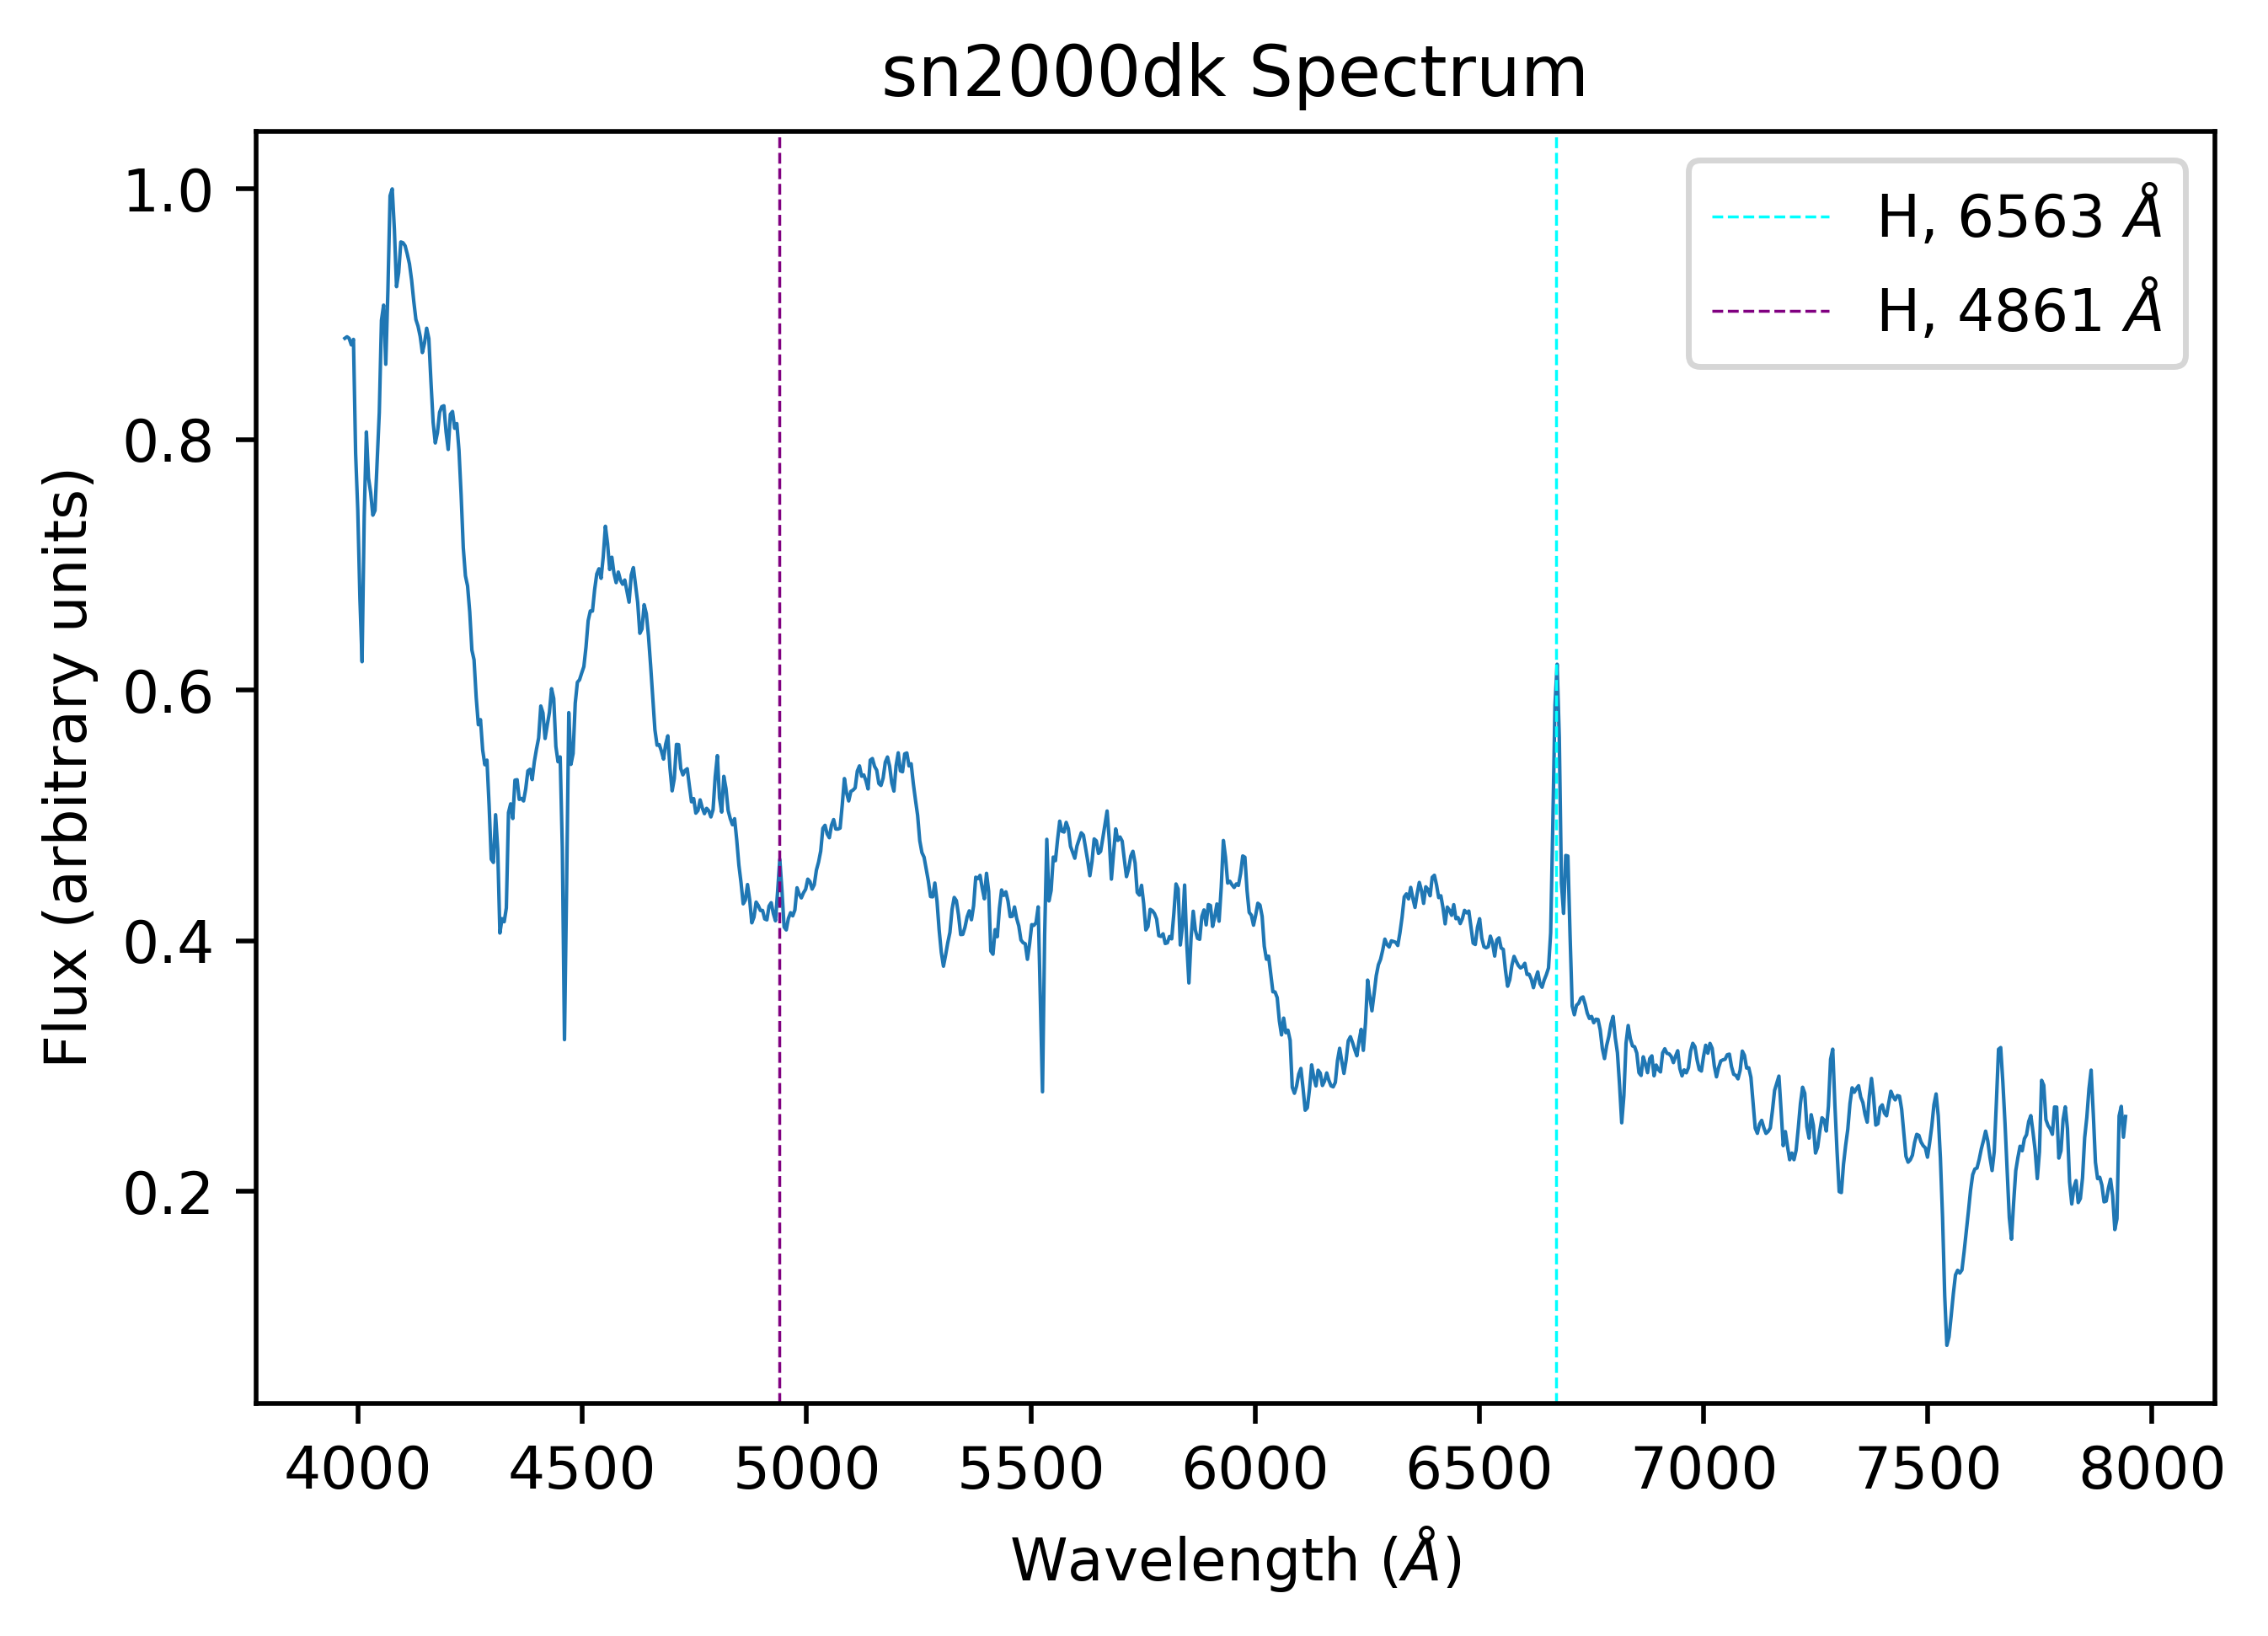

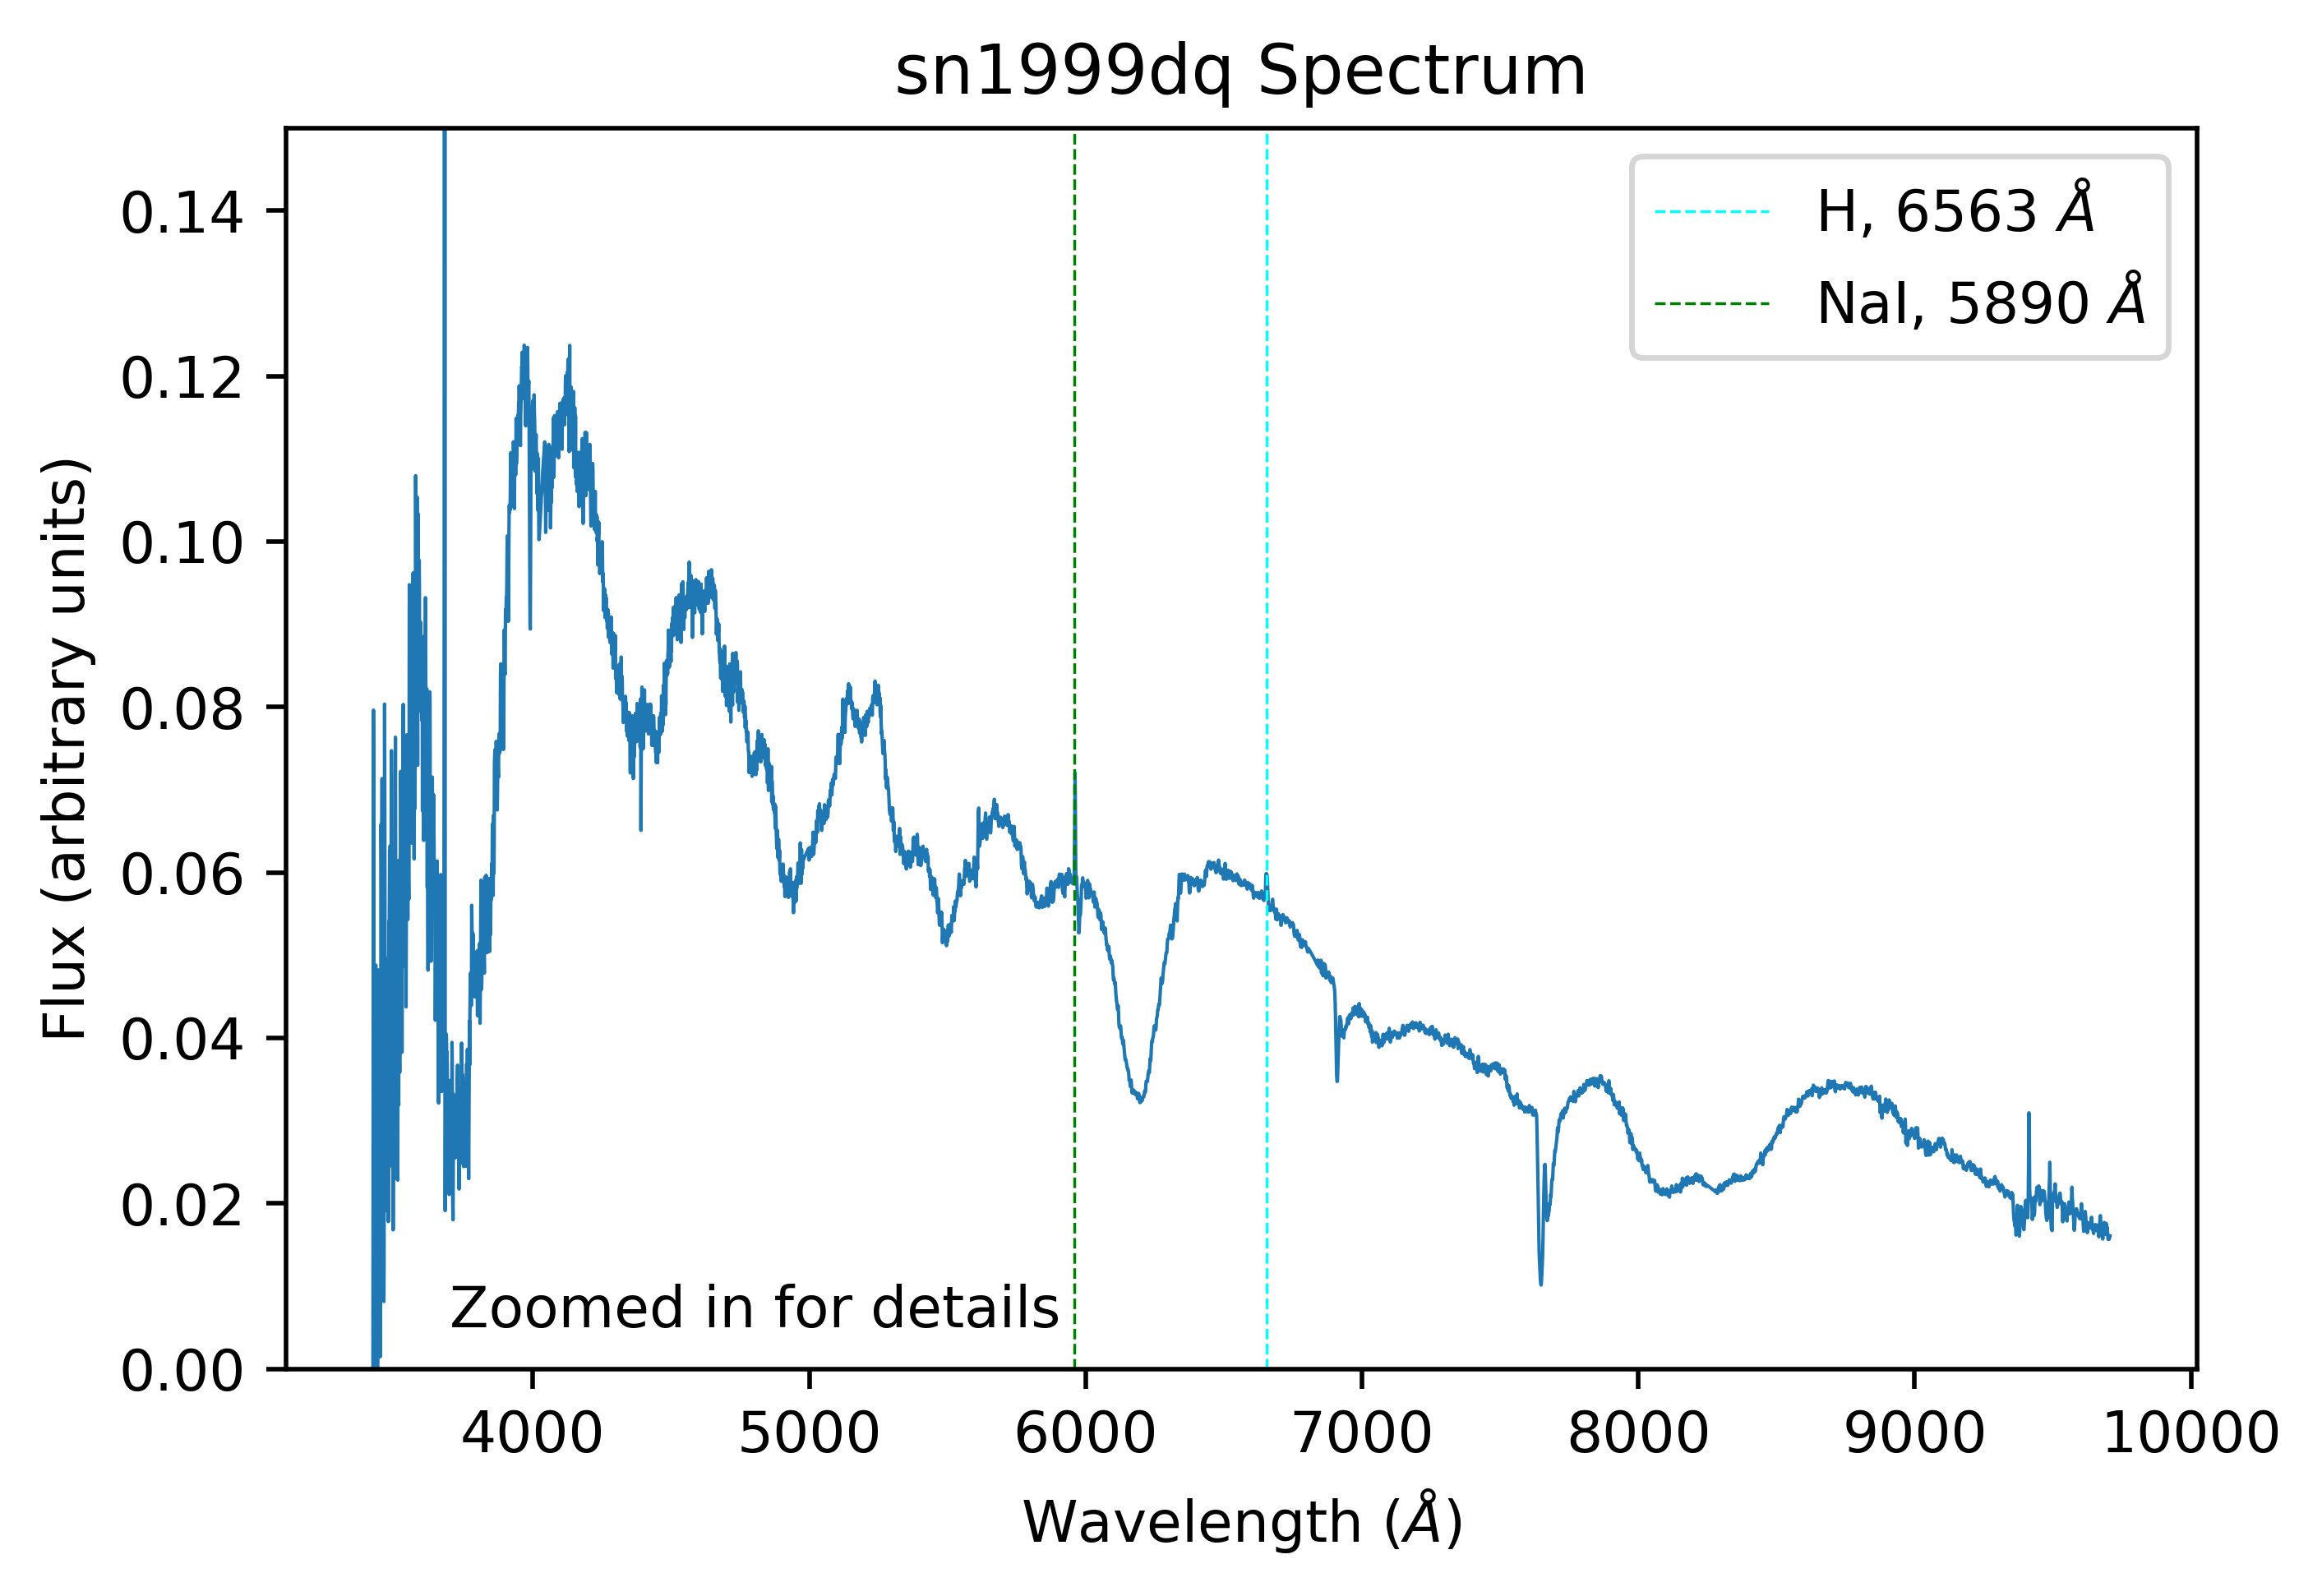

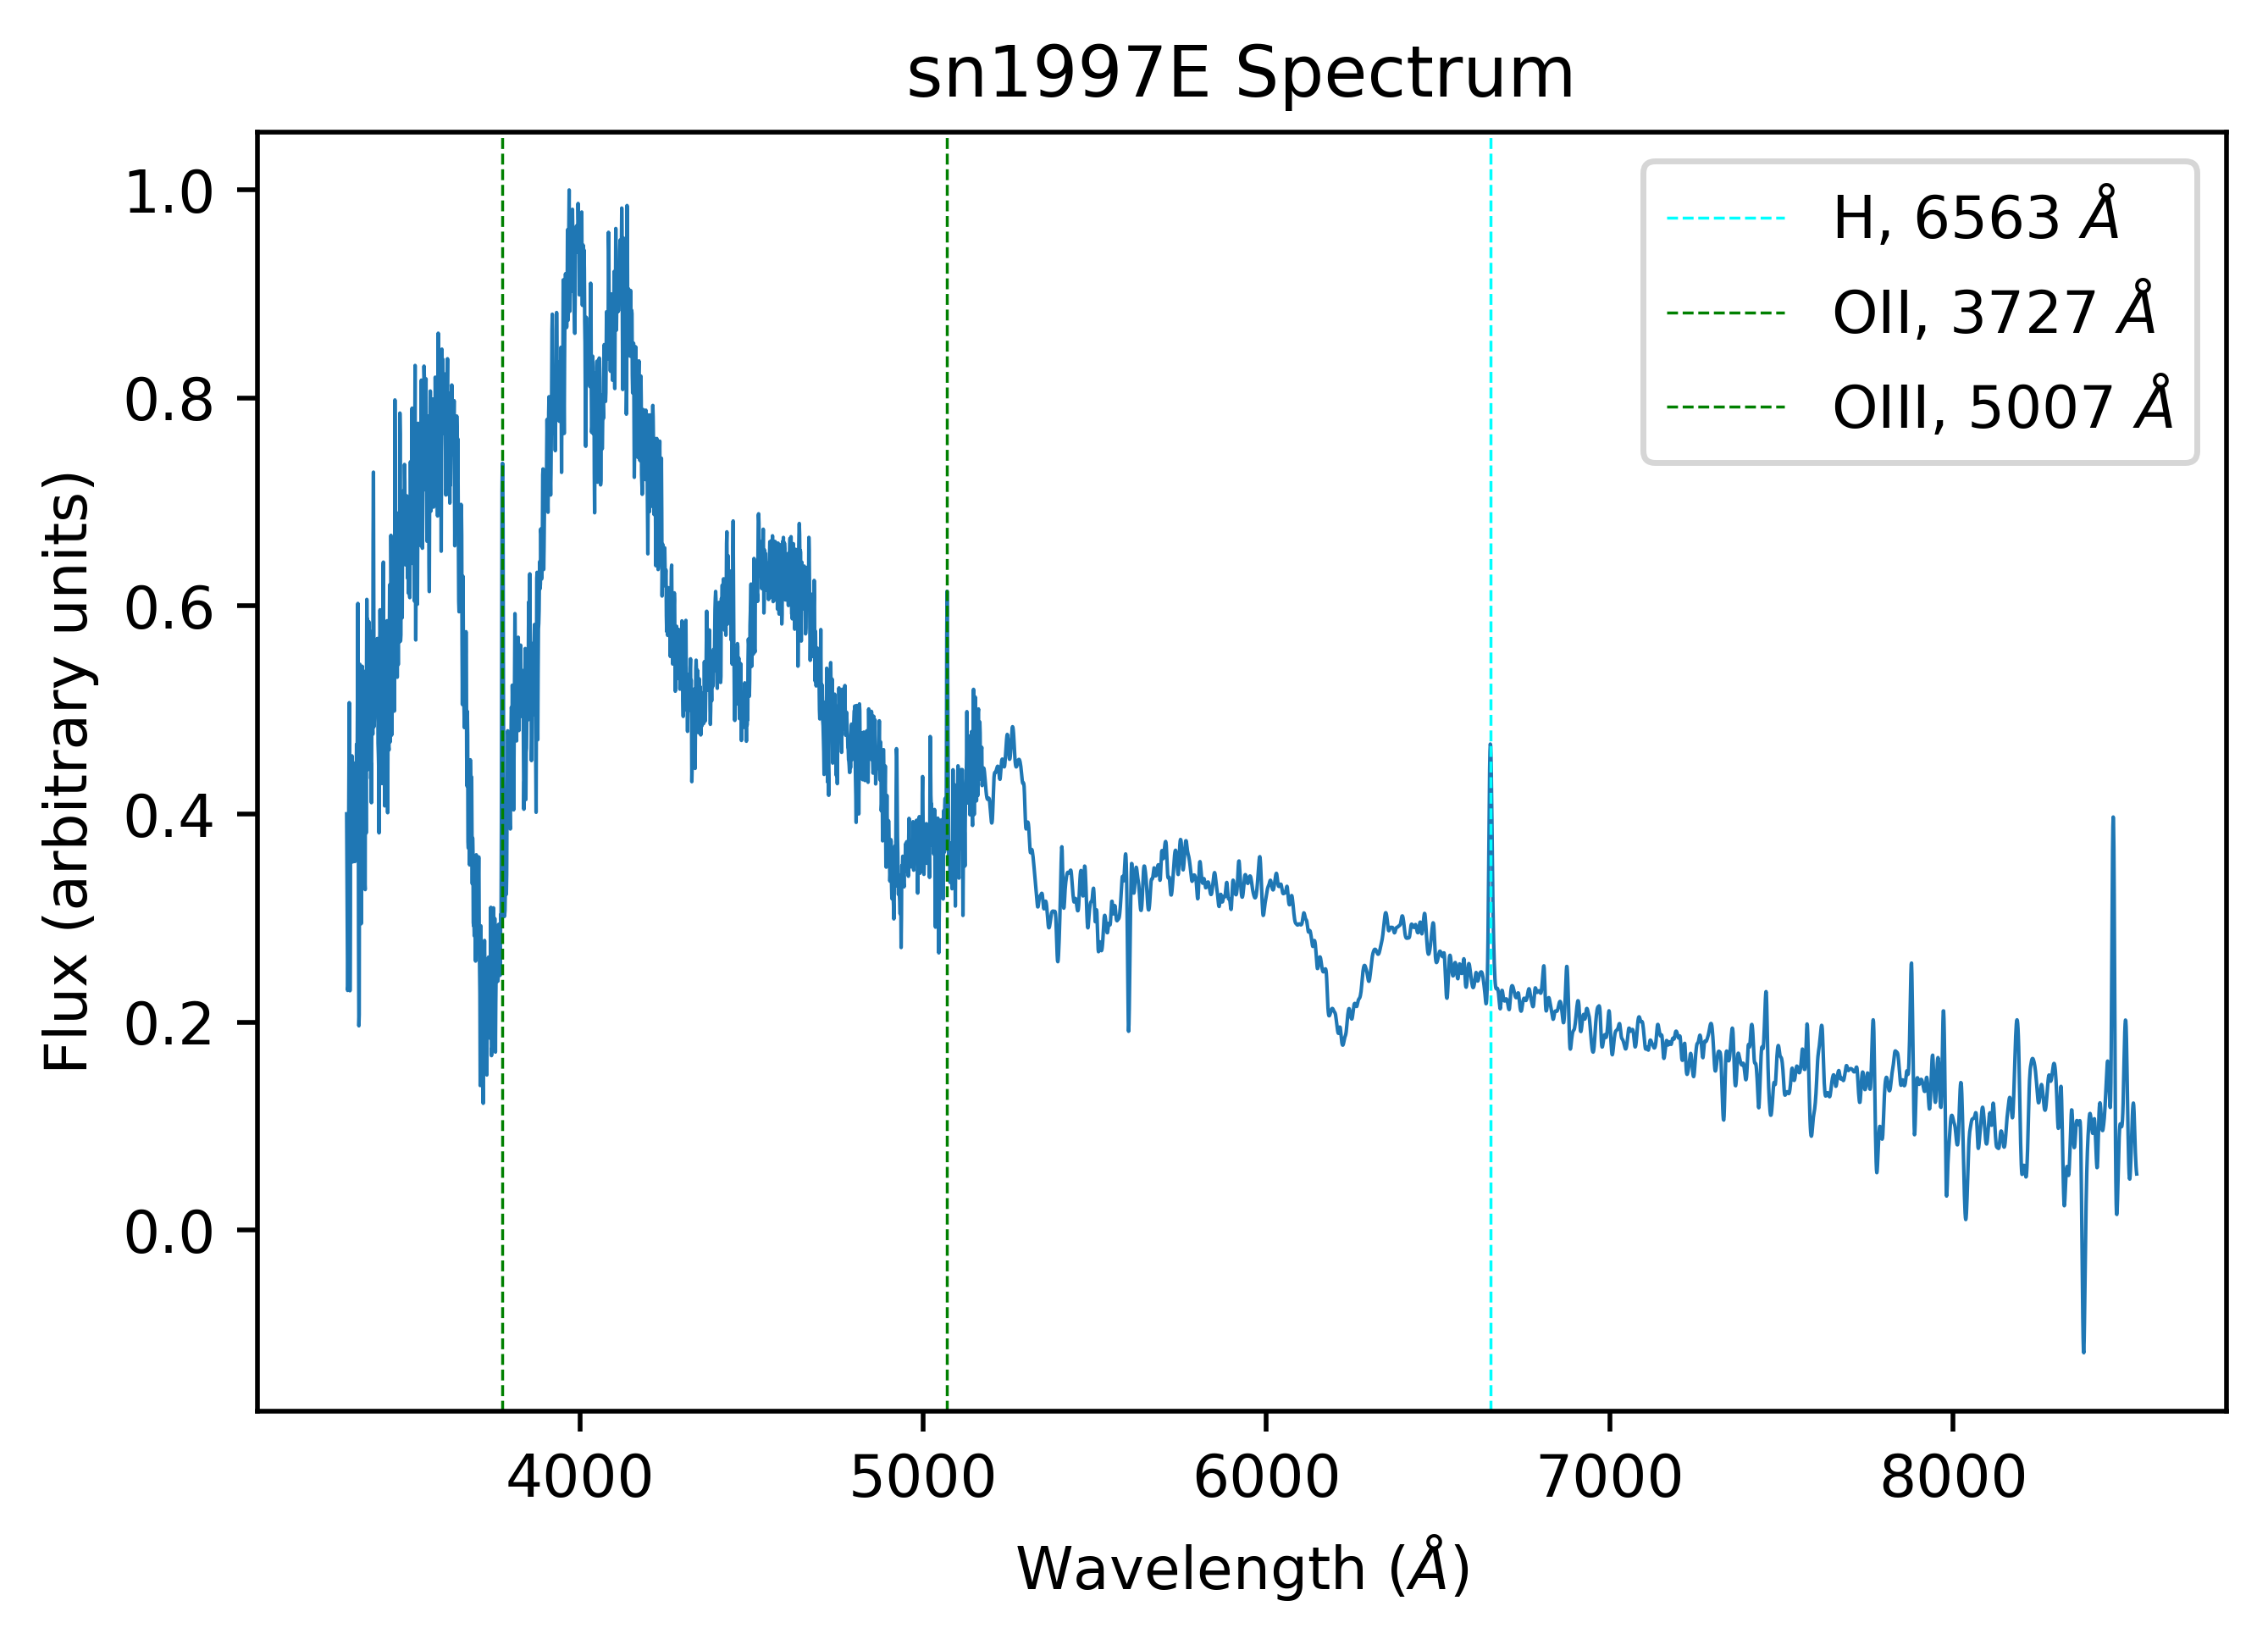

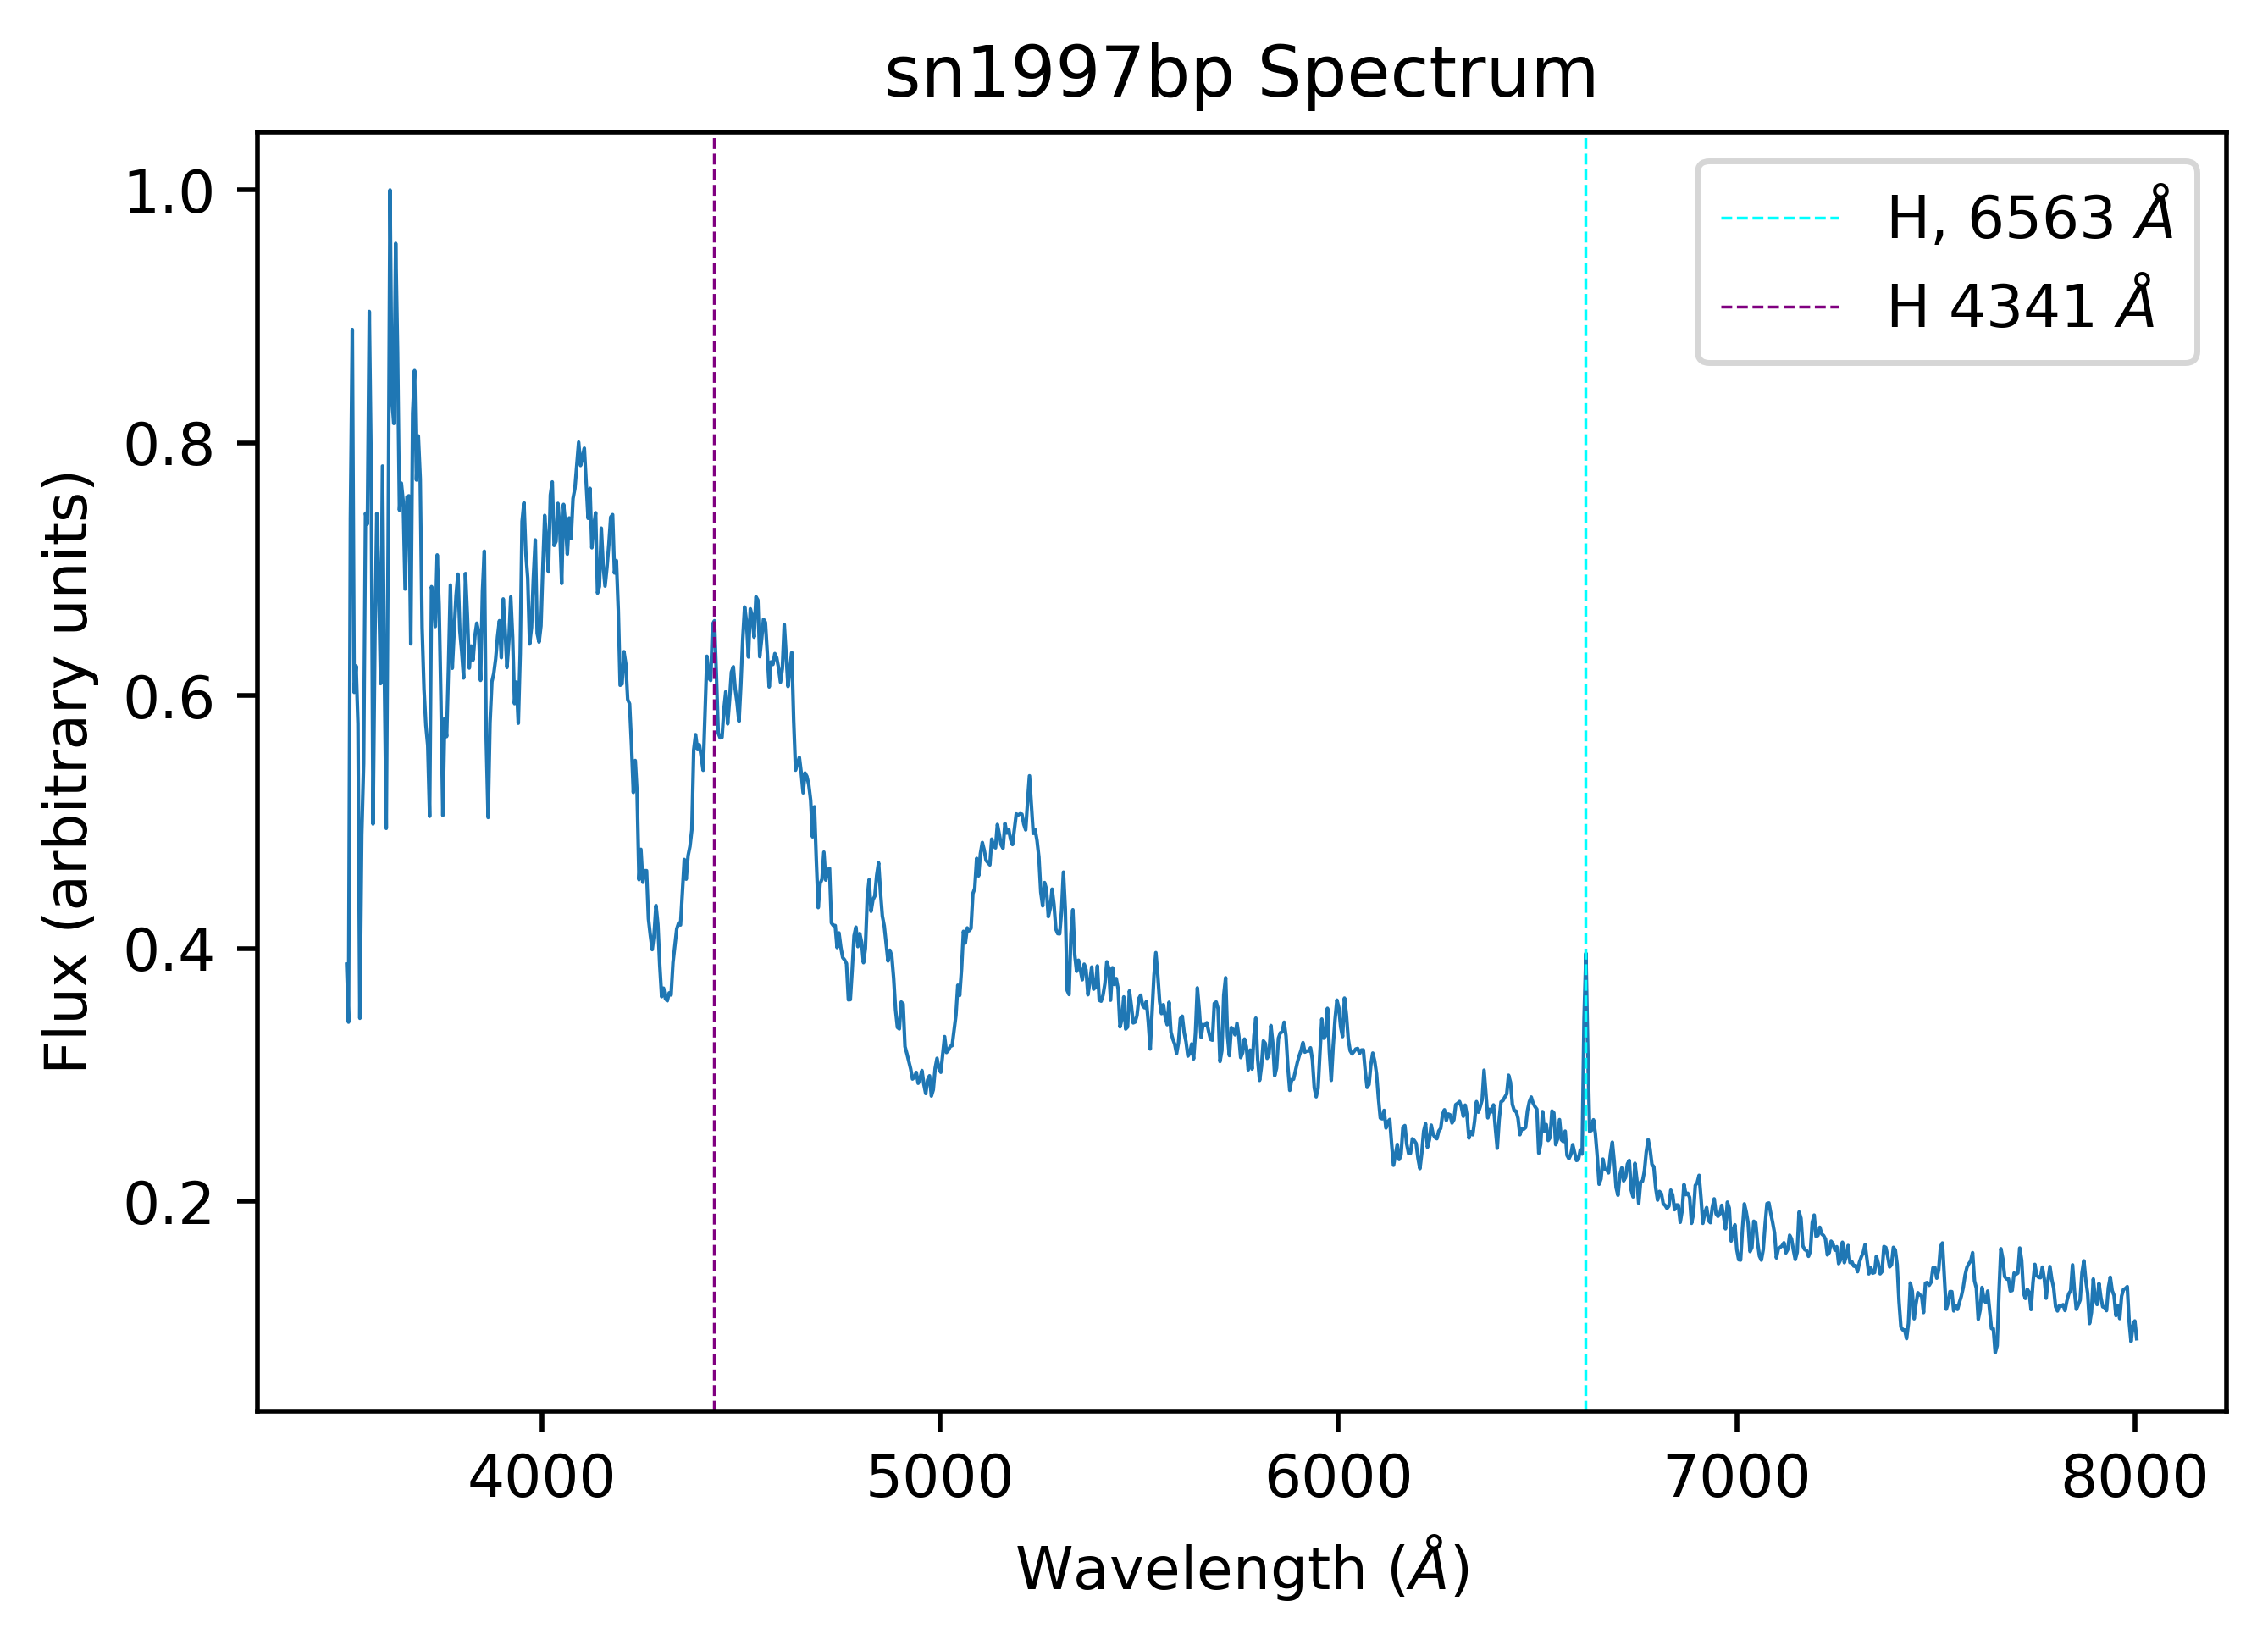

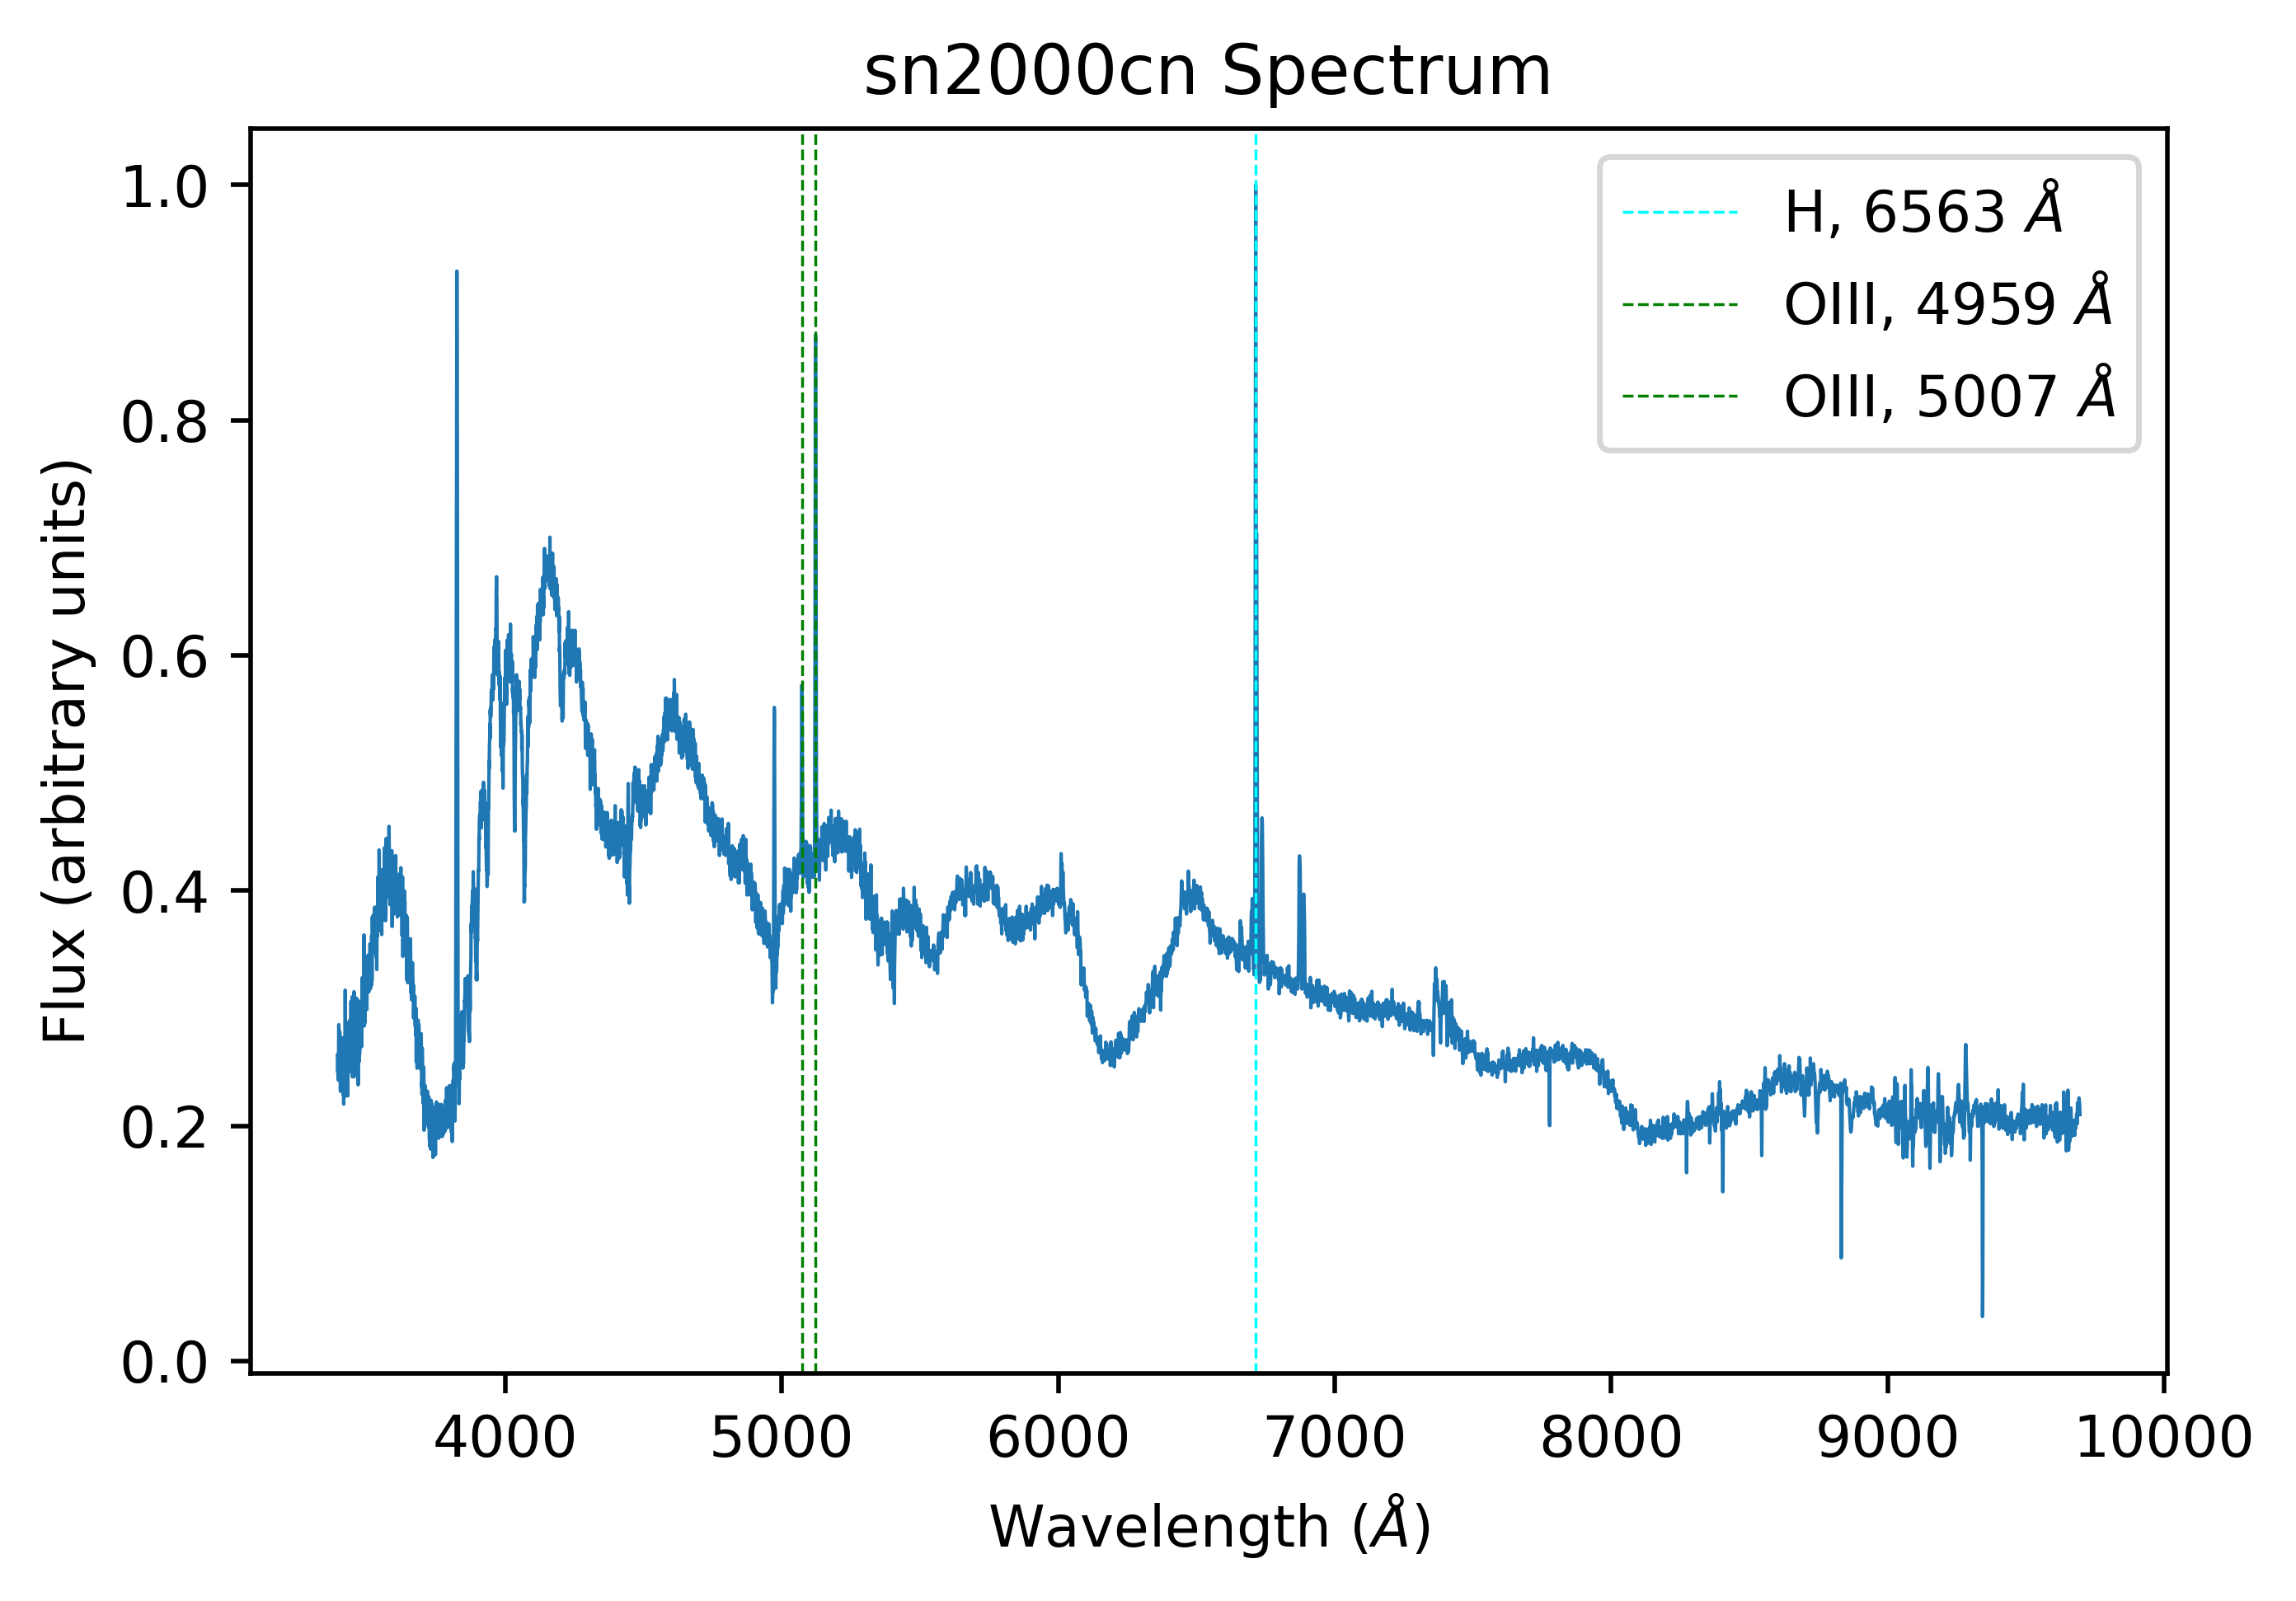

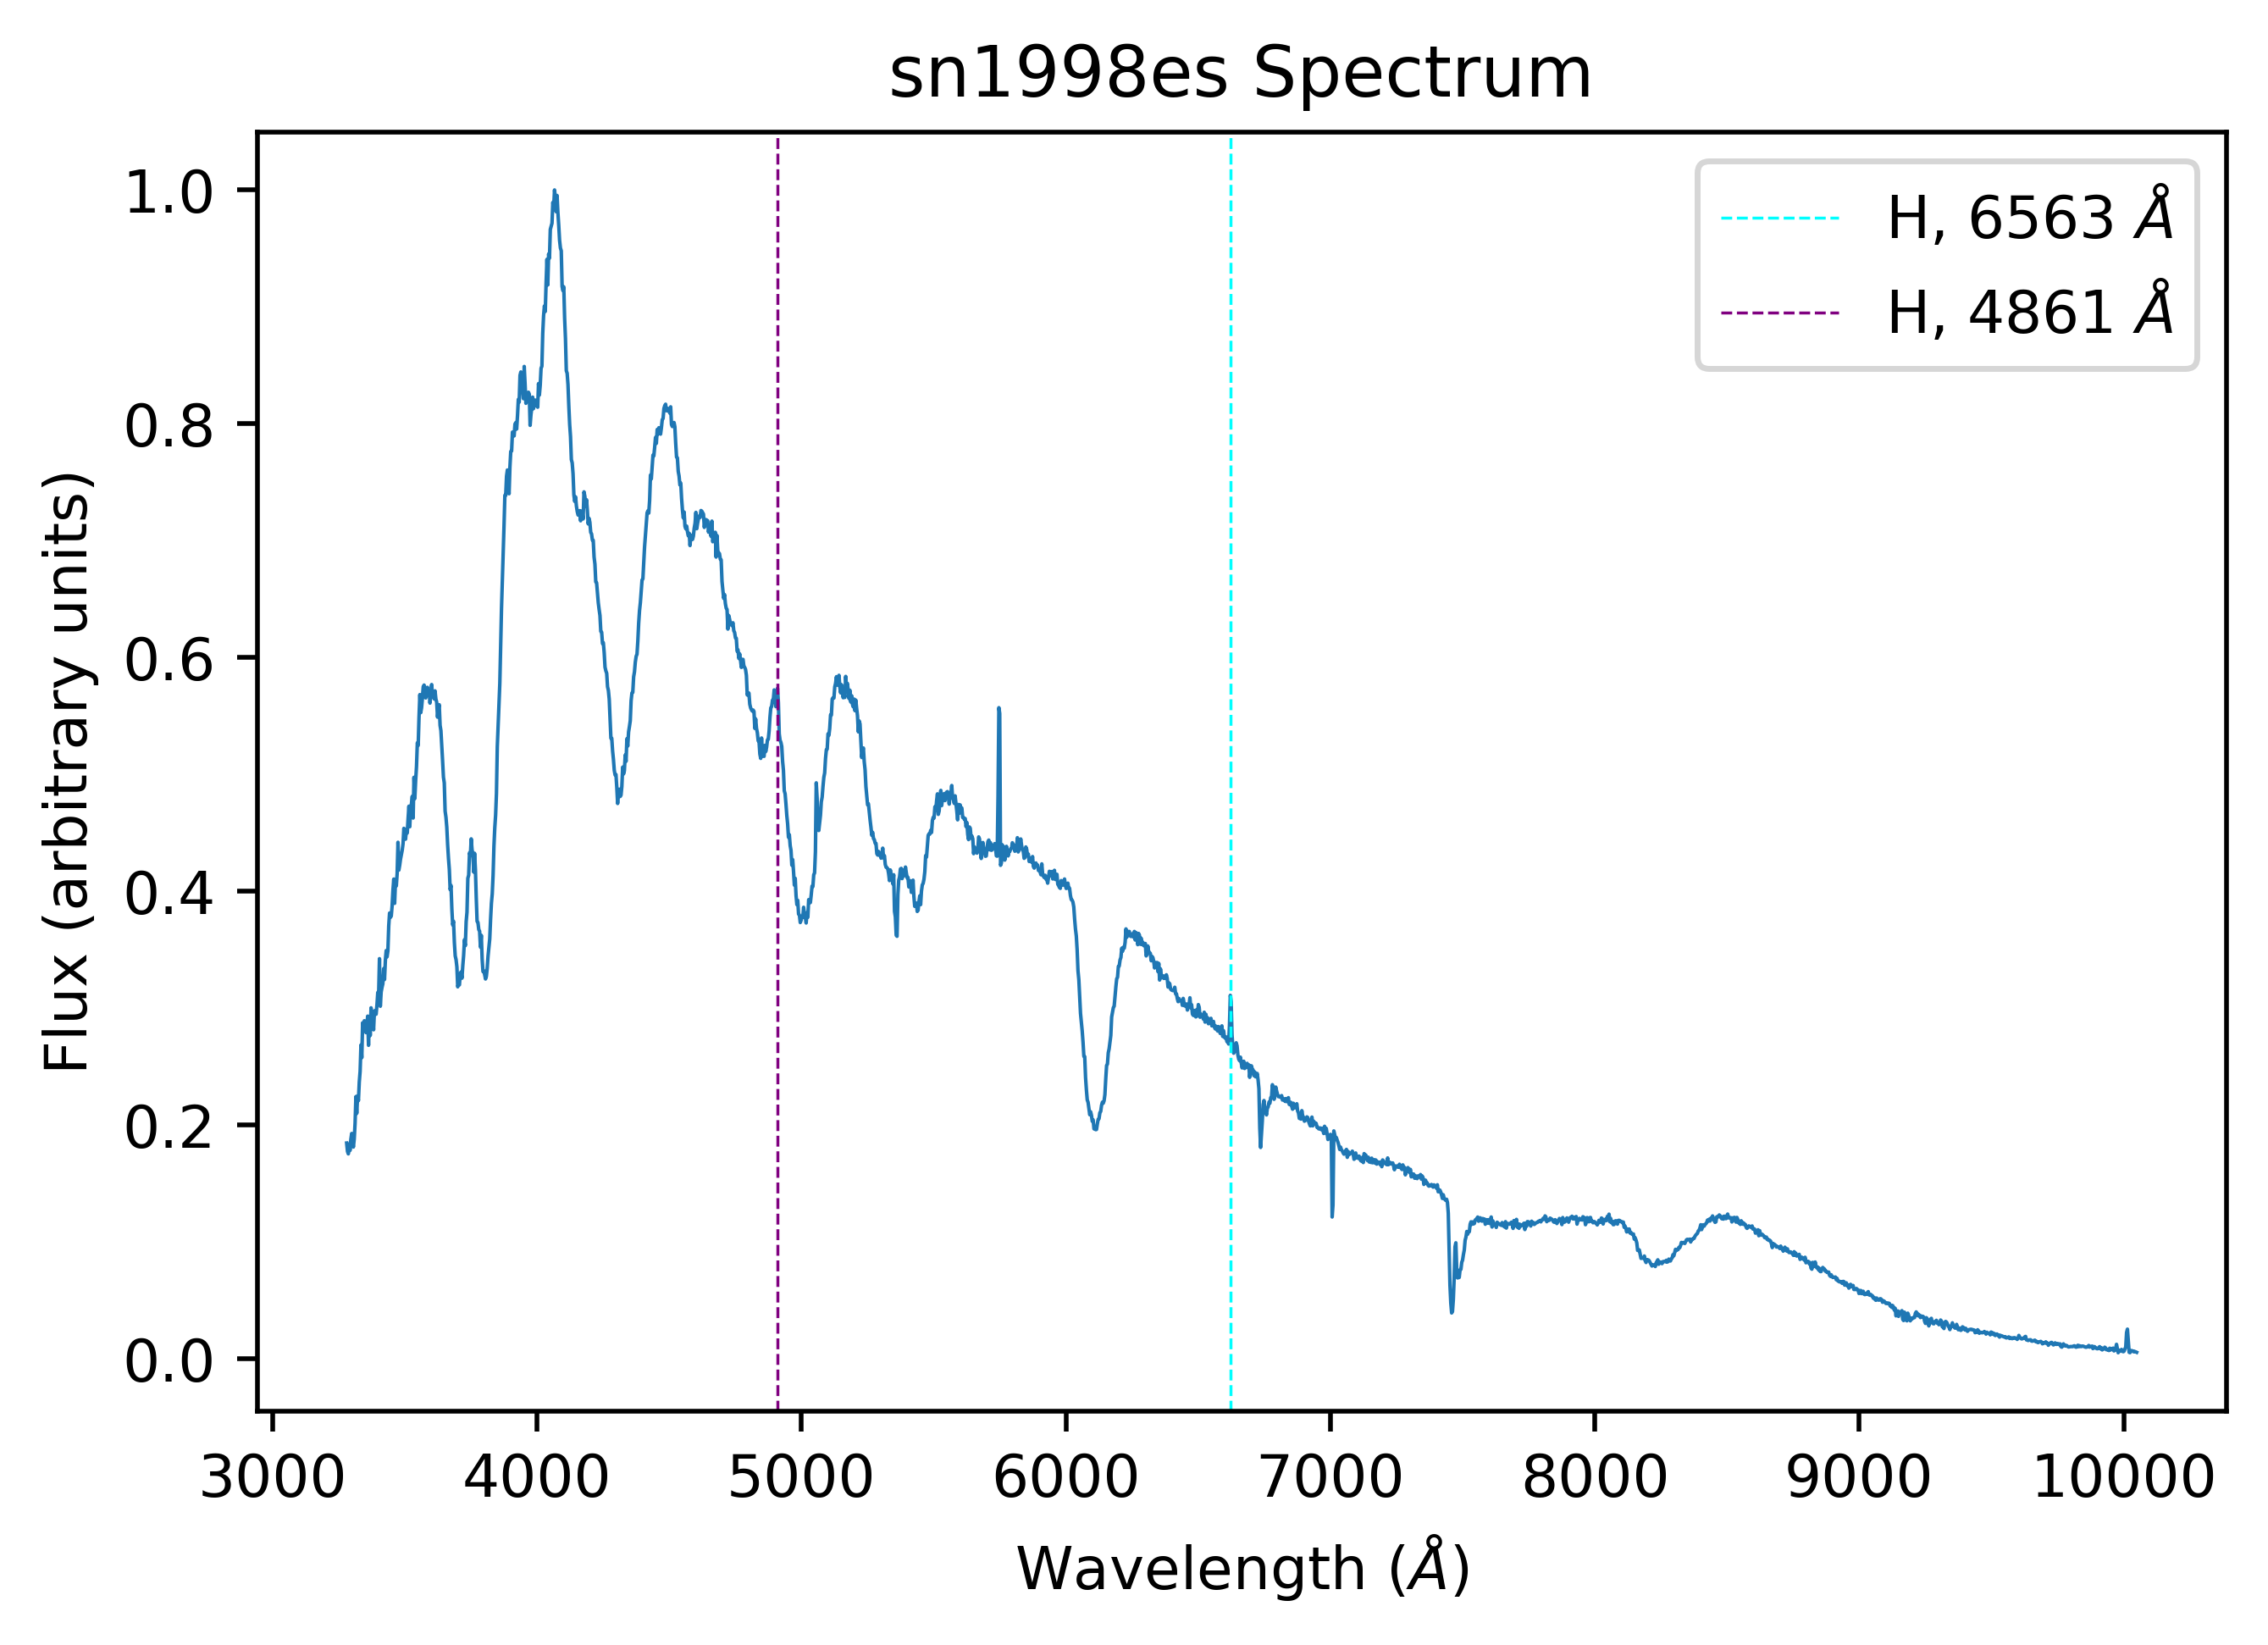

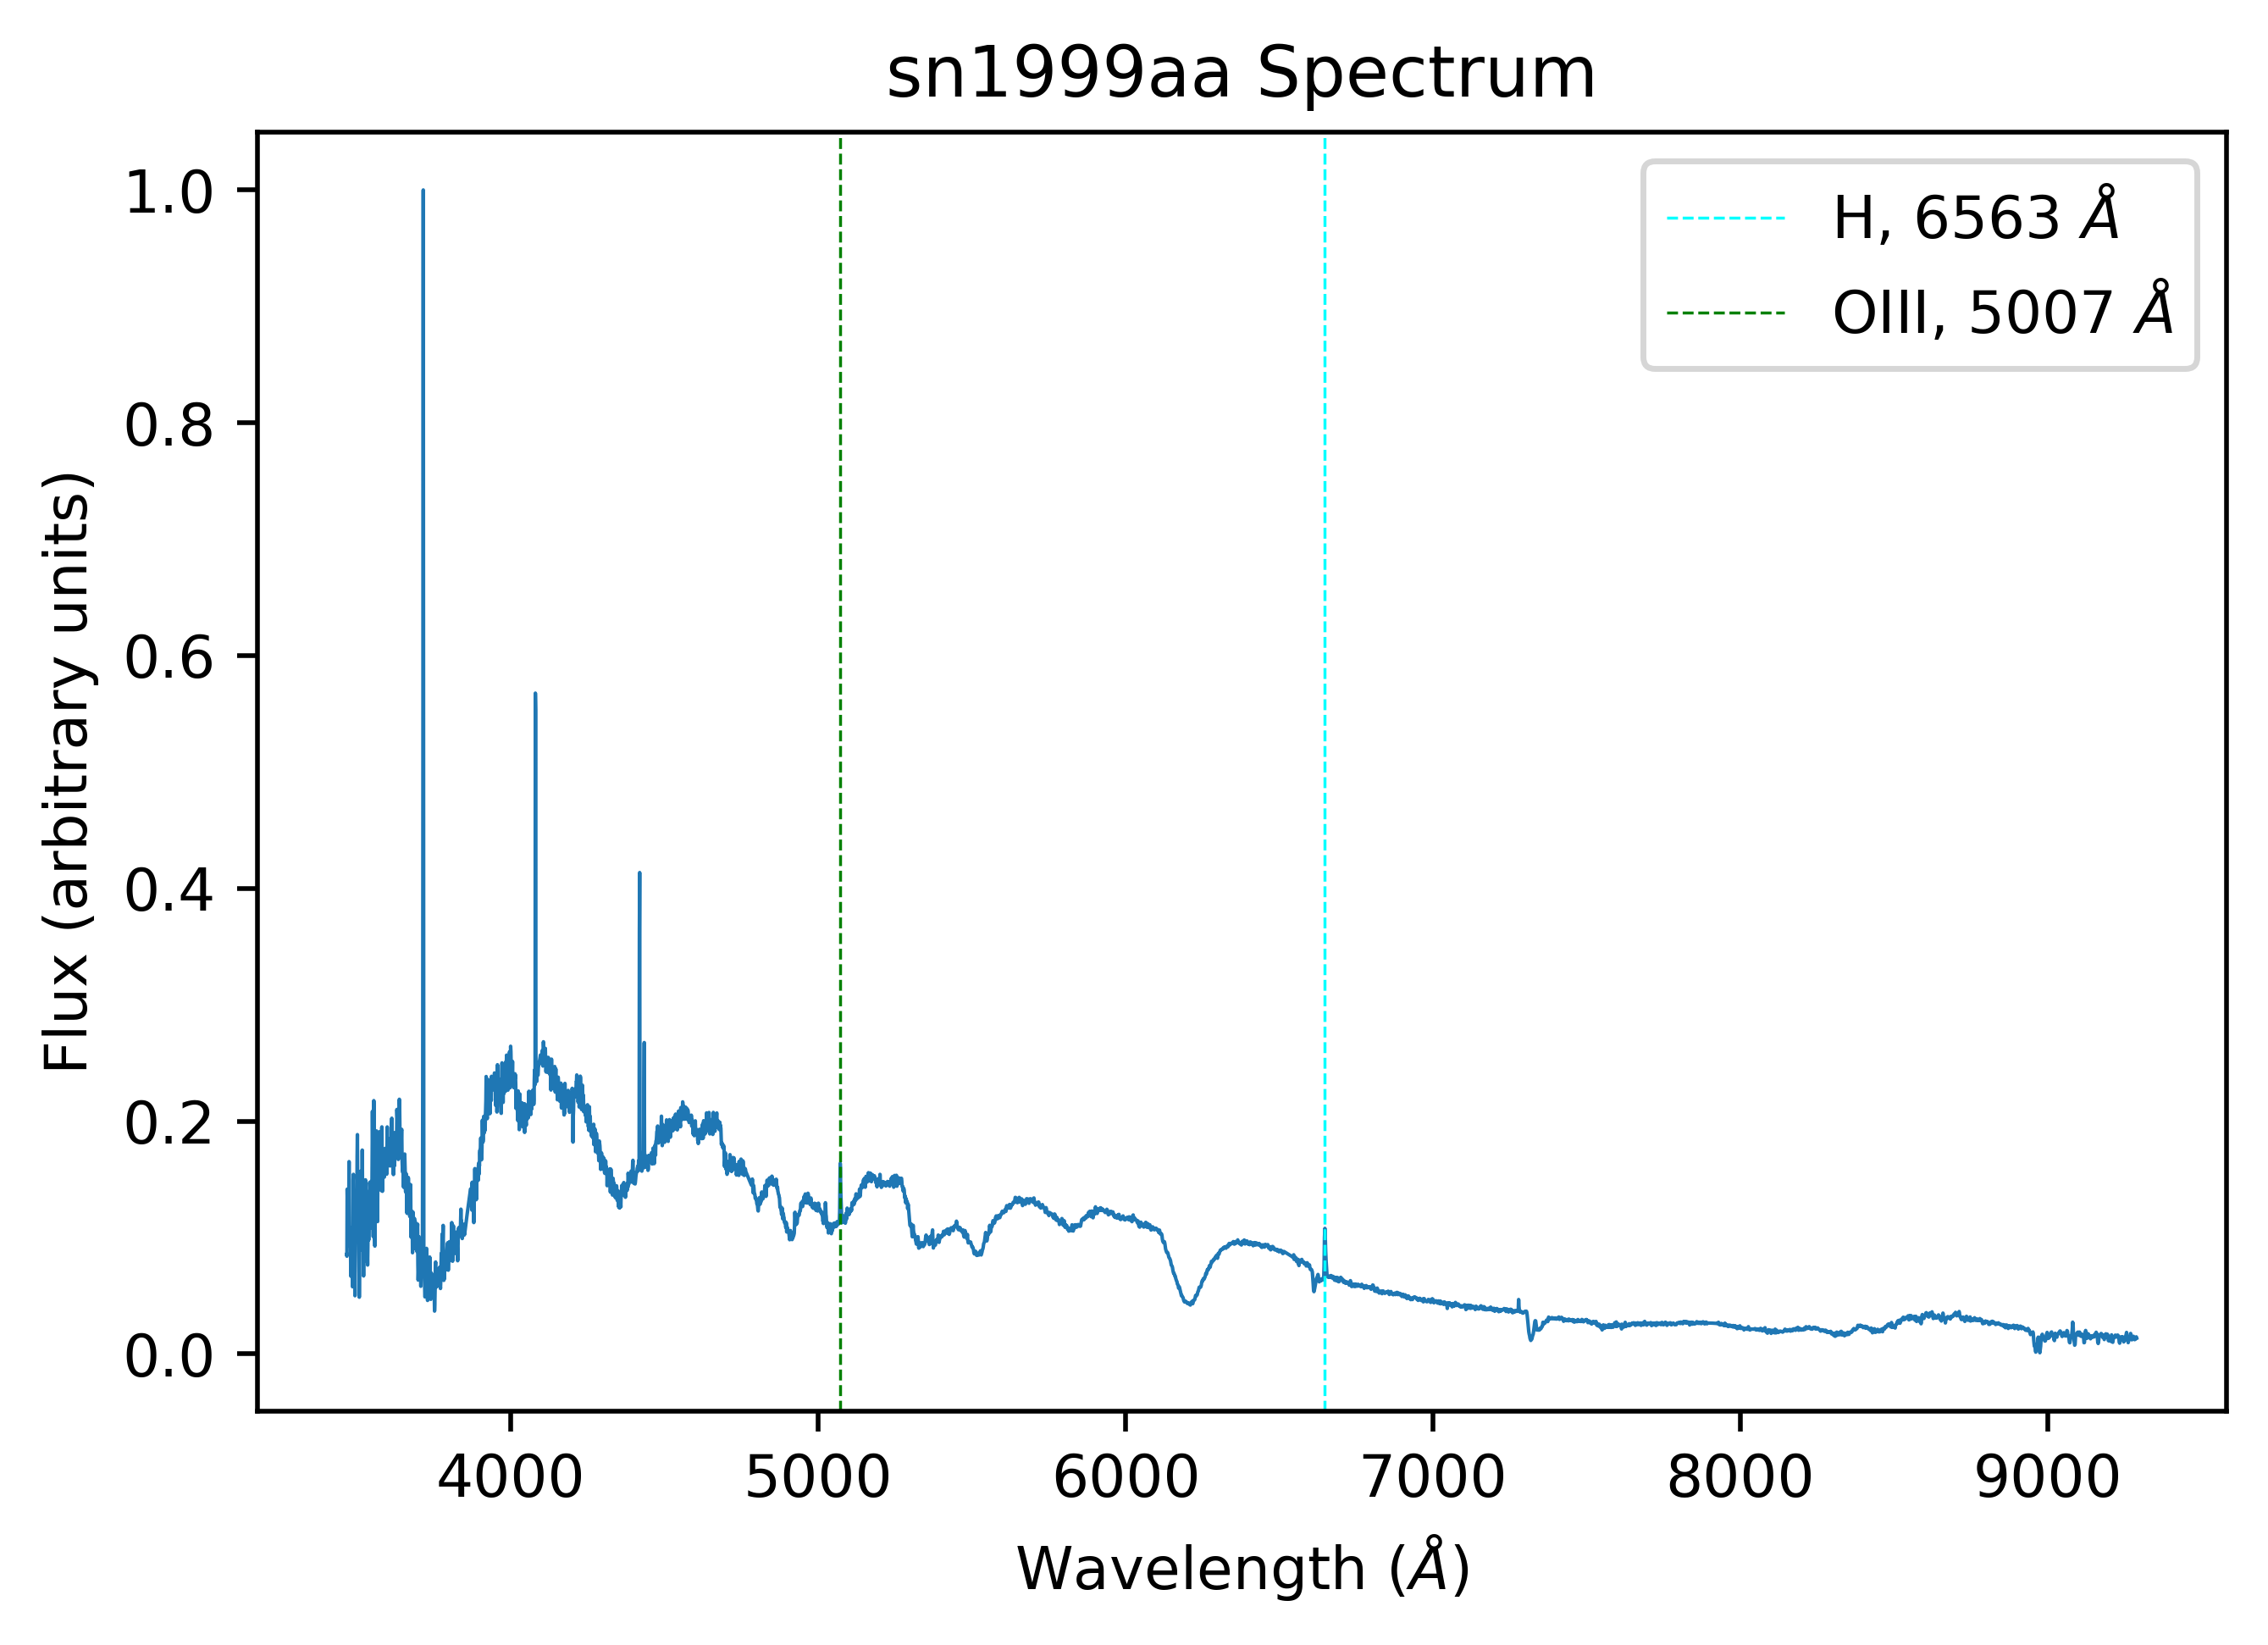

In [828]:
#From plotting approximate H alpha line wavelength shown below. These will be used as initial guesses for fitting.
testhpeaks = [6672,6655, 6652, 6621,6715,6623,6648] #peaks for H alpha


#plotting all of the spectra to look for H alpha and other lines.
#lines shown in the legend were used to calculate redshift

for i in range(len(wavelengths)):
    plt.figure(dpi=500)
    plt.title(sn_names[i] +' Spectrum')
    plt.xlabel(f'Wavelength ($\AA$)')
    plt.ylabel('Flux (arbitrary units)')
    plt.plot(wavelengths[i], fluxes[i],lw=0.6)
    plt.axvline(testhpeaks[i],color='cyan',lw=0.5,ls='--',label=r'H, 6563 $\AA$')
    
    #labelling the lines used for each plot:
    if i == 0:
        plt.axvline(4940,color='purple',lw=0.5,ls='--',label=r'H, 4861 $\AA$')
    if i == 1:
        plt.axvline(5960, color='green',lw=0.5,ls='--',label=r'NaI, 5890 $\AA$')
        plt.ylim(0,0.15)
        plt.text(3700,0.005,'Zoomed in for details')
    if i == 2:
        plt.axvline(3775, color='green',lw=0.5,ls='--',label=r'OII, 3727 $\AA$')
        plt.axvline(5070, color='green',lw=0.5,ls='--',label=r'OIII, 5007 $\AA$')
    if i == 3:
        plt.axvline(4432, color='purple',lw=0.5,ls='--',label=r'H 4341 $\AA$')
    if i == 4:
        plt.axvline(5073, color='green',lw=0.5,ls='--',label=r'OIII, 4959 $\AA$')
        plt.axvline(5123, color='green',lw=0.5,ls='--',label=r'OIII, 5007 $\AA$')
    if i == 5:
        plt.axvline(4910,color='purple',lw=0.5,ls='--',label=r'H, 4861 $\AA$')
    if i == 6:
        plt.axvline(5072,color='green',lw=0.5,ls='--',label=r'OIII, 5007 $\AA$')
    plt.legend()
    plt.savefig(sn_names[i]+'_spectrum_with_lines.png',bbox_inches='tight')


#again the approximate wavelength for the lines that will be used to calculate redshift are shown below and their 
#corresponding rest wavelength. These were done 'by eye' and the gaussian will find the correct value of the peak

#sn2000dk has a line around 4940, it is the H 4861 line
#1999dq has a line around 5960, it is the Na line, either 5890 
#.   1999dq also has a line at 3681, lower than any of the reference lines given, it cannot be blueshifted though
#1997E has a line at 3775, this is the OII at 3727
#.    1997E also has a line at 5070, the OIII at 5007
#1997bp: peak at 5225, 5310, don't correspond
#.    1997bp also has a peak at 4432, looks like H at 4341
#2000cn: has peaks at 5073, corresponding to OIII at 4959
#.   also has peak at 5123 corresponding to OIII at 5007
#1998es: peak at 5750, doesn't correspond 
#.   also peak at 4910, looks like H at 4861
#1999aa: peaks at 4080,5072,4419,4434
#.    only 5072 corresponds to OIII at 5007

Text(0, 0.5, 'Flux (arbitrary units)')

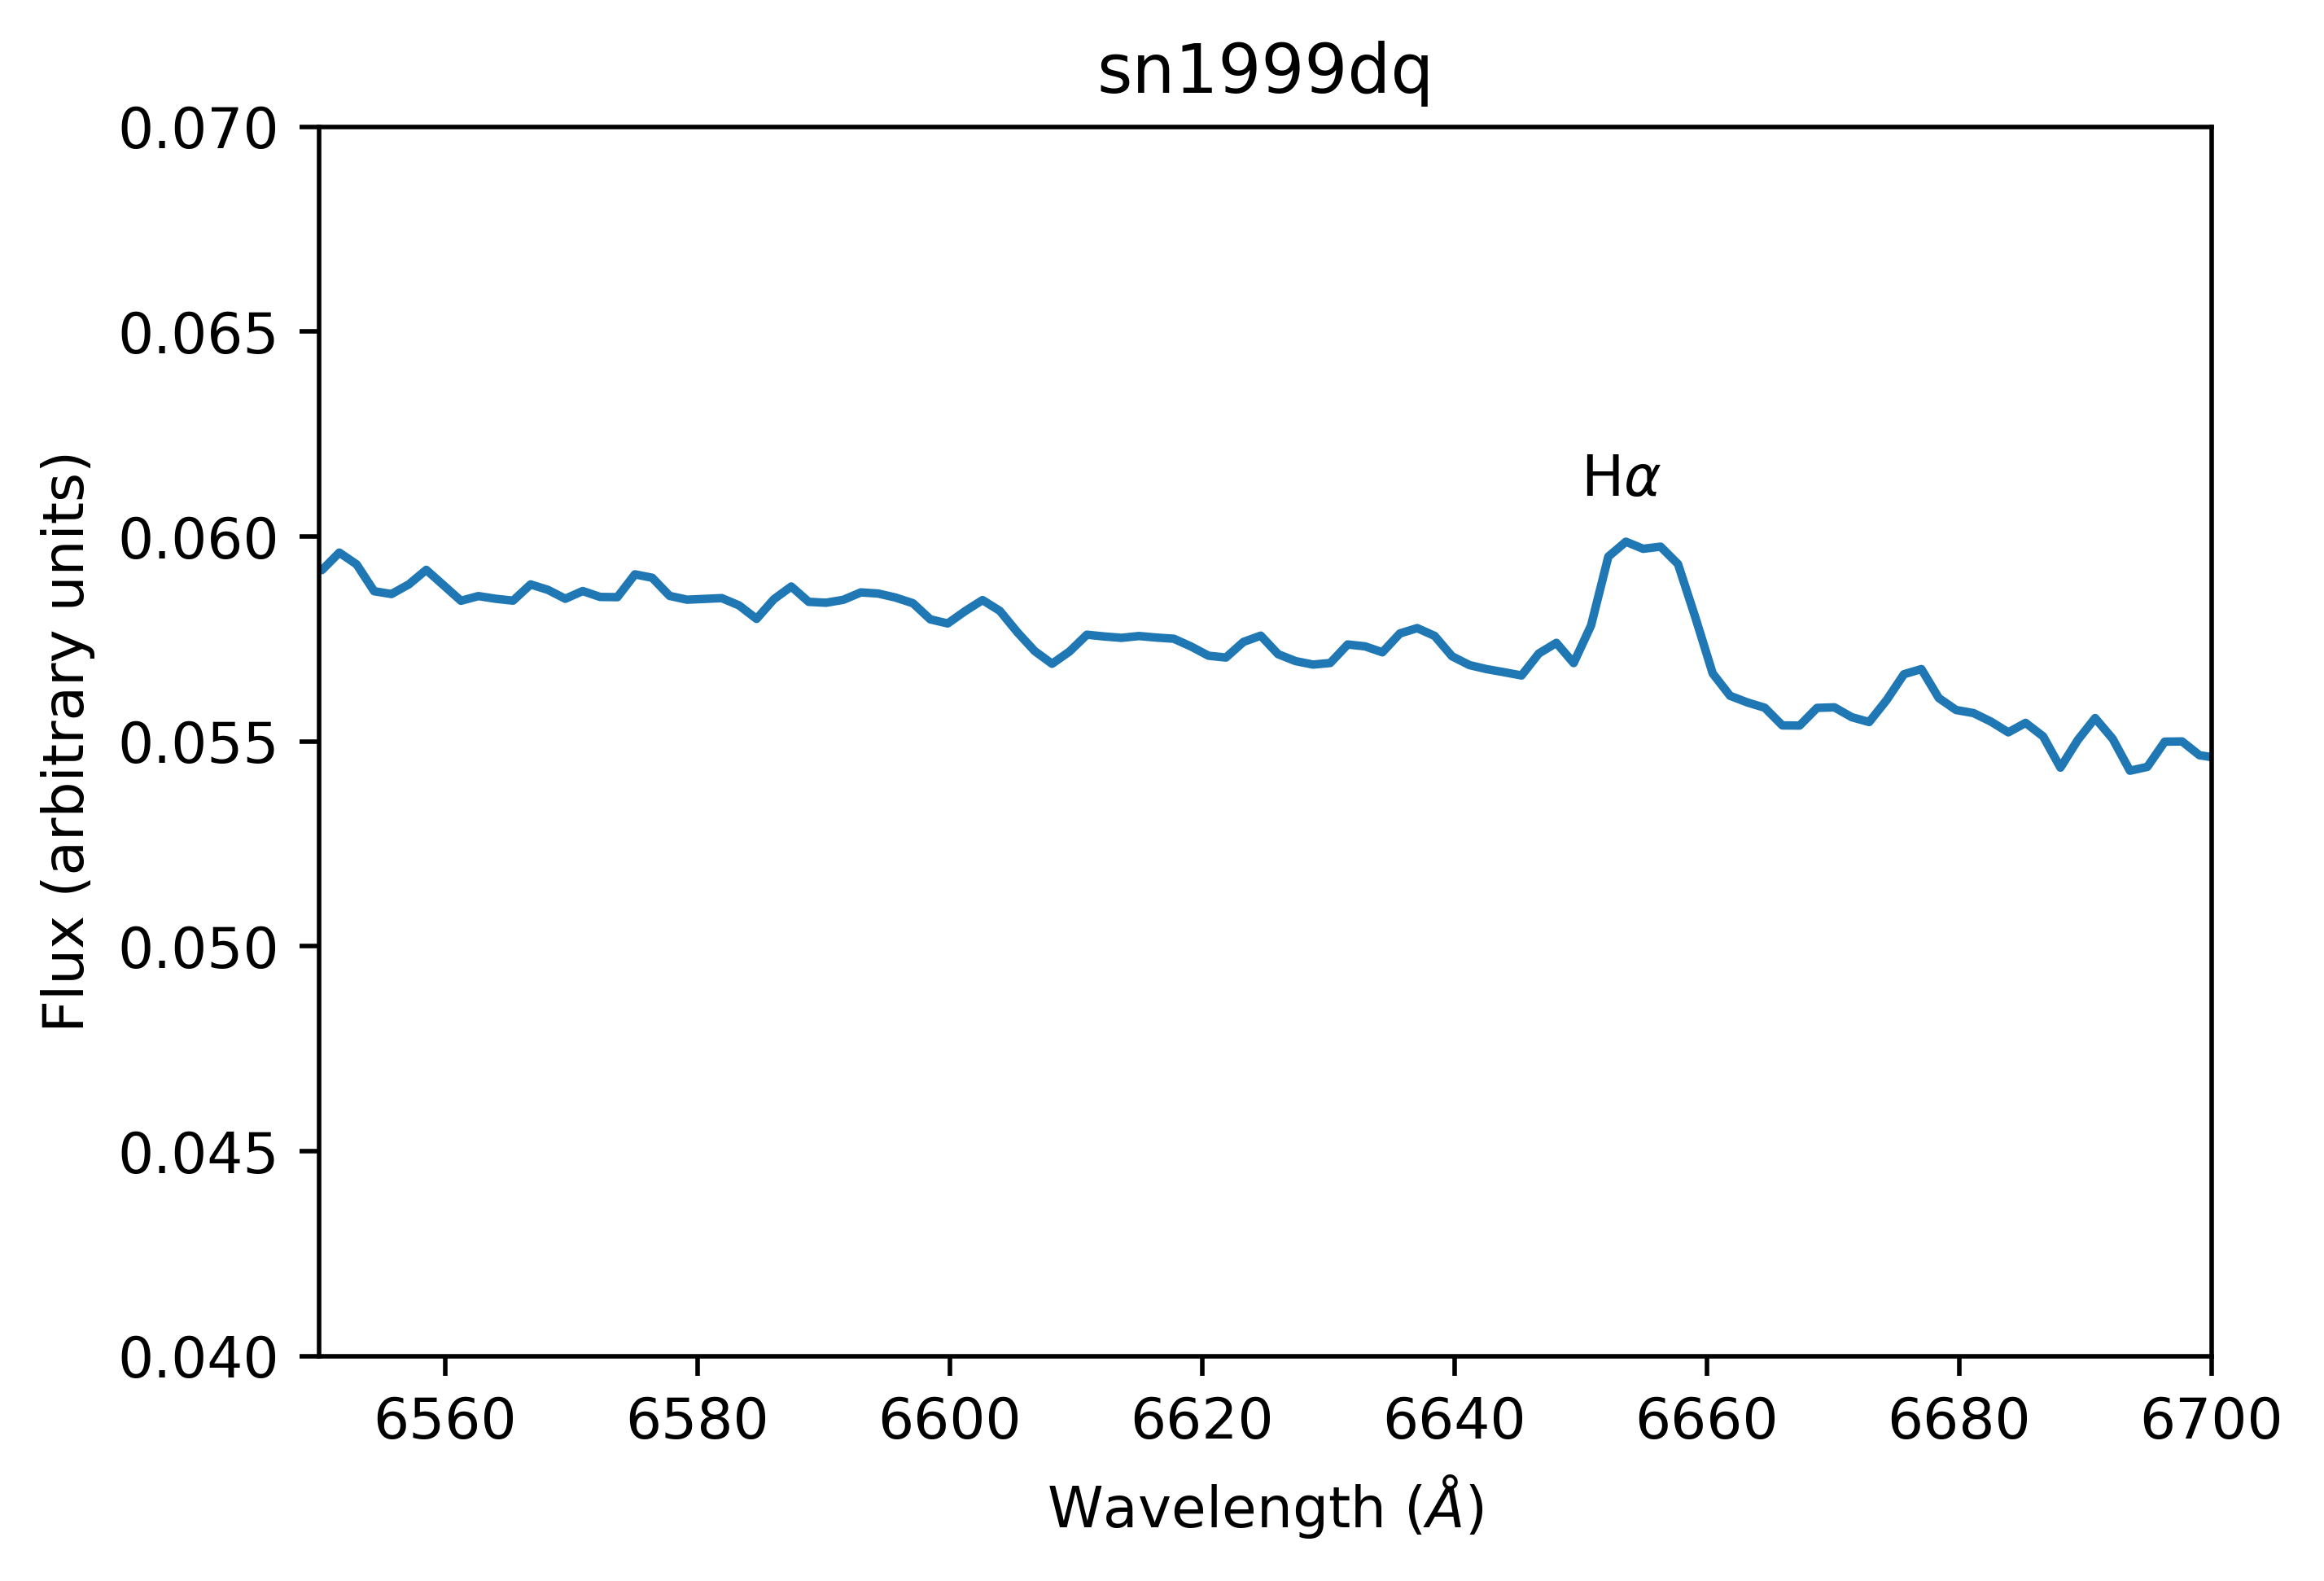

In [631]:
#for sn1999dq, it was harder to see where H alpha is, so I replotted to find it:
#approx 6650 A
plt.figure(dpi=500)
plt.plot(wavelengths[1], fluxes[1])
plt.title(sn_names[1])
plt.xlim(6550,6700)
plt.ylim(0.04,0.07)
plt.text(6650,0.061,r'H$ \alpha $ ')
plt.xlabel(f'Wavelength ($\AA$)')
plt.ylabel('Flux (arbitrary units)')

In [888]:
# Could be in a function module
def gaussian(x, A, B, C, D):
    """
    Gaussian function
    """
    
    y = A*np.exp(-1*( ((x-B)**2) / (2*C**2) ) ) + D
    #A = height of the peak
    #B = x value of the peak 
    #C = standard deviation (C^2 will be variance), FWHM = ( 2sqrt(2 ln(2)) )*C   - use for error vs std?
    #D is the y offset
    return y

def redshift(obs, rest):
    z= (obs - rest) / rest
    return z

def redshift_err(obs,rest,dev_obs):
    dev_rest = 0.5 #angstrom
    err = np.sqrt((1/rest * dev_obs)**2 +((obs/rest**2)*dev_rest)**2)
    return err

def chi2(params, f, x, y):

    chi2 = (np.sum( (y - f(params,x))**2 ))
    return chi2

def chi2_partD(model, x, y):
    chi2 = np.sum( (y-model)**2 )
    return chi2


def line(params, x):
    y = params[0]*x + params[1]
    return y 

In [633]:
def findpeak(guess_wvlen,  bandwith, in_wvlen, in_flux, v):
    """
    Function which takes in the guess of peak wavelength and a wavelength bandwith to search between. 
    Using the wavelength and flux of each supernovae it fits a peak to the emission line
    It returns the fit parameters and the wavelength/flux range it used to find this fit
    """
    
    A = 0.5
    B = guess_wvlen #Both found via the plotting earlier
    C,D = 10, 0.2 #initial parameters seem to be good
    param0 = [A,B,C,D]
    
    lower, upper = guess_wvlen - bandwith, guess_wvlen + bandwith #gives range to look at in wavelengths


    #need to change this wavelength range into a index range to parse the arrays:
    indices = np.where((np.array(in_wvlen) > lower) & (np.array(in_wvlen) < upper))
    
    lower_ind, upper_ind = indices[0][0], indices[0][-1] #gets the first and last in the indexes for the range
    
    #now constrain the wavelength and flux to these indices
    constrained_wvlen = in_wvlen[lower_ind:upper_ind]
    constrained_flux = in_flux[lower_ind:upper_ind]
    
    #fit a gaussian to these values
    popt, pcov = opt.curve_fit(gaussian, constrained_wvlen, constrained_flux, p0=param0)
    
    return popt, pcov, constrained_wvlen, constrained_flux

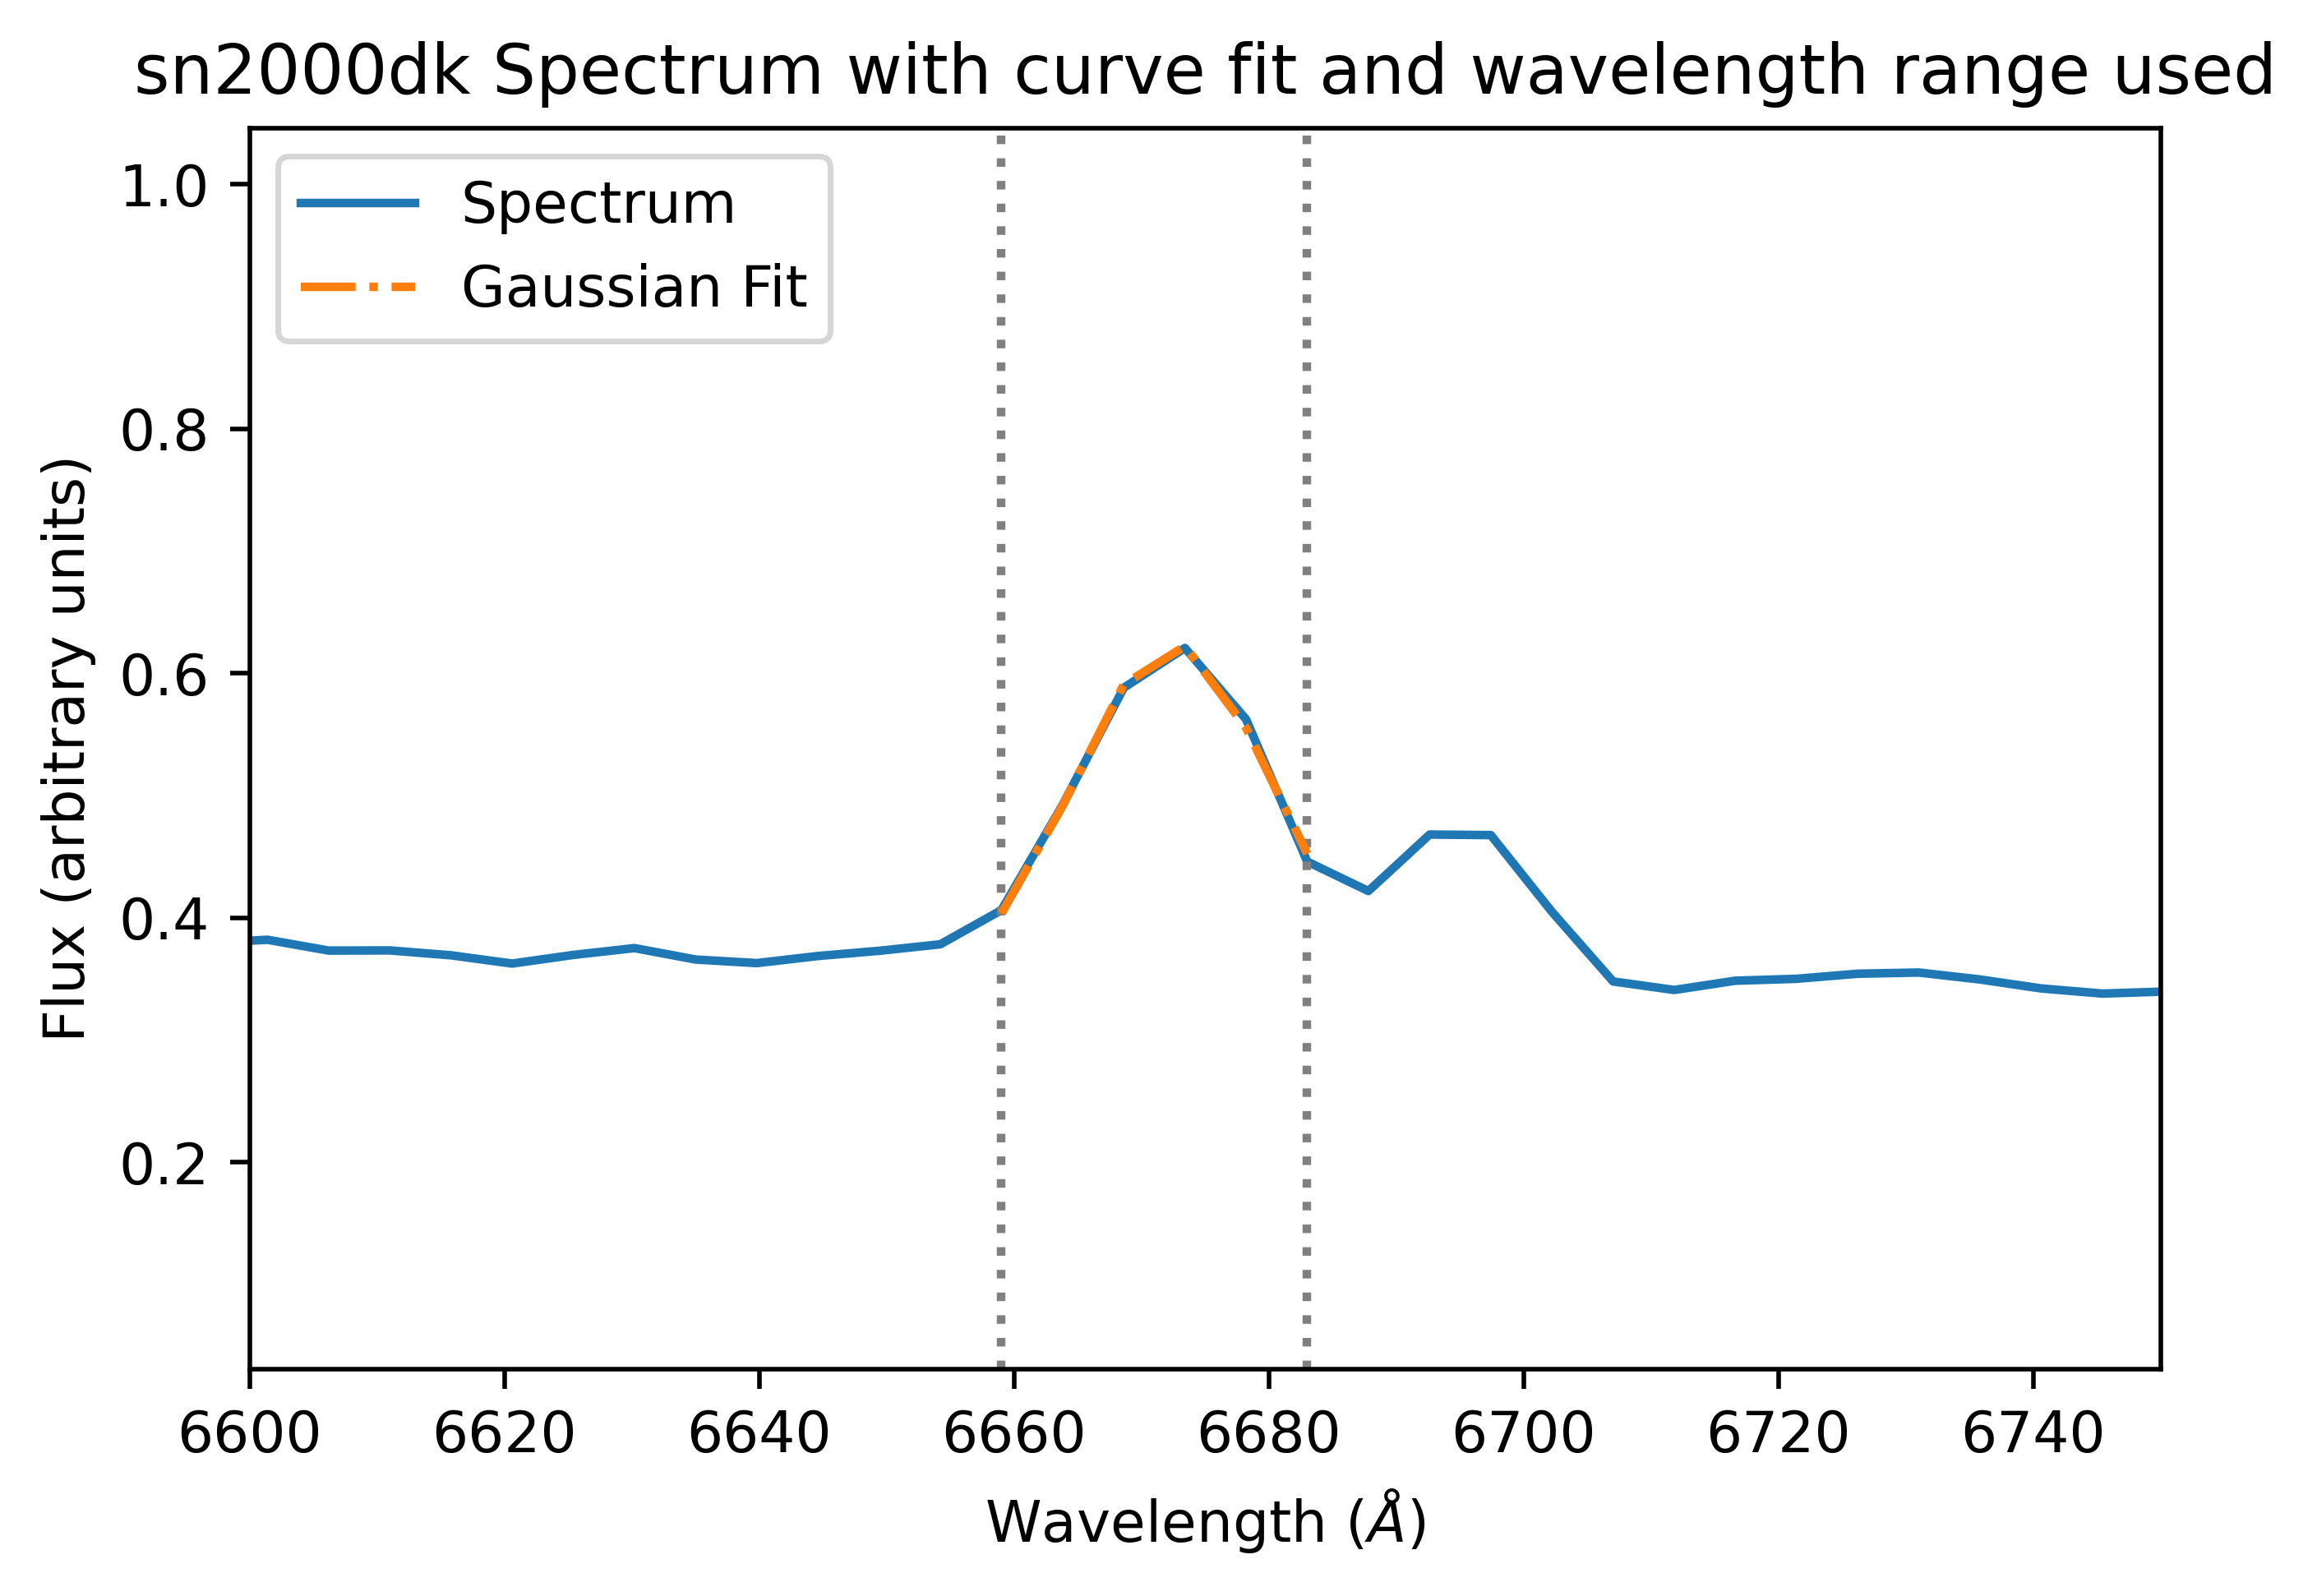

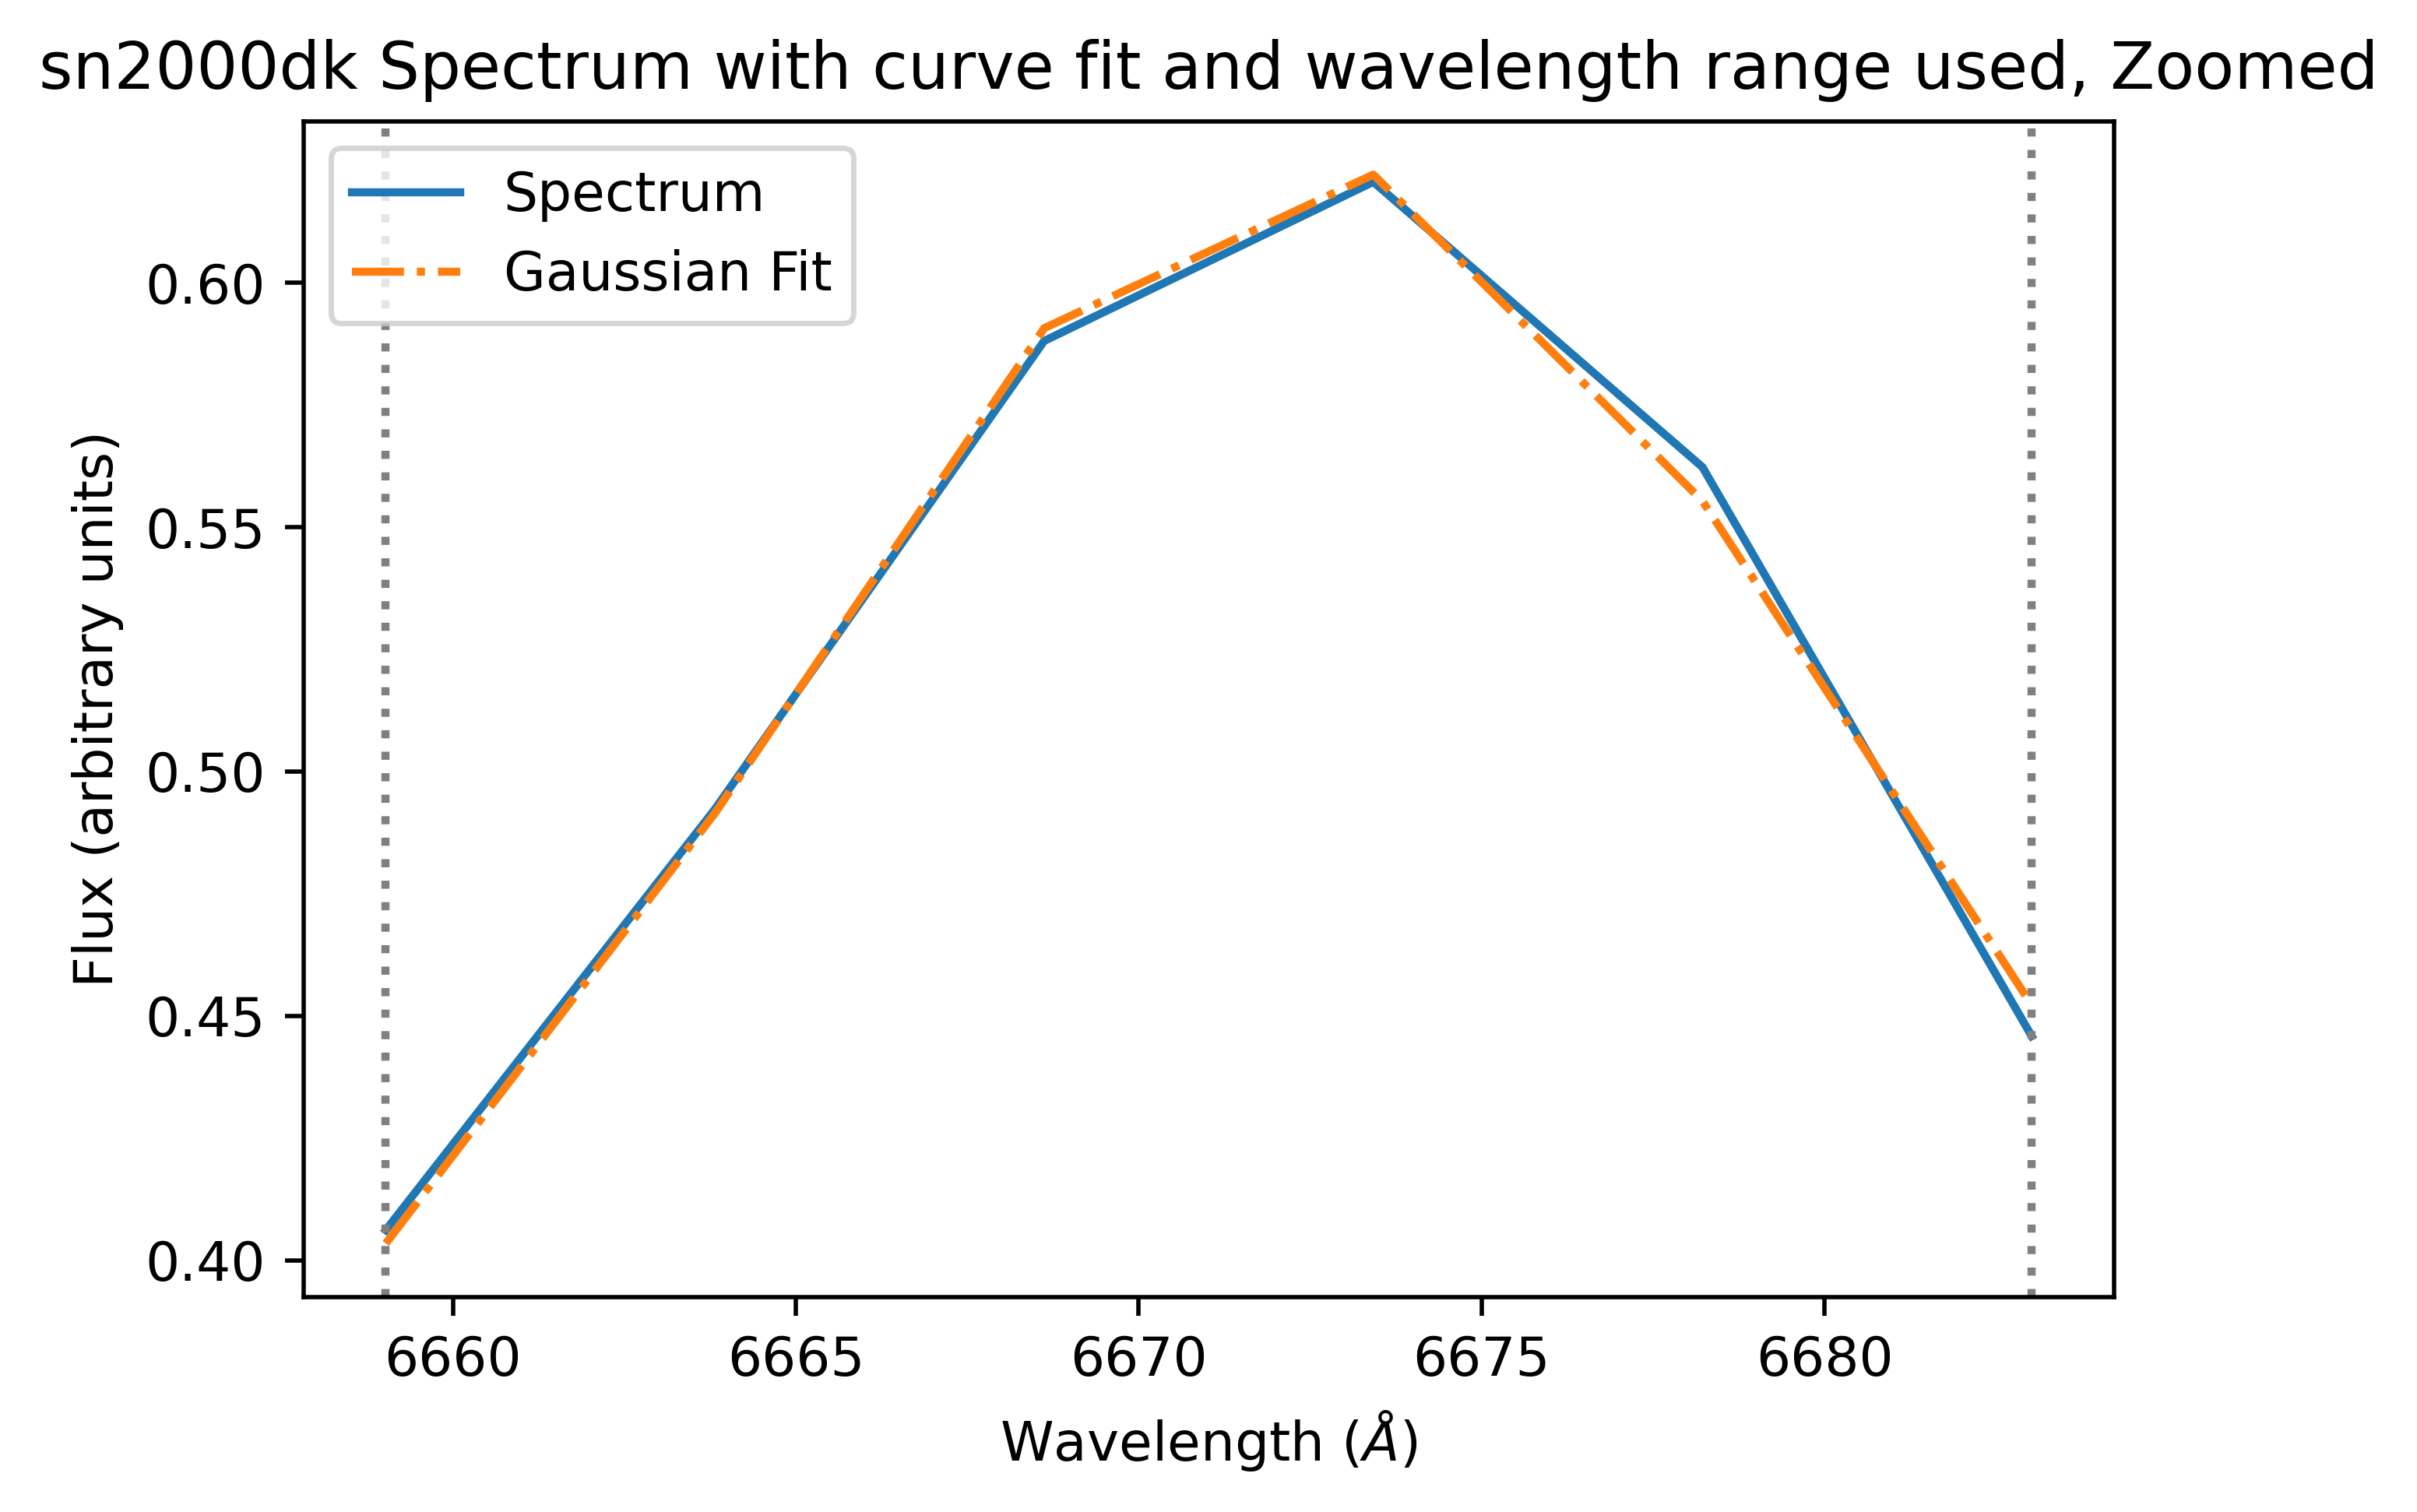

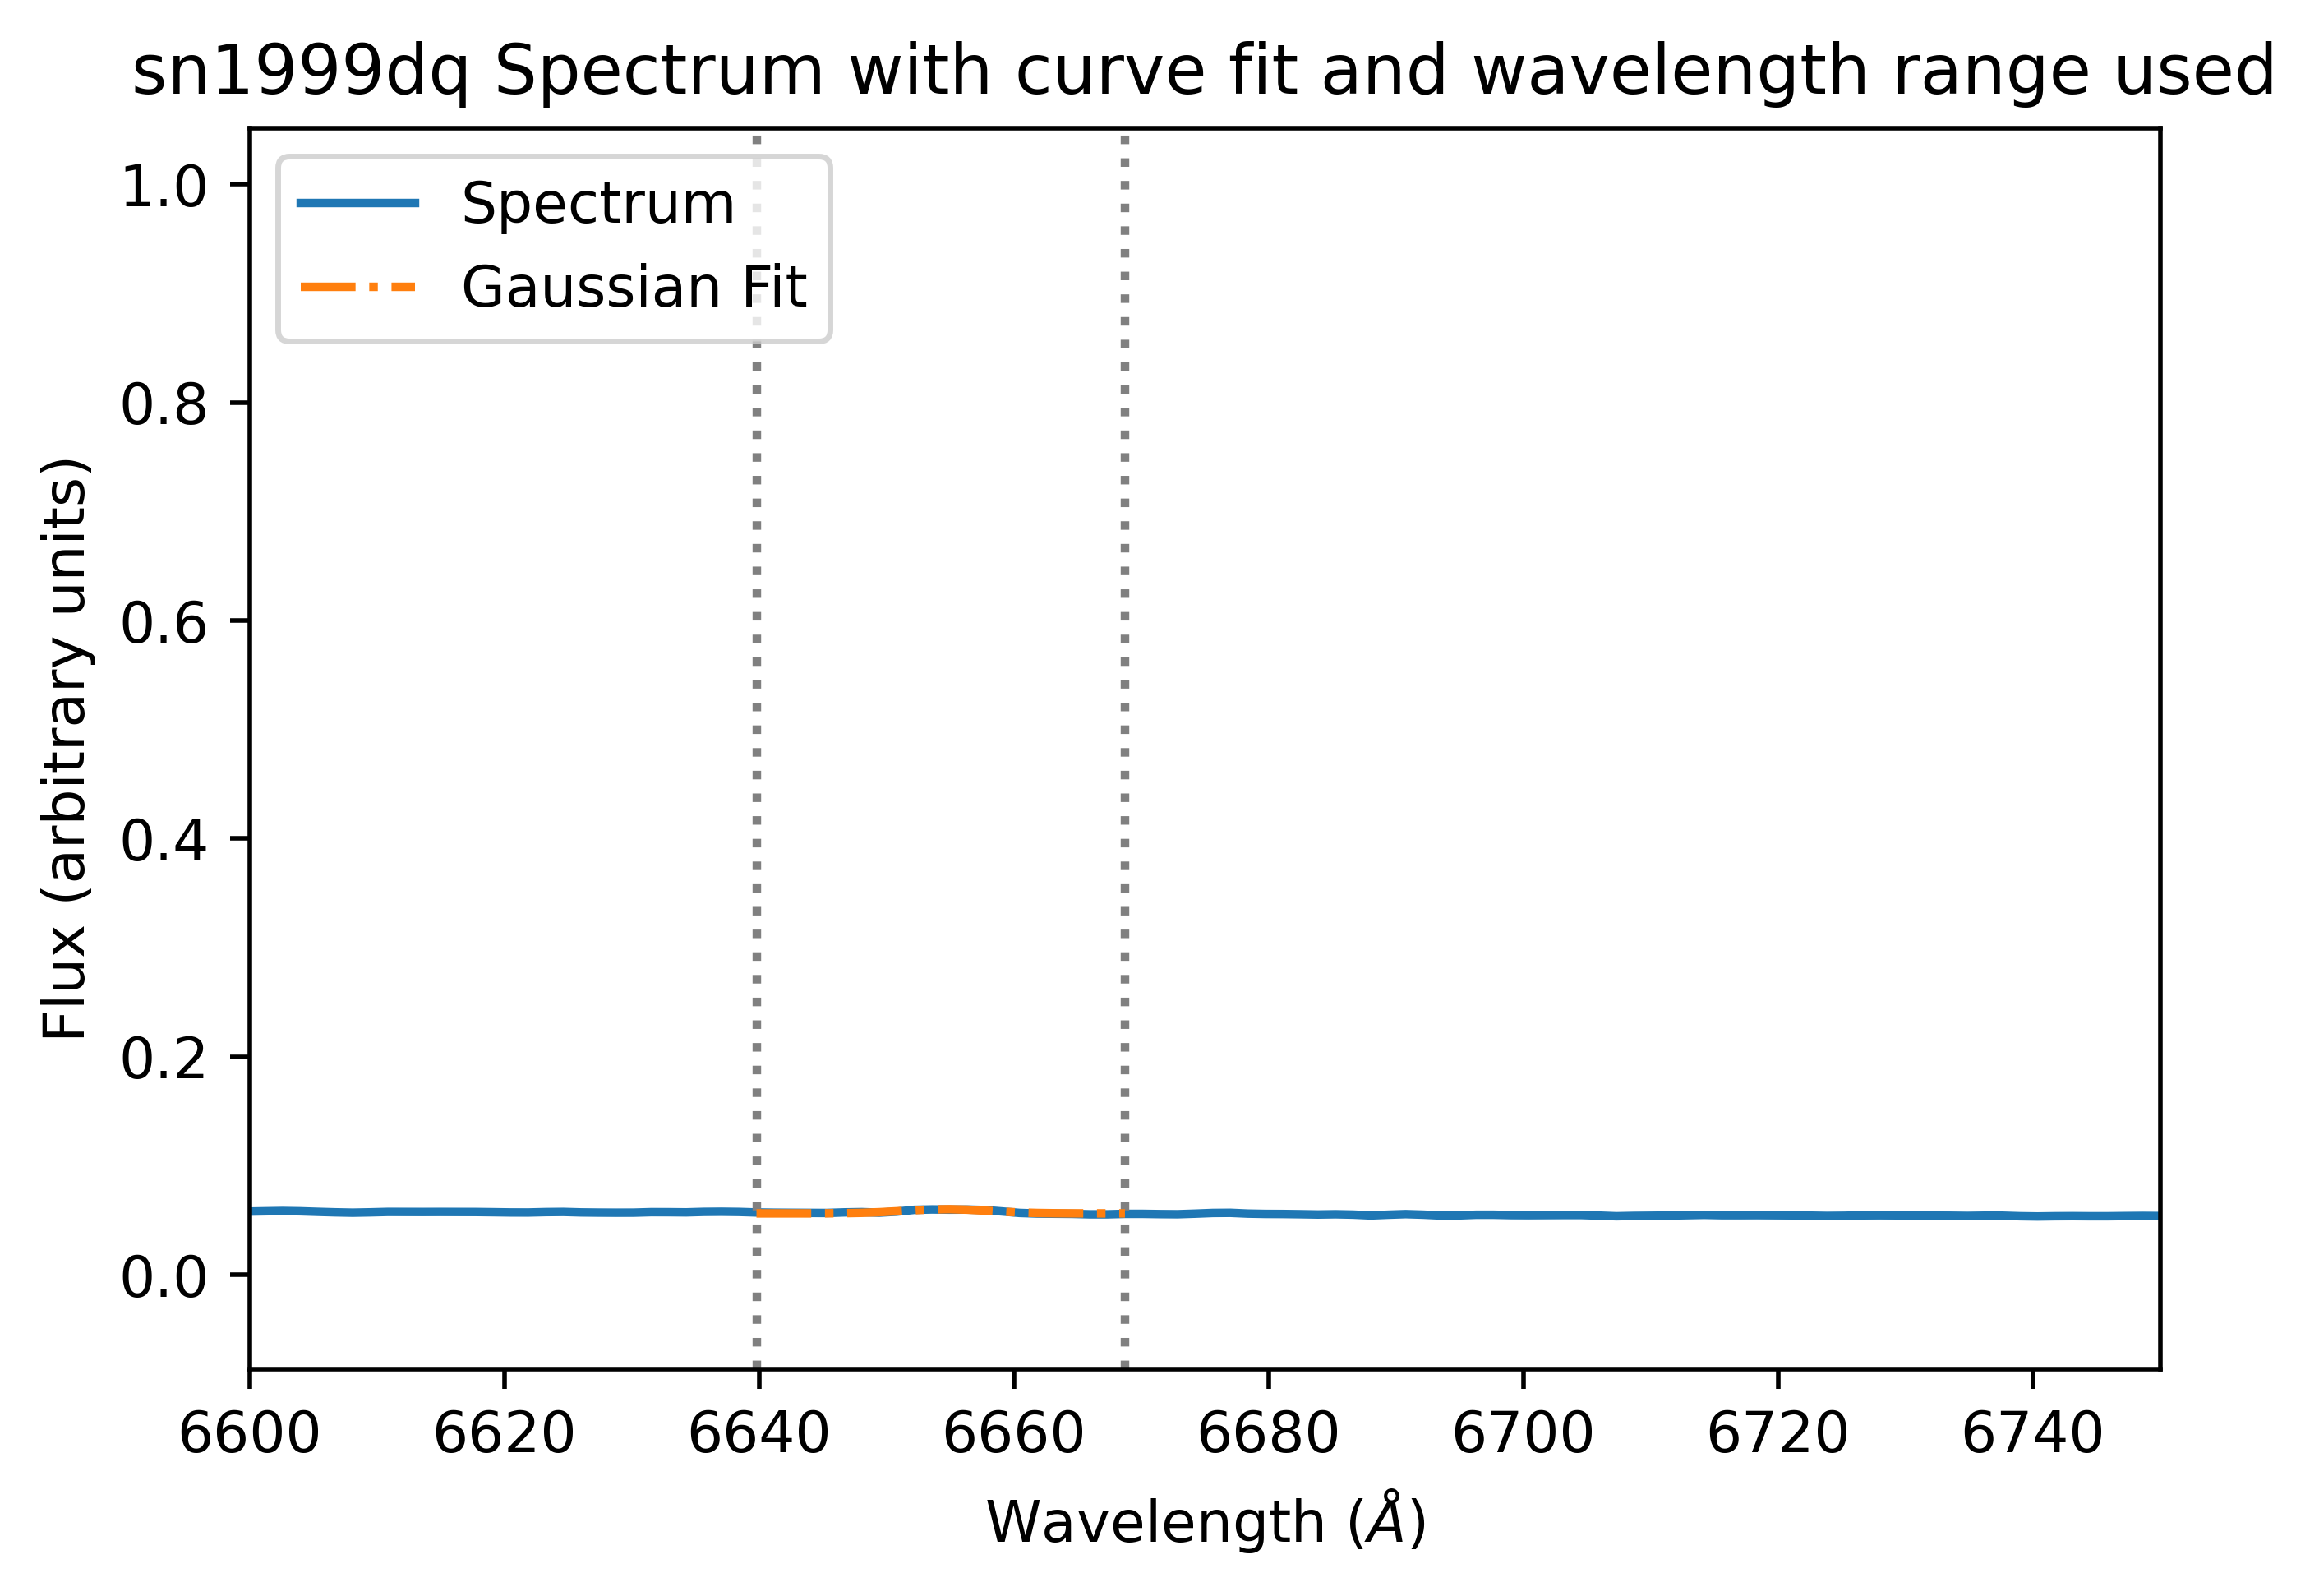

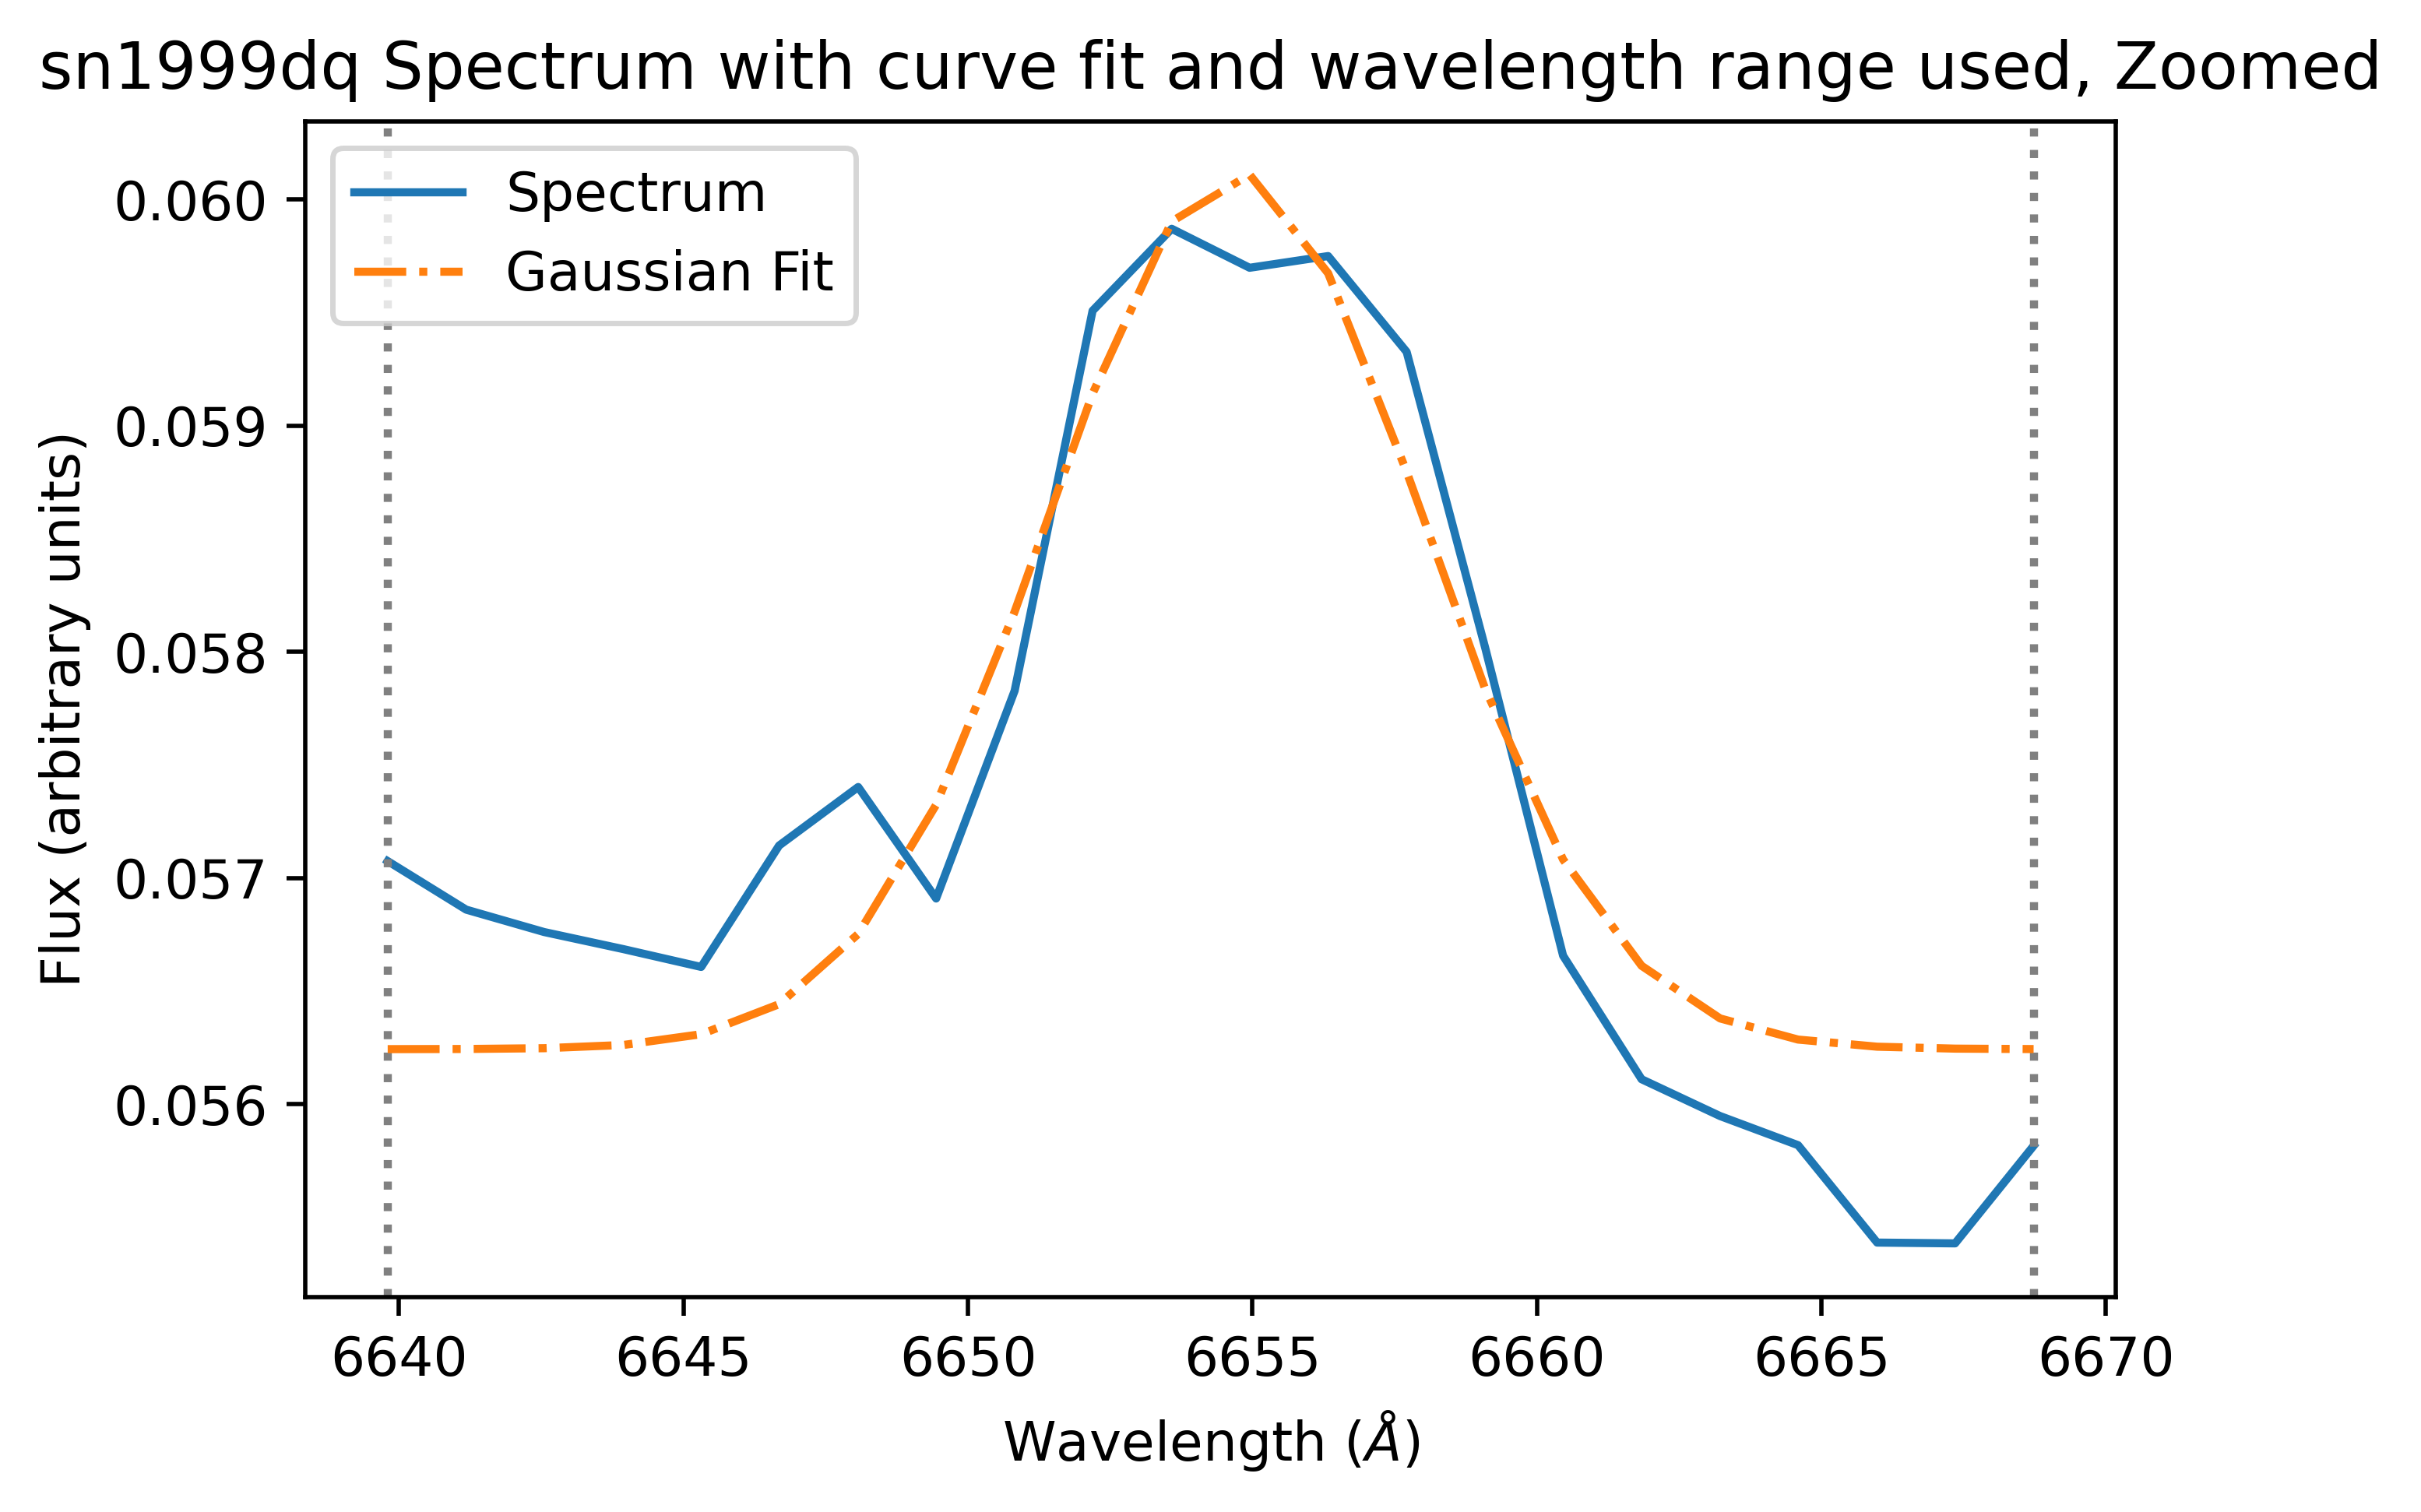

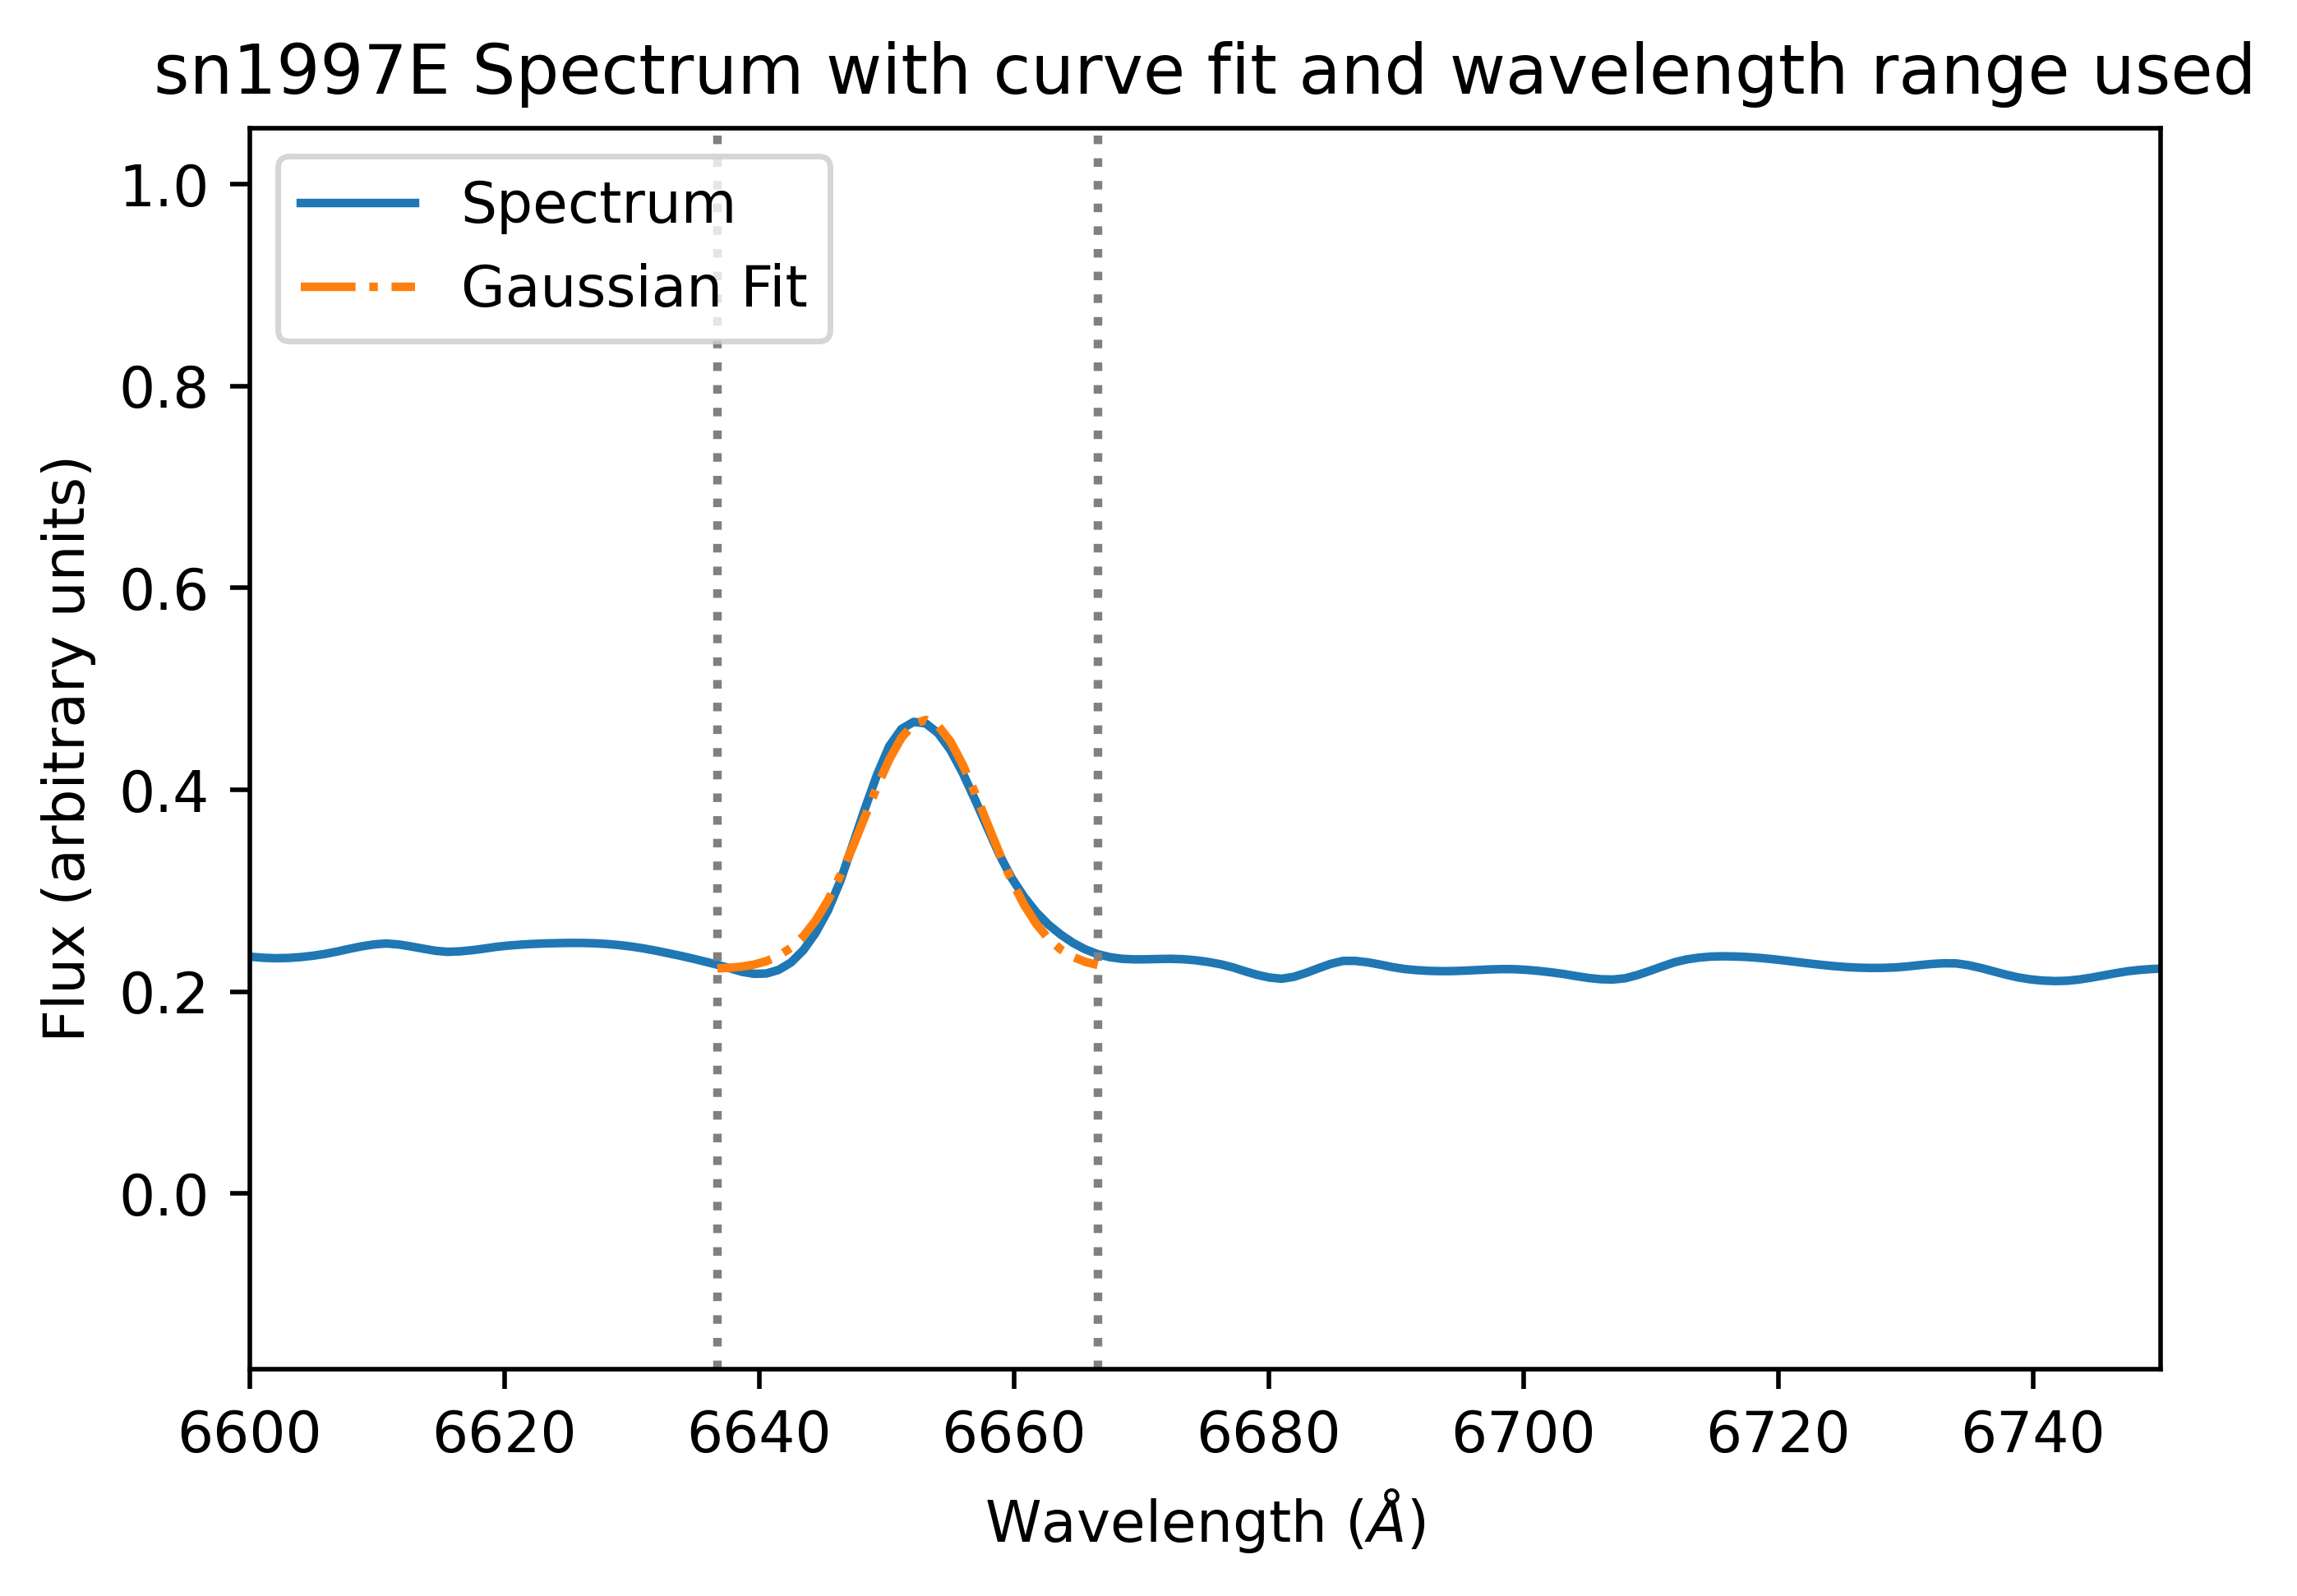

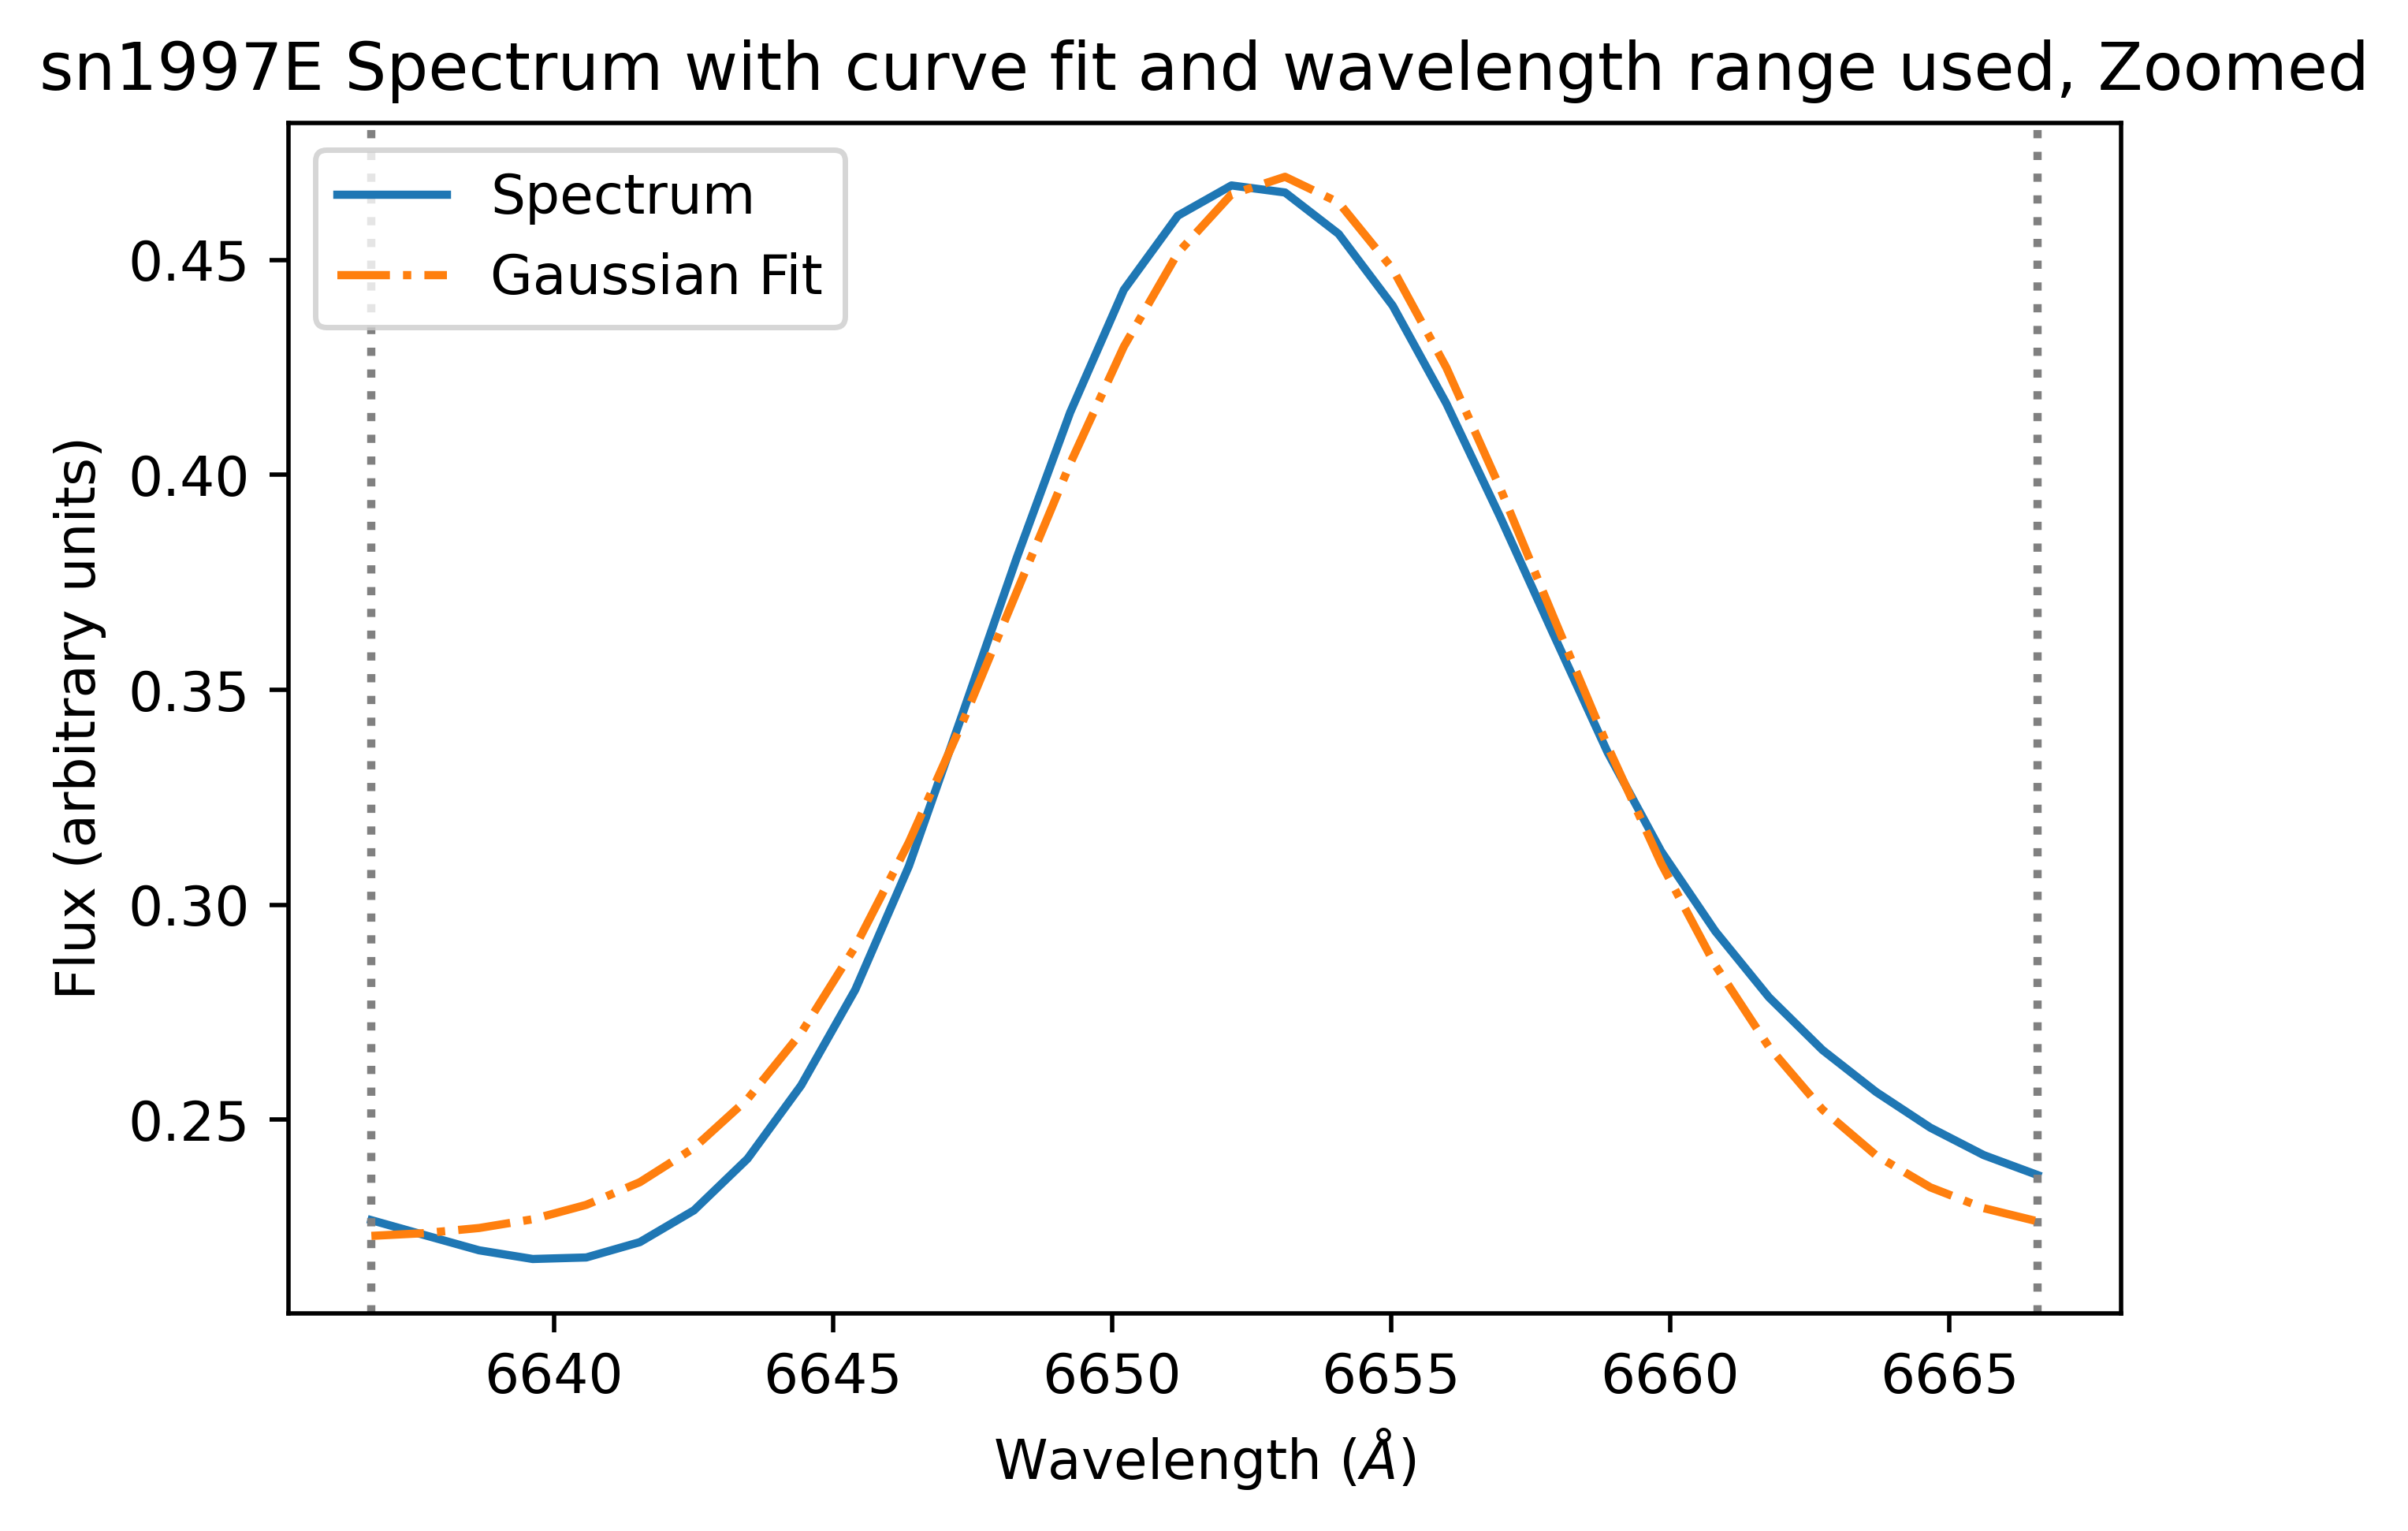

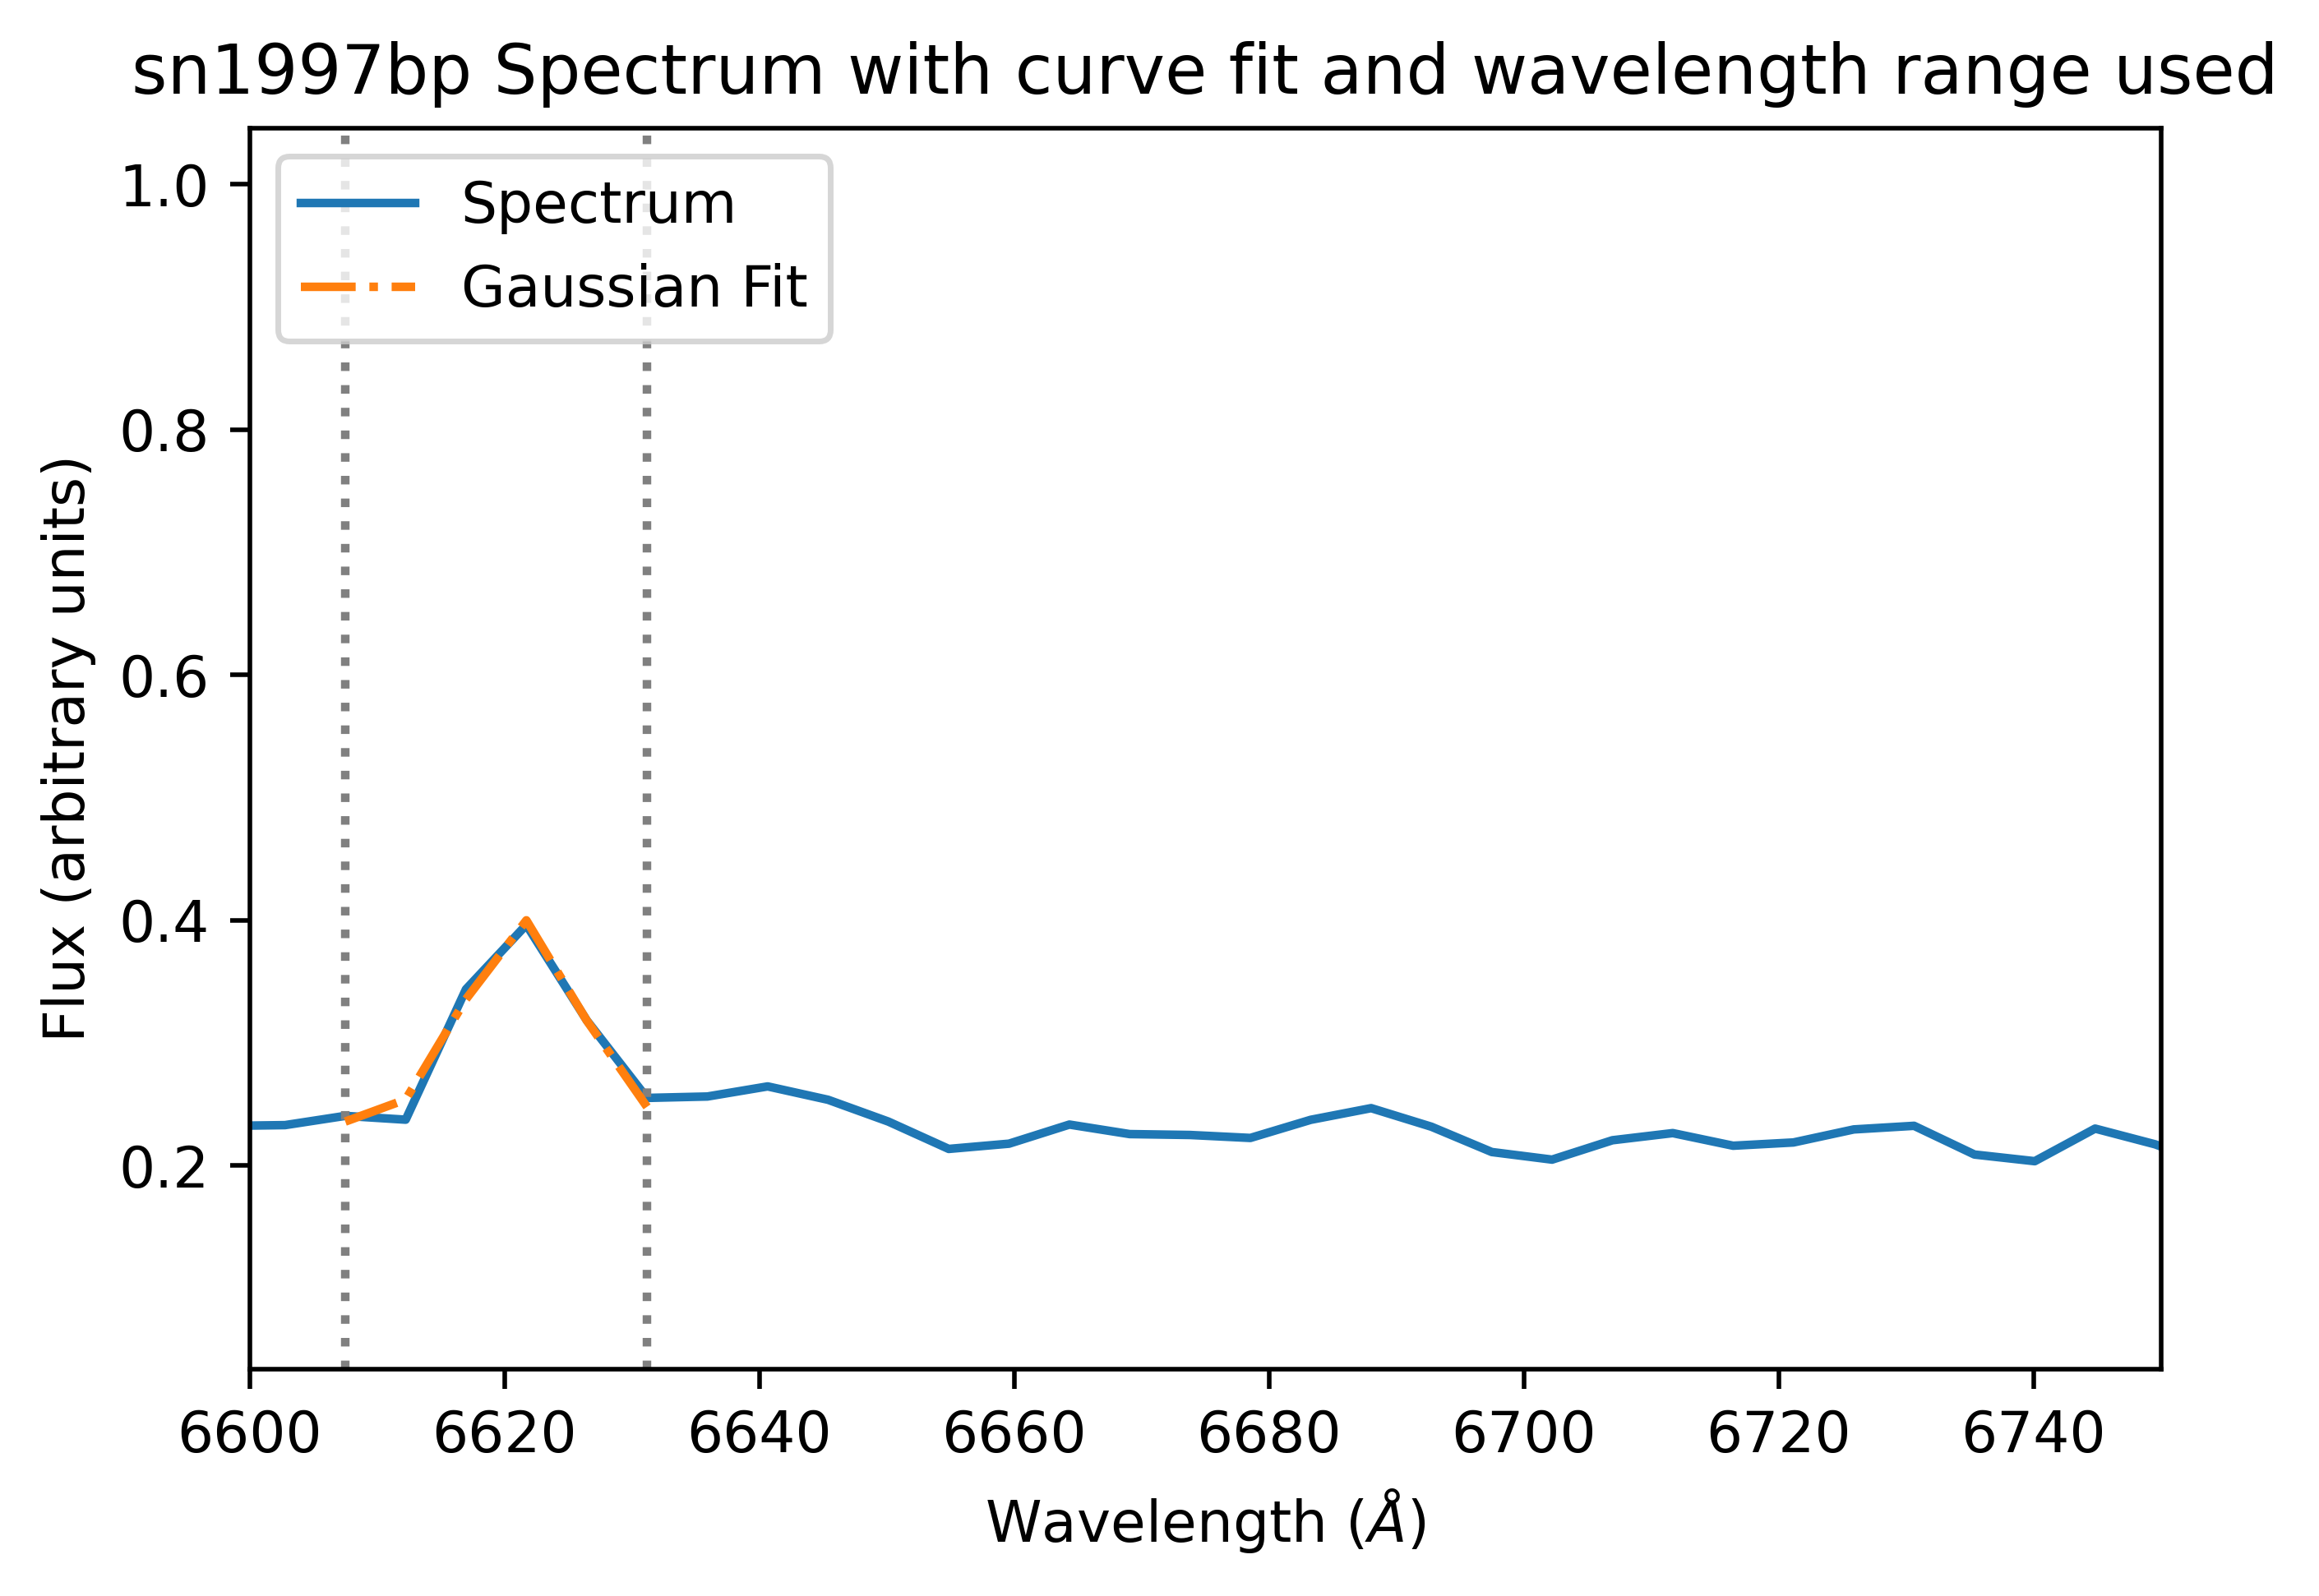

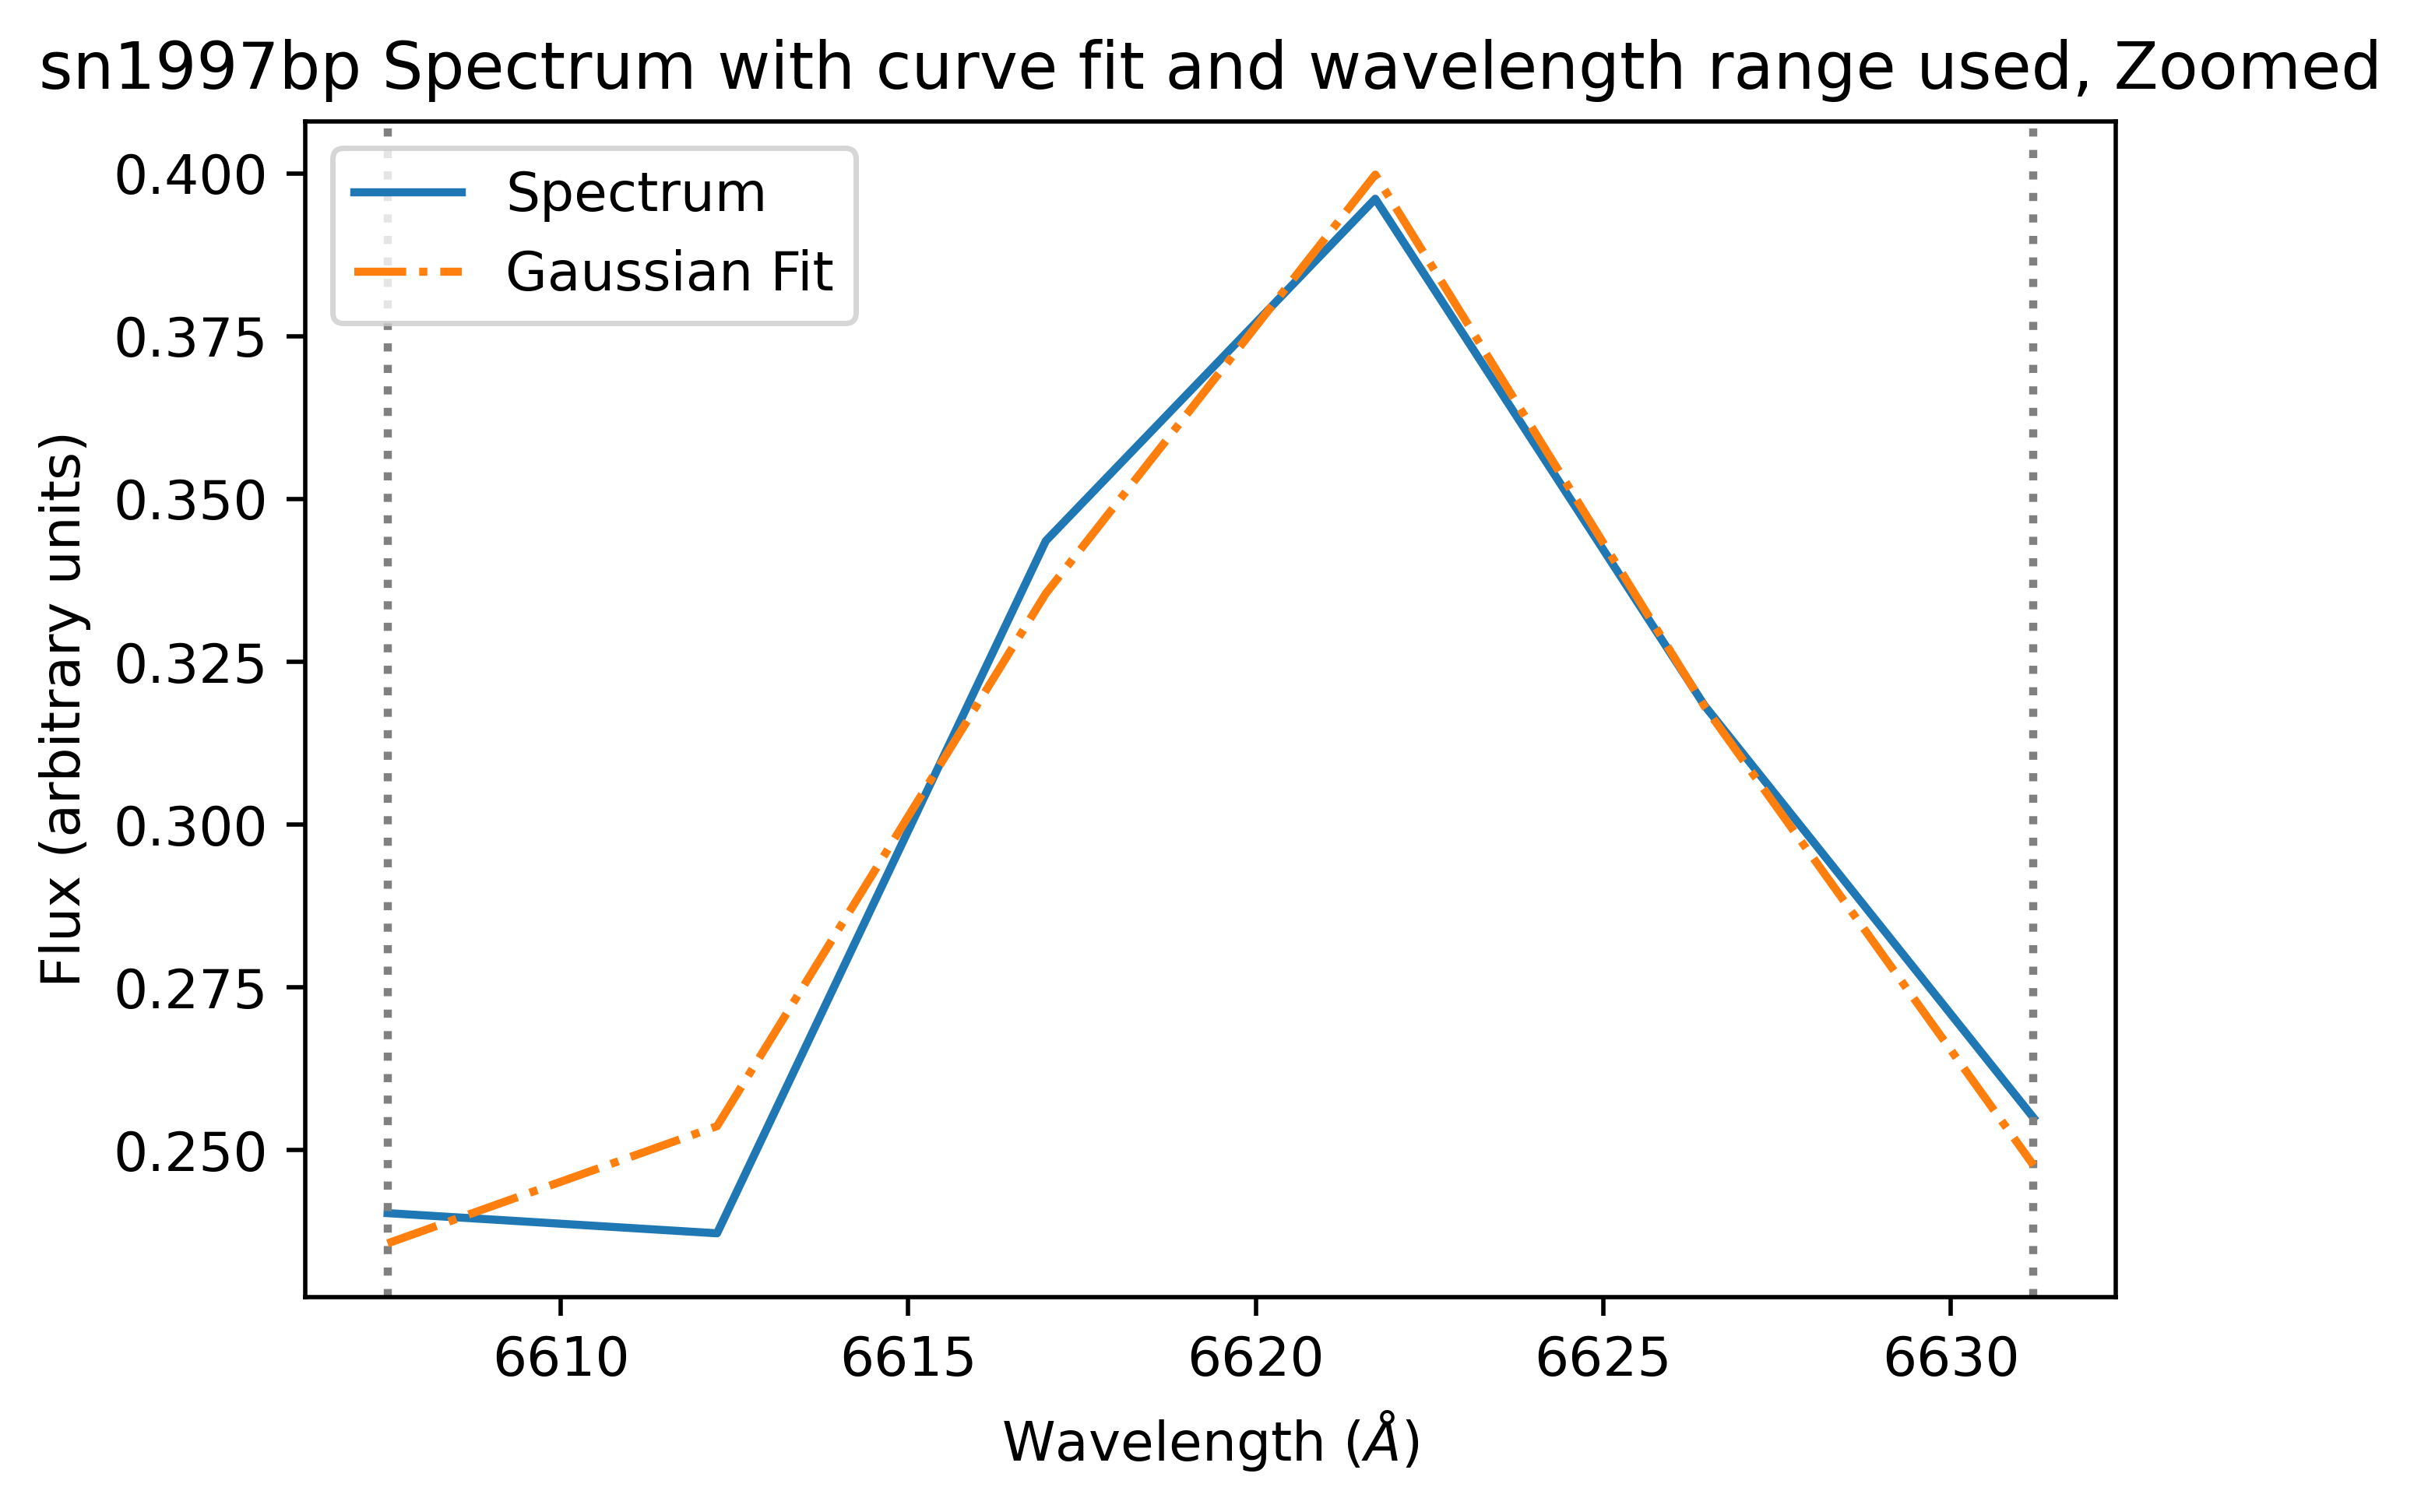

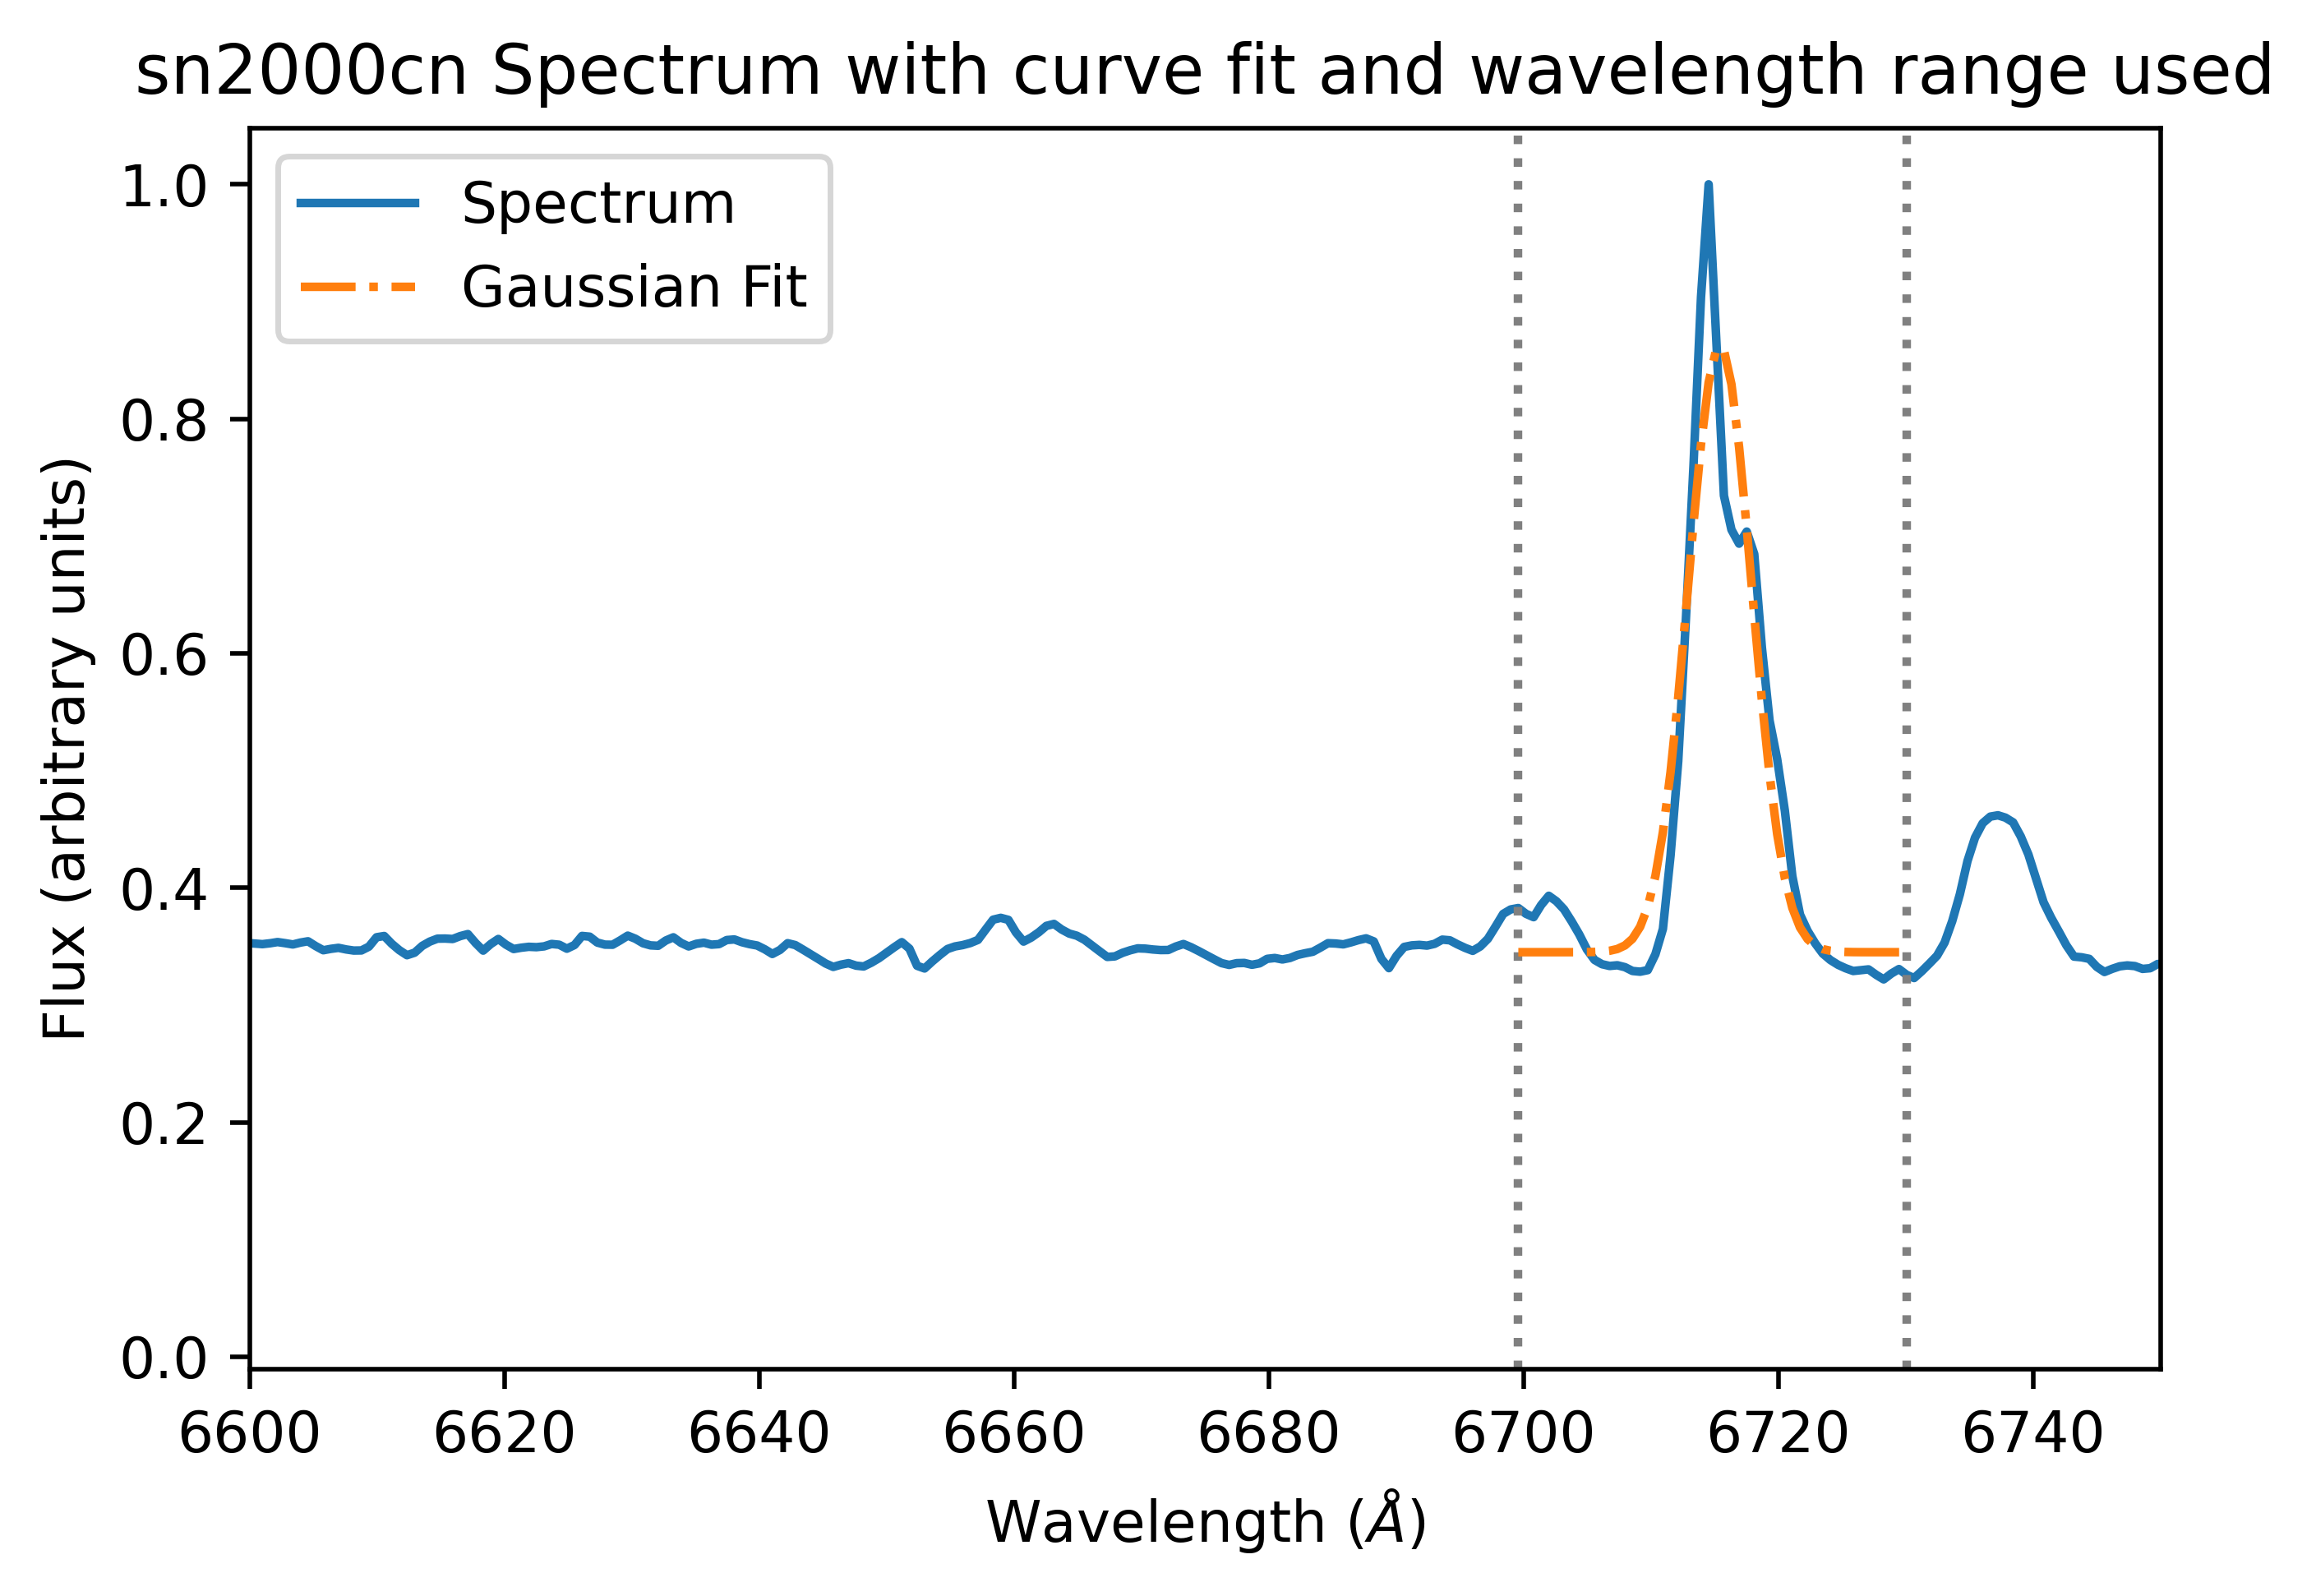

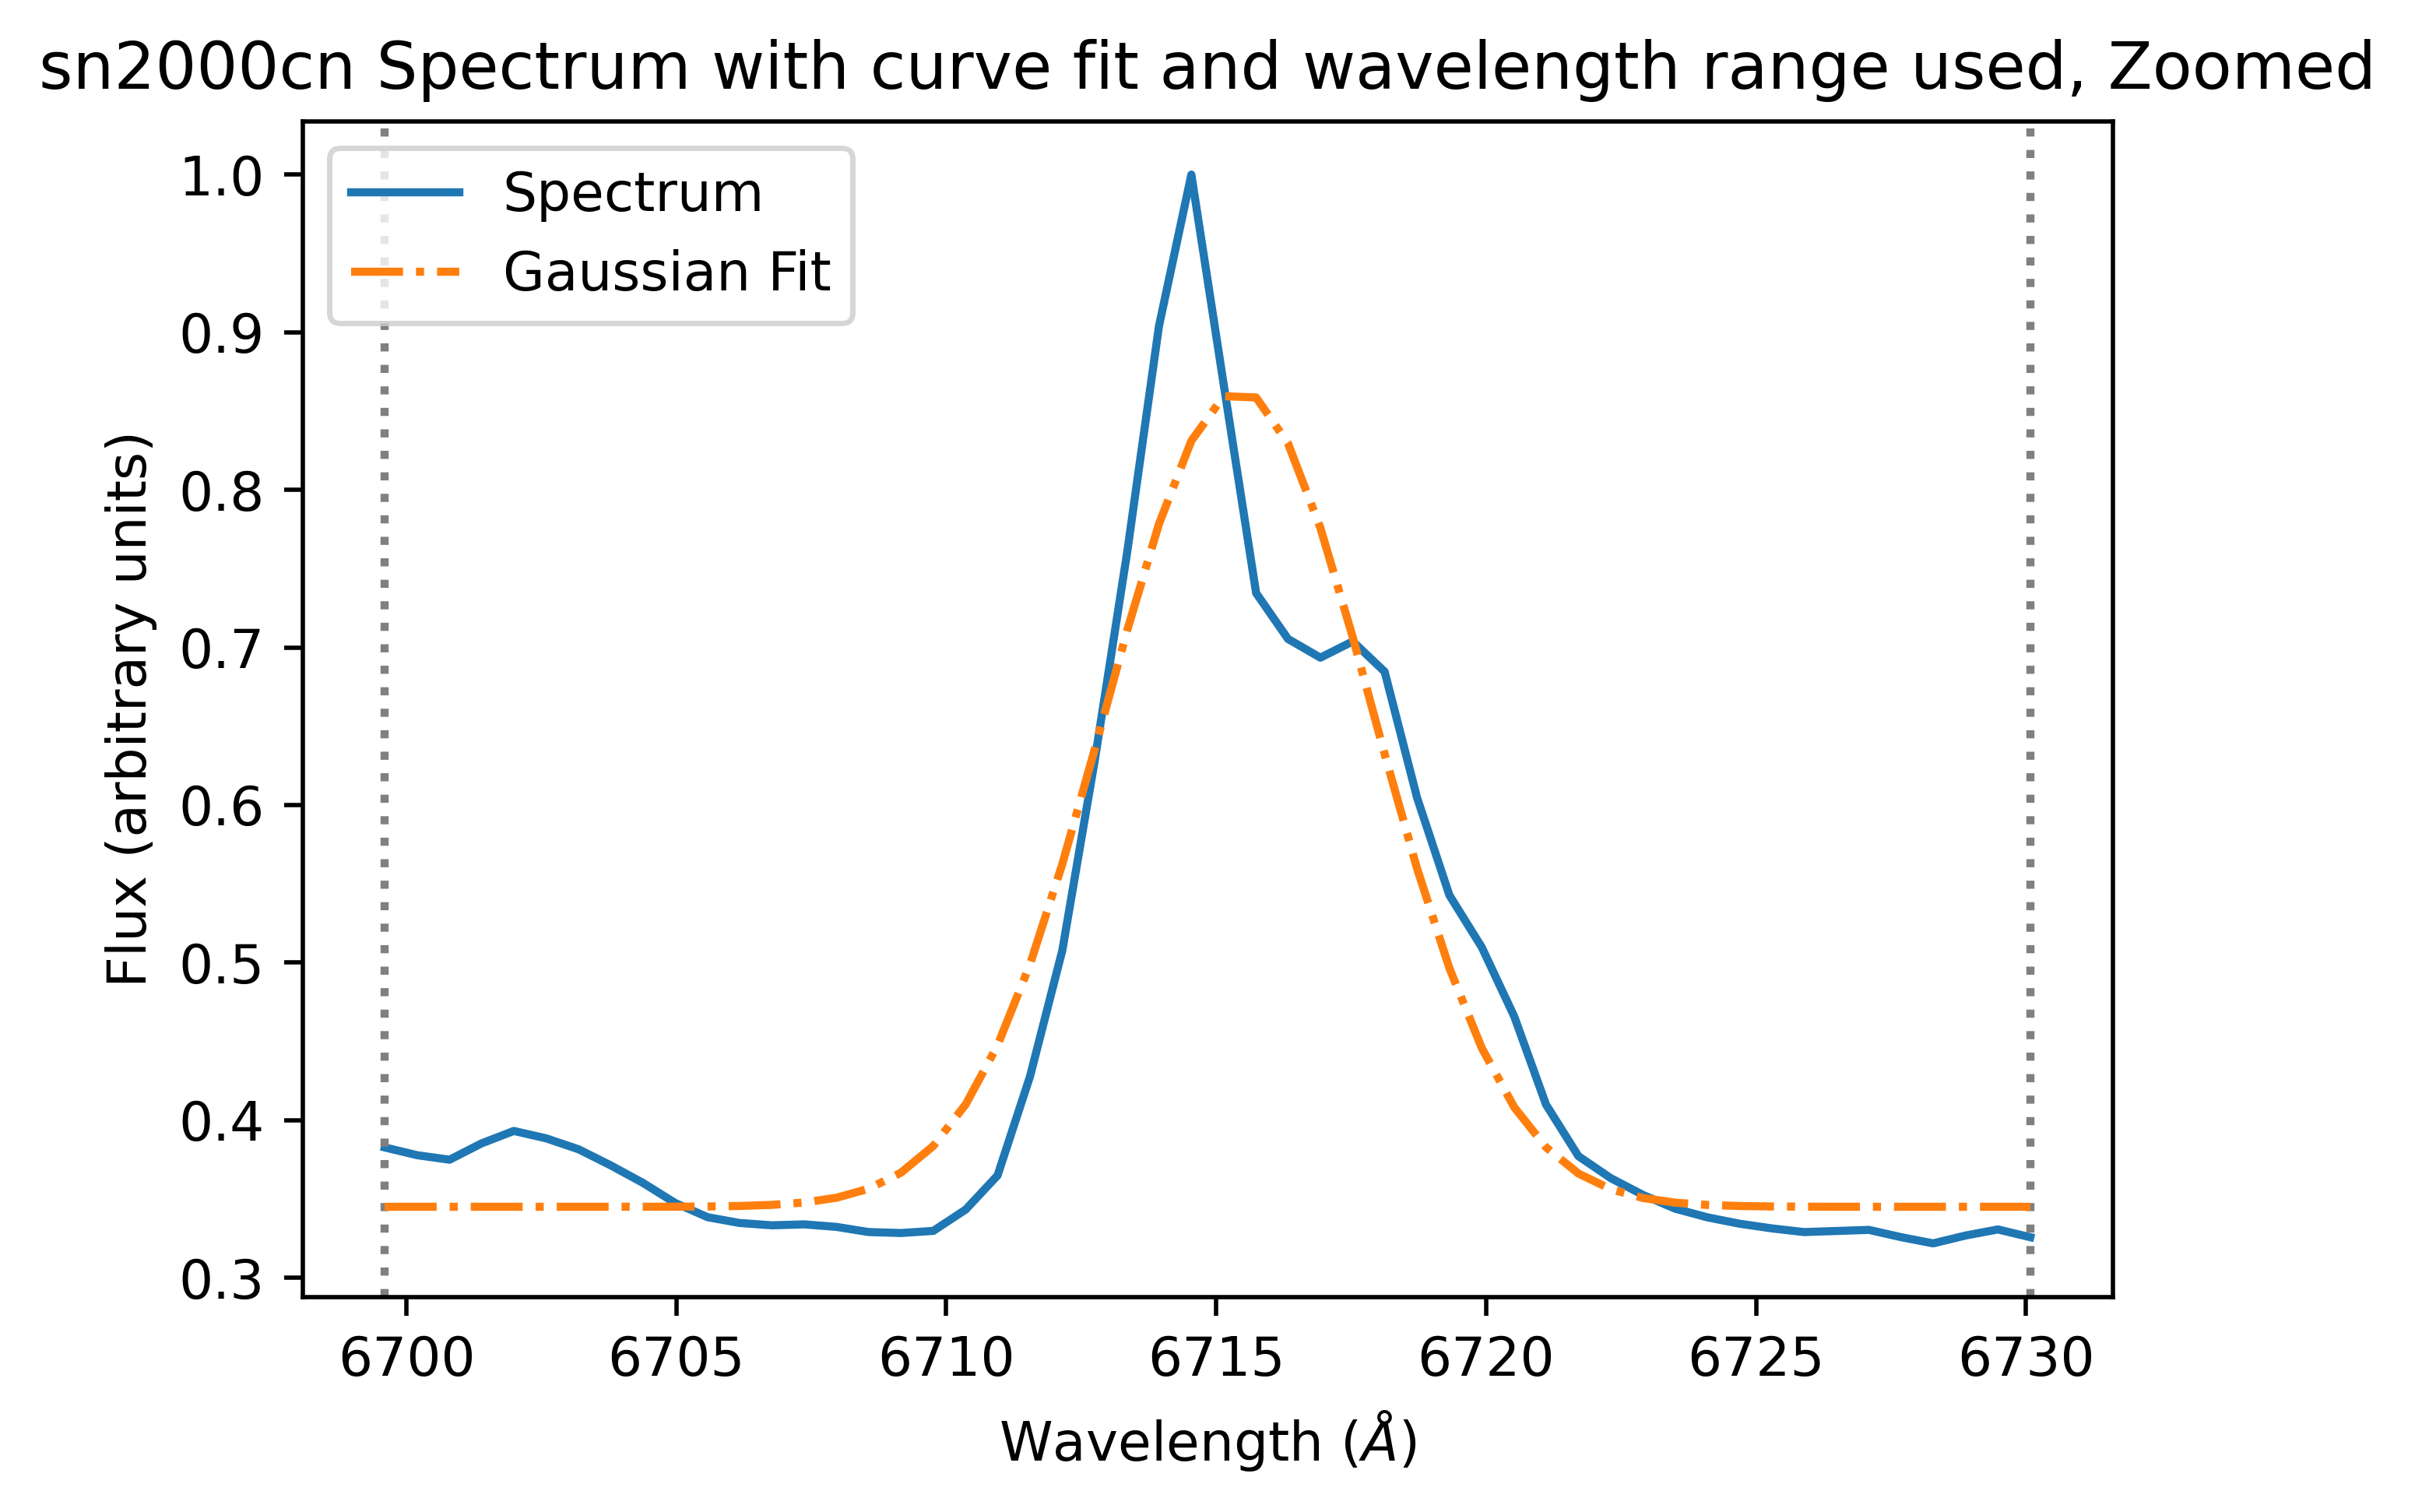

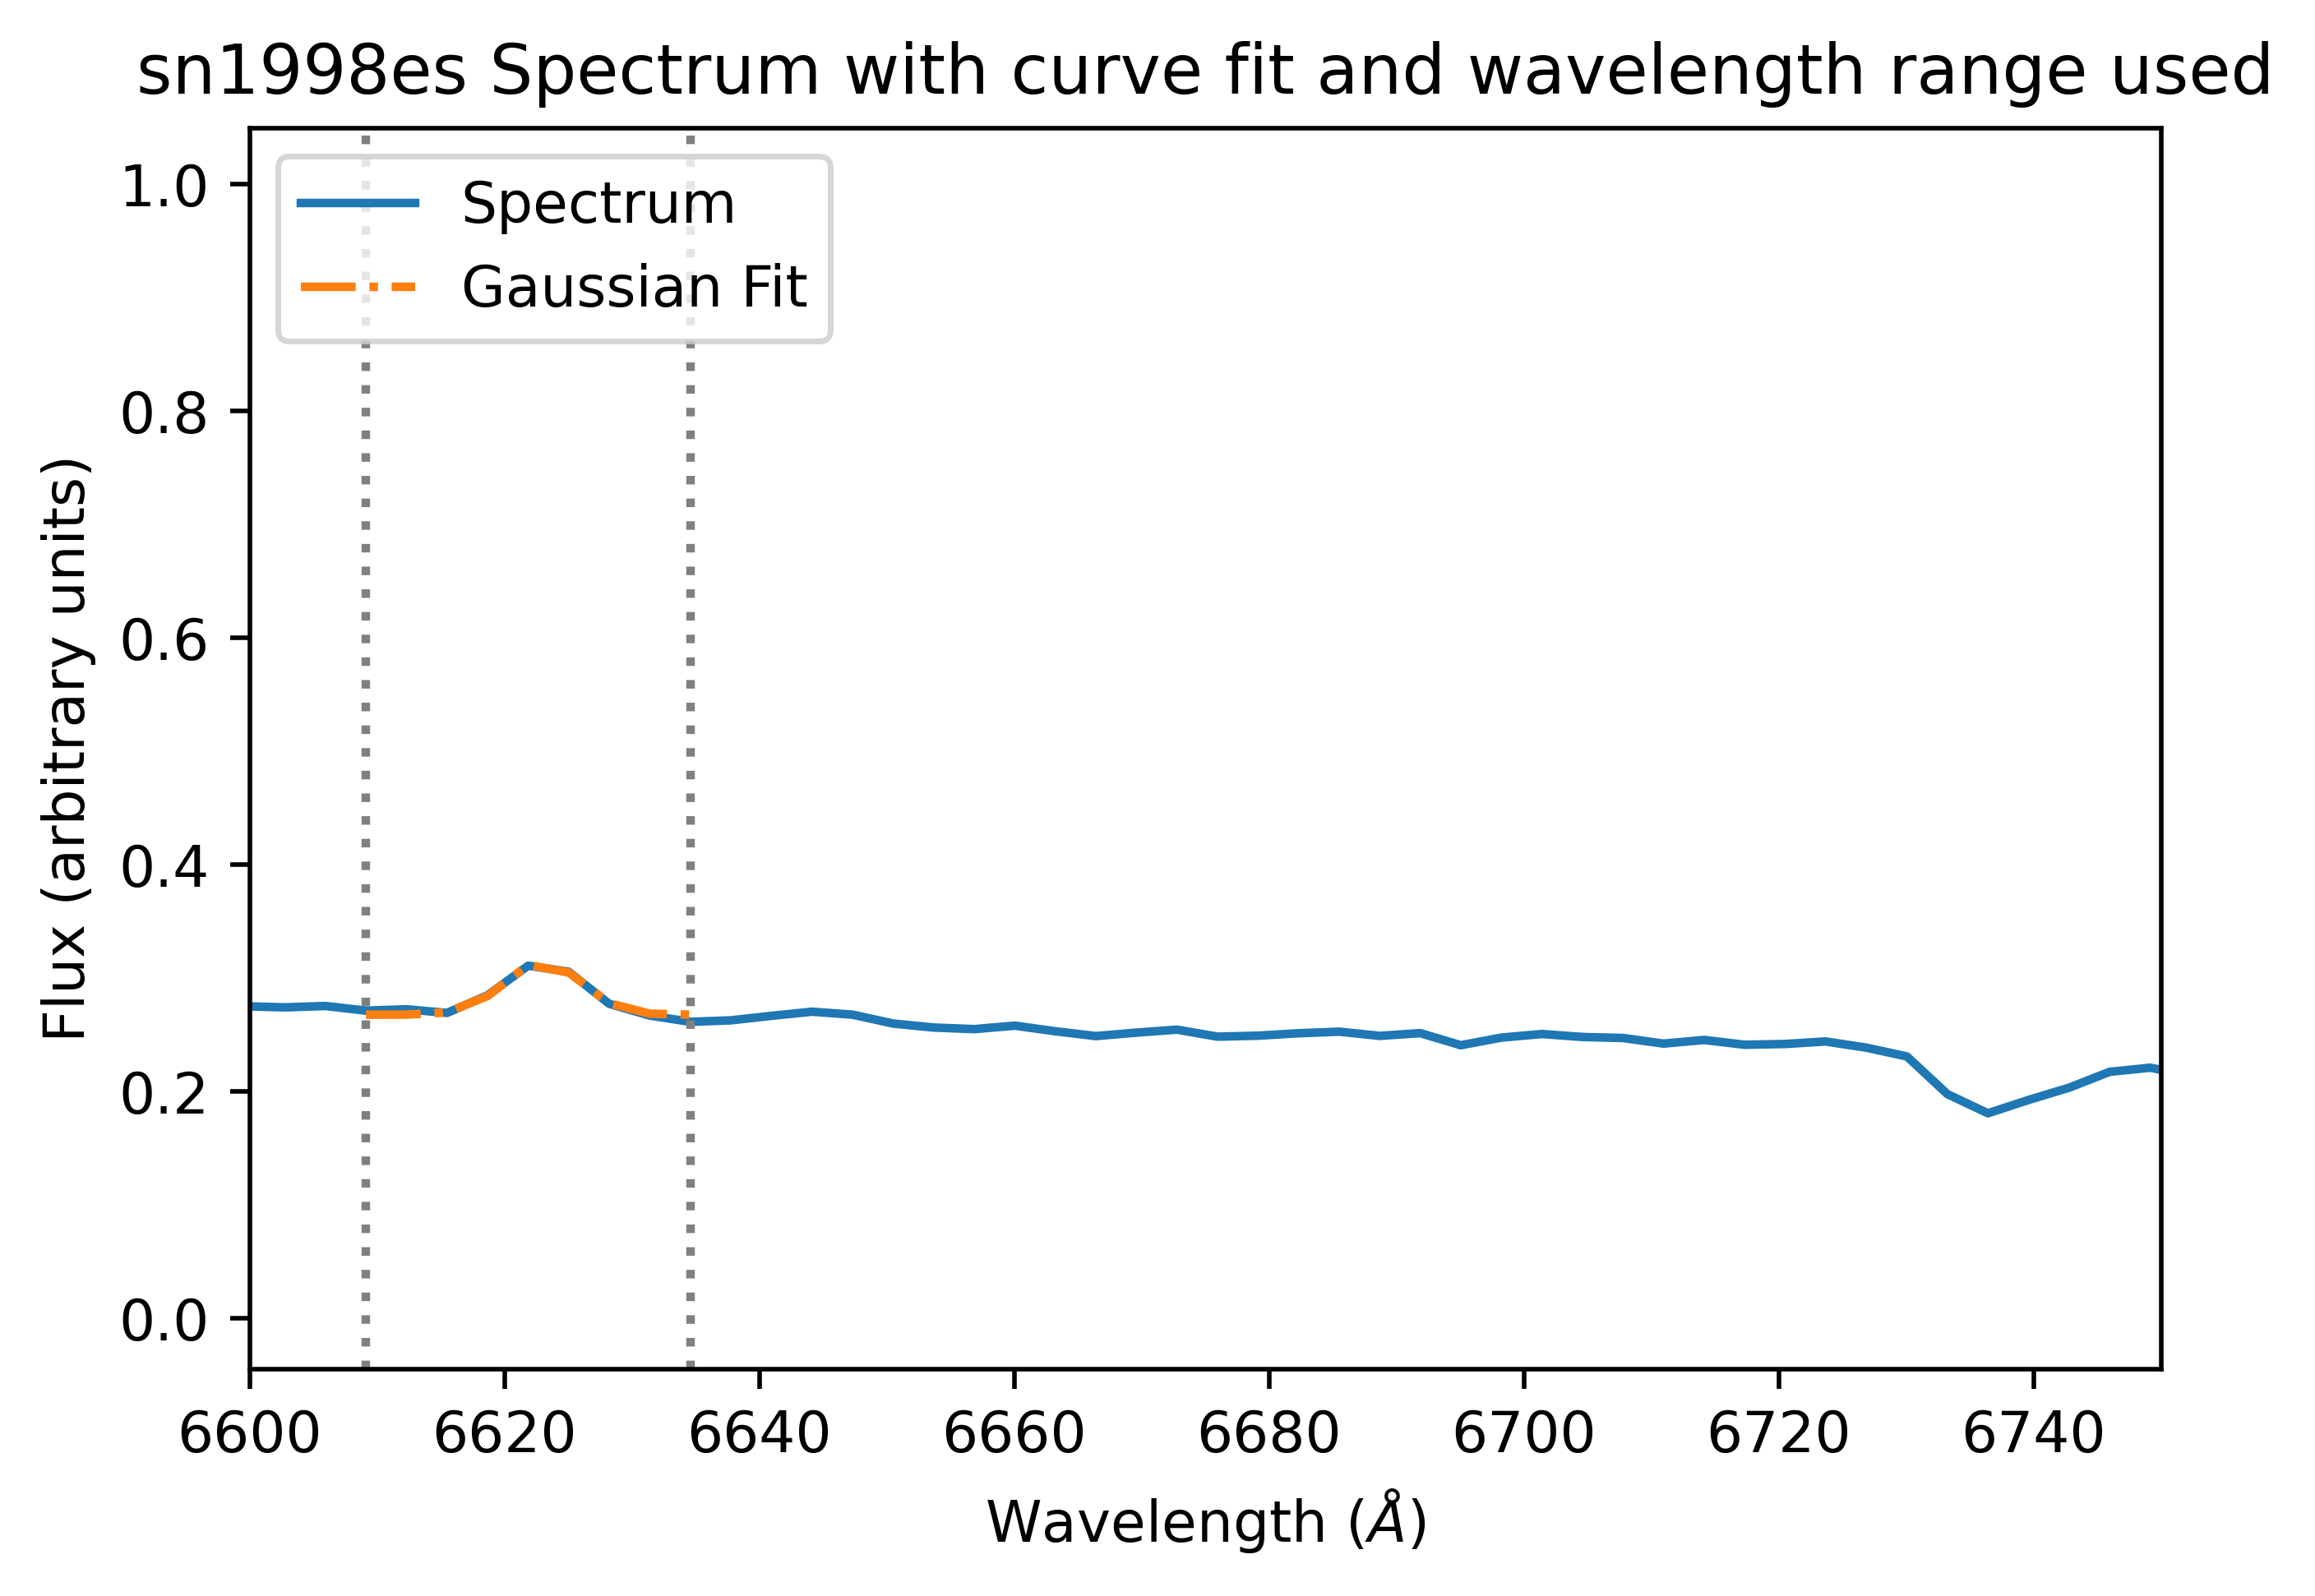

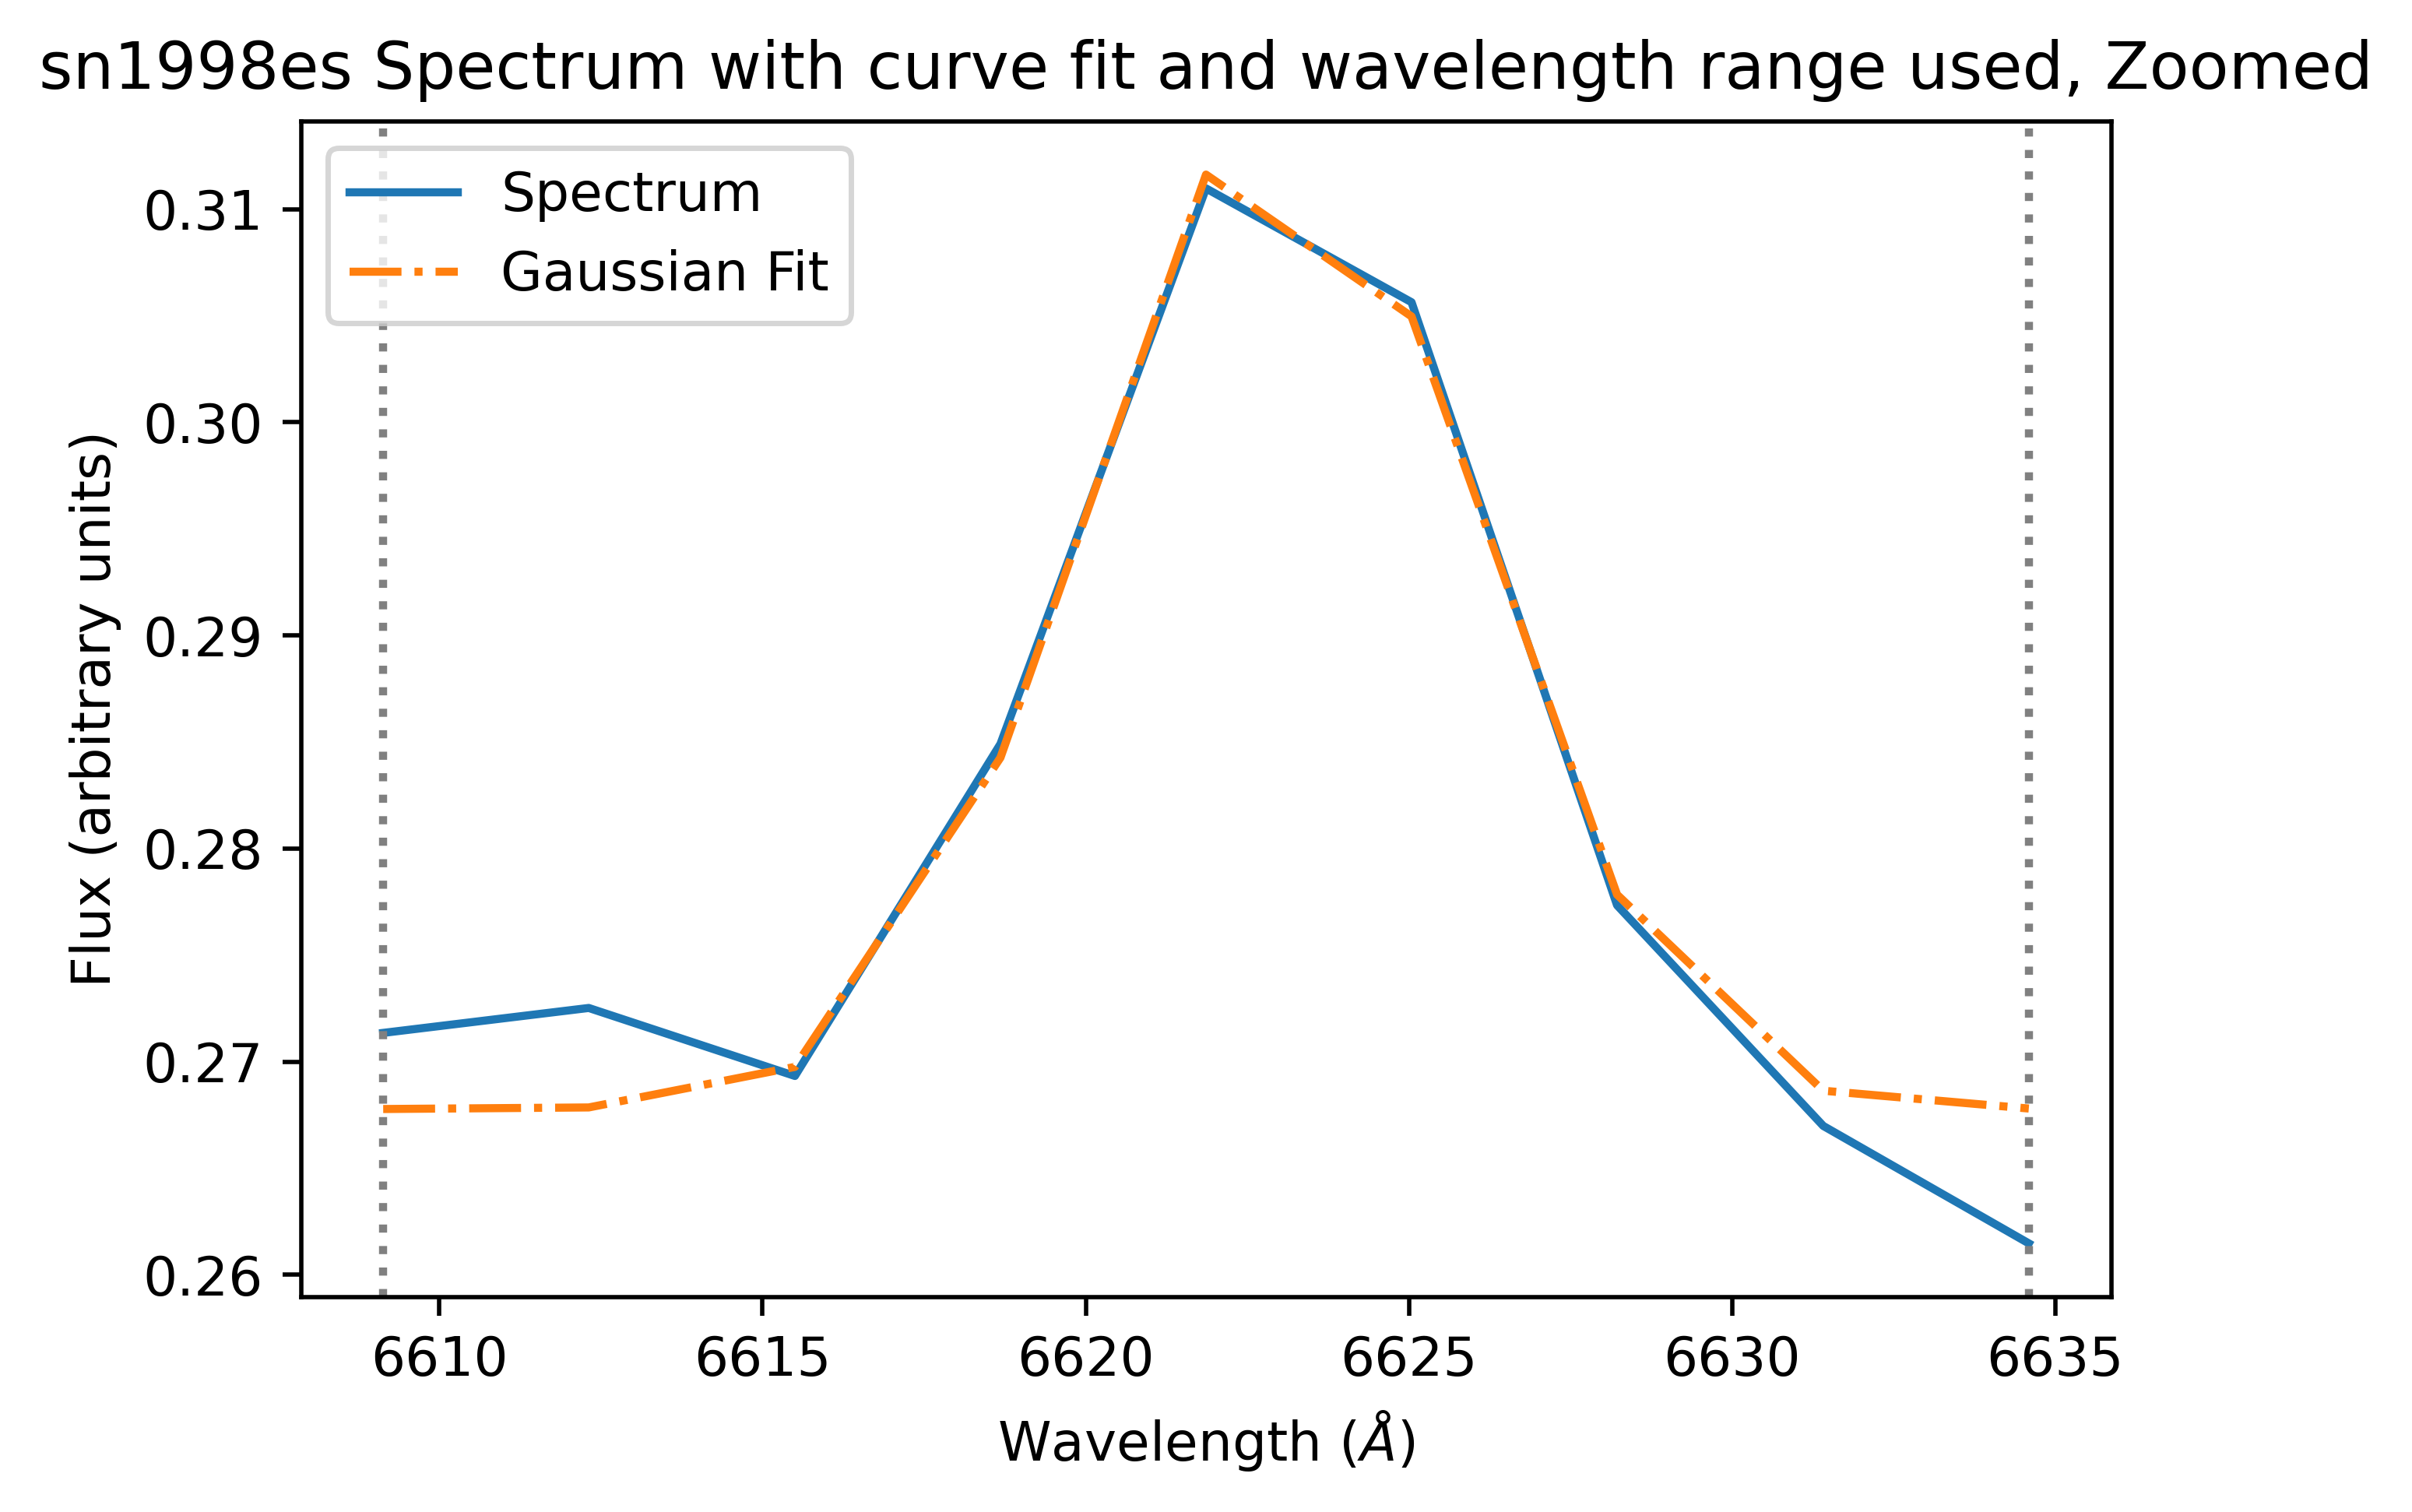

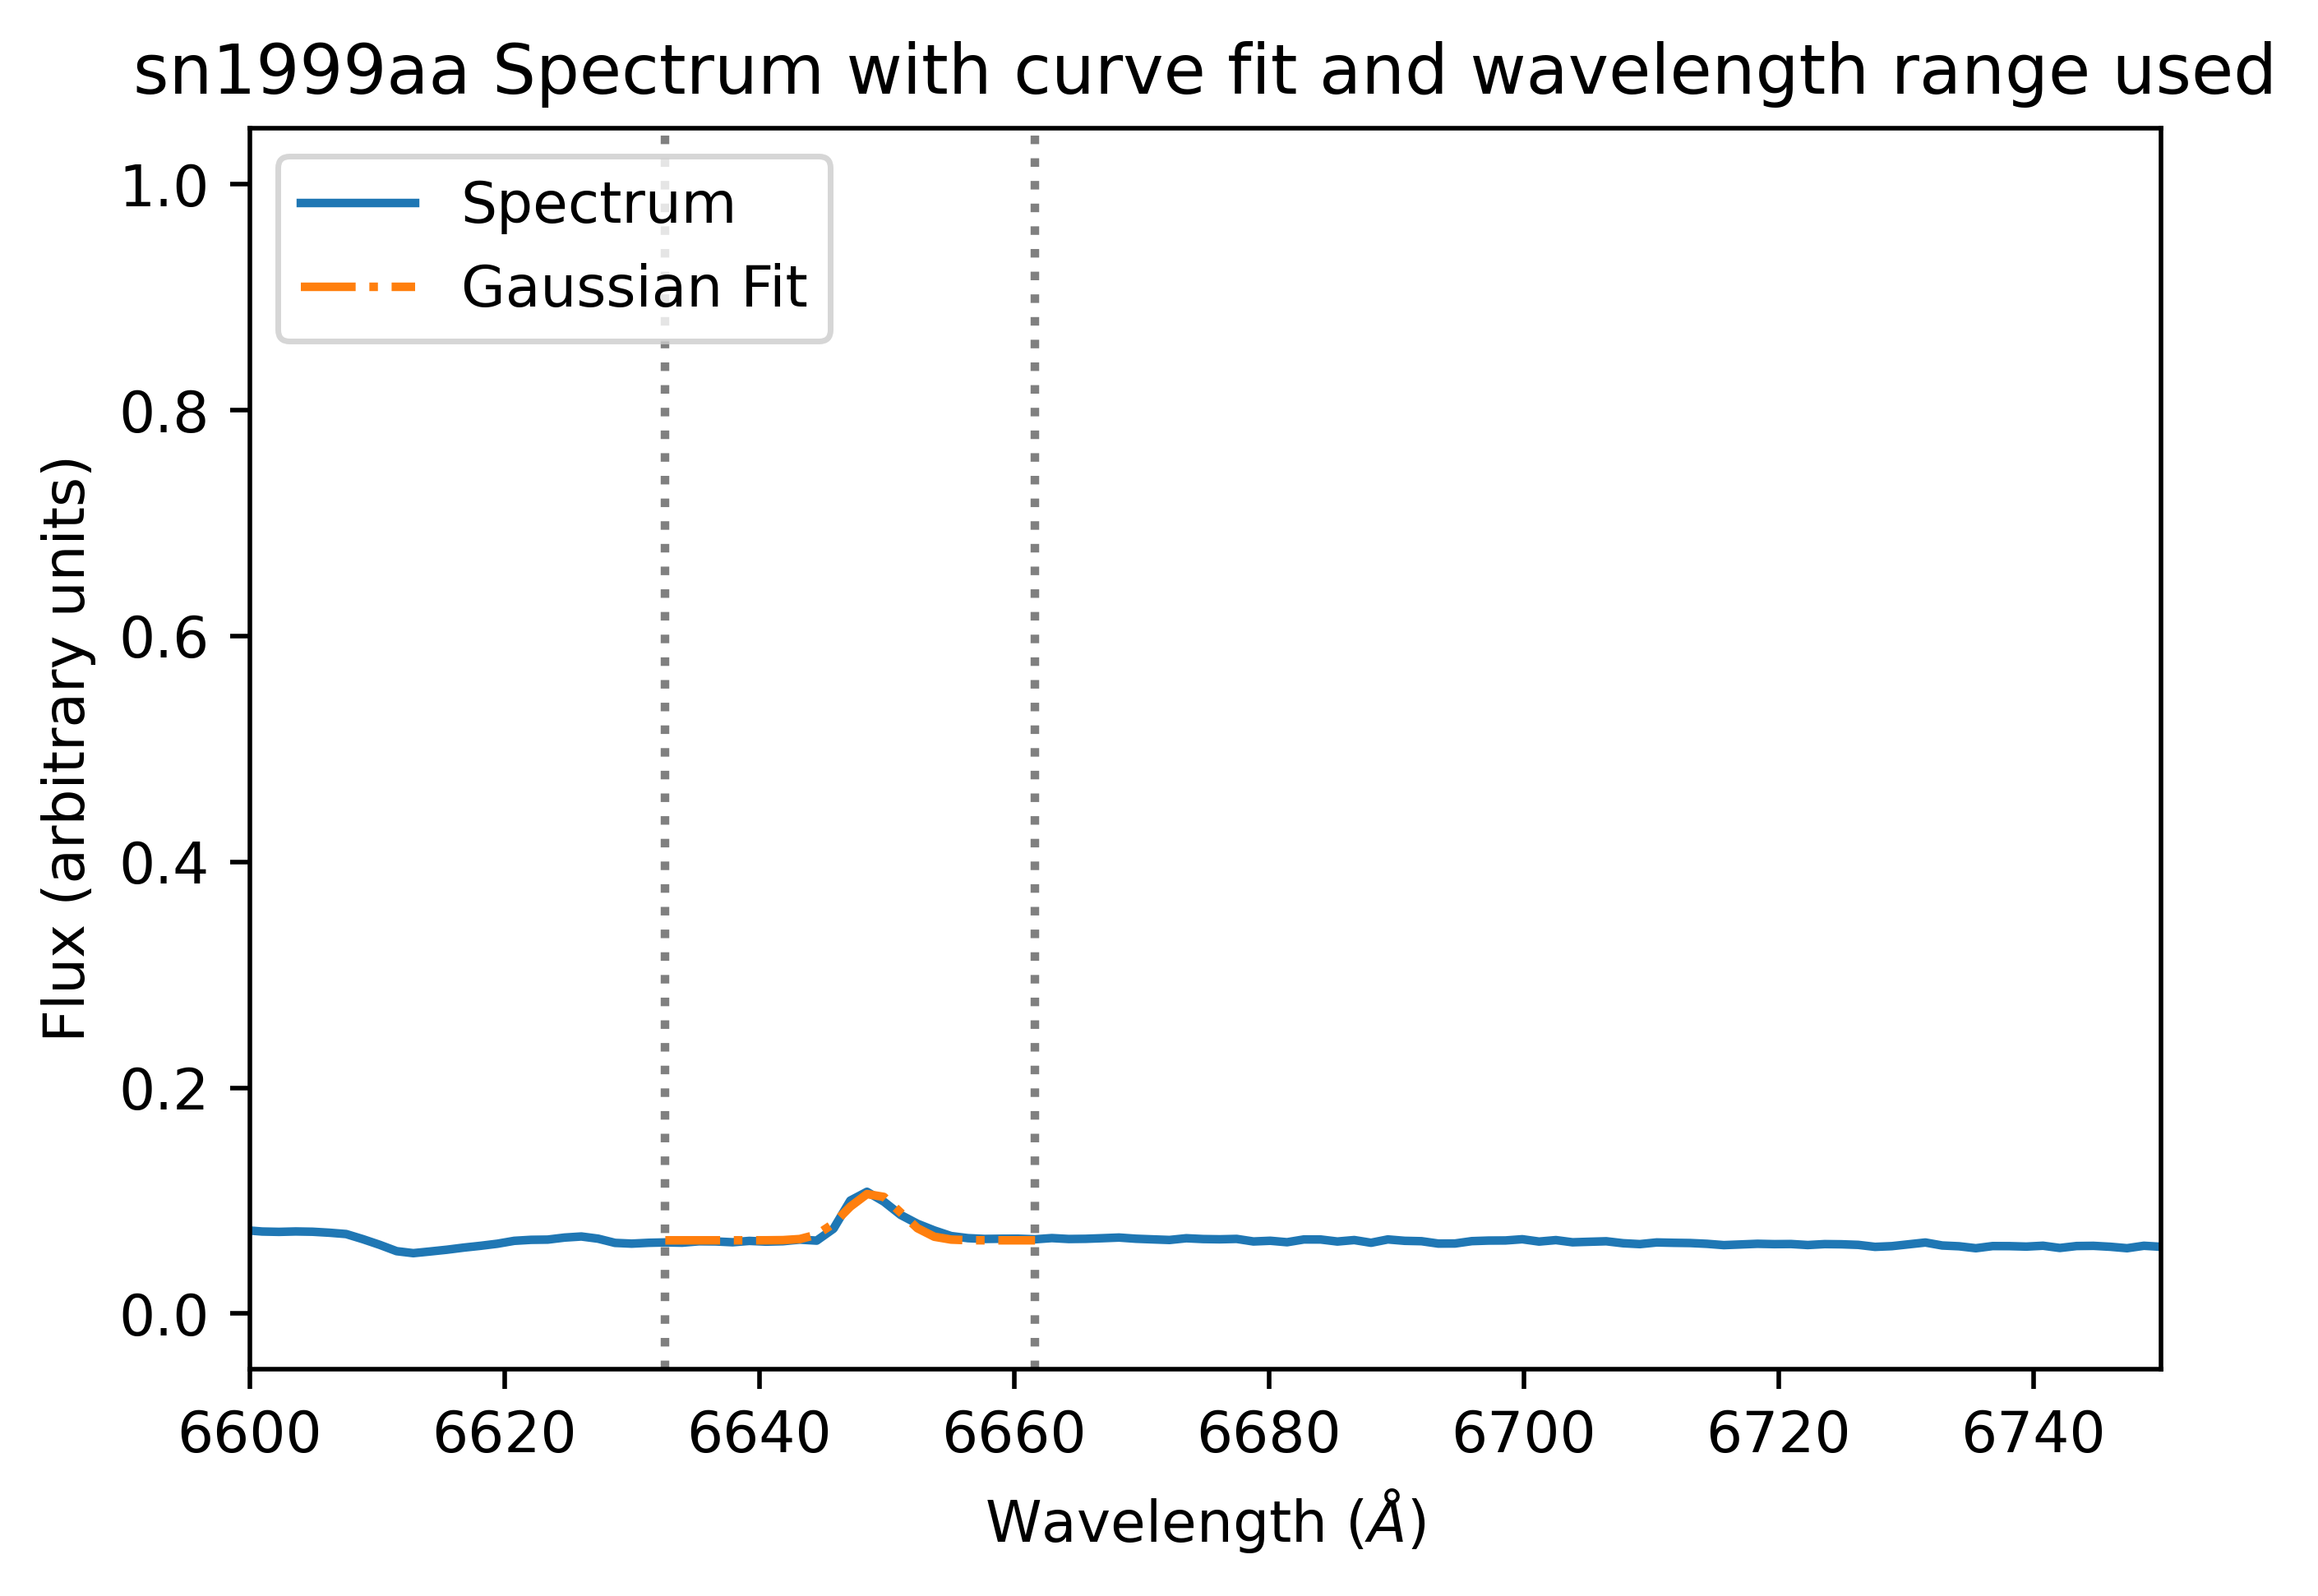

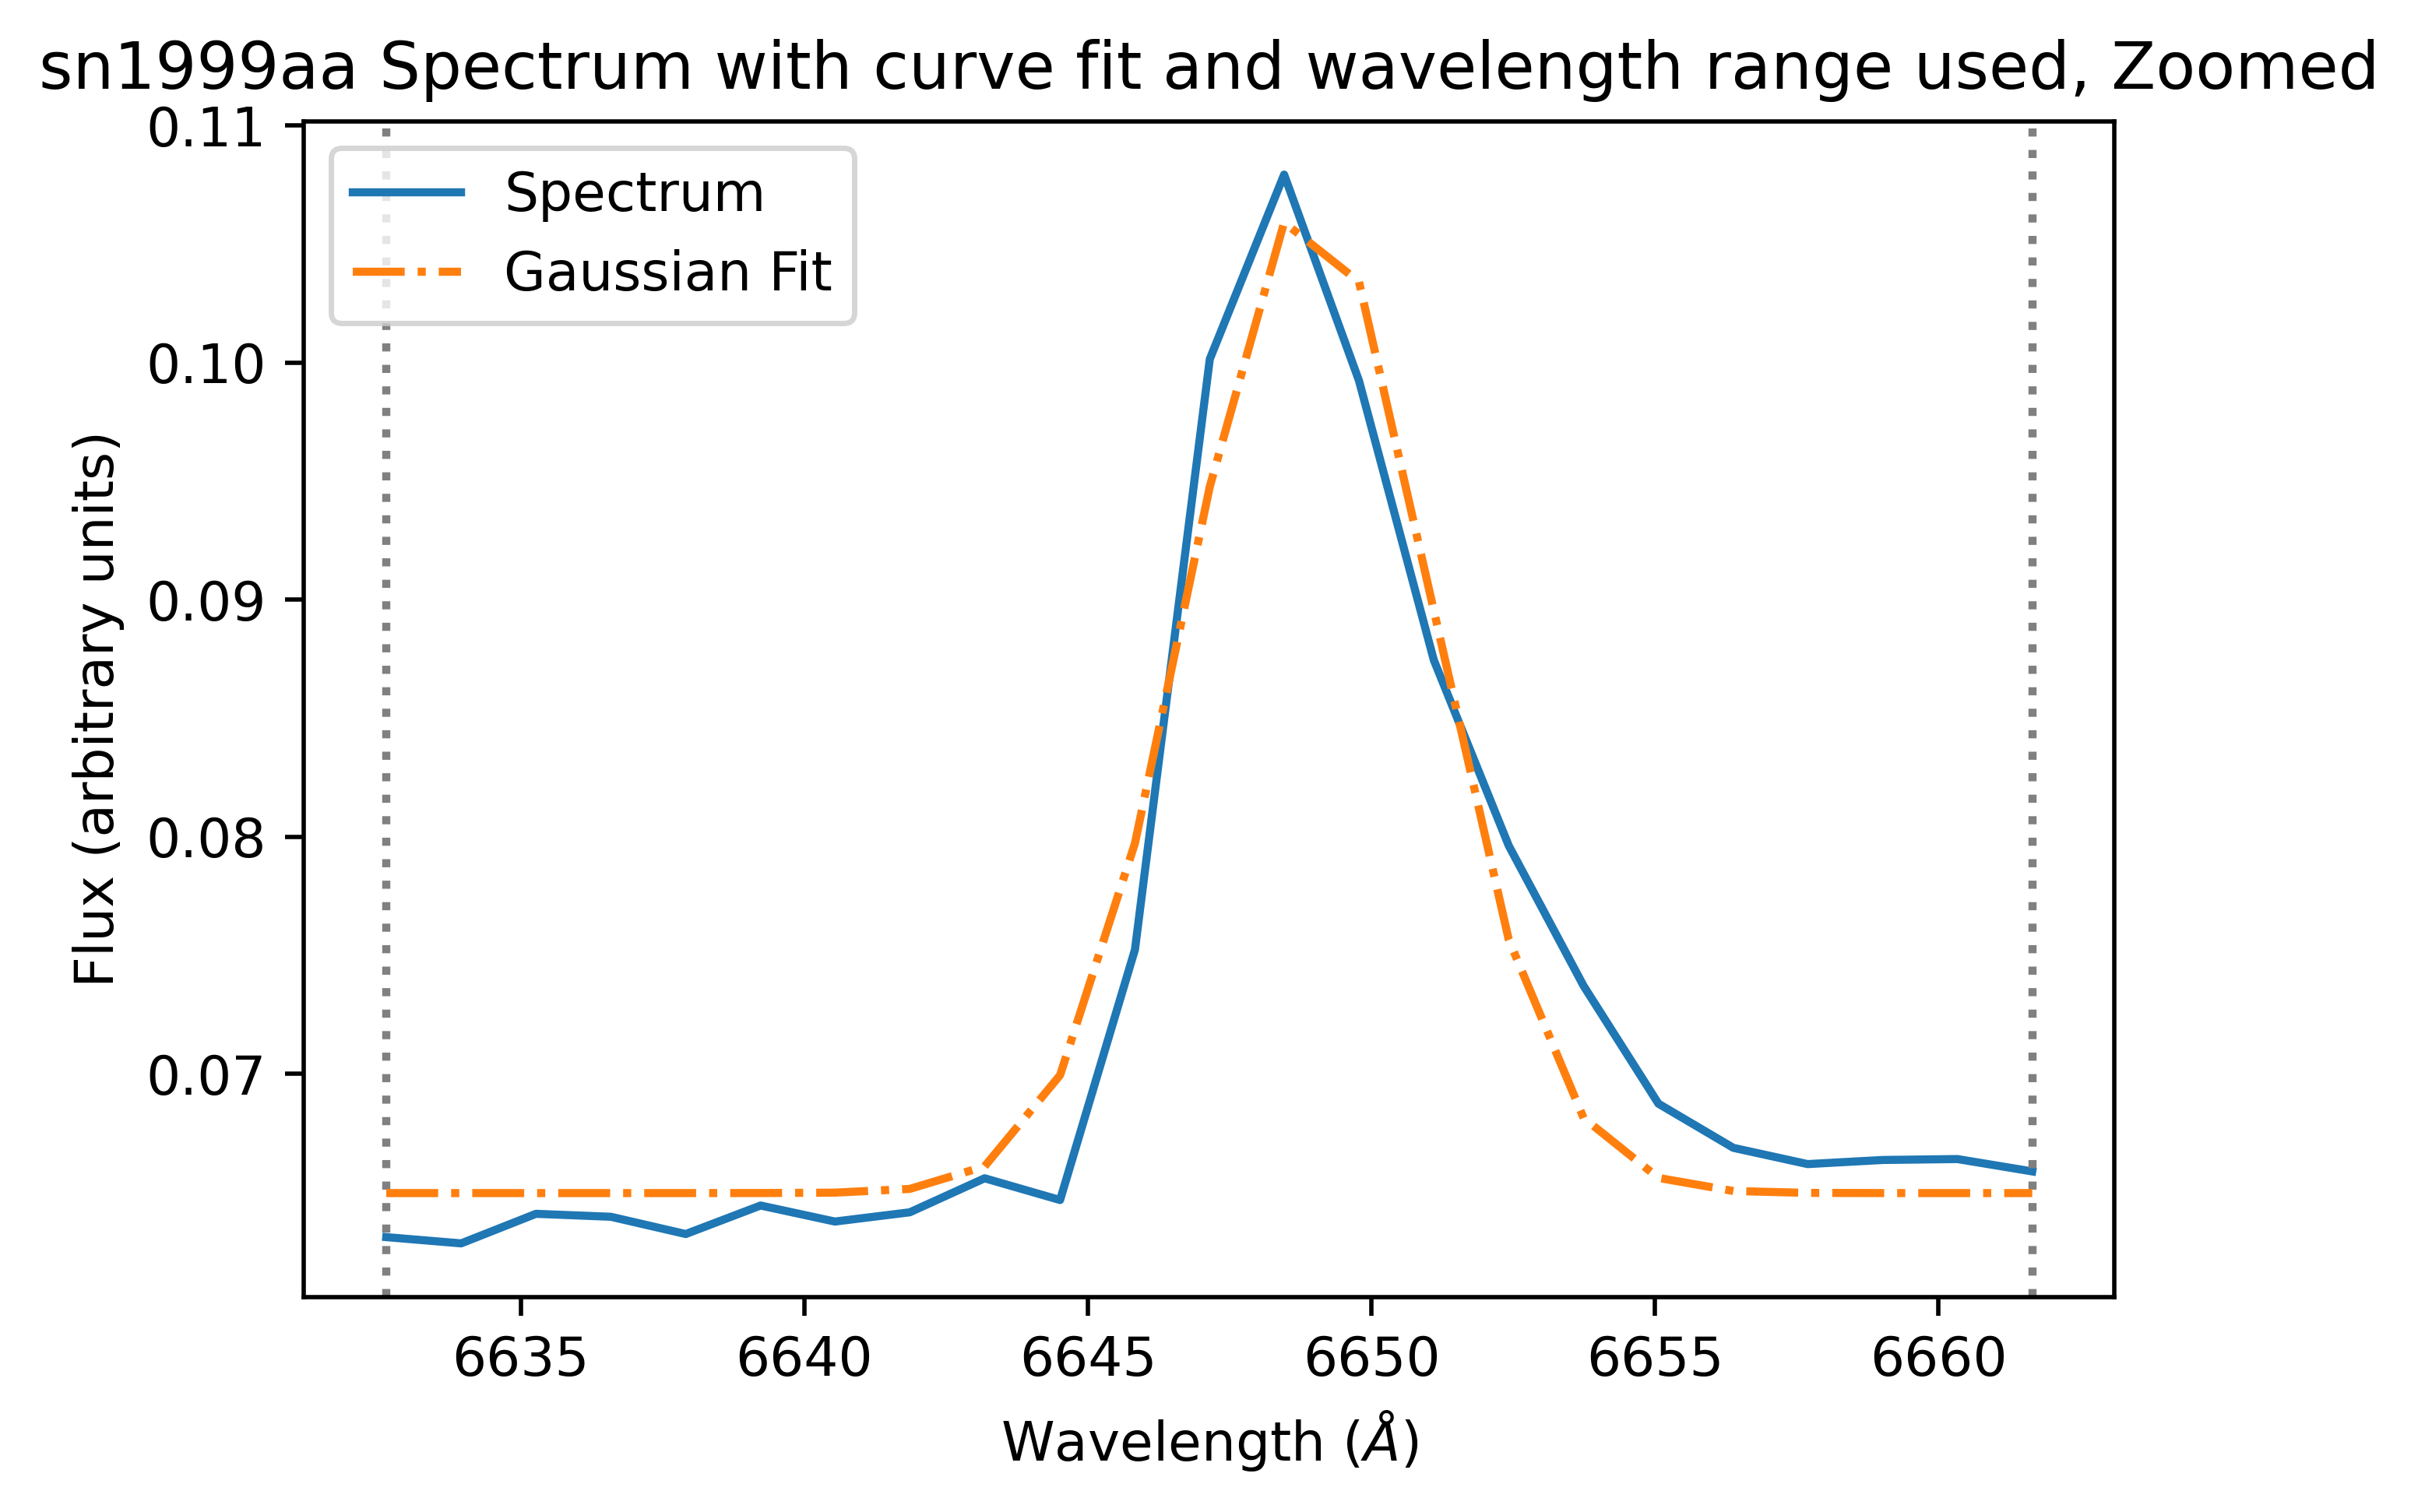

In [830]:
#now I will plot the curve fits on each H alpha peak to show how they align with the data

for i in range(len(sn_names)):
    #get a gaussian fit:
    vals, cov, constrained_wvlen, constrained_flux = findpeak(testhpeaks[i], 16, wavelengths[i], fluxes[i],i)
    
    #Get y values for the gaussian parameters found above 
    gauss_fit = gaussian(constrained_wvlen, vals[0],vals[1],vals[2],vals[3])

    #plot the gaussian and the spectrum, while showing the wavelength range used
    plt.figure(dpi=500)
    plt.title(sn_names[i] +' Spectrum with curve fit and wavelength range used')
    plt.plot(wavelengths[i],fluxes[i], label='Spectrum')
    plt.xlim(6600,6750)
    plt.axvline(constrained_wvlen[0],c='gray',ls='dotted')
    plt.axvline(constrained_wvlen[-1],c='gray', ls='dotted')
    plt.plot(constrained_wvlen, gauss_fit,label='Gaussian Fit', ls = '-.')
    plt.legend(loc='upper left')
    plt.xlabel(f'Wavelength ($\AA$)')
    plt.ylabel('Flux (arbitrary units)')
#     if i == 0 or i ==2:
#         plt.savefig(sn_names[i]+'gaussianfitexample',bbox_inches='tight')
    
    #plot the zoomed in version
    plt.figure(dpi=500)
    plt.title(sn_names[i] +' Spectrum with curve fit and wavelength range used, Zoomed')
    plt.plot(constrained_wvlen,constrained_flux, label='Spectrum')
    plt.axvline(constrained_wvlen[0],c='gray',ls='dotted')
    plt.axvline(constrained_wvlen[-1],c='gray', ls='dotted')
    plt.plot(constrained_wvlen, gauss_fit,label='Gaussian Fit', ls = '-.')
    plt.legend(loc='upper left')
    plt.xlabel(f'Wavelength ($\AA$)')
    plt.ylabel('Flux (arbitrary units)')
    
# 6659.02, 6663.82, 6668.62, 6673.42,  6678.22, 6683.02, 6687.82, 6692.63

From these gaussian fits we can find the peak wavelength value 

In [635]:
#This is to demonstrate what one iteration of this code does, it fits a gaussian and works out the redshift
#further down more lines are considered and error analysis is done
for i in range(len(sn_names)):
    #gaussian fit:
    vals, cov, constrained_wvlen, constrained_flux = findpeak(testhpeaks[i], 16, wavelengths[i], fluxes[i],i)
#     Halpha_peaks[i].append(vals[1])
    print(sn_names[i])
    print('Approx H alpha peak: ',vals[1], 'Agstrom')
    print('Difference:', vals[1]-6563, 'Angstrom')
    print('Approx Redshift: ', redshift(vals[1],6563))
#     print('Velocity: ', redshift(vals[1],6563)*const.c,'km/s')
    print()

sn2000dk
Approx H alpha peak:  6672.479009521093 Agstrom
Difference: 109.47900952109285 Angstrom
Approx Redshift:  0.016681244784563894

sn1999dq
Approx H alpha peak:  6654.700810625598 Agstrom
Difference: 91.70081062559802 Angstrom
Approx Redshift:  0.013972392294011584

sn1997E
Approx H alpha peak:  6653.008462808707 Agstrom
Difference: 90.00846280870701 Angstrom
Approx Redshift:  0.013714530368536799

sn1997bp
Approx H alpha peak:  6621.338844186941 Agstrom
Difference: 58.33884418694106 Angstrom
Approx Redshift:  0.008889051376952775

sn2000cn
Approx H alpha peak:  6715.423166424553 Agstrom
Difference: 152.42316642455262 Angstrom
Approx Redshift:  0.023224617770006496

sn1998es
Approx H alpha peak:  6622.991696879236 Agstrom
Difference: 59.99169687923586 Angstrom
Approx Redshift:  0.009140895456229751

sn1999aa
Approx H alpha peak:  6648.903625117401 Agstrom
Difference: 85.90362511740113 Angstrom
Approx Redshift:  0.013089078945208157



In [636]:
Halpha_peaks = [[],[],[],[],[],[],[]] 
other_peaks = [[], [], [[],[]] , [], [[],[]] , [], []]
#lists (above) to store found peaks

guess_peaks = [ 4940, 5960, [3775,5070], 4432, [5073,5123], 4910, 5072] #the approx peaks for each sn
testhpeaks = [6672,6655, 6652, 6621,6715,6623,6648] #guess peaks for H alpha
#these were found by visual inspection of the spectra

#to try different widths to either side of the line, I used random integers when fitting
#go through 1000 random widths of the search area and find peak.
for j in range(1000):
    width = np.random.randint(14,21) #chooses a pseudo random integer of wavelength either side to fit the gaussian to
    
    for i in range(len(sn_names)):
        #gaussian fit for the H alpha lines:
        vals, cov, constrained_wvlen, constrained_flux = findpeak(testhpeaks[i], width, wavelengths[i], fluxes[i],i)
        Halpha_peaks[i].append(vals[1])
    
    #now for the other lines present:
    #if i=2 or 4, need to do 2 lines 
        if i == 2 or i==4:
            vals, cov, constrained_wvlen, constrained_flux = findpeak(guess_peaks[i][0],width,wavelengths[i],fluxes[i],i)
            other_peaks[i][0].append(vals[1])#stores the wavelength found for the first peak
            vals, cov, constrained_wvlen, constrained_flux = findpeak(guess_peaks[i][1],width,wavelengths[i],fluxes[i],i)
            other_peaks[i][1].append(vals[1])#stores the wavelength found for the first peak
        else:    
            vals, cov, constrained_wvlen, constrained_flux = findpeak(guess_peaks[i],width,wavelengths[i],fluxes[i],i)
            other_peaks[i].append(vals[1])


/Users/karlnicholson/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


$$ \Delta z = \sqrt{ \left( \frac{1}{\lambda_{rest}} \Delta \lambda_{obs} \right) ^2 + \left(\frac{\lambda_{obs}}{\lambda_{rest}^2} \Delta \lambda_{rest}\right)^2} $$

In [662]:
ref_wavelengths = [4861, 5890, [3727,5007], 4341, [4959,5007], 4861, 5007] #the rest wavelengths given in the lab script
redshifts_A = []#will be used to store redshifts


for i in range(len(sn_names)):
    print(sn_names[i])
    av_H_peak, H_peak_dev = np.mean(Halpha_peaks[i]), np.std(Halpha_peaks[i]) #gets the mean and the standard deviation for the H alpha peak
    #to get the error: use gaussian error propagation shown in markdown above this cell 
    #error in the wavelengths given in lab script is assumed to be ±0.5 angstrom
    
    if i==2 or i==4:
        av_other_peak1, other_peak_dev1 = np.mean(other_peaks[i][0]), np.std(other_peaks[i][0]) #get the average and std of the 2 other peaks chosen
        av_other_peak2, other_peak_dev2 = np.mean(other_peaks[i][1]), np.std(other_peaks[i][1])

        red_val = np.mean([redshift(av_H_peak,6563), redshift(av_other_peak1,ref_wavelengths[i][0]), redshift(av_other_peak2,ref_wavelengths[i][1])])
        #find the average of the redshifts given from the 3 peaks (H alpha and 2 others)
        red_err = np.mean([redshift_err(av_H_peak,6563,H_peak_dev), redshift_err(av_other_peak1, ref_wavelengths[i][0],other_peak_dev1), redshift_err(av_other_peak2, ref_wavelengths[i][0],other_peak_dev2)])

        print('H alpha peak:',av_H_peak,'±',H_peak_dev, 'Agstrom')
        print('Redshift:', red_val,'±', red_err) 
        redshifts_A.append([red_val,red_err]) #store the redshift for later use
        print()
        
    #for the spectra with only one extra line:  
    else:
        av_other_peak, other_peak_dev = np.mean(other_peaks[i]), np.std(other_peaks[i])

        #using redshift nd redshift error functions
        red_val = np.mean([redshift(av_H_peak,6563), redshift(av_other_peak,ref_wavelengths[i])]) 
        red_err = np.mean([redshift_err(av_other_peak, ref_wavelengths[i],other_peak_dev),redshift_err(av_H_peak,6563,H_peak_dev)])

        print('H alpha peak:',av_H_peak,'±',H_peak_dev, 'Agstrom')
        print('Redshift:', red_val,'±', red_err) 
        redshifts_A.append([red_val,red_err])
        print()


    
    
# largest source of uncertainty in these redshifts is how far to the left and right you let the gaussian fit to
#that is why I varied the wavelength left and right of the 'by eye' peak

sn2000dk
H alpha peak: 6672.557340679109 ± 0.08985781314348361 Agstrom
Redshift: 0.01649511086865735 ± 9.164522317482611e-05

sn1999dq
H alpha peak: 6660.114883682567 ± 6.425135572963669 Agstrom
Redshift: 0.013325689726064707 ± 0.0007104198138296613

sn1997E
H alpha peak: 6653.003885689849 ± 0.007641626392630001 Agstrom
Redshift: 0.013064367881298037 ± 0.00013187569155769183

sn1997bp
H alpha peak: 6621.327121285476 ± 0.023037412884171424 Agstrom
Redshift: 0.014898569350161843 ± 9.741726353794385e-05

sn2000cn
H alpha peak: 6715.421637587015 ± 0.0034727583454274924 Agstrom
Redshift: 0.023132698442324625 ± 9.508781411263975e-05

sn1998es
H alpha peak: 6622.994418338902 ± 0.0038268564182611237 Agstrom
Redshift: 0.01018946902337694 ± 0.0009423663159859824

sn1999aa
H alpha peak: 6648.902546882491 ± 0.003231959365398788 Agstrom
Redshift: 0.013030813307375516 ± 8.916964596006837e-05



In [663]:
#can see that for sn199dq the error larger - due to the very low S/N ratio? Adding a second line  helped this

# Part B 

Finding the magnitude of the peak in the B band and the delta m_15 


In [668]:
Dates, Bmags, Bmagerrs = [],[],[] #same for julian dates, magnitude in B band and its error 
Dates_extended, Bmags_extended, Bmagerrs_extended = [],[],[]

for i in range(len(sn_names)):
    data_lc = np.loadtxt( direc_lc + sn_names[i] + ending_lc) #load in the data
    
    #for part B:
    Jdate = [entry[0] for entry in data_lc if entry[3]<90] #the < makes sure that the data is not the 99.9 no data value
    Jdate_rel = [entry - Jdate[0] for entry in Jdate] #this subtracts the initial time value, making it start from 0 
    Bmag = [entry[3] for entry in data_lc if entry[3]<90]
    Bmagerr = [entry[4] for entry in data_lc if entry[3]<90]
    
    Bmags_extended.append(Bmag) #these will be used for plotting the full dataset
    Bmagerrs_extended.append(Bmagerr)
    Dates_extended.append(Jdate_rel)
    
    #As discussed below, need to remove data from more than 50 days after start to prevent polyfit optimising for unimportant data 
    indices = np.where(np.array(Jdate_rel) < 55) #this is the indices where the days value is less than 50
    #indices were chosen to make sure the fits applied will be better 
    lower_ind, upper_ind = indices[0][0], indices[0][-1]#top and bottom index
    Jdate_rel = Jdate_rel[lower_ind:upper_ind]
    Jdate_rel = Jdate_rel/(1+ redshifts_A[i][0]) #divides by redshift
    Bmag = Bmag[lower_ind:upper_ind]
    Bmagerr = Bmagerr[lower_ind:upper_ind]

    Dates.append(Jdate_rel)
    Bmags.append(Bmag)
    Bmagerrs.append(Bmagerr)

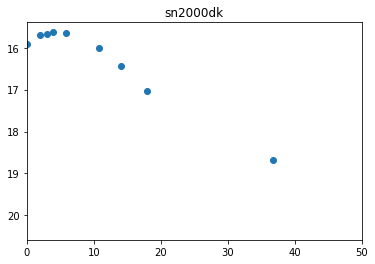

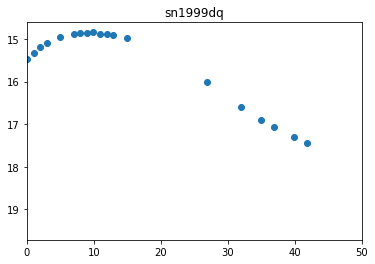

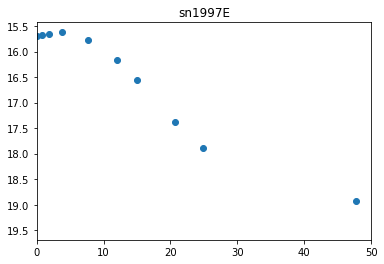

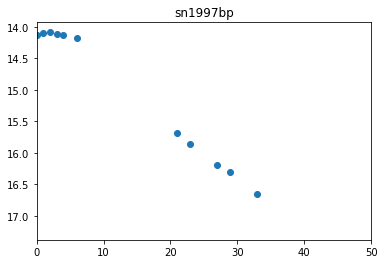

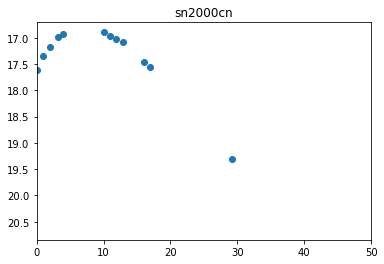

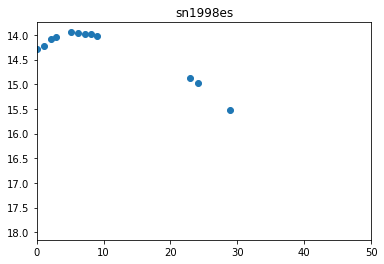

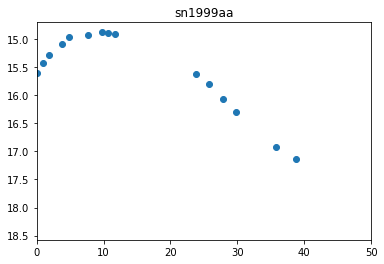

In [669]:
#already imported the data above, it is in Dates, Bmags and Bmagerrs
for i in range(len(sn_names)):
    plt.figure()
    plt.scatter(Dates_extended[i], Bmags_extended[i])
    plt.title(sn_names[i])
    plt.gca().invert_yaxis()
    plt.xlim(0,50)

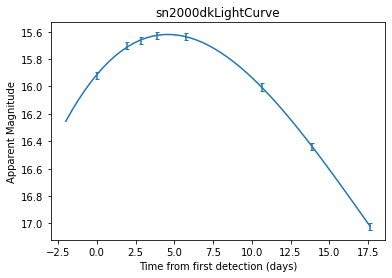

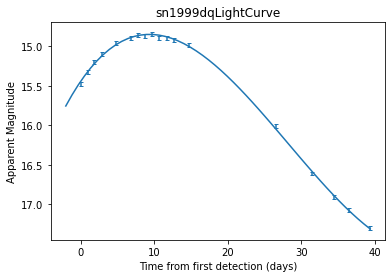

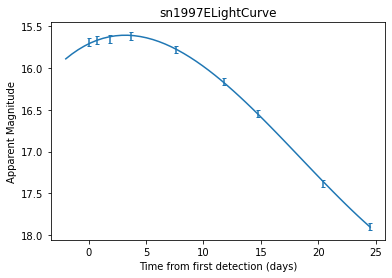

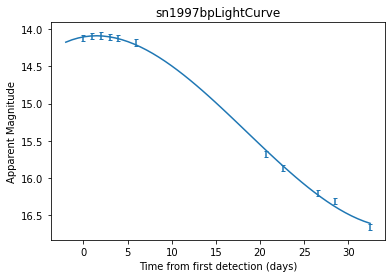

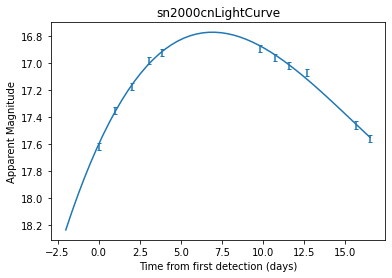

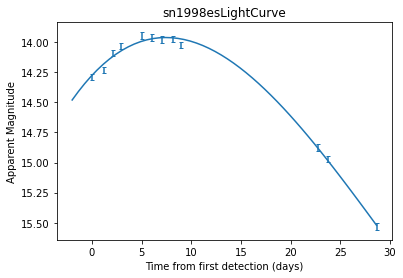

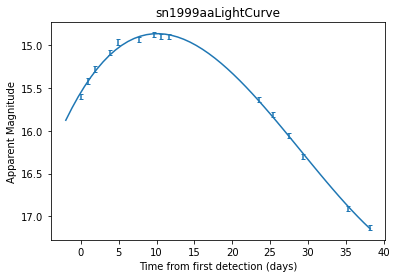

In [917]:
#this is to check what degree polynomial should be taken for each supernova
#unfortunately this has to be qualitative as the chi^2 etc values will be ever lower as the degrees increase, yet the fit will actually be worse
#to choose this, want a curve at the peak, not a line, and want the lowest best fit degree to prevent overfitting for each point (especialy the 100+ days later points)
#the actual function does not matter as much because only the peak and the 15 day change is important


#for example in sn2000dk, the best choice is 6th degree as it fits the peak best etc, yet at around 110 days it peaks randomly
# for j in range(len(sn_names)):

#     for i in range(4,7):

#         fit = np.polyfit(Dates[j],Bmags[j],i)
#         plottingxvals = np.linspace(np.min(Dates[j])-3,np.max(Dates[j]))
#         plottingyvals = np.polyval(fit, plottingxvals)
#         plt.figure()
#         plt.title(sn_names[j]+ ' Degree '+str(i))
#         plt.scatter(Dates[j], Bmags[j])
#         plt.plot(plottingxvals,plottingyvals)
#         plt.xlabel('Time from first detection (days)')
#         plt.ylabel('Magnitude')
# #         plt.xlim(0,40)


#instead of choosing the best degree polynomial qualitatively, I chose to limit the data to only 50 days after initial measurement
#this resulted in better fits


fits = []

for j in range(len(sn_names)):

    fit, cov = np.polyfit(Dates[j],Bmags[j],3,cov=True) #puts a polynomial fit of order 3 onto the data and returns coefficients and covariance matrix
    err_fit = np.sqrt(np.diag(cov))
    fits.append([fit,err_fit])
    plottingxvals = np.linspace(np.min(Dates[j])-2,np.max(Dates[j]))
    plottingyvals = np.polyval(fit, plottingxvals)
    
    plt.figure()
    plt.title(sn_names[j]+'LightCurve')#+ ' Degree '+str(3))
    plt.errorbar(Dates[j], Bmags[j], yerr = Bmagerr[j]*2,fmt='none',capsize=2)
    plt.plot(plottingxvals,plottingyvals)
    plt.xlabel('Time from first detection (days)')
    plt.ylabel('Apparent Magnitude')
    plt.gca().invert_yaxis()
#     plt.savefig(sn_names[j]+'lightcurve.png',bbox_inches='tight')


#plots look good, the fits are good

#now need to correct for time dilation using redshift too

In [833]:
max_app_mags = []
delta_m15s = []

for i in range(len(sn_names)):
    print(sn_names[i])
    xs = np.linspace(-2,30,16000,endpoint=False) #endpoint makes it so we can get exact integers
    #errors is fits[i][1]
    ys = fits[i][0][0]*xs**3 + fits[i][0][1]*xs**2 + fits[i][0][2]*xs + fits[i][0][3]
    rel_err = np.sqrt(fits[i][1][0]**2 + fits[i][1][1]**2 + fits[i][1][2]**2 + fits[i][1][3]**2) #reason is discussed below

    print('Max magnitude:',np.min(ys),'±', np.min(ys)*rel_err)
    max_app_mags.append([np.min(ys), np.min(ys)*rel_err])
    print('Time of Maximum:', xs[np.argmin(ys)],'days')
    day15value, err_day15value = ys[np.argmin(ys)+ 7500],ys[np.argmin(ys)+7500]*rel_err
    print('Value after 15 days:', day15value, '±', err_day15value)
    delta_m15, err_delta_m15 = np.min(ys)-day15value, (np.min(ys)-day15value)*rel_err
    #np.sqrt((np.min(ys)*rel_err)**2+err_day15value**2)
    print(r'$\Delta m_{15}$:',delta_m15,'±',err_delta_m15) #latex doesn't work with print
    delta_m15s.append([delta_m15,err_delta_m15])
    #7500 corresponds to exactly 15 days (thanks to endpoint=False)
    print()

sn2000dk
Max magnitude: 15.620116168896788 ± 0.12179577123898659
Time of Maximum: 4.5840000000000005 days
Value after 15 days: 17.327356776221887 ± 0.13510775203422049
$\Delta m_{15}$: -1.7072406073250992 ± -0.013311980795233885

sn1999dq
Max magnitude: 14.8480359176122 ± 0.2158309321555665
Time of Maximum: 9.370000000000001 days
Value after 15 days: 15.812761171515536 ± 0.22985417078317466
$\Delta m_{15}$: -0.9647252539033353 ± -0.014023238627608136

sn1997E
Max magnitude: 15.611488294730988 ± 0.2566718326385678
Time of Maximum: 3.184 days
Value after 15 days: 17.03631638756684 ± 0.280097737387606
$\Delta m_{15}$: -1.4248280928358508 ± -0.02342590474903822

sn1997bp
Max magnitude: 14.09049502344831 ± 0.5023588594020323
Time of Maximum: 1.472 days
Value after 15 days: 15.152650535650677 ± 0.5402271692612398
$\Delta m_{15}$: -1.0621555122023665 ± -0.03786830985920752

sn2000cn
Max magnitude: 16.772064654870864 ± 0.4105973790124234
Time of Maximum: 6.916 days
Value after 15 days: 18.0263

Gaussian error propagation:

$$\Delta z = \sqrt{ \left( \frac{\partial f}{\partial x}\Delta x\right)^2 + \left(\frac{\partial f}{\partial y}\Delta y\right)^2}\\
   z = f(x,y)$$

But in this case y is only a function of x, (julian date): $\Delta y = \sqrt{ \left( \frac{\partial f}{\partial x}\Delta x\right)^2} $, $\Delta y =   \frac{\partial f}{\partial x}\Delta x$, but x is given no error in the data file, presumably because the time of observation is known to such a high degree compared to the other uncertainties that it can be considered exact. Thus only the errors in the fitting function is non negligible

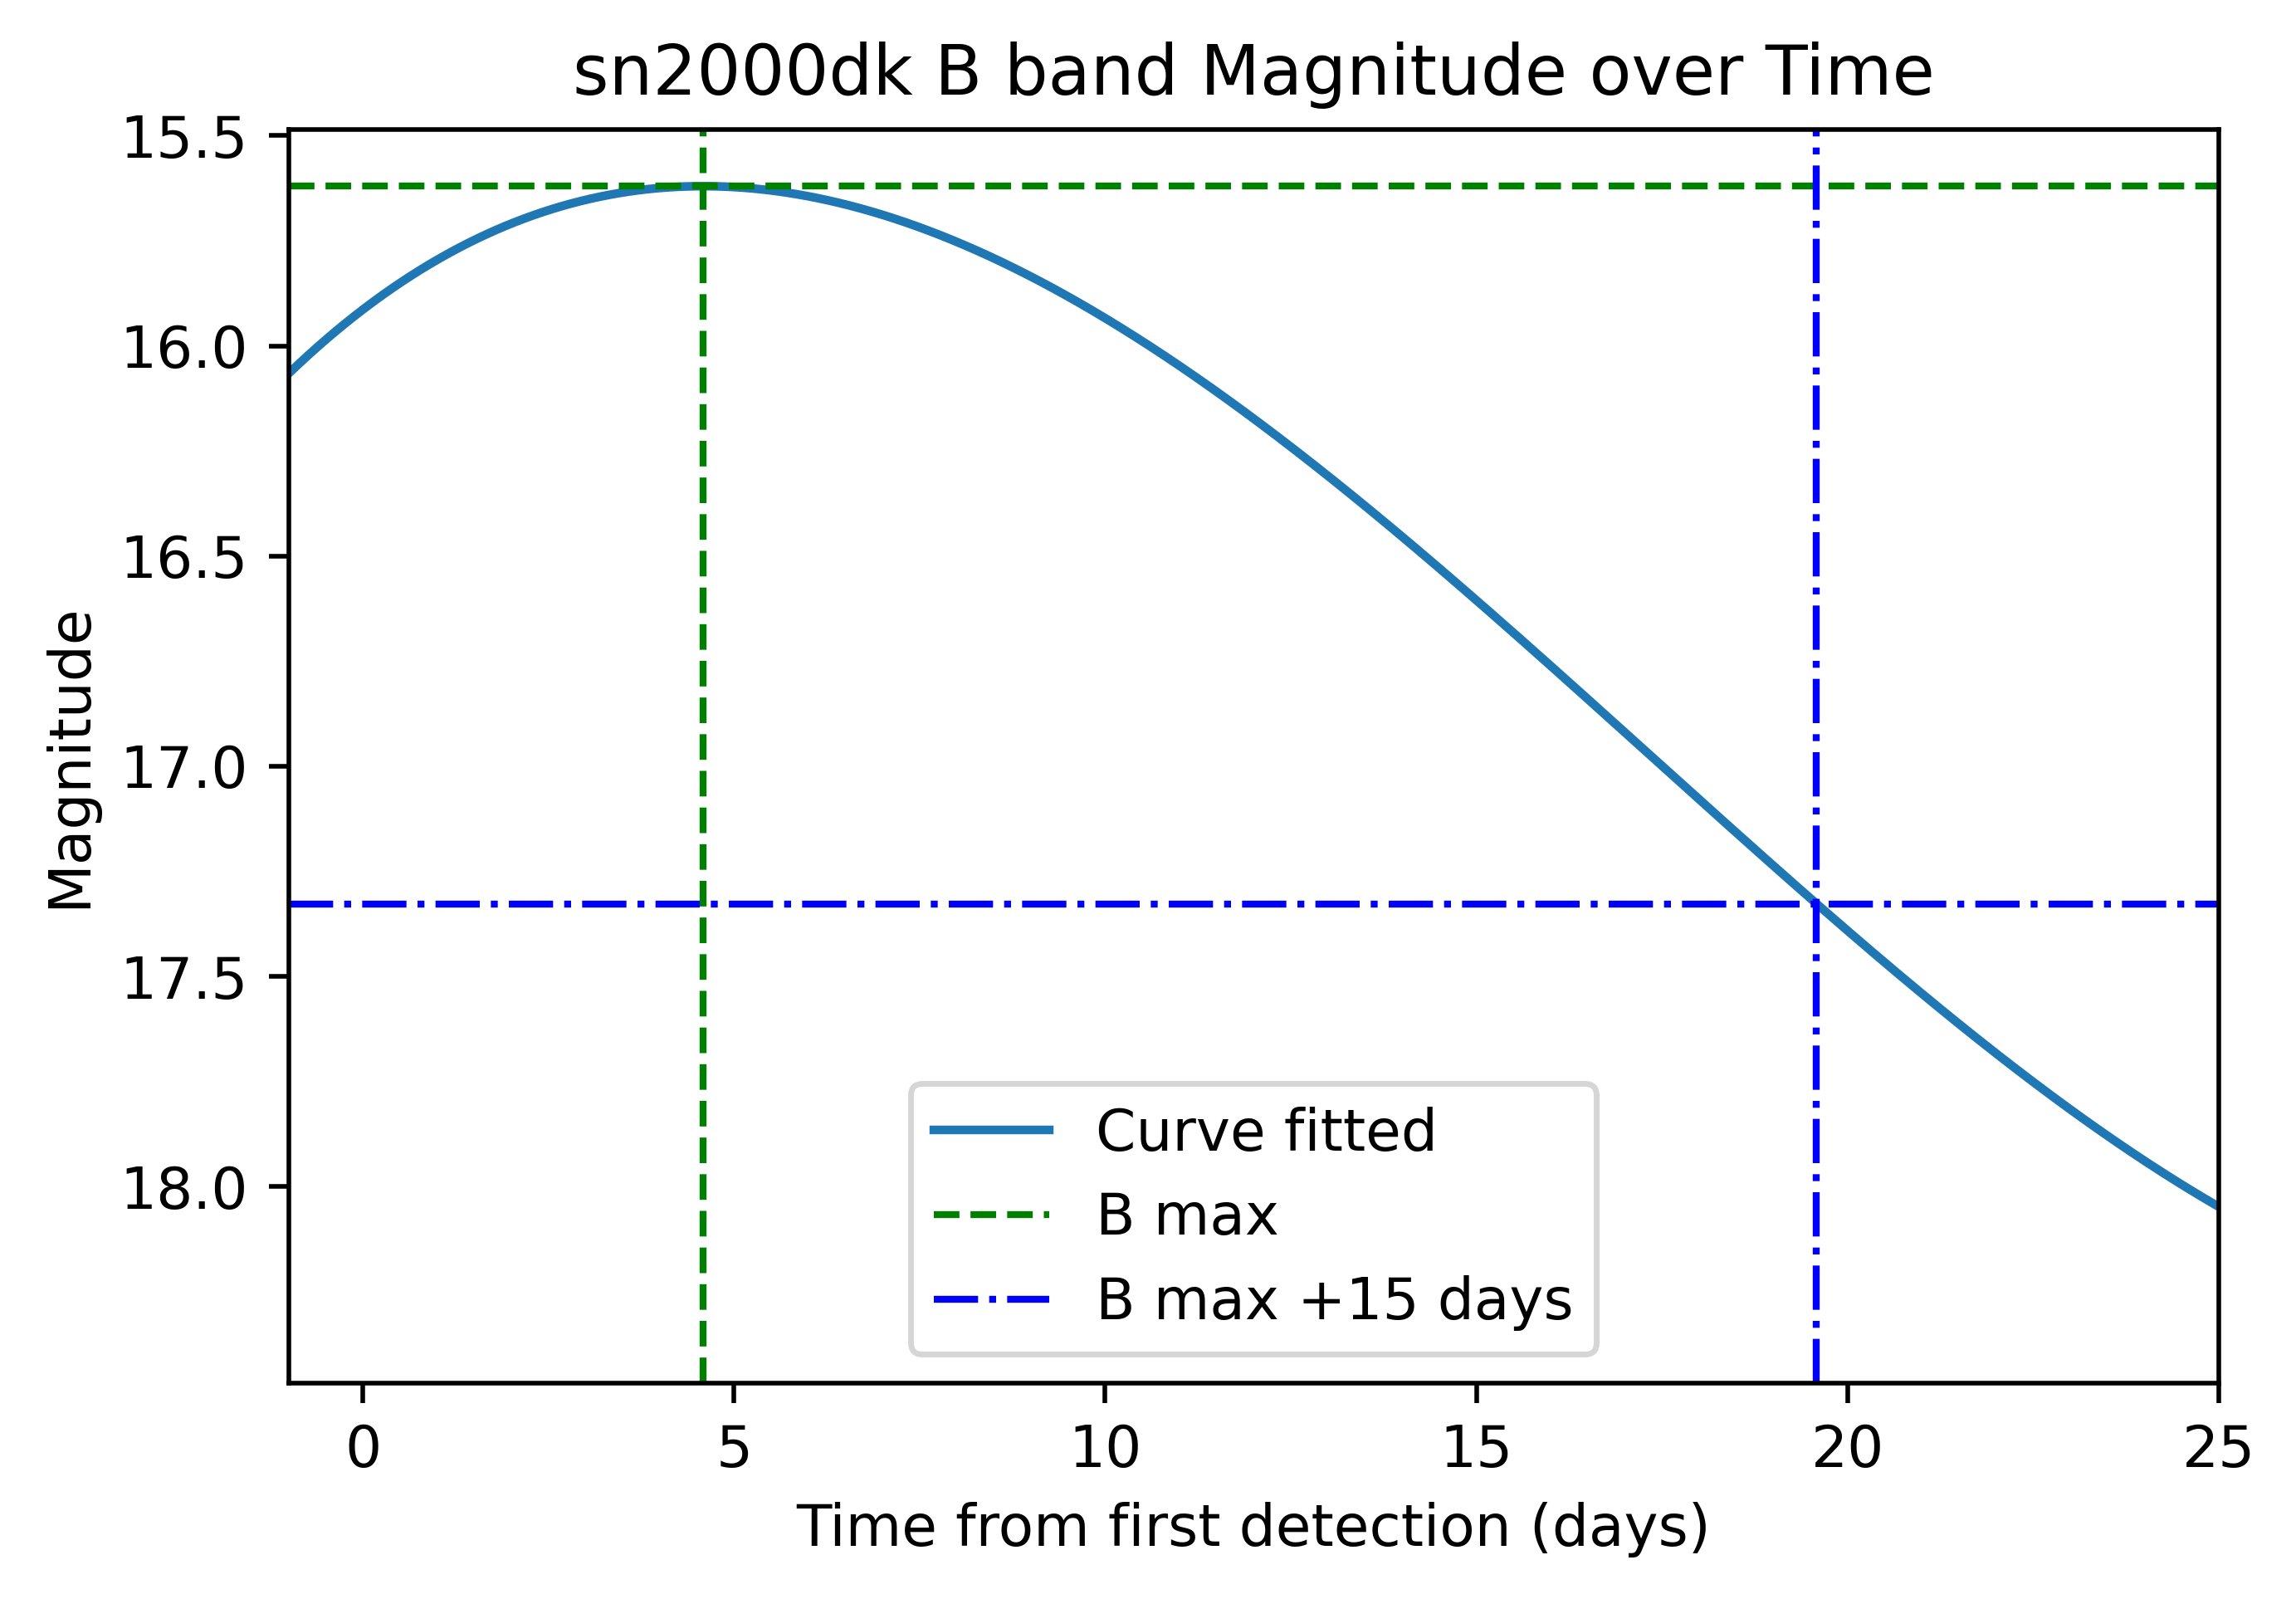

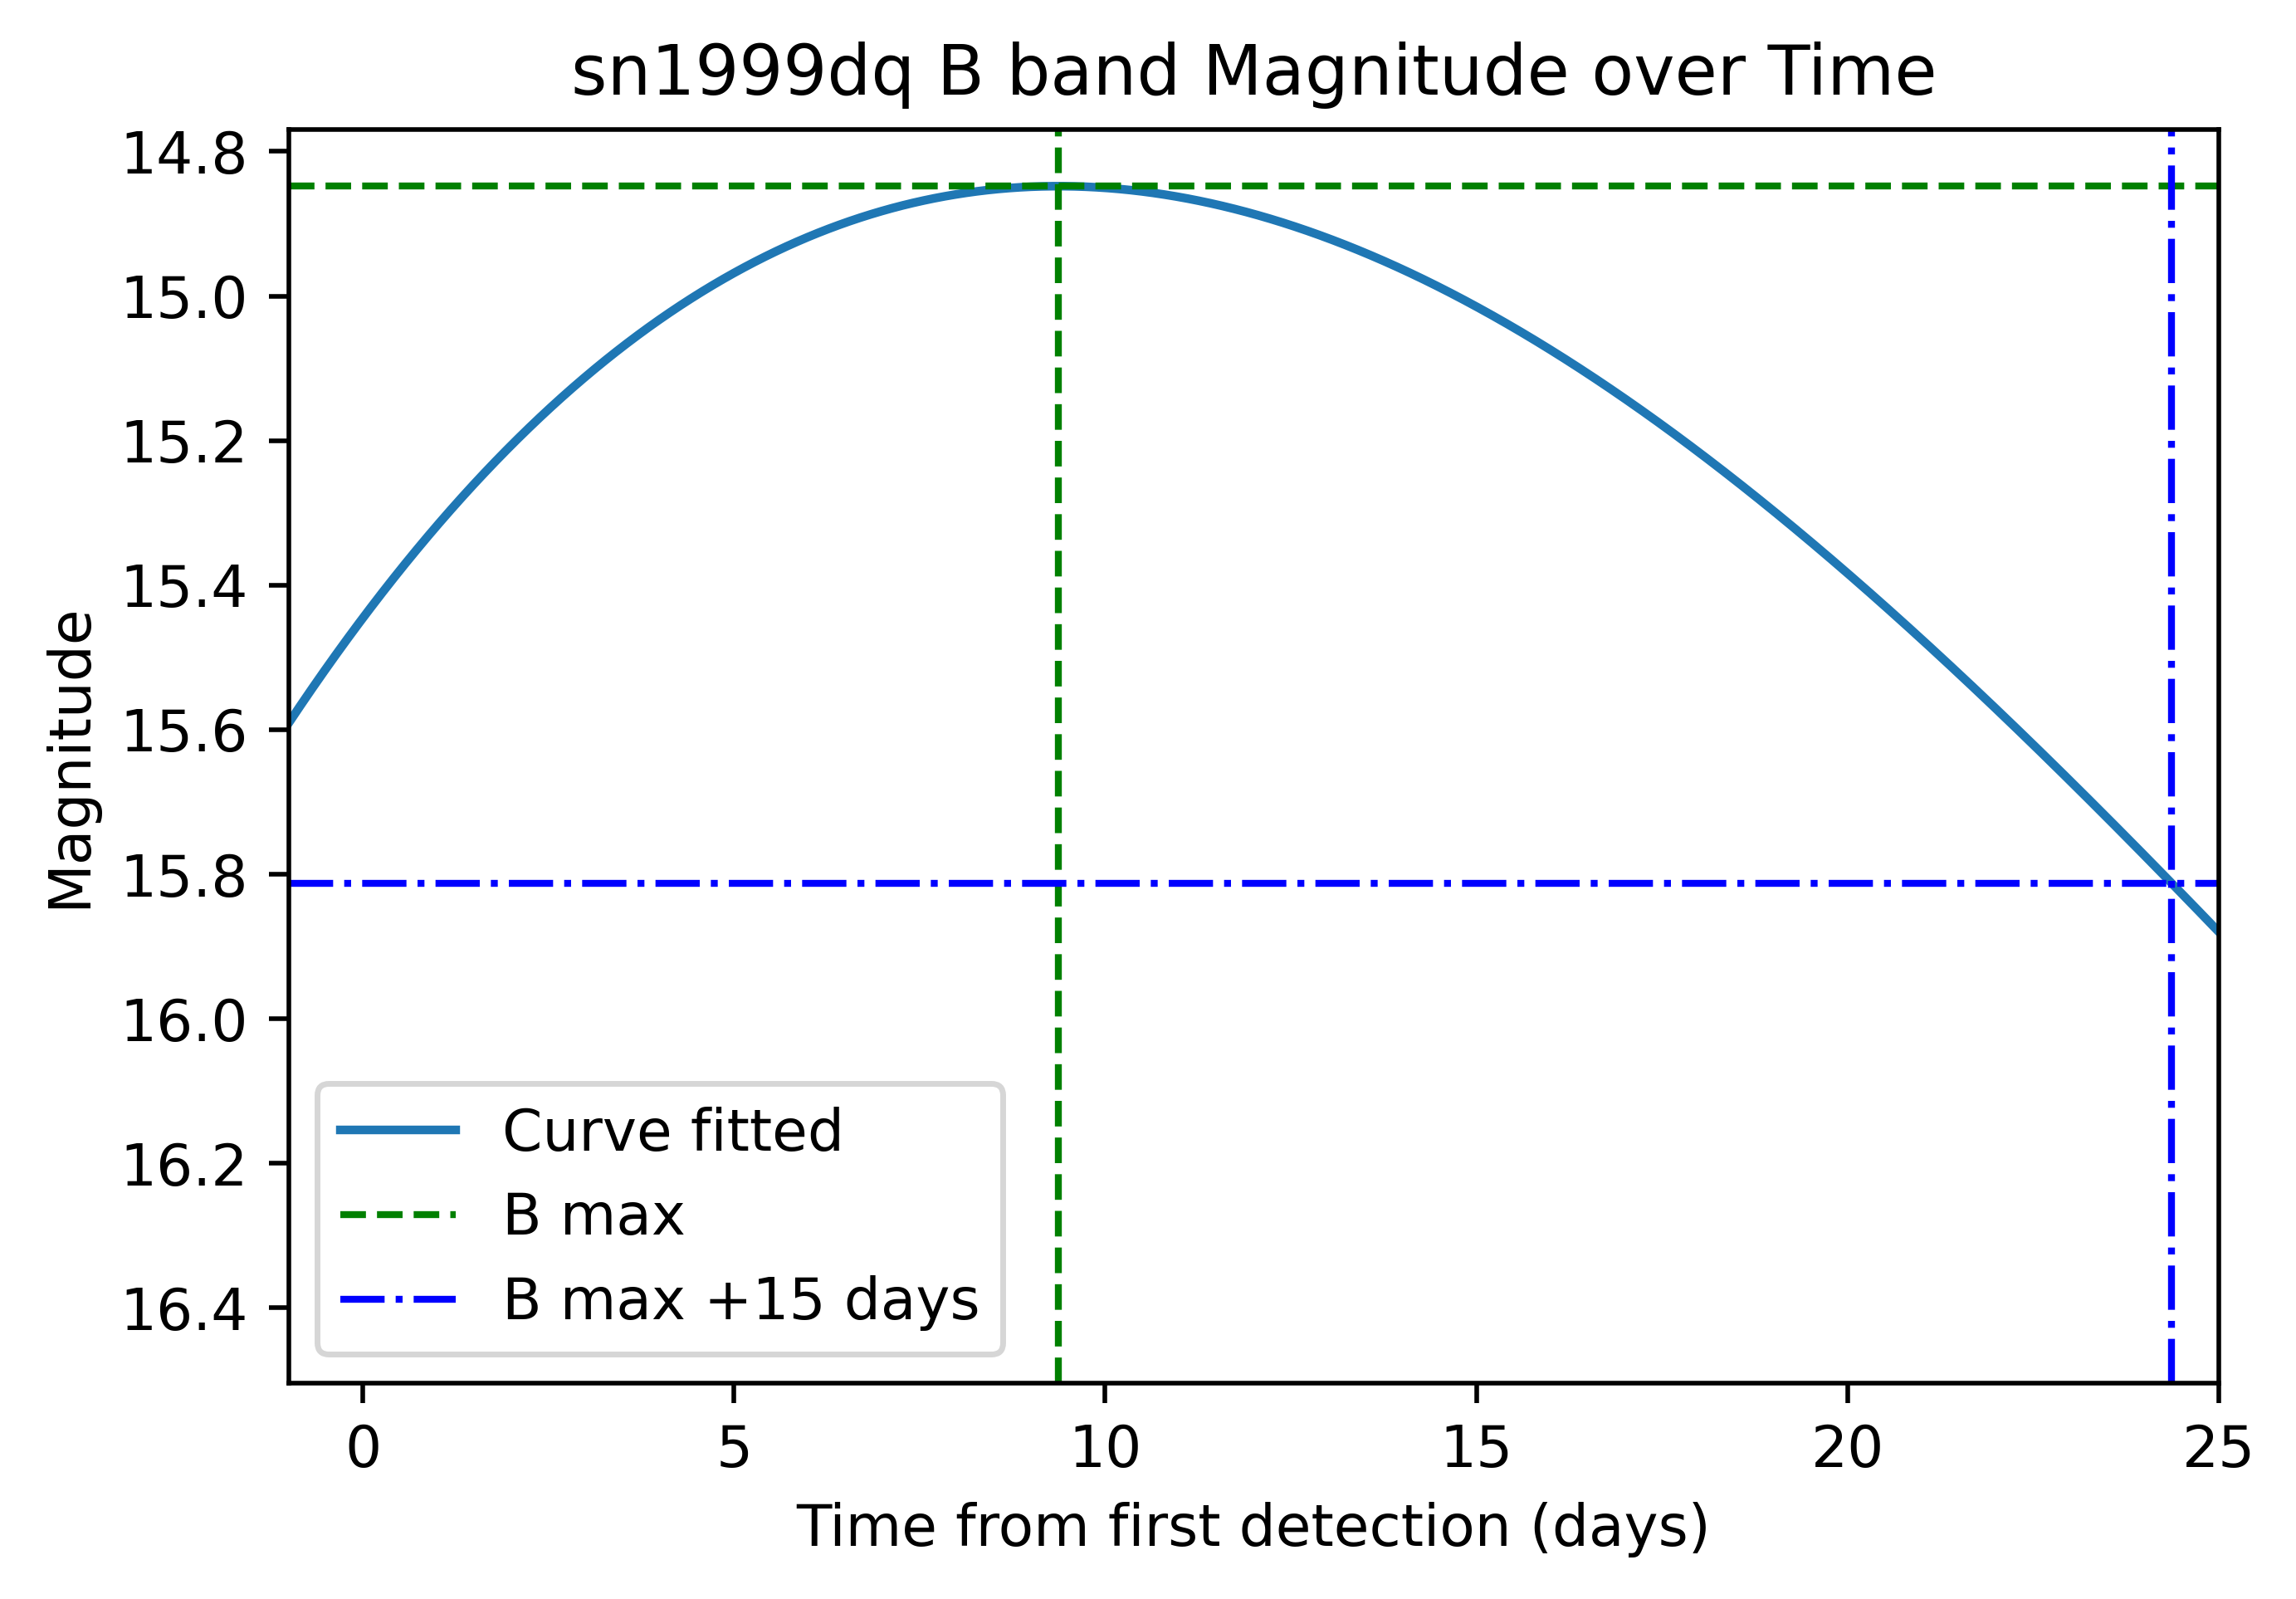

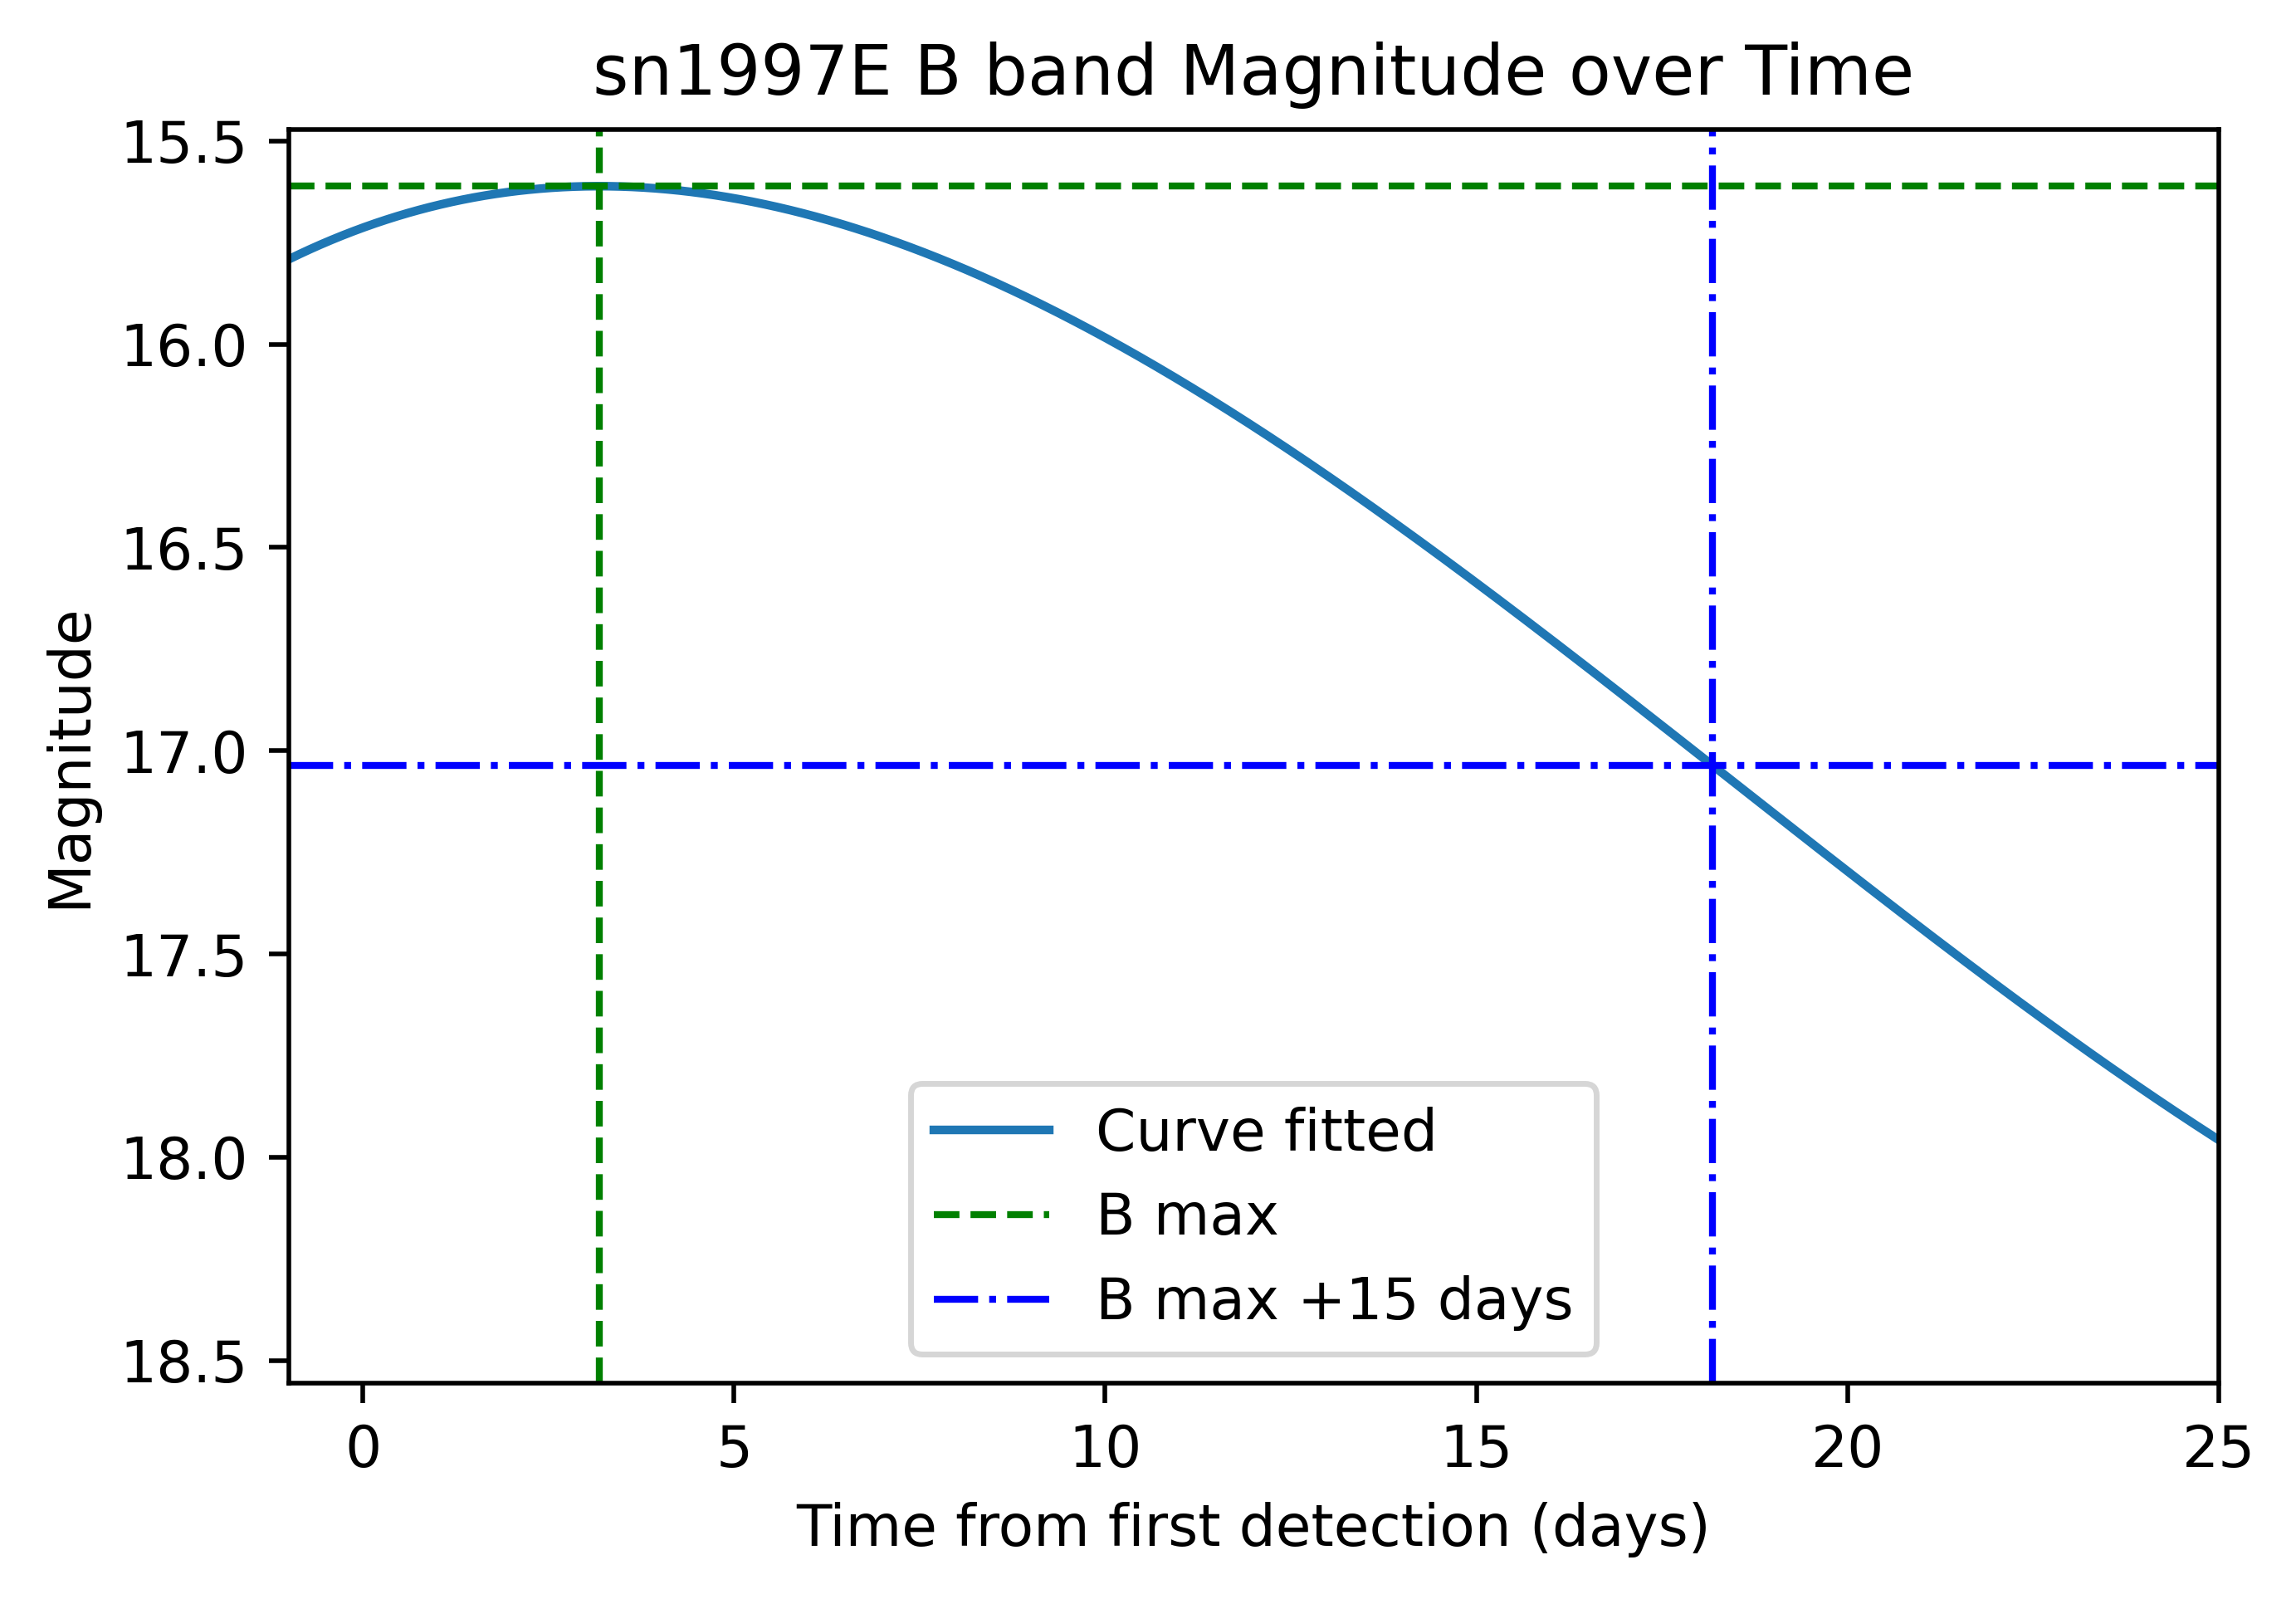

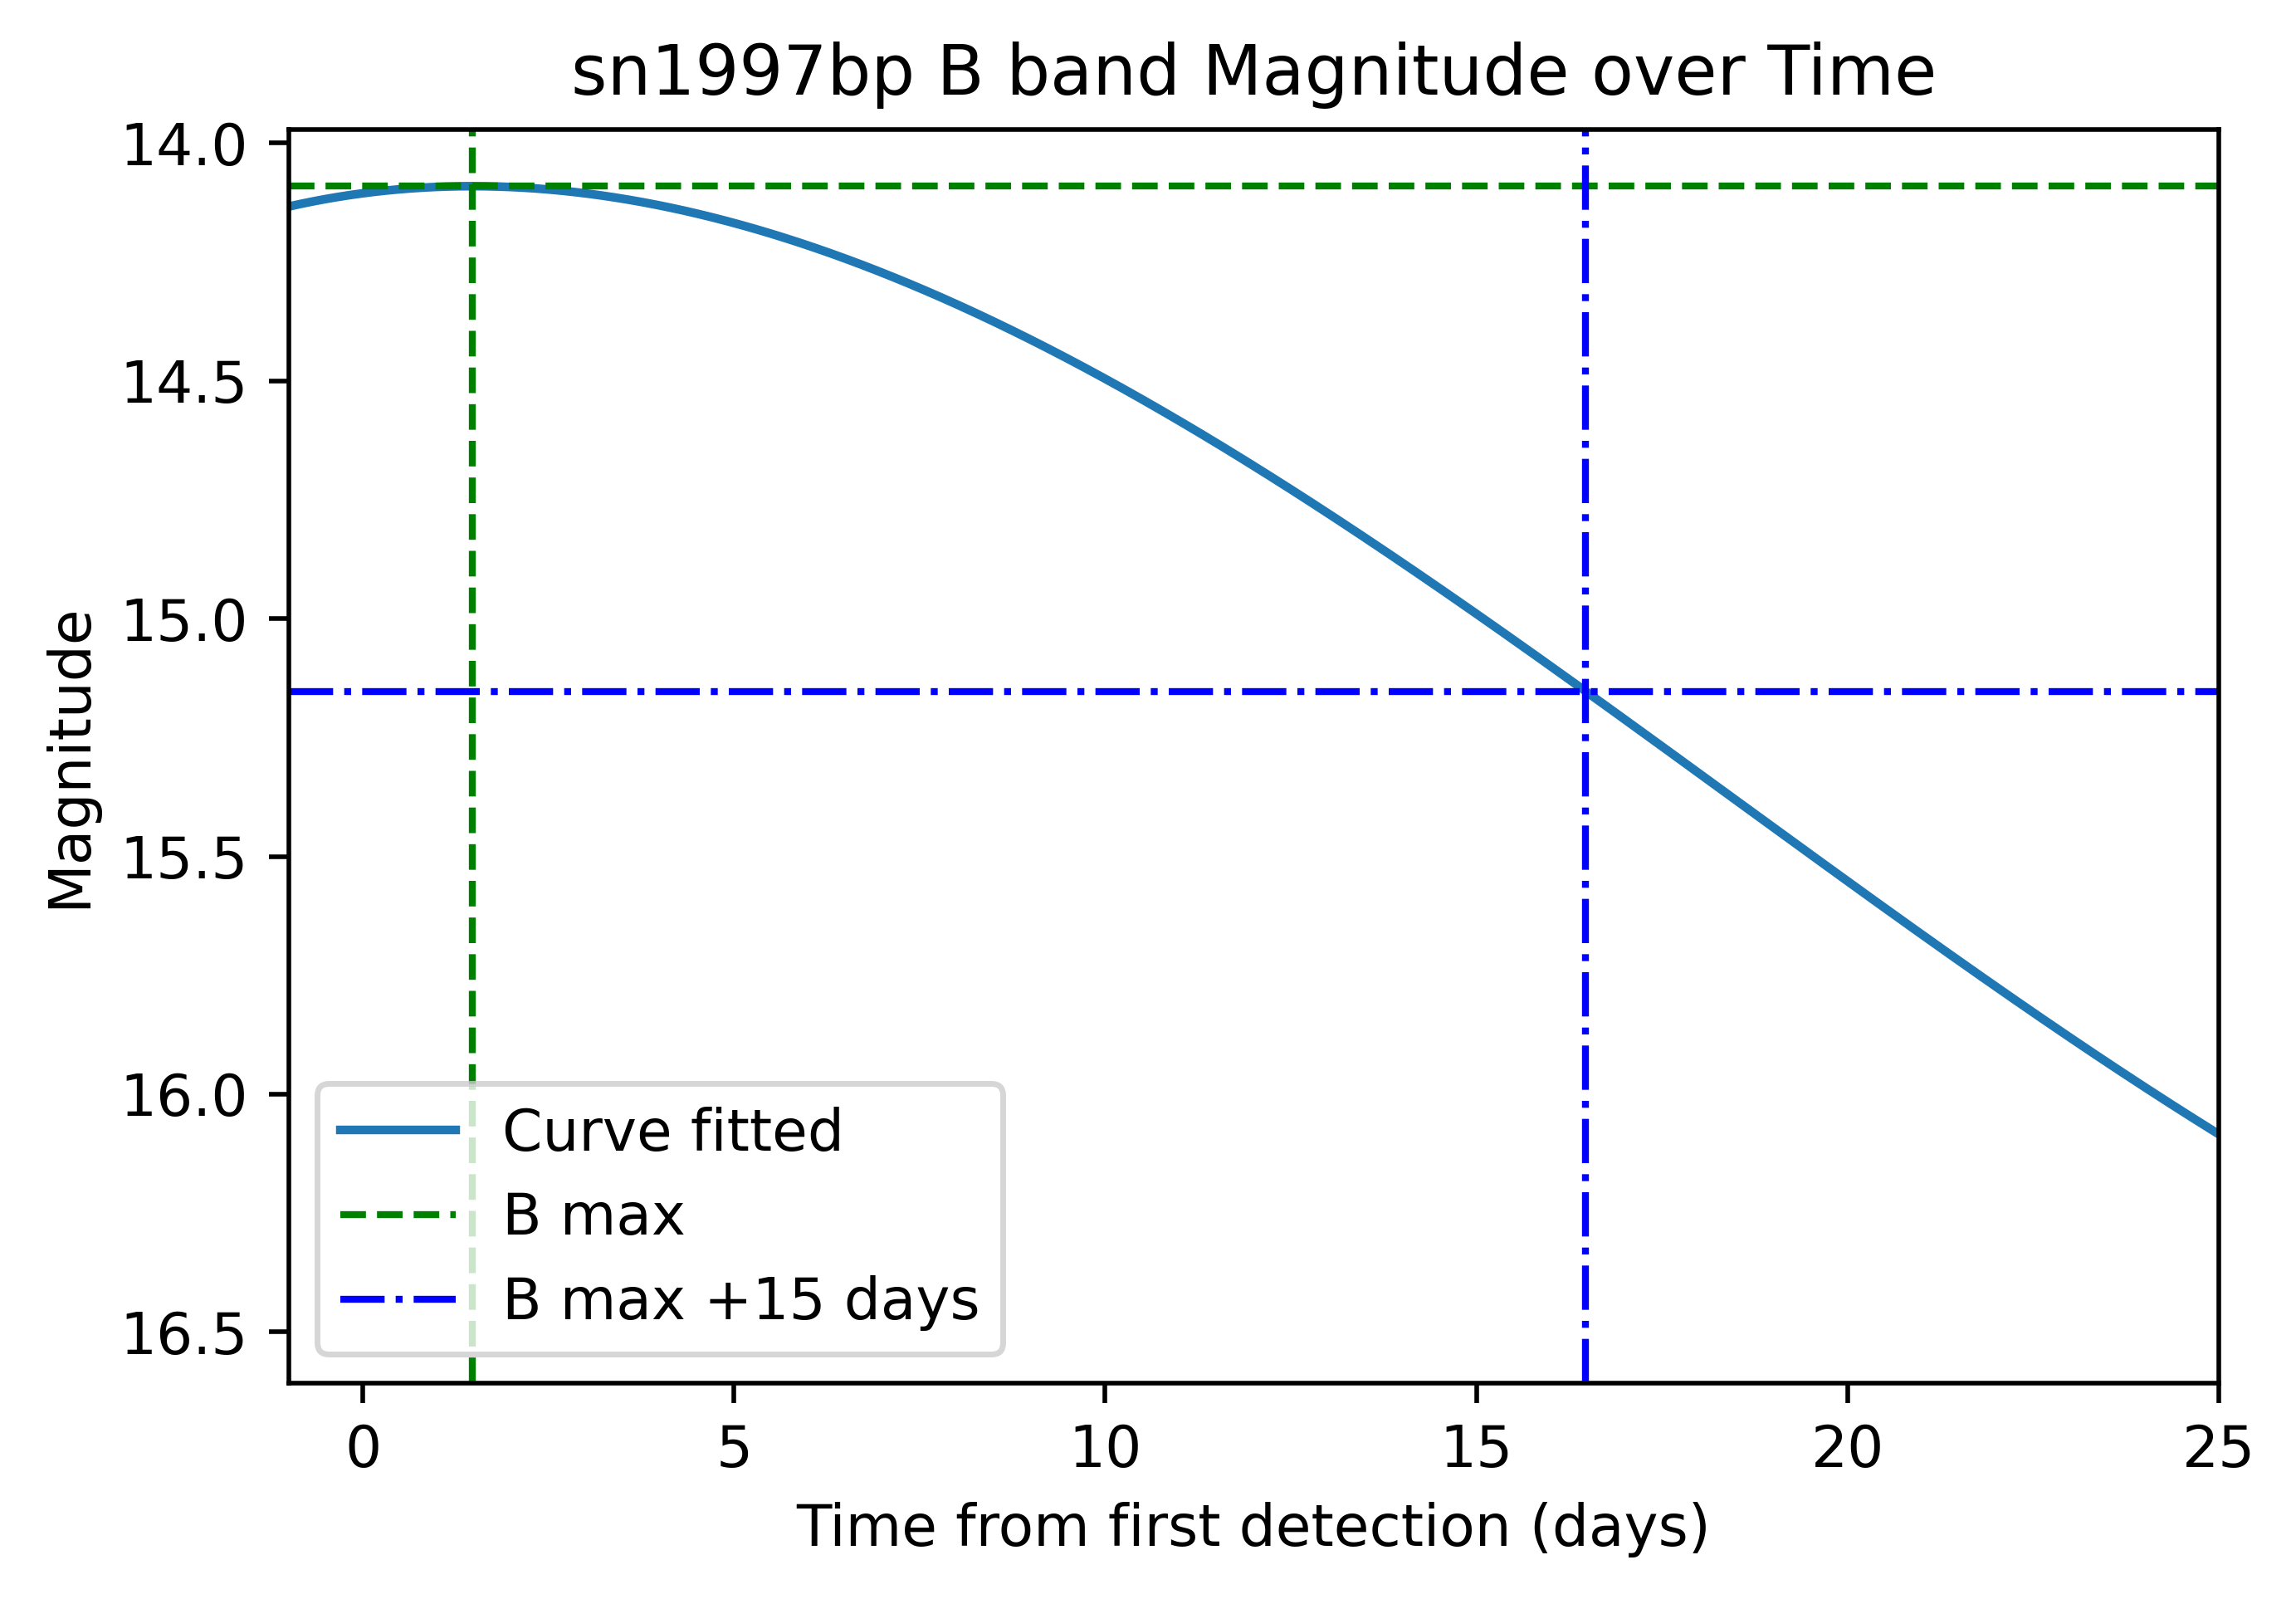

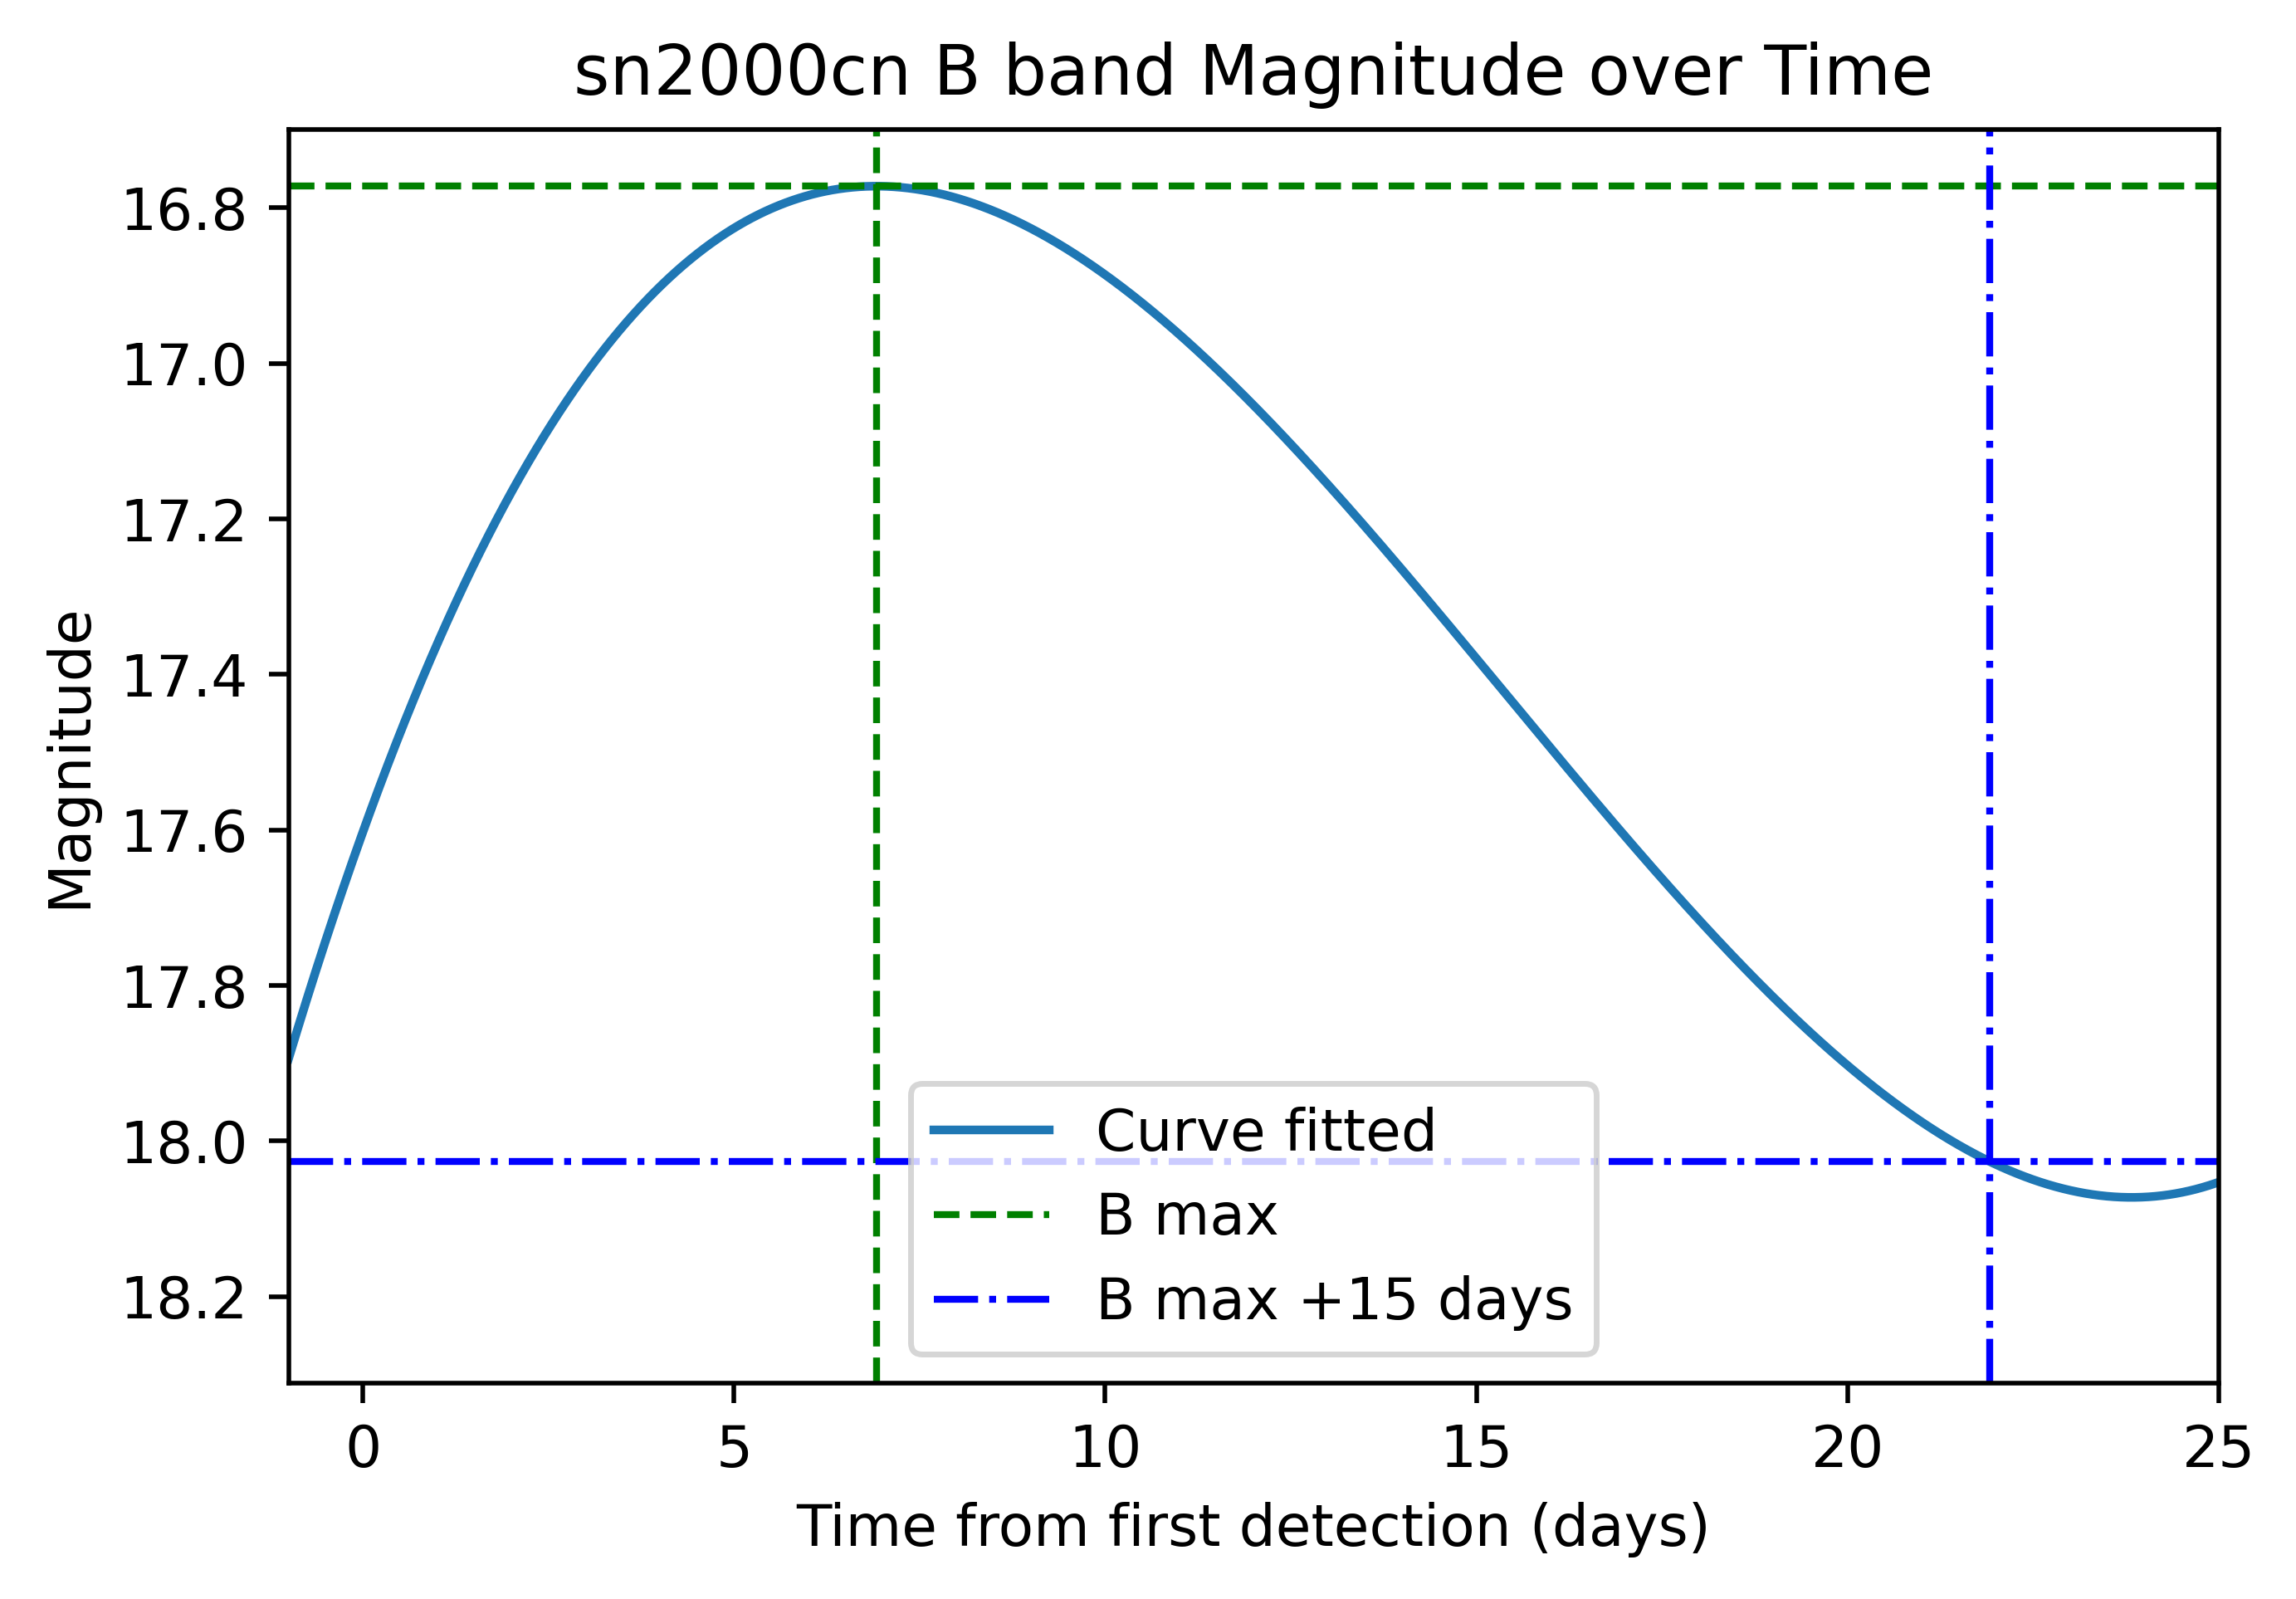

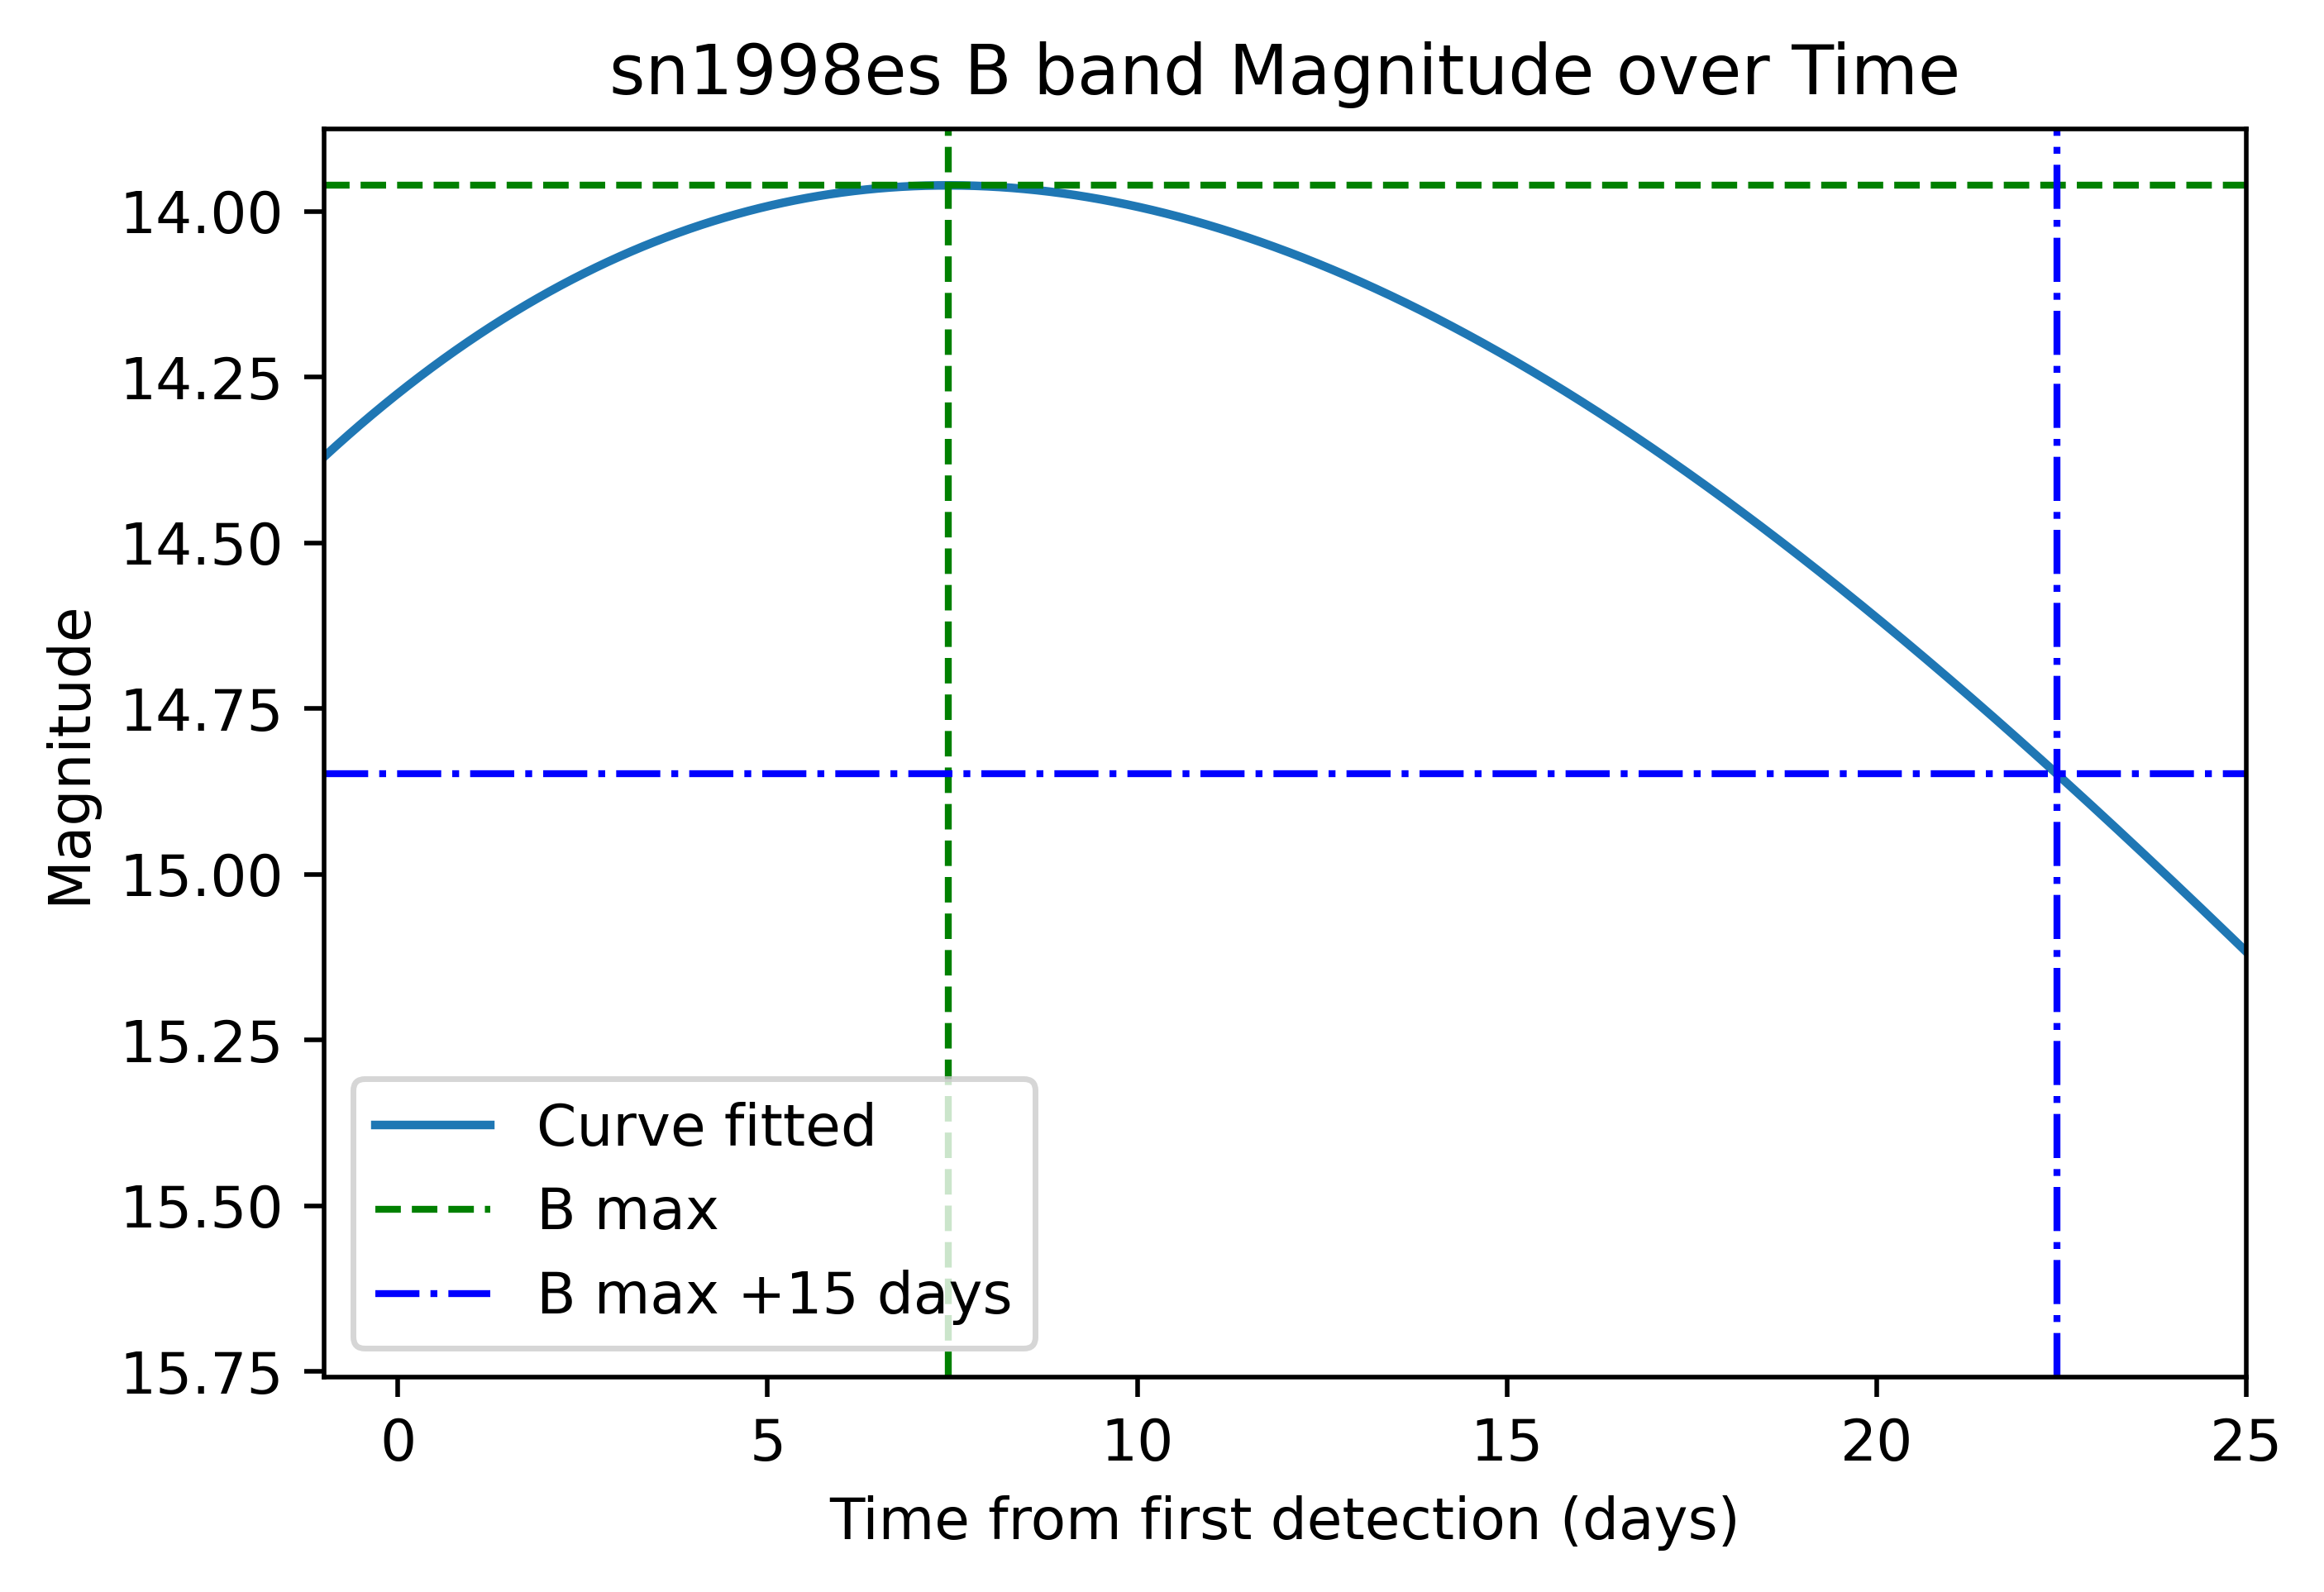

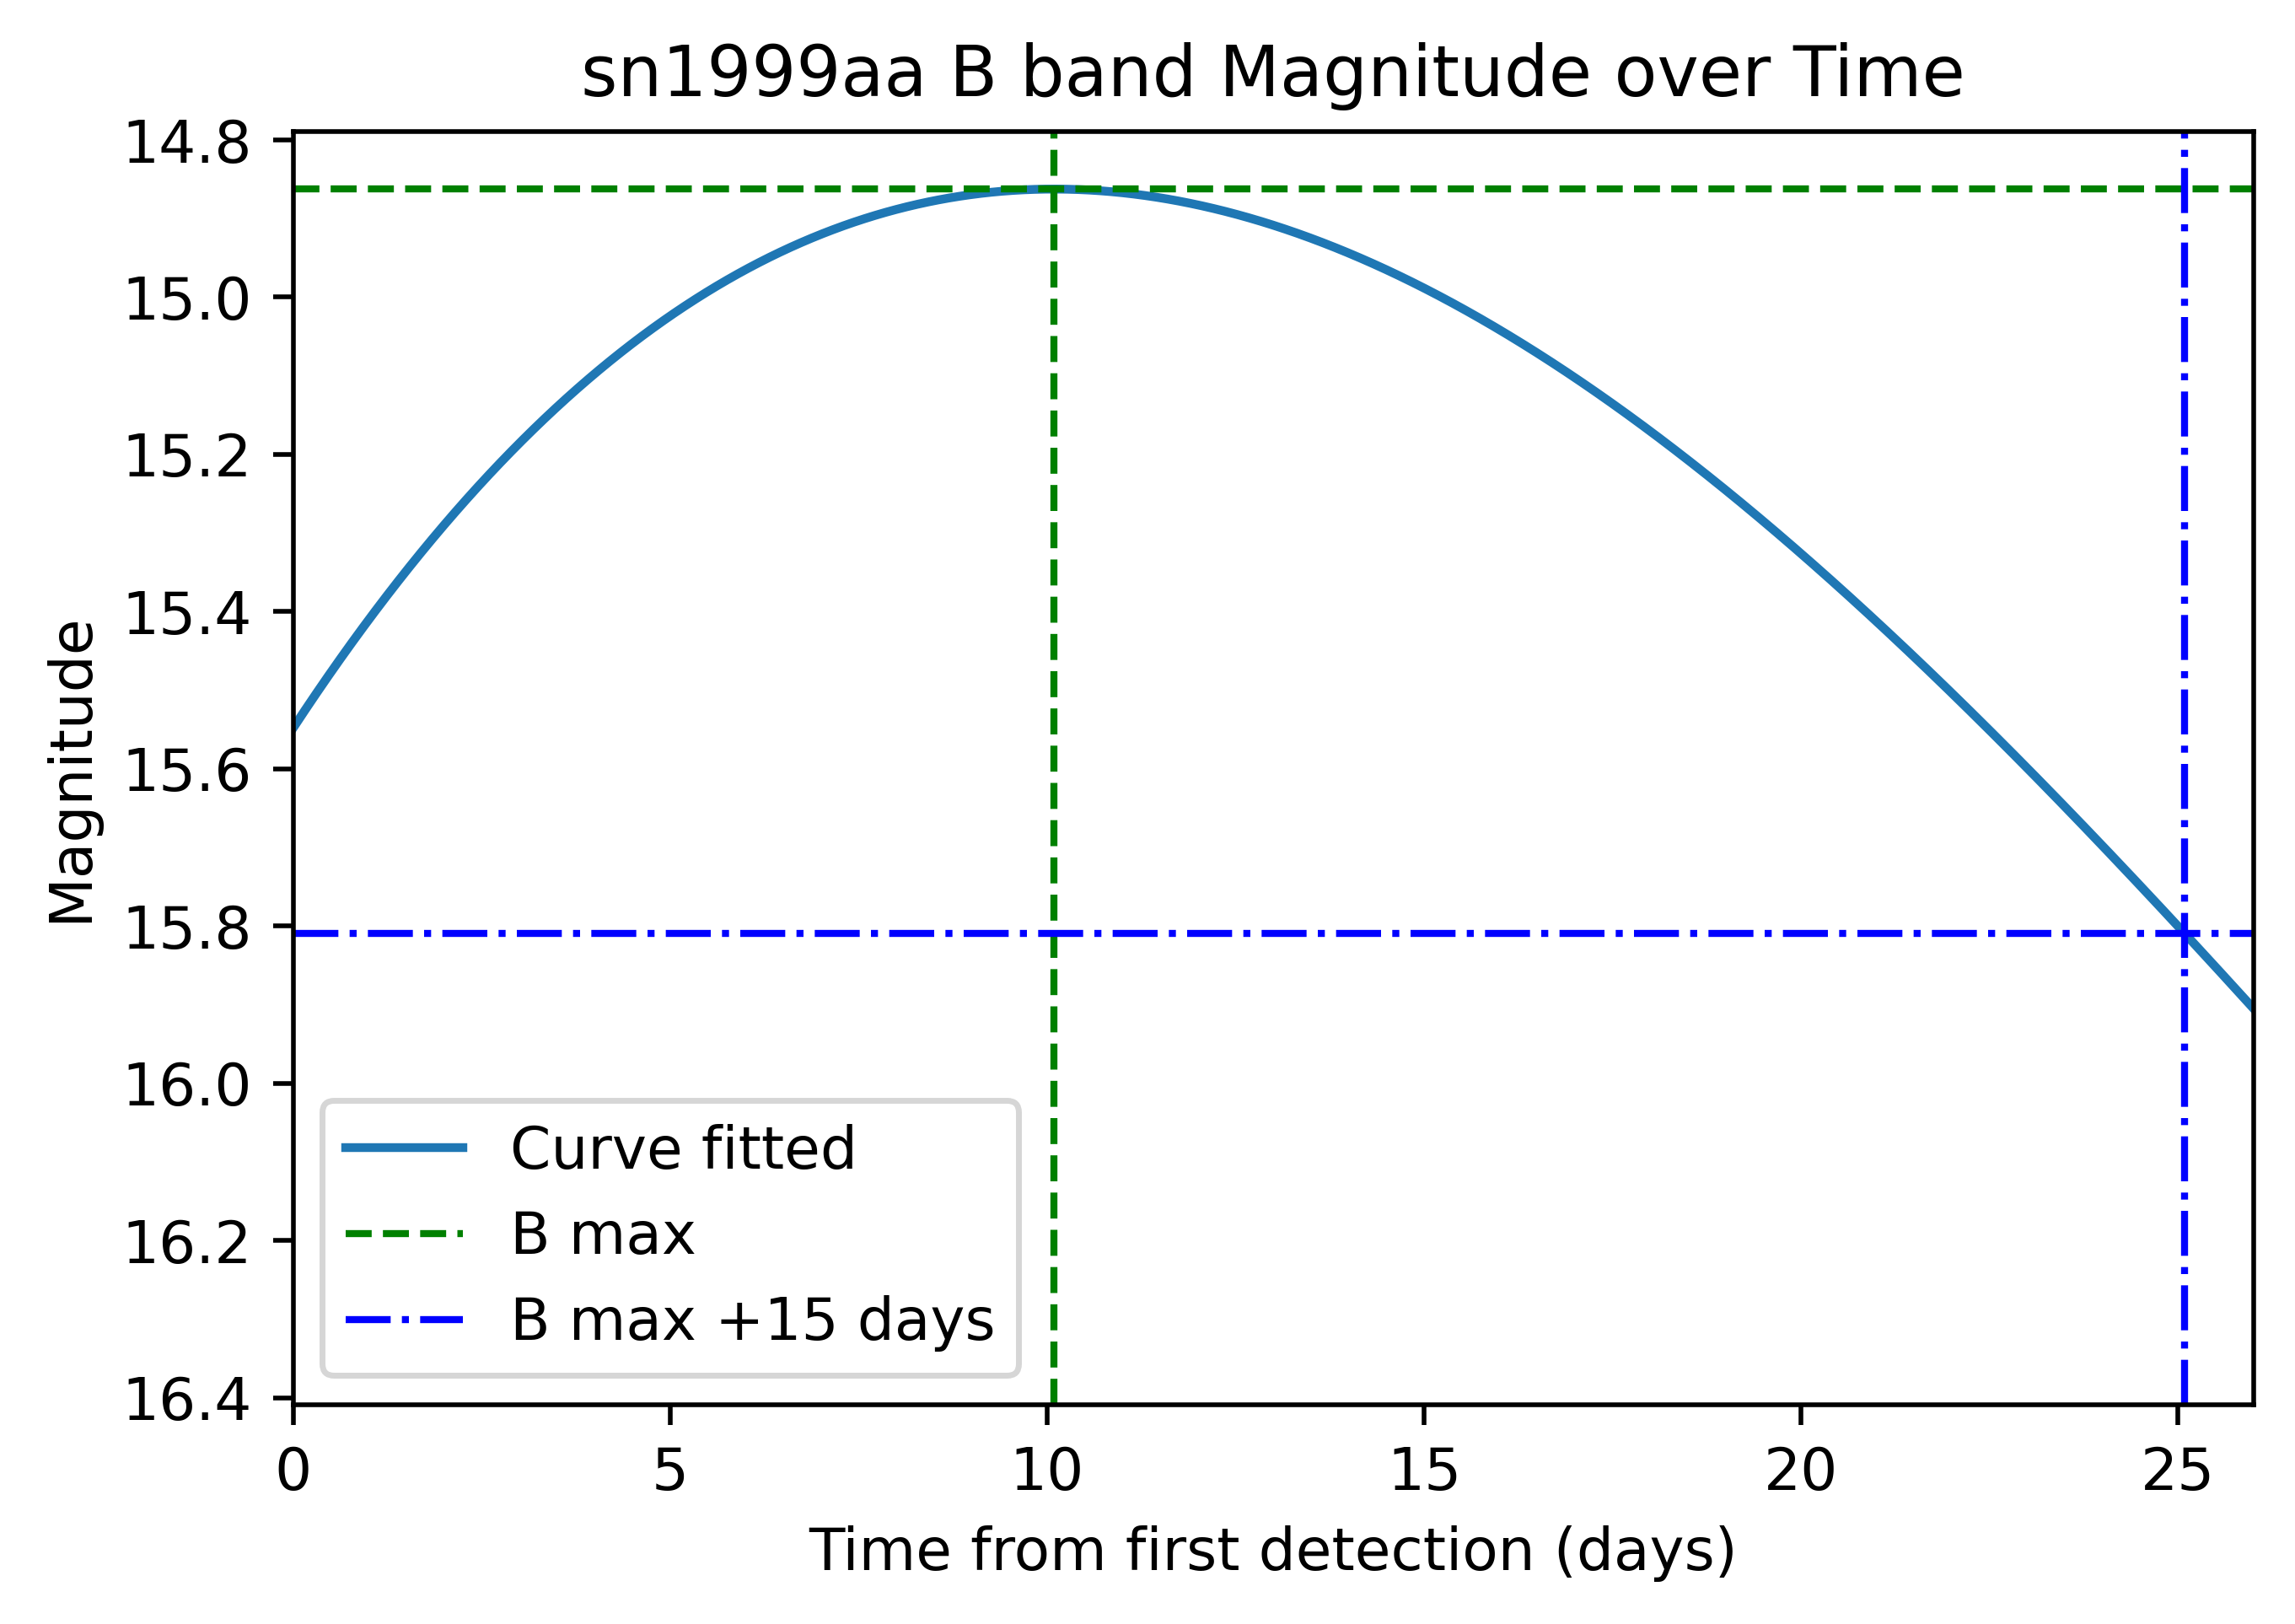

In [756]:
for i in range(len(sn_names)):
    xs = np.linspace(-2,30,16000,endpoint=False) #endpoint makes it so we can get exact integers
    ys = fits[i][0][0]*xs**3 + fits[i][0][1]*xs**2 + fits[i][0][2]*xs + fits[i][0][3]
    
    plt.figure(dpi=500)
    plt.plot(xs,ys,label='Curve fitted')
    plt.axvline(xs[np.argmin(ys)],lw=1.2,c='green',ls='--',label= r'B max')
    plt.axhline(ys[np.argmin(ys)],lw=1.2,c='green',ls='--')
    plt.axvline(xs[np.argmin(ys) +7500],lw=1.2,c='blue',ls='-.',label = r'B max +15 days')
    plt.axhline(ys[np.argmin(ys) +7500],lw=1.2,c='blue',ls='-.')
    plt.xlim(-1,25)
    if i==6: plt.xlim(0,26)
    plt.title(sn_names[i]+ ' B band Magnitude over Time')
    plt.xlabel('Time from first detection (days)')
    plt.ylabel('Magnitude')
    plt.legend()
    plt.gca().invert_yaxis()


In [757]:
#2000cn


# Part C

-1.1271199902474711
0.7789406678172841


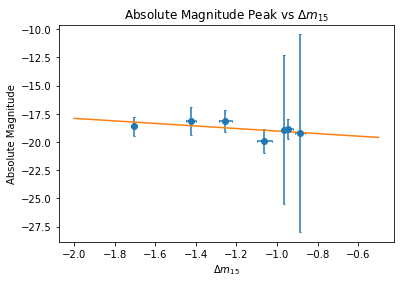

In [836]:
Flat_Model = FlatLambdaCDM(H0=70,Om0=1)
distances = Flat_Model.comoving_distance([entry[0] for entry in redshifts_A]) #in Mpc 
err_distances = Flat_Model.comoving_distance([entry[1] for entry in redshifts_A]) #in Mpc, relative error is the same as no error added from this model so can just calculate

def abs_magnitude(app_mag, distance):
    dist = distance * 10**6 #change Mpc to parsec
    abs_mag = app_mag - 5*np.log10(dist/10)
    return abs_mag

max_abs_mags = [abs_magnitude(mag[0], dist.value) for mag,dist in zip(max_app_mags,distances)]
err_max_abs_mags = []
for i in range(len(sn_names)):
    err_max_abs_mags.append( np.sqrt( max_app_mags[i][1]**2 + ((-5/np.log(10))*err_distances[i].value)**2 ))

#     print(sn_names[i])
#     print(max_abs_mags[i],'±',err_max_abs_mags[i])
# plt.figure(dpi=500)
plt.errorbar([a[0] for a in delta_m15s],max_abs_mags,yerr = err_max_abs_mags,xerr=[a[1] for a in delta_m15s],fmt='o',capsize=1)
# err_max_abs_mags
fit, cov = np.polyfit([a[0] for a in delta_m15s], max_abs_mags,1,cov=True)
plottingxvals = np.linspace(-2,-0.5)
plottingfit = np.polyval(fit,plottingxvals)
plt.plot(plottingxvals,plottingfit)
plt.ylabel('Absolute Magnitude')
plt.xlabel(r'$\Delta m_{15}$')

plt.title(r'Absolute Magnitude Peak vs $\Delta m_{15}$')
plt.savefig('absmagvsdeltam15',bbox_inches='tight')

slope_lm = fit[0] #slope of the luminosity decline relation
err_slope_lm = np.sqrt(np.diag(cov))[0]
# max_abs_mags


from guassian error propagation: 
$$\Delta z = \sqrt{\left(\Delta mag\right)^2 + \left( \frac{-5}{ln(10)} \Delta distance \right)} \\ z = f(mag, distance)$$

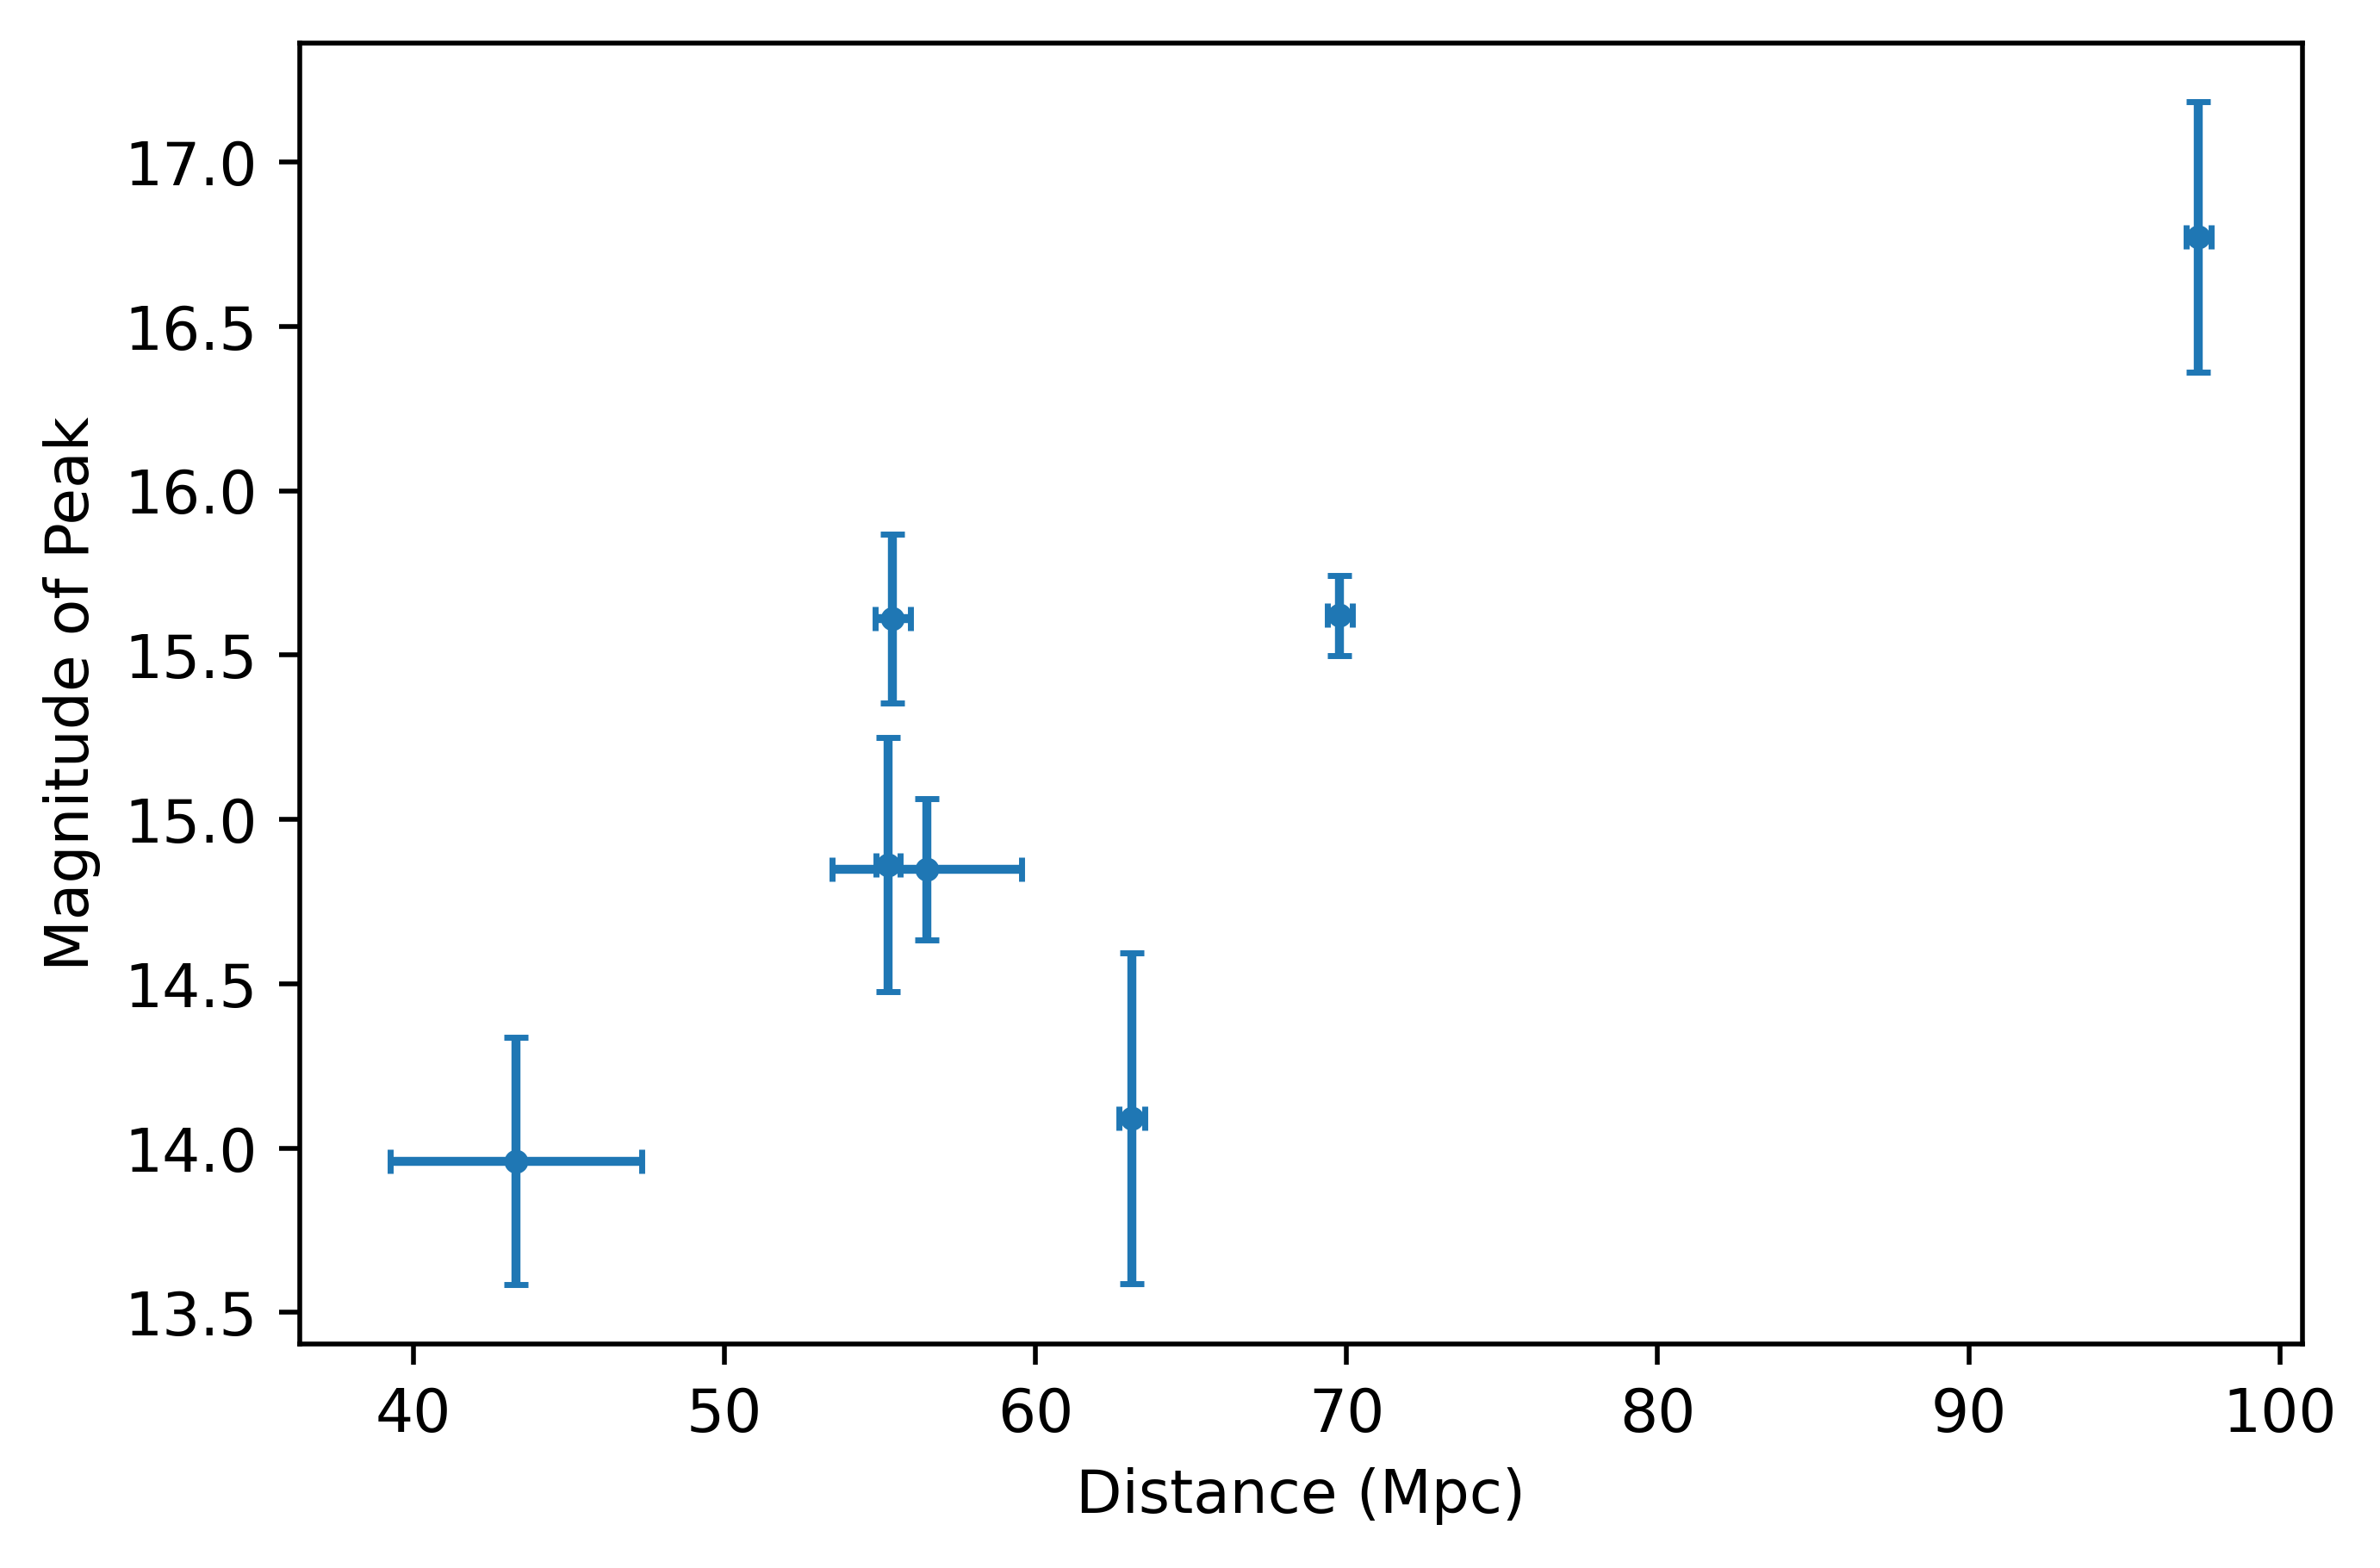

In [851]:
# plt.errorbar([a[0] for a in redshifts_A], [a[0] for a in max_app_mags],xerr=[a[1] for a in redshifts_A],yerr=[a[1] for a in max_app_mags],fmt='.',capsize=2)
plt.figure(dpi=500)
plt.errorbar(distances.value, [a[0] for a in max_app_mags],xerr=err_distances.value,yerr=[a[1] for a in max_app_mags],fmt='.',capsize=2)
plt.xlabel('Distance (Mpc)')
plt.ylabel('Magnitude of Peak')
# plt.savefig('Hubblenoncorrectedmag.png',bbox_inches='tight')
##add error to this


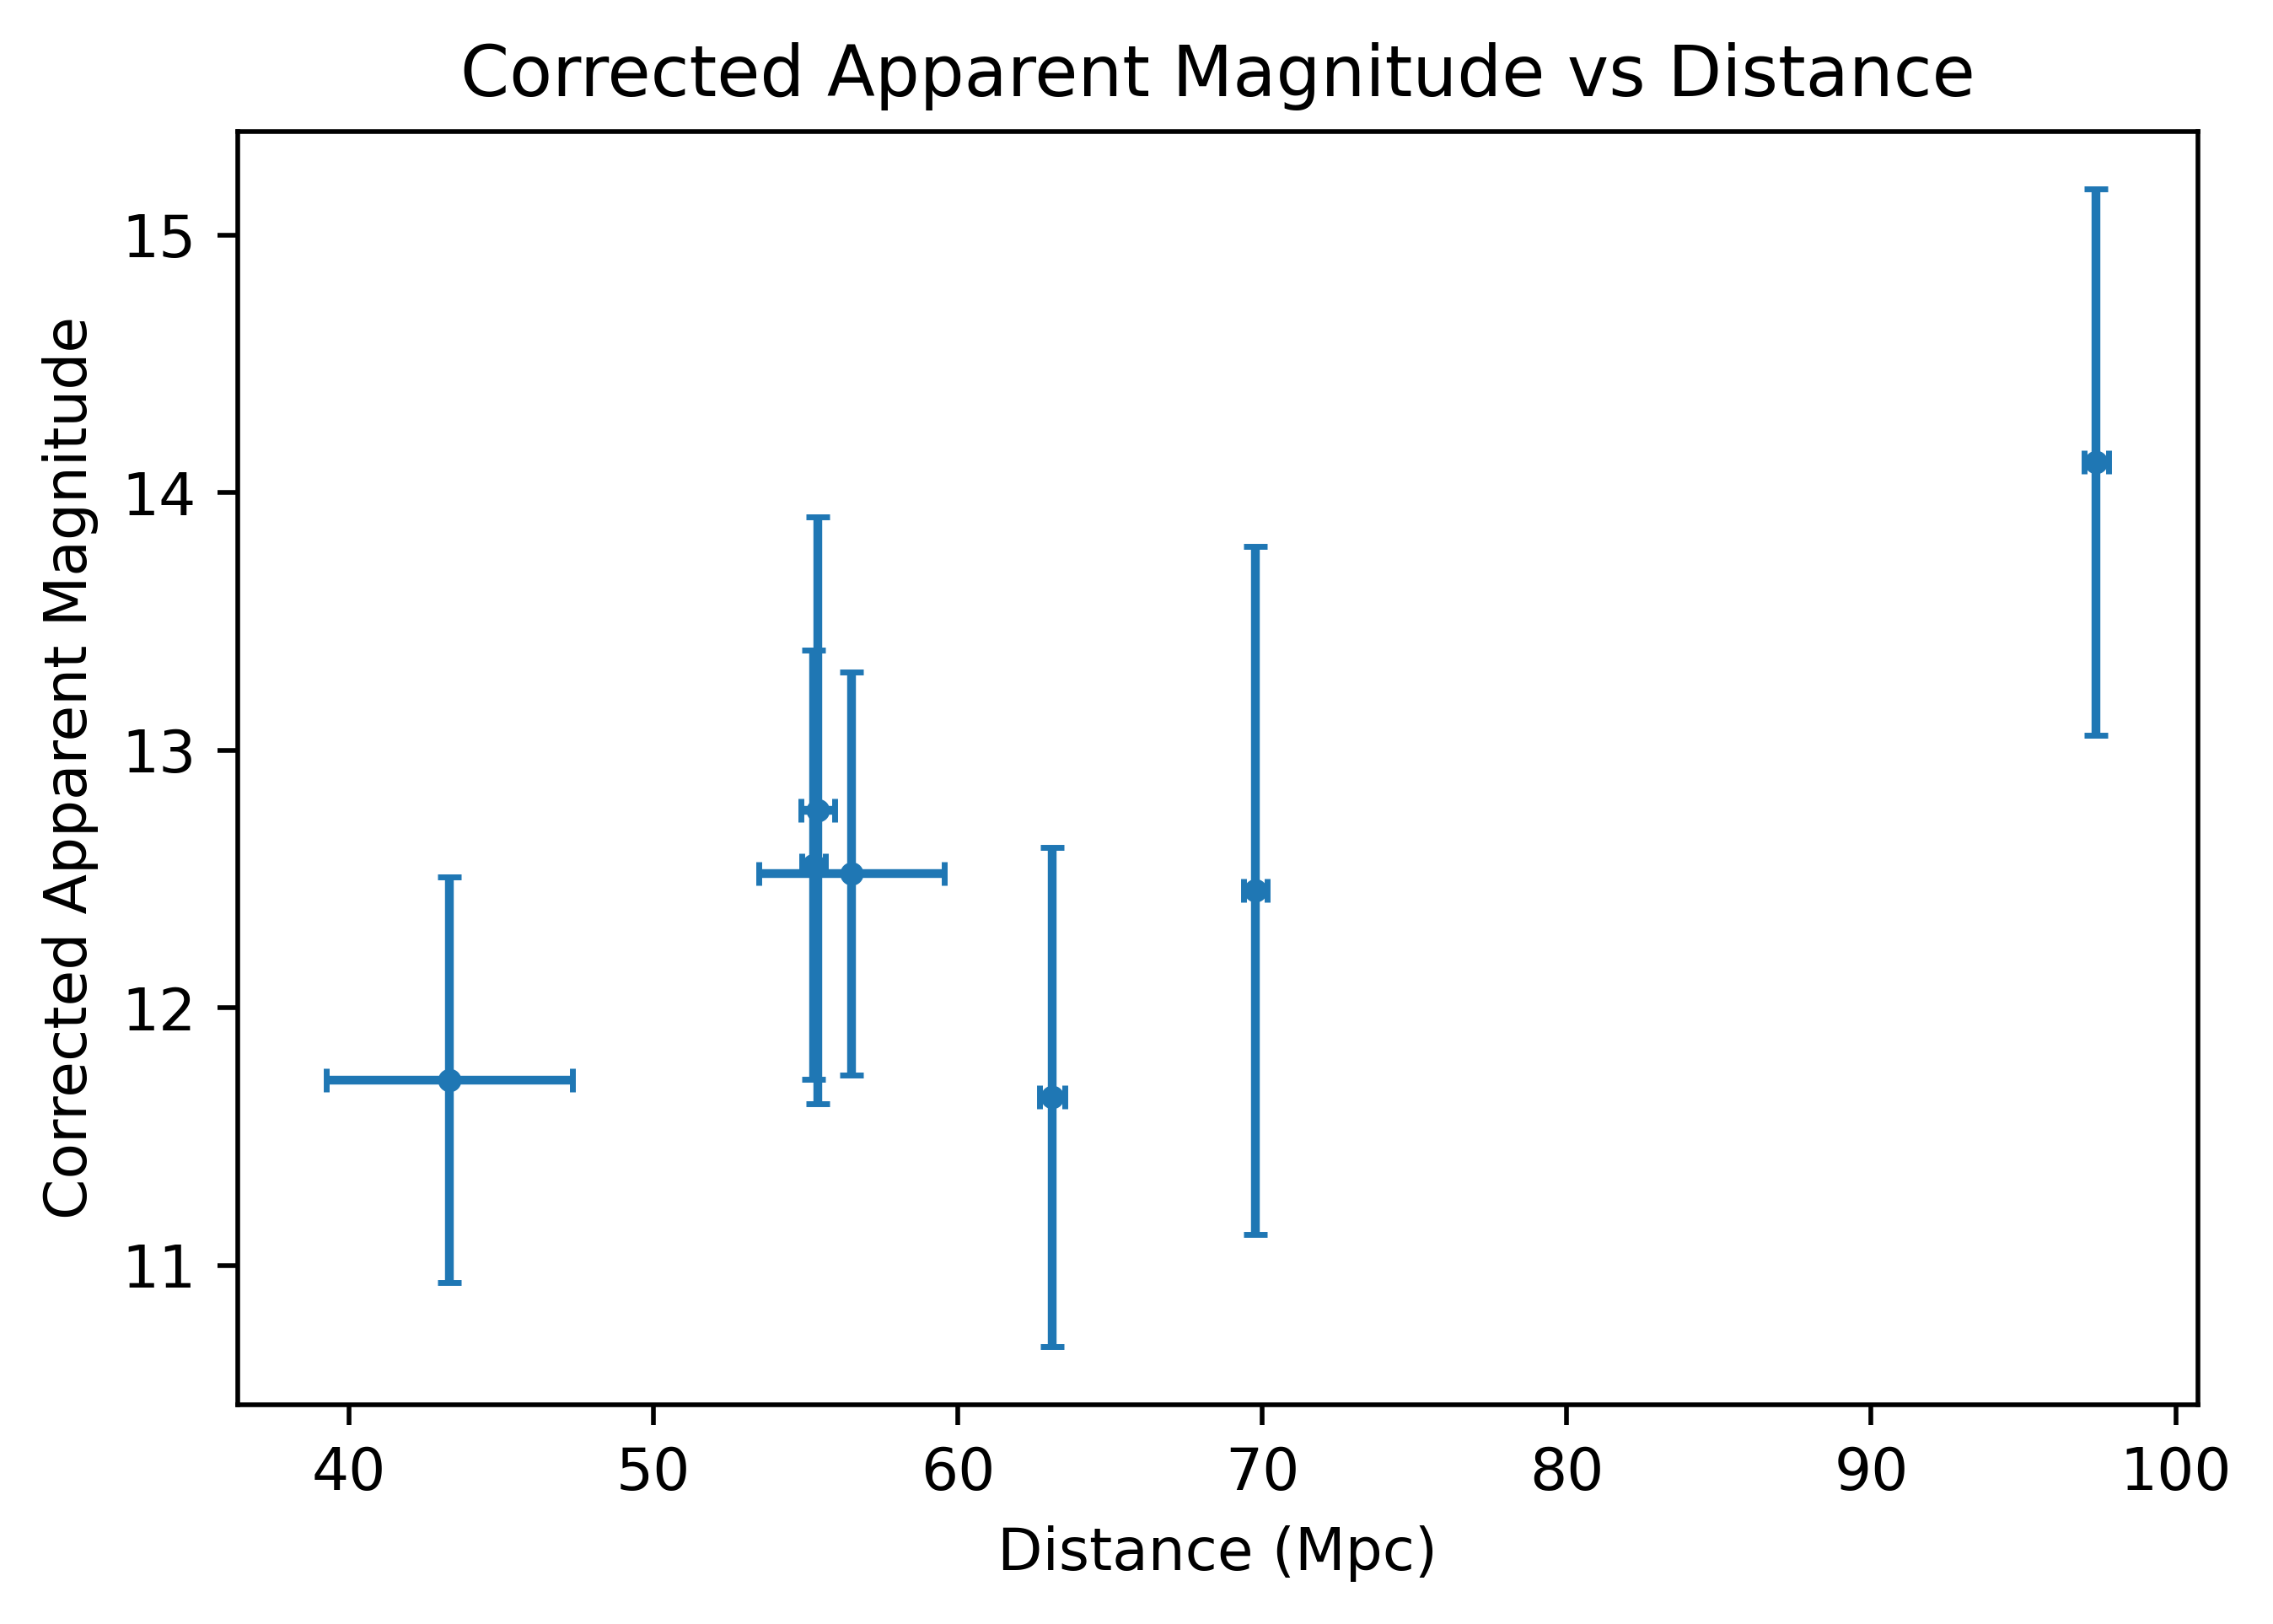

In [849]:
def maxBcorrection(mb, deltam15):
    #corrects the b band magnitude
    global slope_lm
    corrected = mb - slope_lm*(deltam15-1.1)
    return corrected
# corrected
# for i in range(len(sn_names)):
    
corrected_app_mag = [maxBcorrection(a[0],b[0]) for a,b in zip(max_app_mags, delta_m15s)]

#error (gaussian applied)
err_corrected_app_mag = []
for i in range(len(sn_names)):
    error = np.sqrt((1*max_app_mags[i][1])**2 + (delta_m15s[i][0]*err_slope_lm)**2 + (slope_lm*delta_m15s[i][1])**2)
    err_corrected_app_mag.append(error)
# err_corrected_app_mag = np.sqrt((1*[a[1] for a in max_app_mags])**2 + ([a[0] for a in delta_m15s]*err_slope_lm)**2 + (slope_lm*err_delta_m15)**2)
plt.figure(dpi=500)
plt.title('Corrected Apparent Magnitude vs Distance')
plt.ylabel('Corrected Apparent Magnitude')
plt.xlabel('Distance (Mpc)')
# plt.errorbar([a[0] for a in redshifts_A],corrected_app_mag,xerr= [a[1] for a in redshifts_A],yerr=err_corrected_app_mag, fmt='.',capsize=2)
# corrected_app_mag

plt.errorbar(distances.value,corrected_app_mag,xerr= err_distances.value,yerr=err_corrected_app_mag, fmt='.',capsize=2)
plt.savefig('Hubbleforcorrectedmag.png',bbox_inches='tight')

In [916]:
# print(chi2(fit1,line,distances.value,corrected_app_mag))
# print(chi2(fit2,line,distances.value,[a[0] for a in max_app_mags]))
#hubble vals of 160±70?!
#see end of script for problem - even fits have been lost

In [827]:
for i in range(len(sn_names)):
    print(sn_names[i])
    corrected_abs_mag = abs_magnitude(corrected_app_mag[i],distances[i].value)
    print(corrected_abs_mag,'±',err_corrected_app_mag[i]/corrected_app_mag[i] *abs(corrected_abs_mag))
    print()
    
#all are within error of eachother = standardisable candle 

sn2000dk
-21.762707329821293 ± 2.3333185966362278

sn1999dq
-21.23964814999524 ± 1.3265475965676383

sn1997E
-20.952200907780654 ± 1.8701752161358494

sn1997bp
-22.346750083132353 ± 1.857902482265213

sn2000cn
-20.823990423066725 ± 1.5639875150133702

sn1998es
-21.462526587430197 ± 1.4420485807884598

sn1999aa
-21.157066730061803 ± 1.403816338263192



# PART D

In [676]:
#read in the data into a dataframe
path="./Data_for_download2/"
filename="Allsupernovae.csv"
dataframe = pd.read_csv(path+filename)

In [677]:
dataframe

Name      zcmb      zhel  error         mb  error_mb        X1  \
0      03D1au  0.503084  0.504300      0  23.001698  0.088031  1.273191   
1      03D1aw  0.580724  0.582000      0  23.573937  0.090132  0.974346   
2      03D1ax  0.494795  0.496000      0  22.960139  0.088110 -0.728837   
3      03D1bp  0.345928  0.347000      0  22.398137  0.087263 -1.155110   
4      03D1co  0.677662  0.679000      0  24.078115  0.098356  0.618820   
..        ...       ...       ...    ...        ...       ...       ...   
735  sn2007co  0.027064  0.026962      0  16.504006  0.141685 -0.137806   
736  sn2007cq  0.025468  0.025918      0  15.797848  0.143429 -0.657941   
737   sn2007f  0.023810  0.023590      0  15.895501  0.144315  0.618766   
738  sn2007qe  0.023867  0.024000      0  16.068268  0.144350  0.760605   
739  sn2008bf  0.022068  0.021275      0  15.718540  0.144685  0.430639   

     error_X1         c   error_c  ...  Mst_lower  logSFR  SFR_upper  \
0    0.150058 -0.012353  0.030011  ...      9.460    0.63      1.210   
1    0.273823 -0.025076  0.036691  ...      9.070    0.87      0.900   
2    0.102069 -0.099683  0.030305  ...     11.530   <(-3)        NaN   
3    0.112834 -0.040581  0.026679  ...     10.800    0.71      1.040   
4    0.404295 -0.039380  0.067403  ...      8.630   -0.06      0.600   
..        ...       ...       ...  ...        ...     ...        ...   
735  0.061153  0.105288  0.020382  ...     -1.000     -99    -99.000   
736  0.115645 -0.060805  0.025820  ...      8.323  -0.119      0.676   
737  0.041400 -0.055411  0.026006  ...      9.902   0.852      1.143   
738  0.045650  0.052186  0.026200  ...      7.863  -0.453      0.351   
739  0.068523 -0.038367  0.021262  ...     10.967     -99      0.020   

     SFR_lower  logsSFR  sSFR_upper  sSFR_lower  local_SFR  local_SFR_upper  \
0        0.000   -8.920      -8.250      -9.680        NaN              NaN   
1        0.500   -8.340      -8.170      -8.750        NaN              NaN   
2          NaN      NaN         NaN         NaN        NaN              NaN   
3        0.380  -10.140      -9.760     -10.670        NaN              NaN   
4       -0.490   -8.750      -8.030      -9.680        NaN              NaN   
..         ...      ...         ...         ...        ...              ...   
735    -99.000  -99.000     -99.000     -99.000        NaN              NaN   
736     -0.463  -10.837      -8.320     -11.247     -1.873           -1.692   
737      0.537   -9.175      -8.770      -9.531     -1.888           -1.714   
738     -1.177  -11.131      -8.320     -11.247     -4.010           -3.858   
739    -99.000  -99.000     -11.018     -99.000        NaN              NaN   

     local_SFR_lower  
0                NaN  
1                NaN  
2                NaN  
3                NaN  
4                NaN  
..               ...  
735              NaN  
736           -2.201  
737           -2.142  
738           -4.307  
739              NaN  

[740 rows x 59 columns]

In [700]:
alpha, err_alpha = 0.141 ,0.006 
beta, err_beta = 3.101, 0.075
MB, err_MB = -19.05, 0.02 #mag
delta_m, err_delta_m = -0.07, 0.02


#defining the distance modulus function
def mufinder(mBstar, x1, colour, mass):
    global MB,alpha,beta,delta_m
    
#     if mass >= 10**10:
#         MB = delta_m + MB
        
    mu = mBstar - MB + alpha*x1 - beta*colour
    return mu

def residuals(params, f, x, y,s=1):
    
    res = (y - f(params,x) )/s
    return res



'NEED to include a step function for high mass stars! for MB'

In [889]:
#extract the data from the dataframe: colours, mBstars, x2s, redshifts, stellar masses
colours, err_colours = dataframe.c, dataframe.error_c ; mBstars, err_mBstars = dataframe.mb, dataframe.error_mb
x1s, err_x1s = dataframe.X1, dataframe.error_X1 ; redshifts = dataframe.zcmb #no error in these?
stellar_masses, err_stellar_masses = dataframe.LogMst, dataframe.error_Mst
stellar_masses = 10**stellar_masses #removing the log. the error is not log error, it should say in df if so. 

new_stellar_masses = []
for i in range(len(stellar_masses)):
    if stellar_masses[i] >= 10**10:
        new_stellar_masses.append(stellar_masses[i] + delta_m)
    else:
        new_stellar_masses.append(stellar_masses[i])

#find mu:
mus = [mufinder(mBstars[i],x1s[i],colours[i],stellar_masses[i]) for i in range(len(mBstars))]
err_mus = [np.sqrt((err_mBstars[i])**2 + (err_MB)**2 + (x1s[i]*err_alpha)**2 + (alpha*err_x1s[i])**2 + (-colours[i]*err_beta)**2 + (-beta*err_colours[i])**2) for i in range(len(colours))]

$\Delta \mu = \left((\Delta m^B_*)^2 + (\Delta MB)^2 + (x_1 \Delta \alpha)^2 + (\alpha \Delta x_1)^2 + (-colour \Delta \beta )^2 + (- \beta \Delta colour)  \right)^{\frac{1}{2}}$

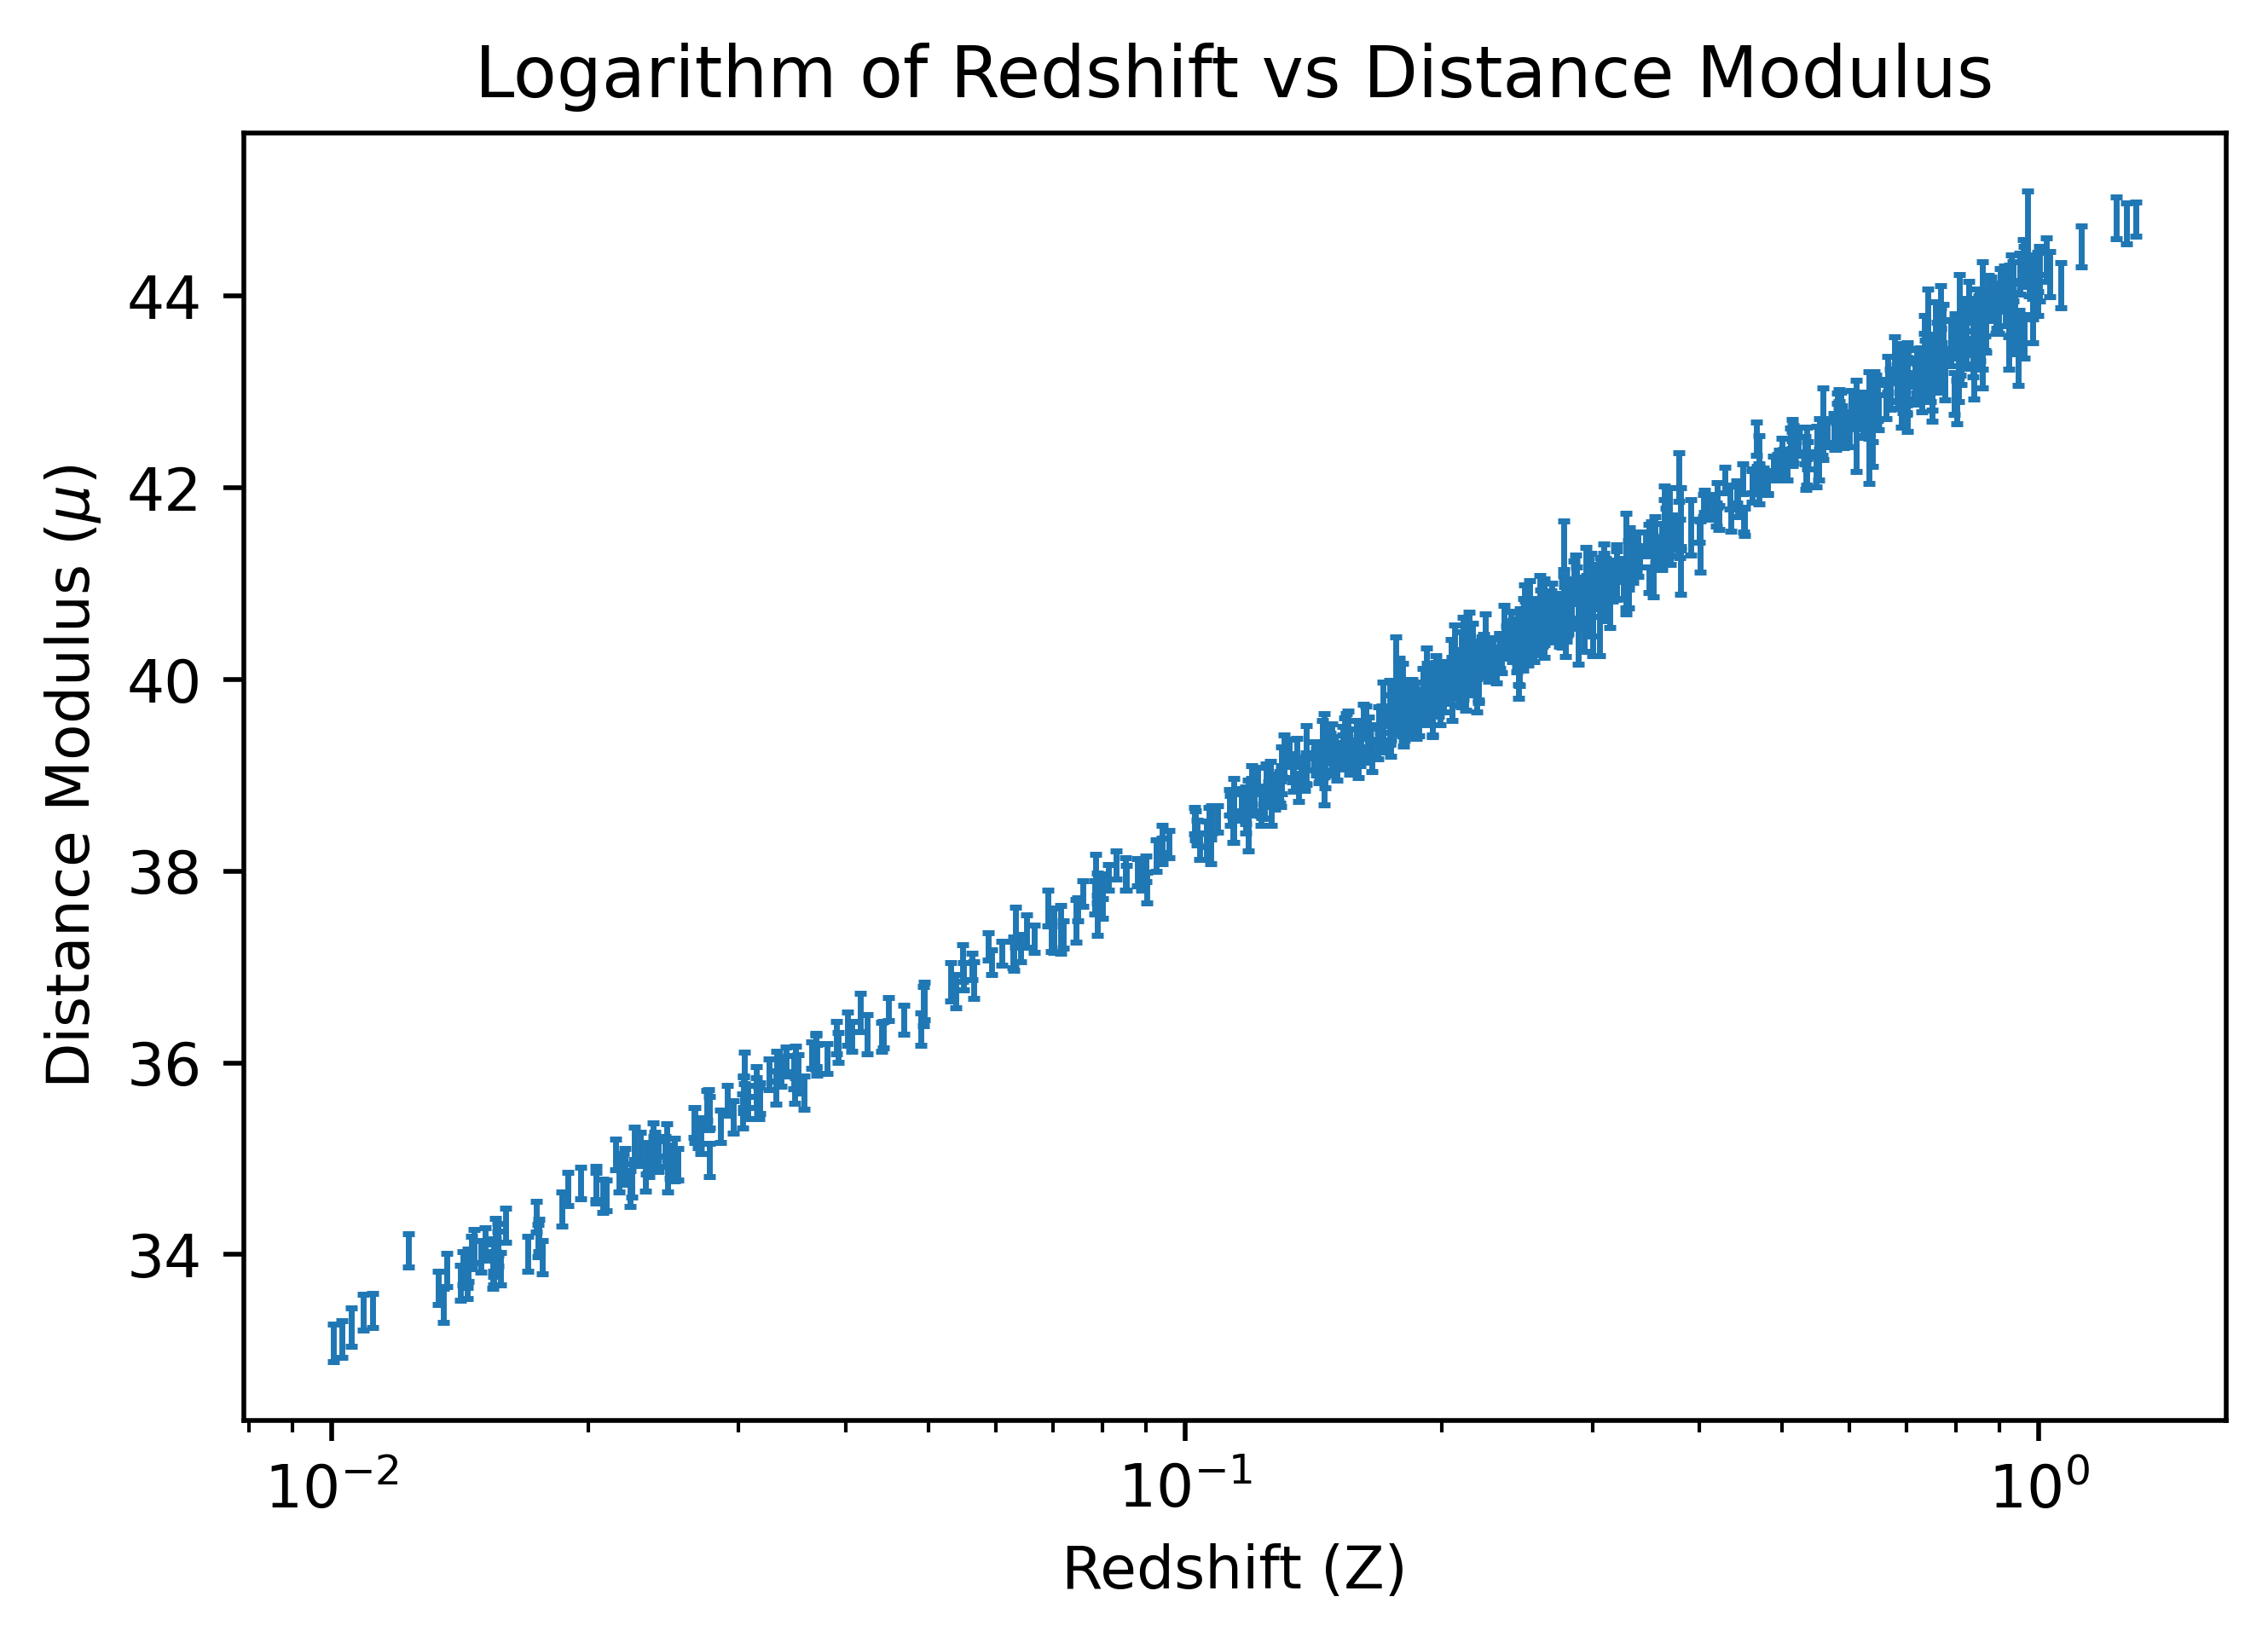

In [899]:
fig, ax = plt.subplots(dpi=500)
ax.errorbar(redshifts,mus,yerr= err_mus,fmt='none',capsize=1,elinewidth = 1)
ax.set_title('Logarithm of Redshift vs Distance Modulus')
ax.set_xscale('log')
ax.set_ylabel(r'Distance Modulus ($\mu$)')
ax.set_xlabel(r'Redshift (Z)')
plt.savefig('redshiftvsdistmodulus',bbox_inches='tight')

In [681]:
#why is this on a log scale? - doesn't mention in the script but looks correct
#nned to add error stuff too no z error but zhel??


In [682]:
#task 2 - comparison to different models 
c = const.c
H_0 = 70 * u.km /( u.s*u.Mpc)

def distance(z):
    global c,H_0
    
    d = (c*z/H_0)*(1+z/2)
    return d

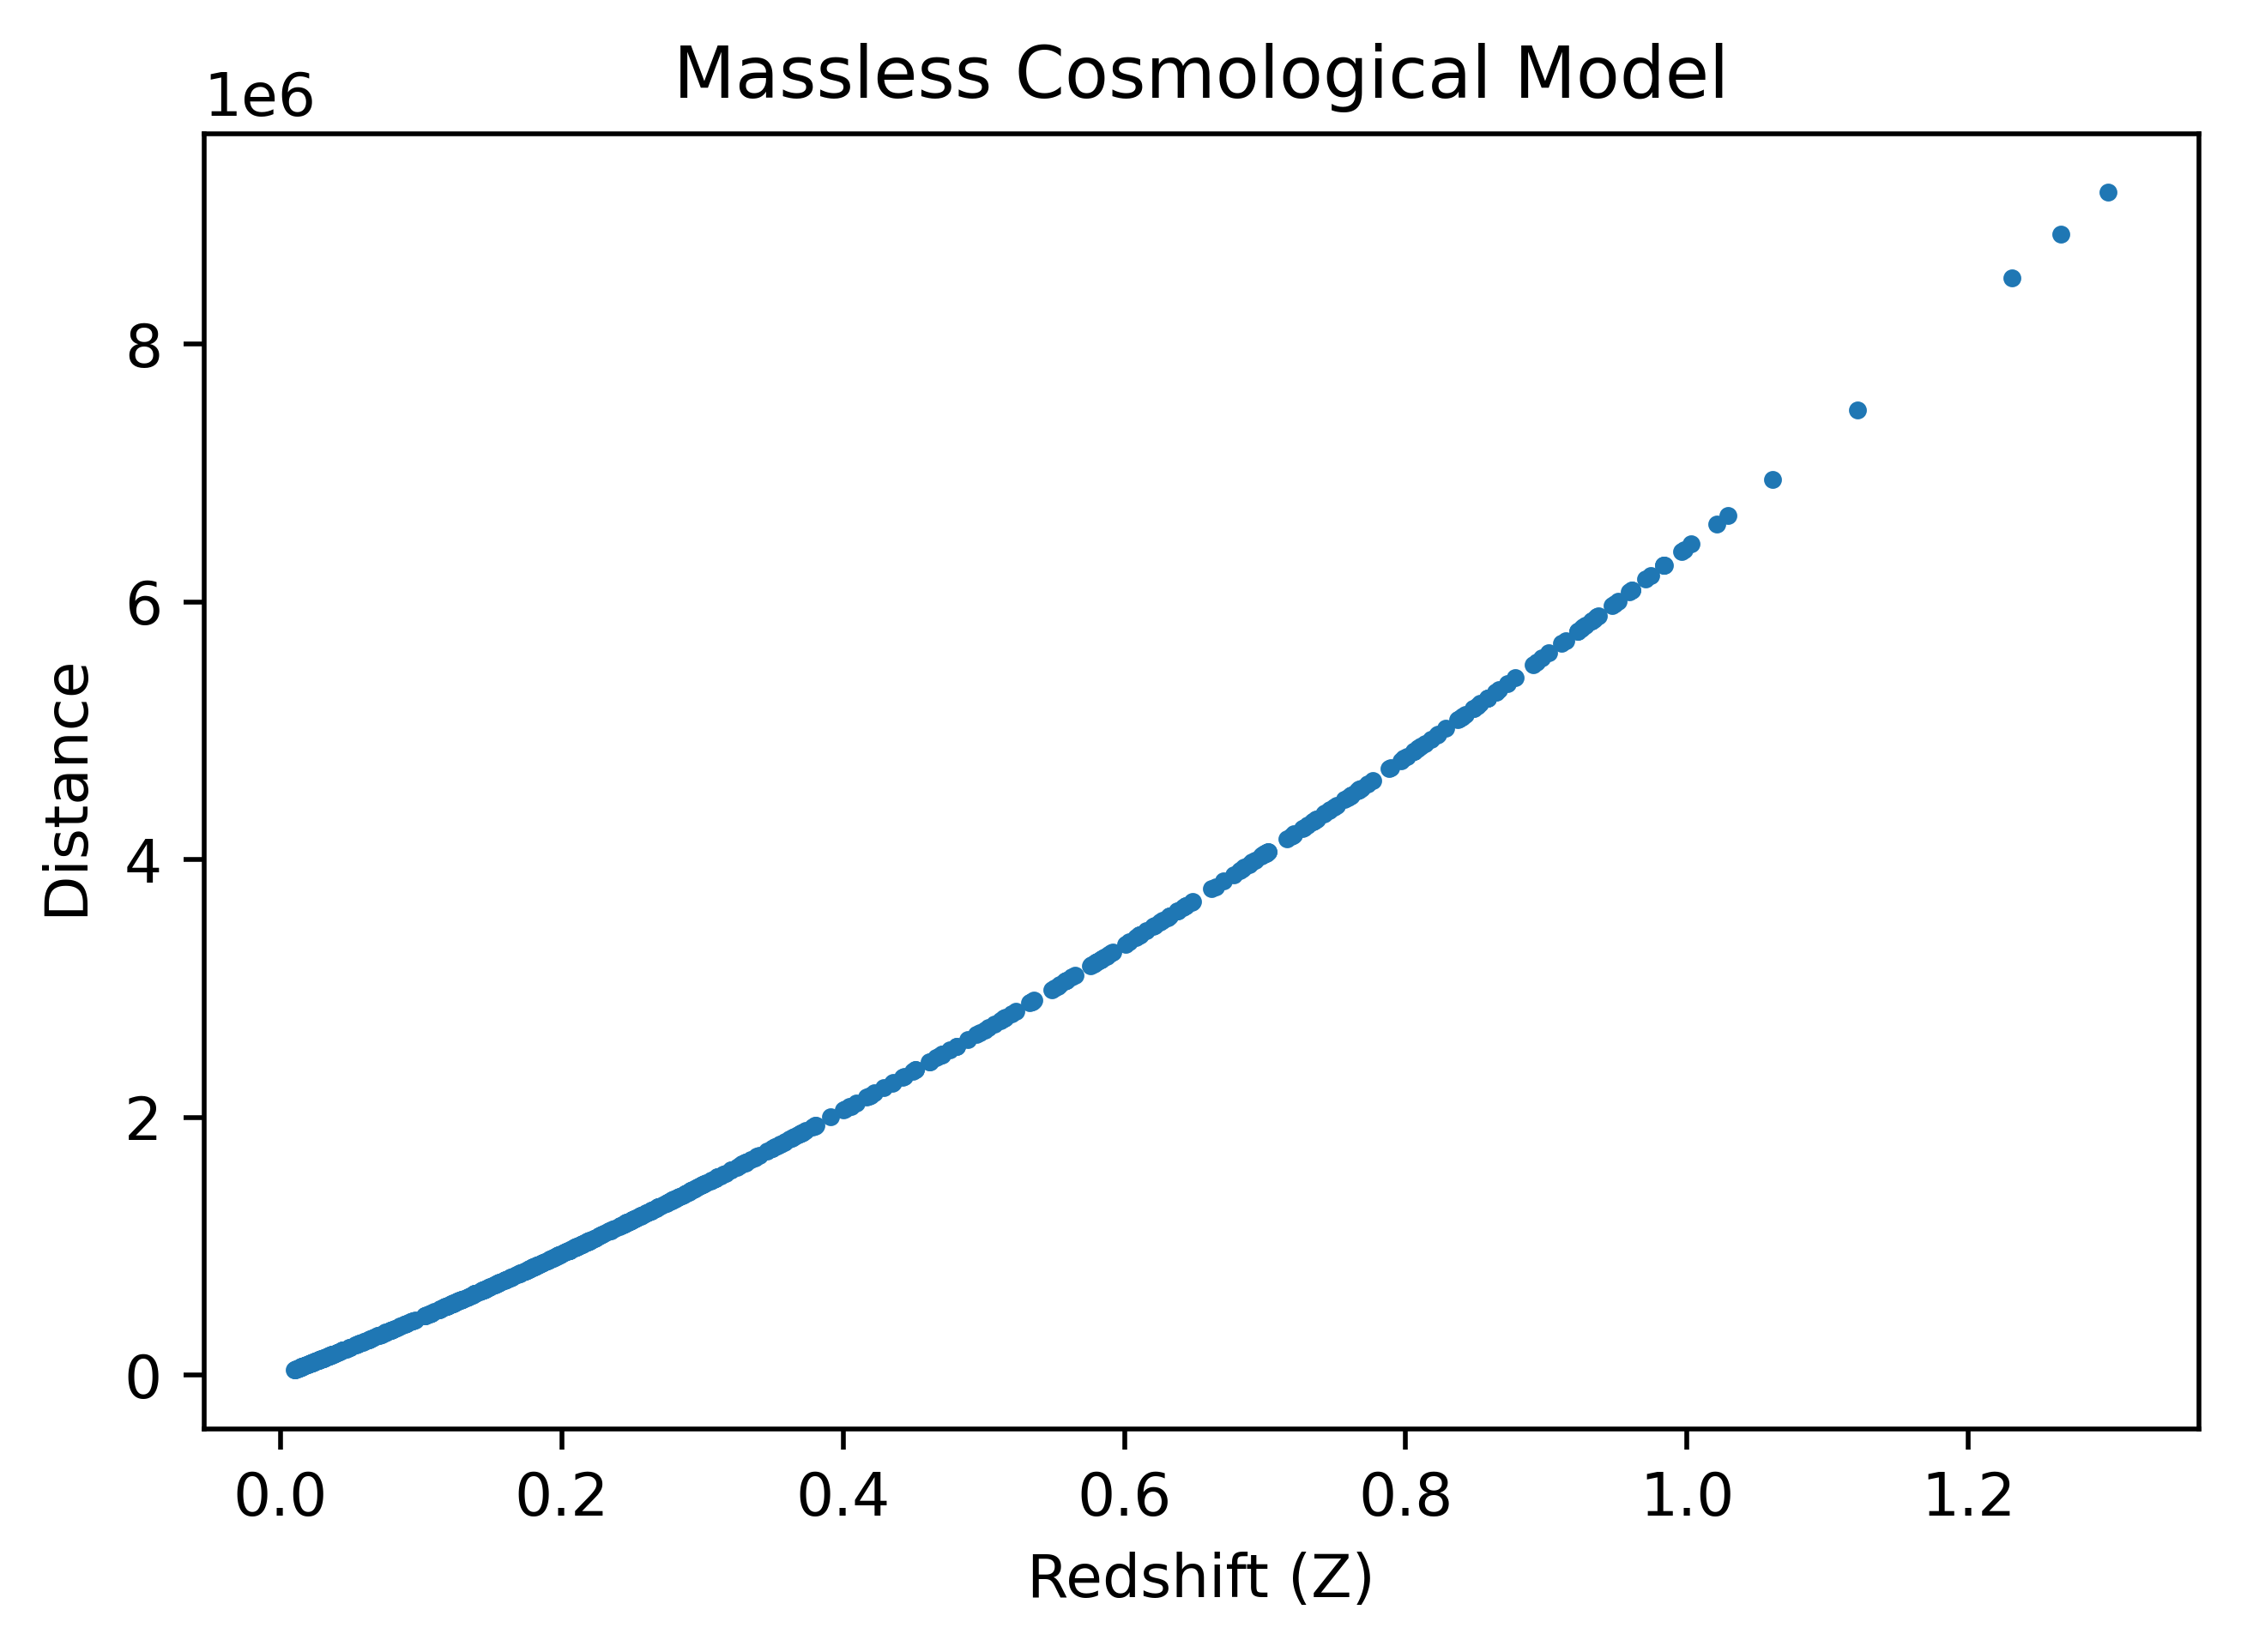

In [856]:
massless = distance(redshifts)
plt.figure(dpi=500)
plt.scatter(redshifts, massless,s=4)
#this isnt dist modulus

# plt.xscale('log')
plt.ylabel(r'Distance ') 
plt.xlabel(r'Redshift (Z)')
plt.title('Massless Cosmological Model')
plt.savefig('masslessmodel',bbox_inches='tight')

In [684]:
#FlatLambdaCDM in astropy 
#should look at the paper to see what distance modulus is 

In [685]:
Flat_Model = FlatLambdaCDM(H0=70,Om0=1.0)#model with only matter




pref_Model1 = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7)#, Odm0 = 0)
pref_Model2 = FlatLambdaCDM(H0=70, Om0=0.3)

print(pref_Model1.is_equivalent(pref_Model2))
print(pref_Model1.is_equivalent(Flat_Model))

True
False


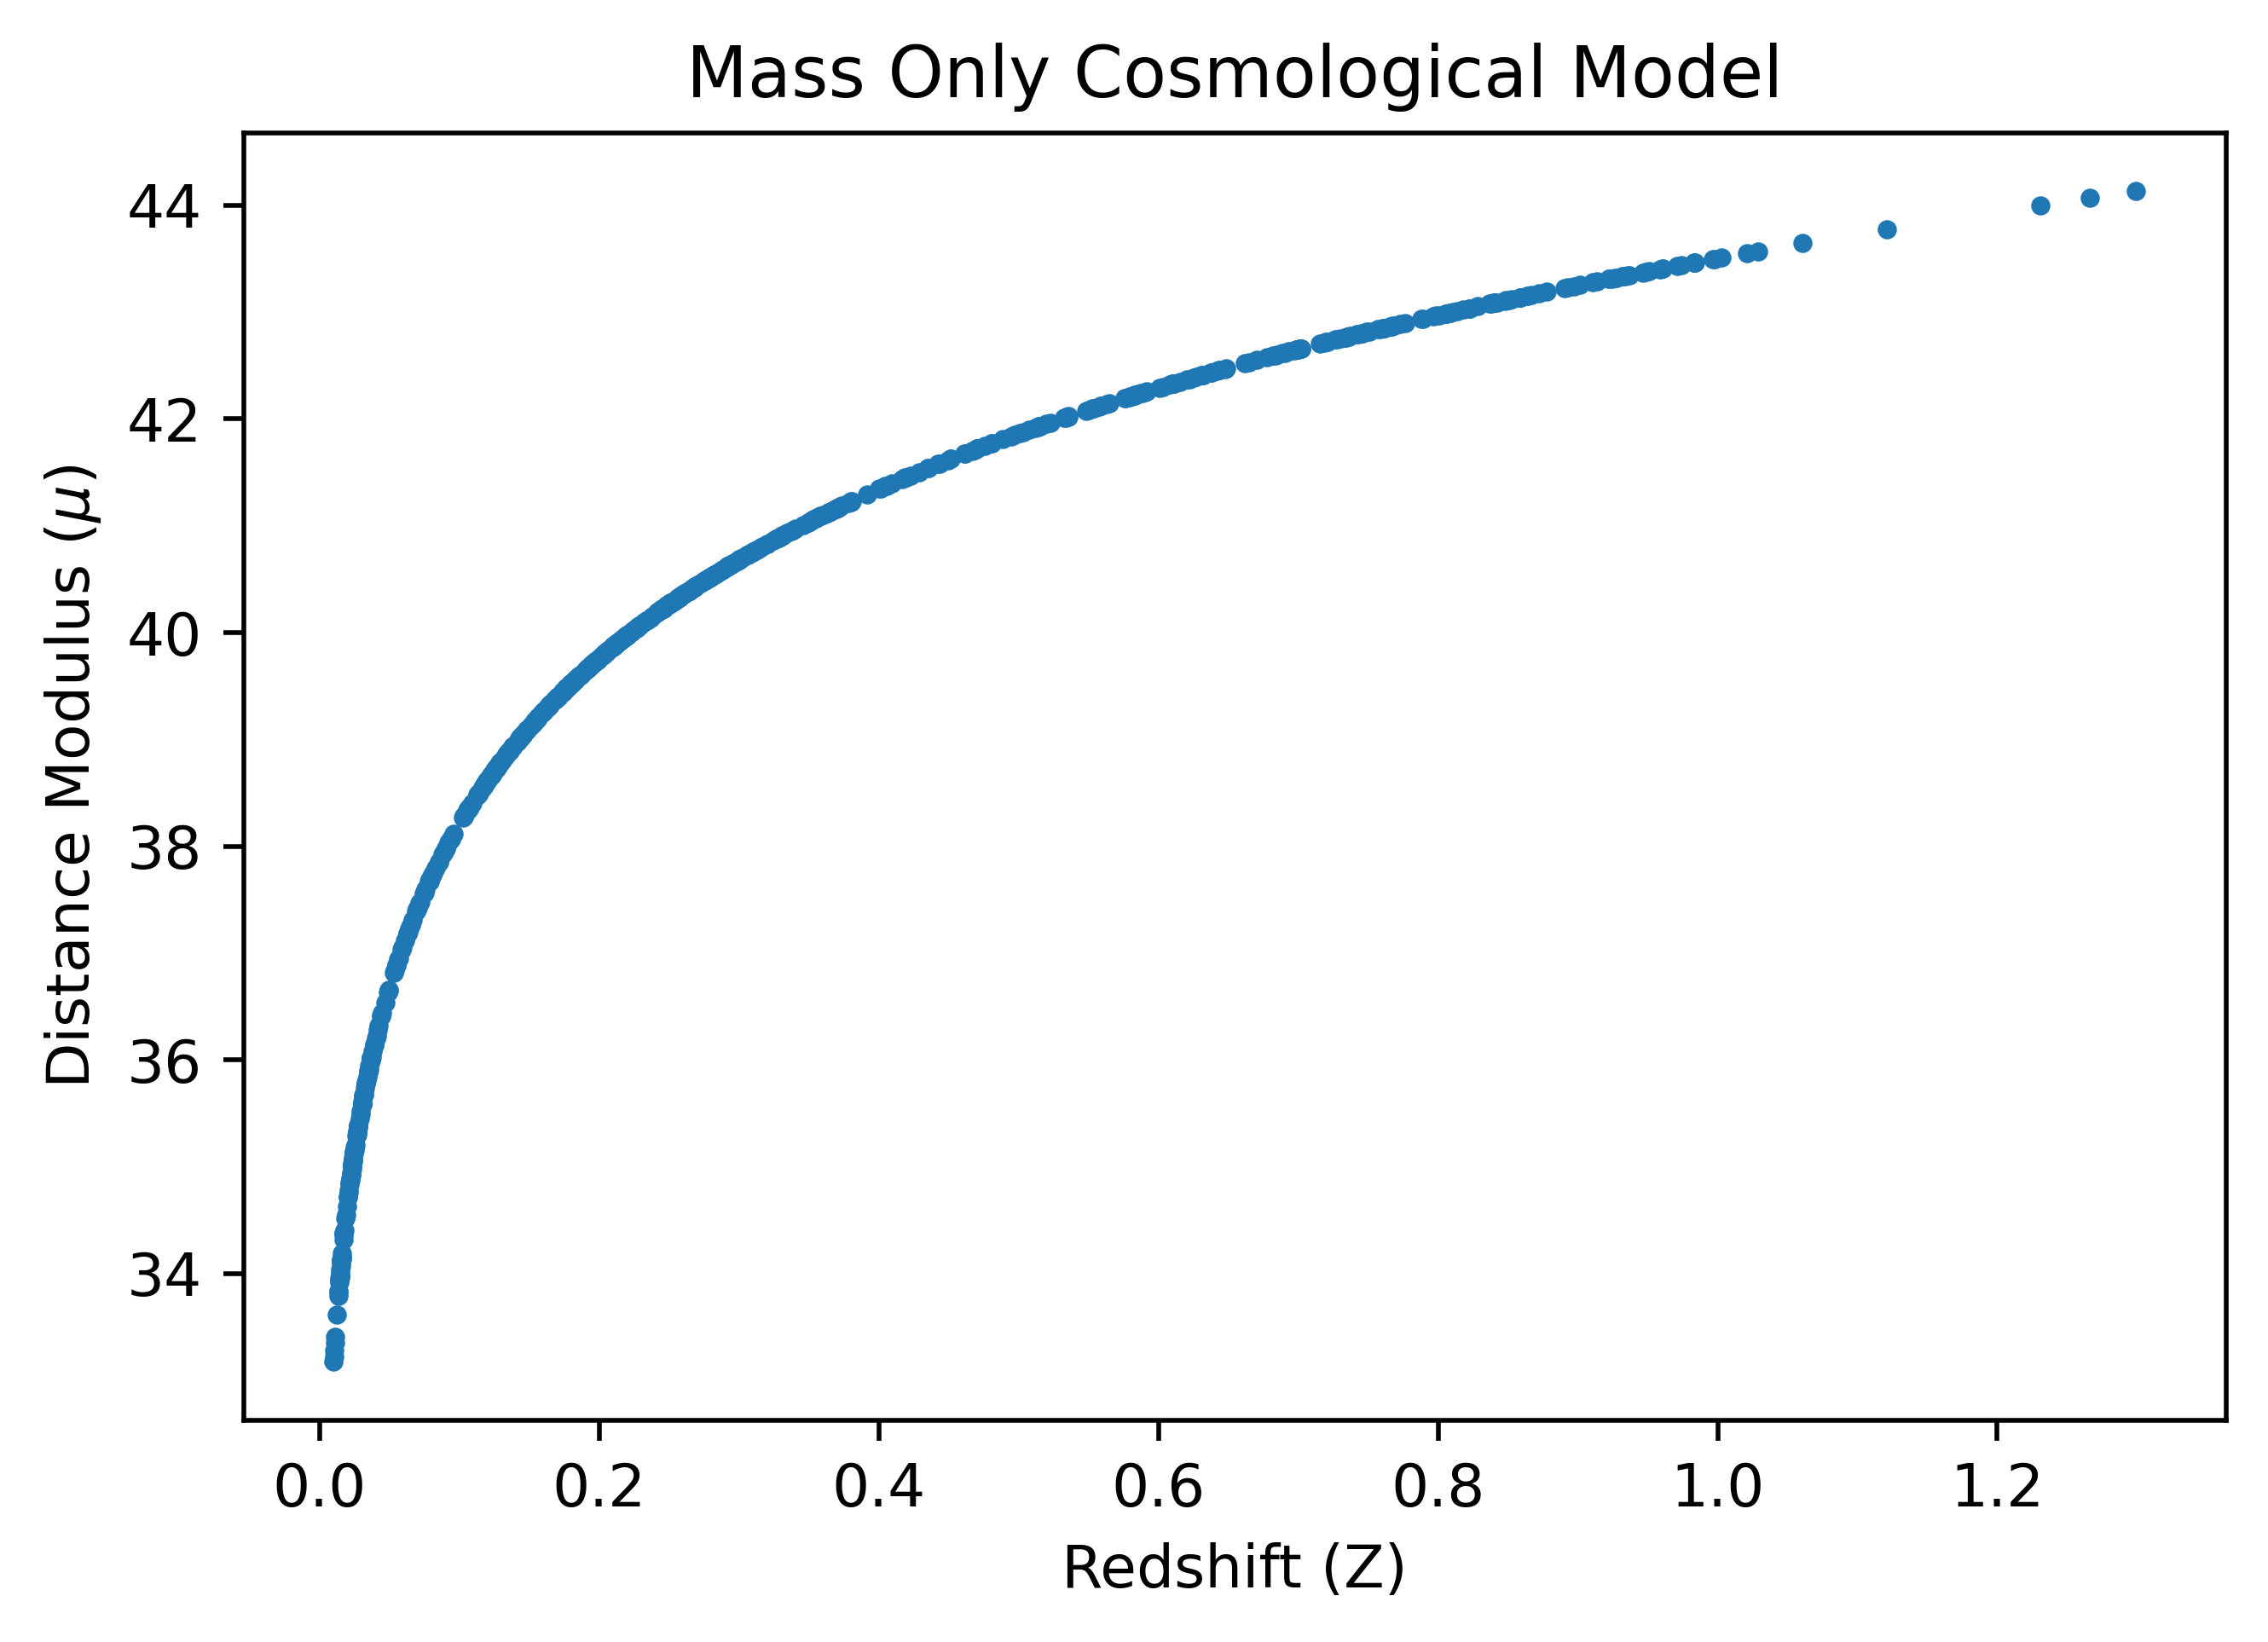

In [857]:
Flat_Model = FlatLambdaCDM(H0=70,Om0=1.0)
flat_dist = [Flat_Model.distmod(redshifts[i]).value for i in range(len(redshifts))]

plt.figure(dpi=500)
plt.scatter(redshifts,flat_dist,s=5,label='Mass Only')
plt.xscale('log')
plt.ylabel(r'Distance Modulus ($\mu$)') 
plt.xlabel(r'Redshift (Z)')
plt.title('Mass Only Cosmological Model')
plt.savefig('massmodel',bbox_inches='tight')

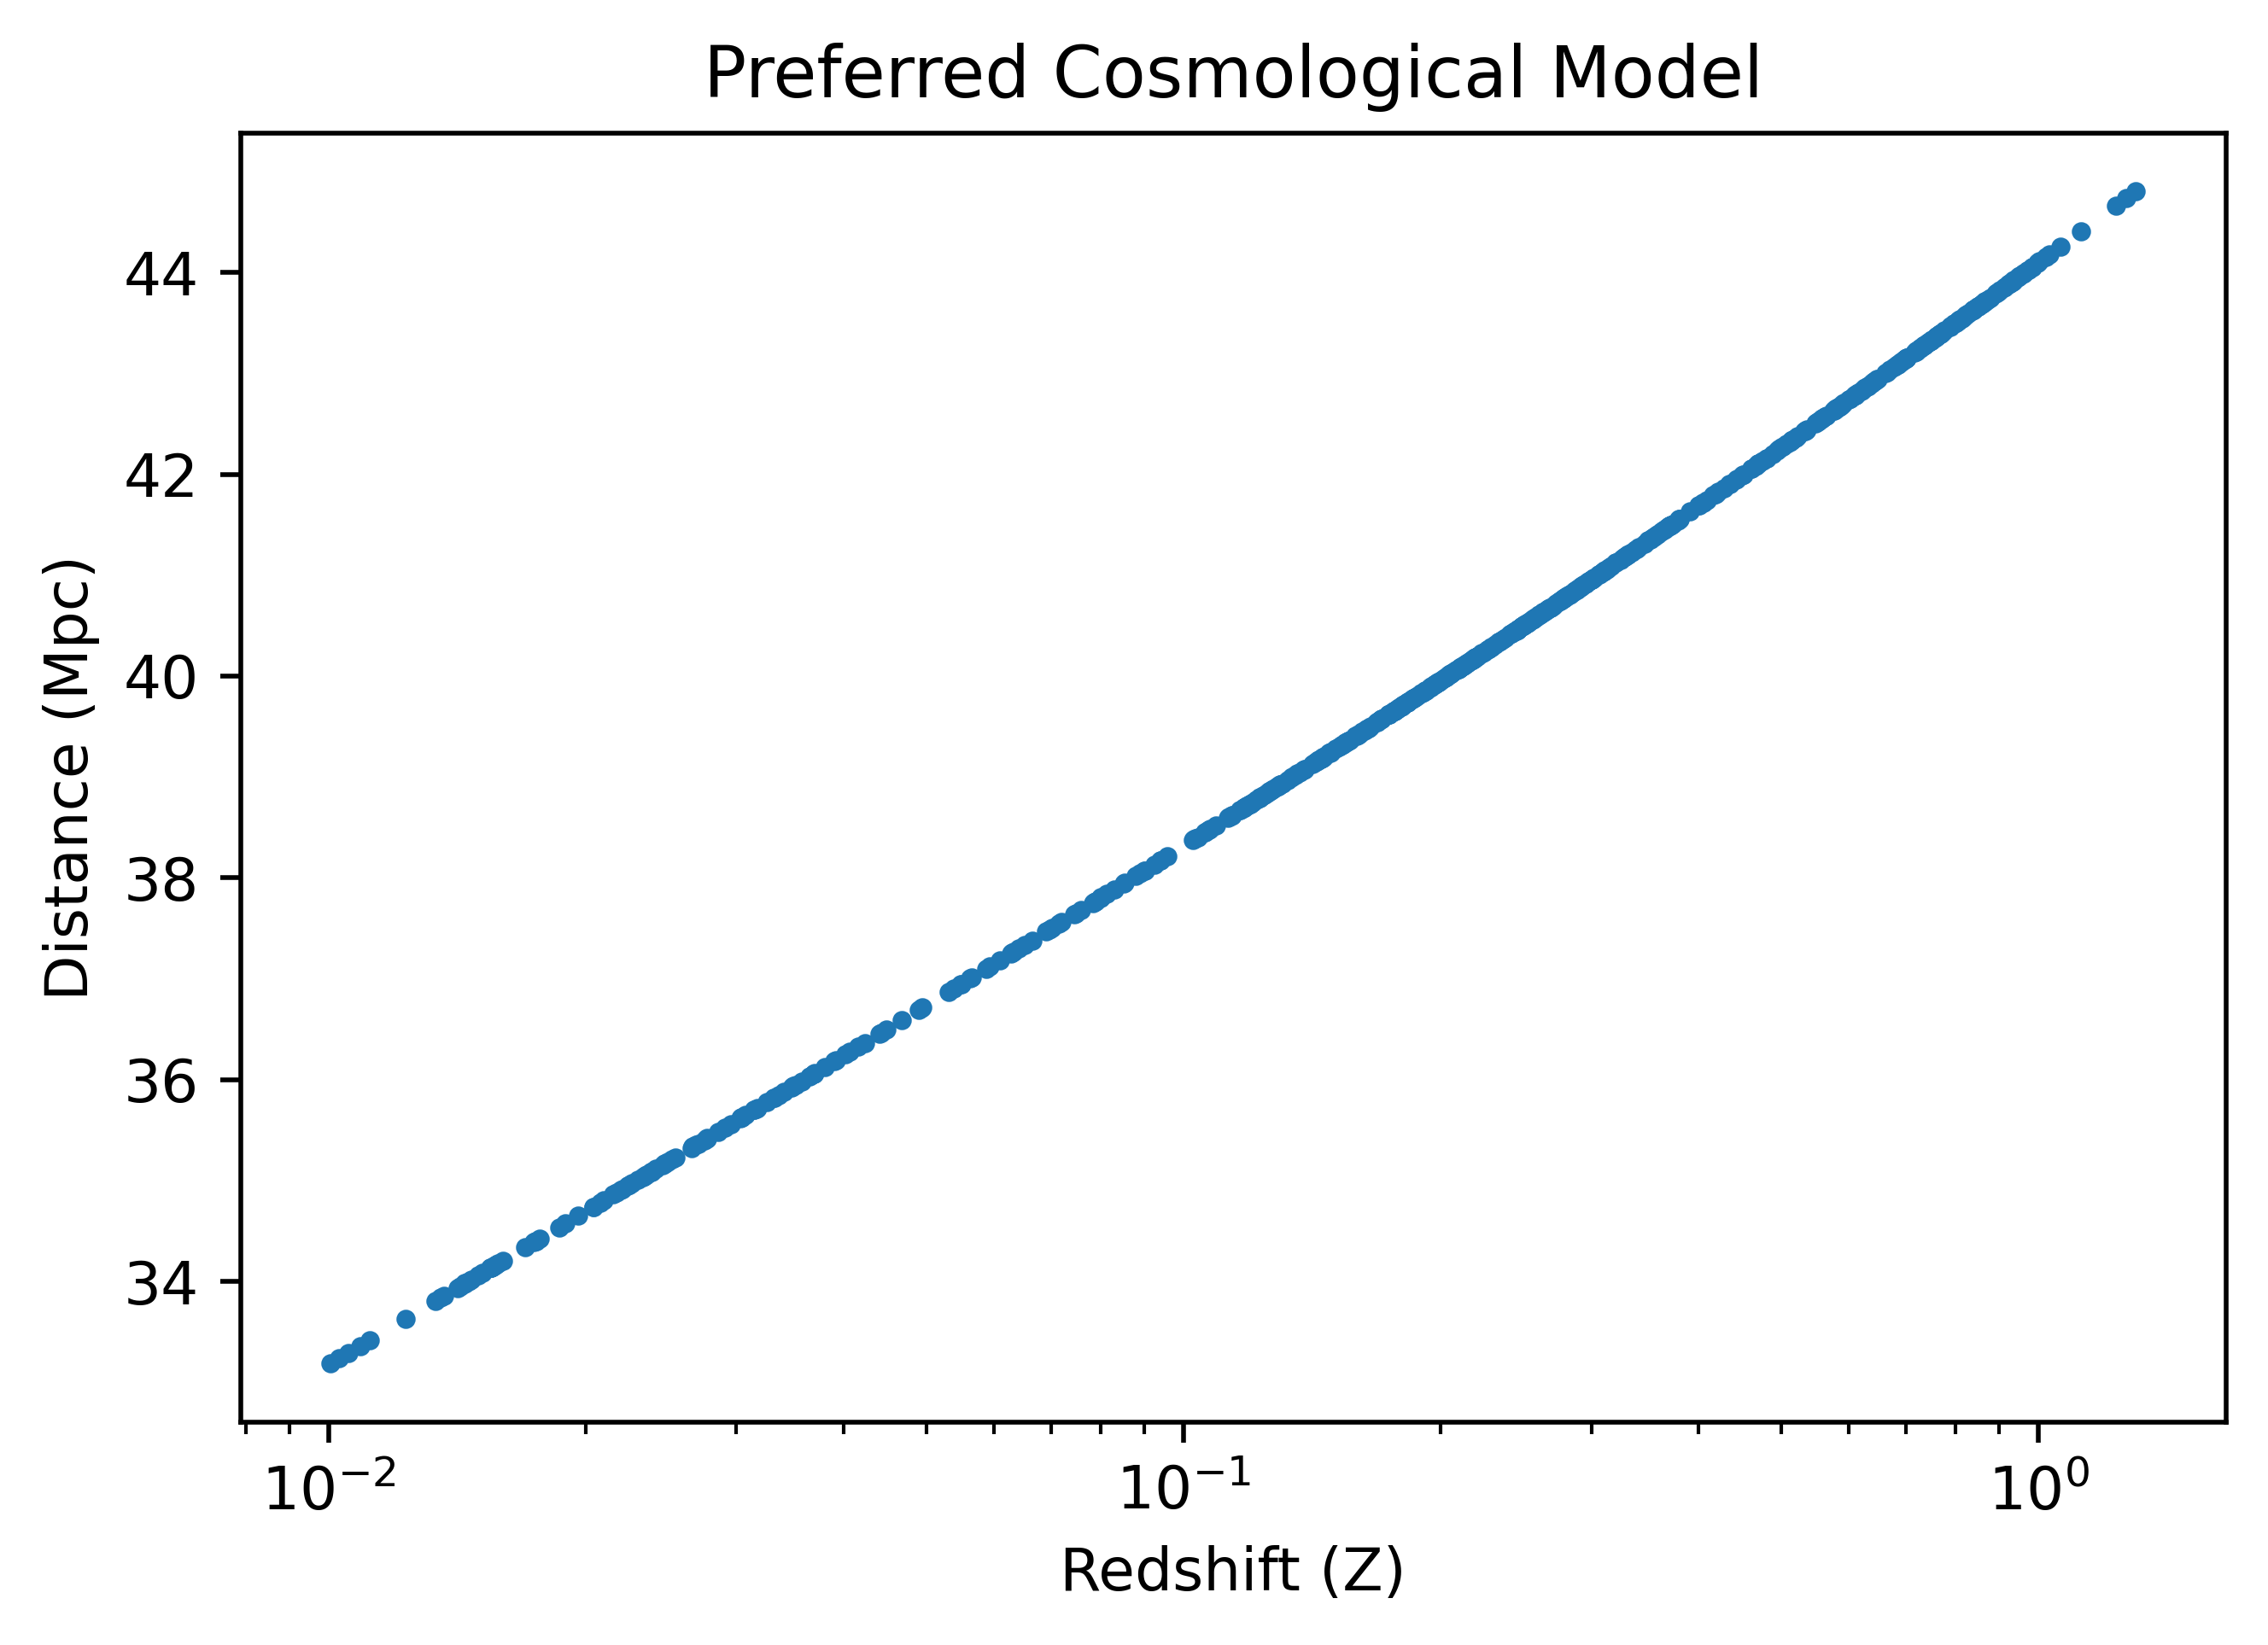

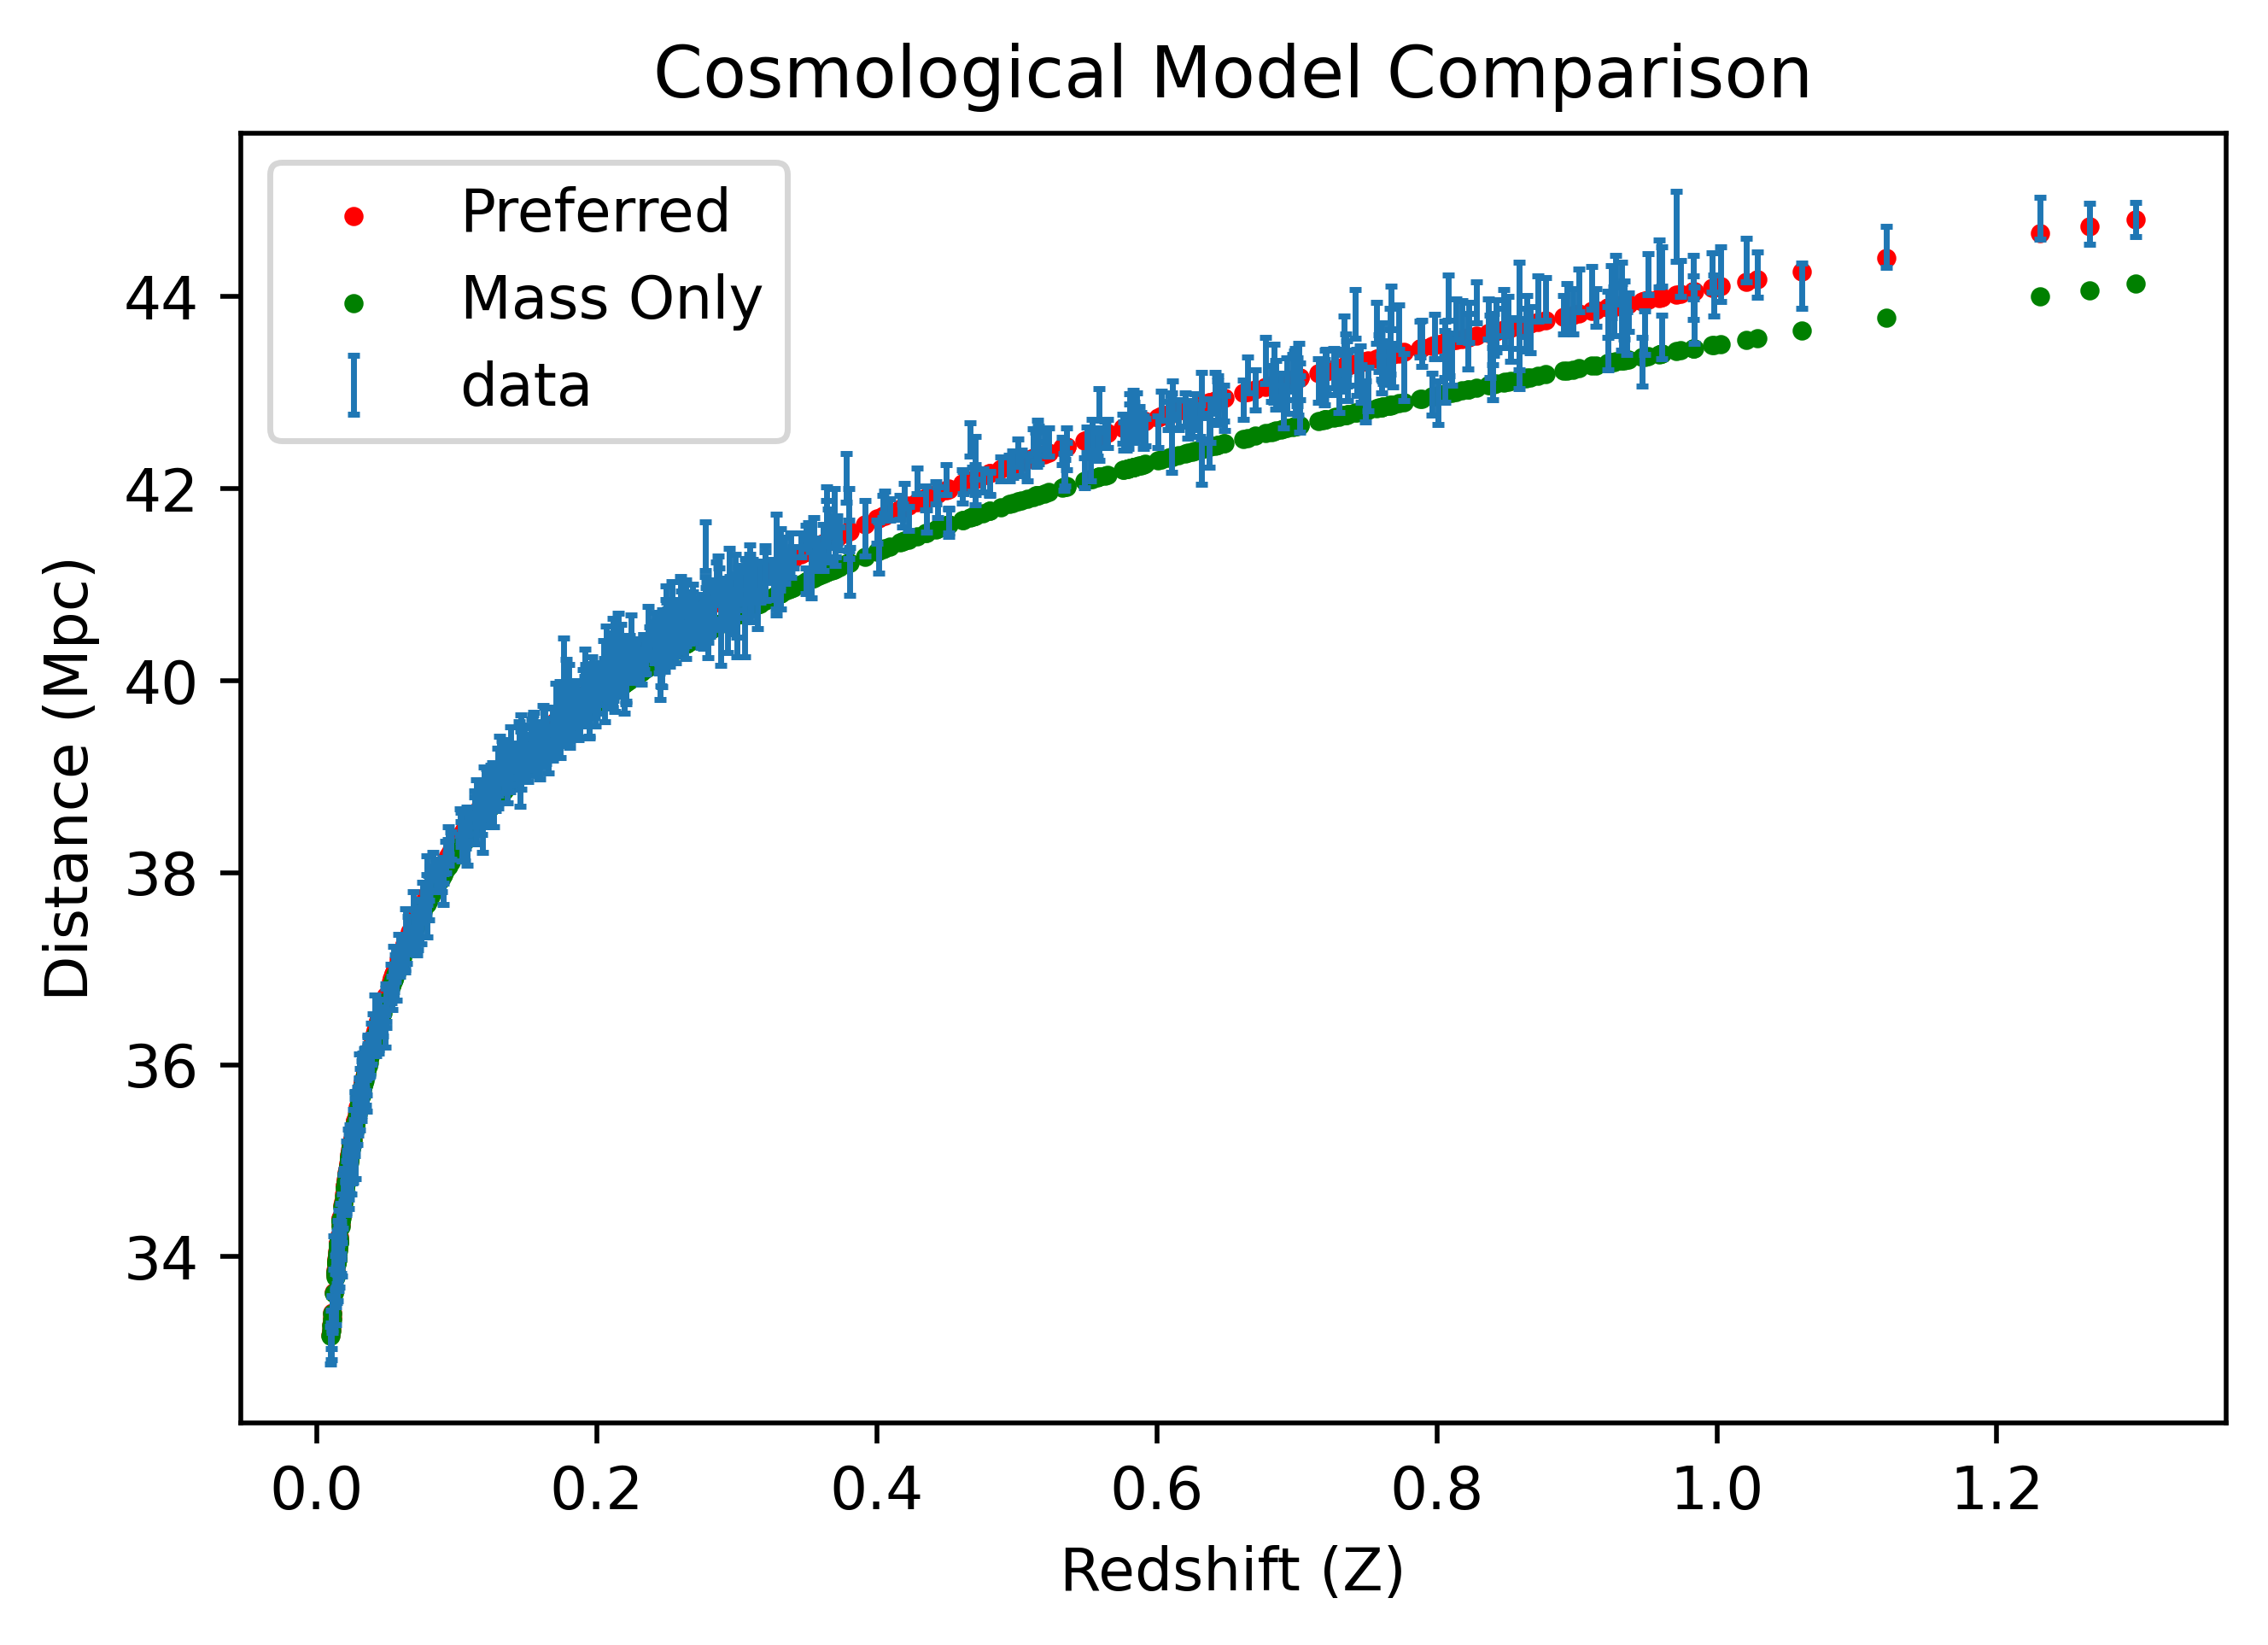

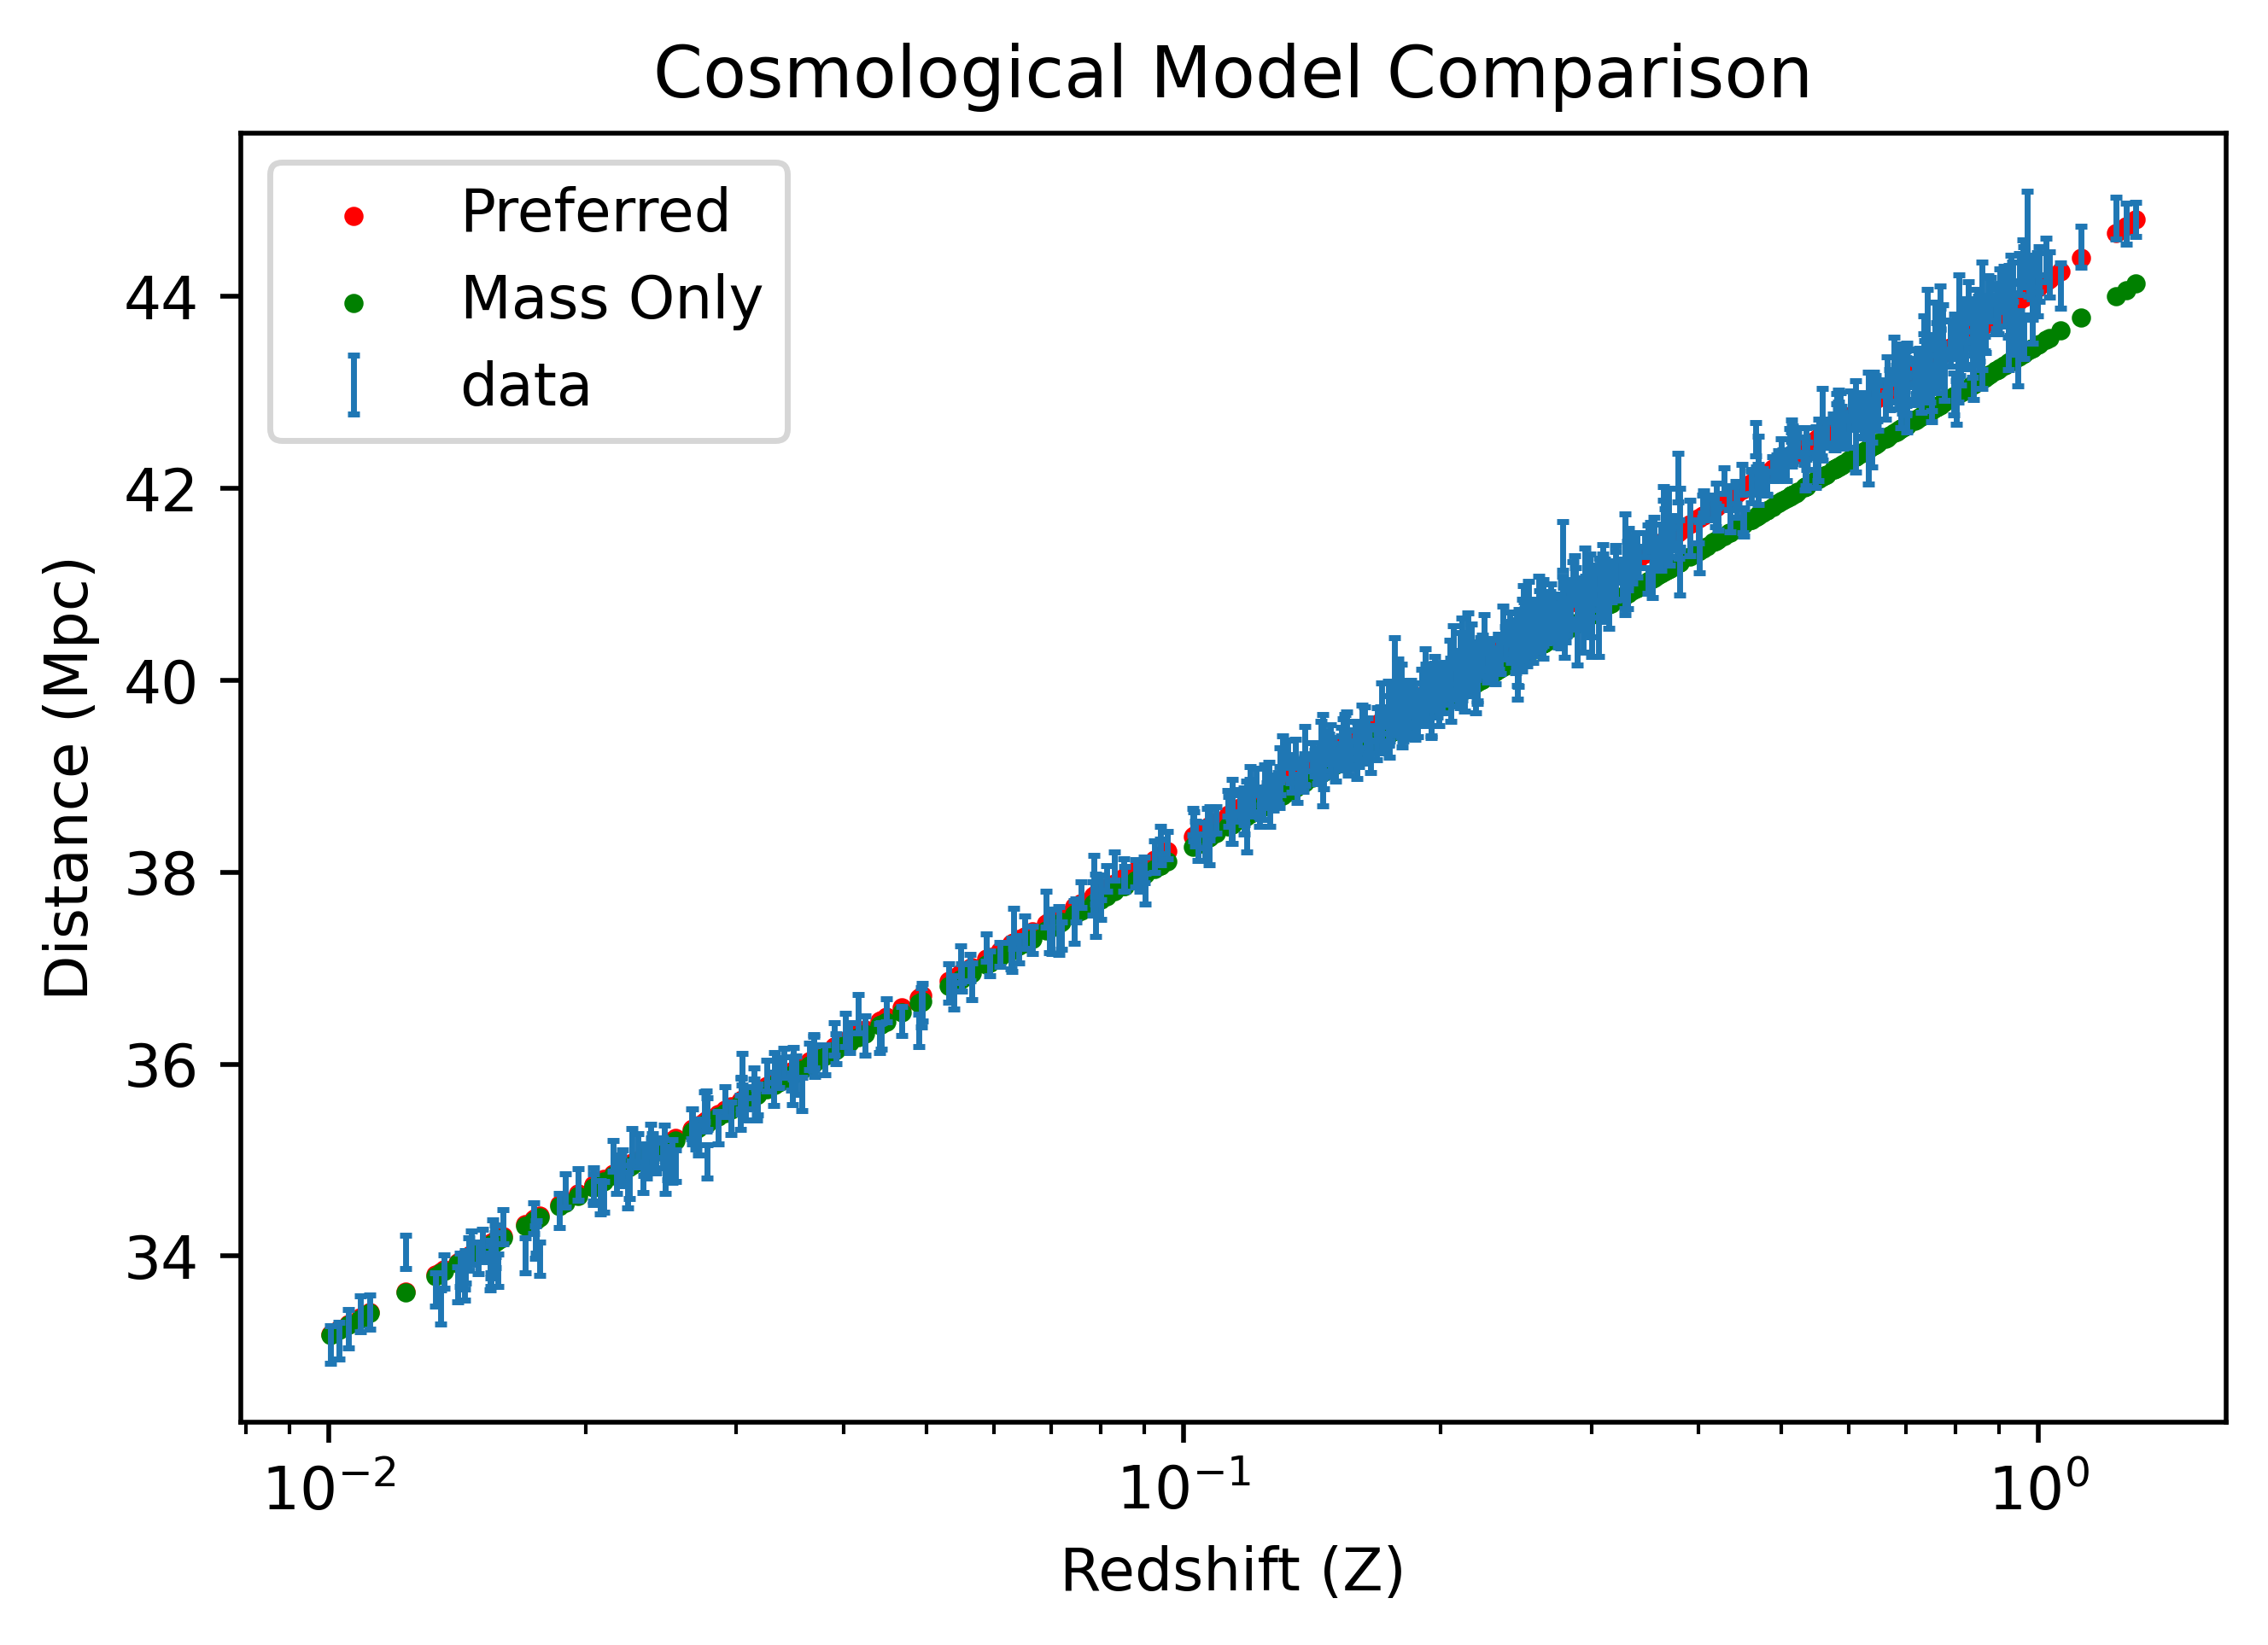

In [908]:
pref_dist = [pref_Model2.distmod(redshifts[i]).value for i in range(len(redshifts))]

plt.figure(dpi=500)
plt.scatter(redshifts,pref_dist,s=5)
plt.xscale('log')
plt.ylabel(r'Distance (Mpc)') 
plt.xlabel(r'Redshift (Z)')
plt.title('Preferred Cosmological Model')
plt.savefig('preferredmodel',bbox_inches='tight')

plt.figure(dpi=500)
plt.scatter(redshifts,pref_dist,s=5,label='Preferred',c='red')
plt.errorbar(redshifts,mus,yerr= err_mus,fmt='none',capsize=1,elinewidth = 1,label='data')
plt.scatter(redshifts,flat_dist,s=5,label='Mass Only',c='green')
plt.legend()
# plt.xscale('log')
plt.ylabel(r'Distance (Mpc)') 
plt.xlabel(r'Redshift (Z)')
plt.title('Cosmological Model Comparison')
plt.savefig('modelcomparison_linear',bbox_inches='tight')

plt.figure(dpi=500)
plt.scatter(redshifts,pref_dist,s=5,label='Preferred',c='red')
plt.errorbar(redshifts,mus,yerr= err_mus,fmt='none',capsize=1,elinewidth = 1,label='data')
plt.scatter(redshifts,flat_dist,s=5,label='Mass Only',c='green')
plt.legend()
plt.xscale('log')
plt.ylabel(r'Distance (Mpc)') 
plt.xlabel(r'Redshift (Z)')
plt.title('Cosmological Model Comparison')
plt.savefig('modelcomparison_log',bbox_inches='tight')

In [886]:

# print(chi2_partD(mass_fit,line,redshifts, flat_dist))
# print(chi2_partD(massless_fit, line, redshifts, massless))
##chi2 function, and fits have been lost due to editing and then saving, losing the checkpoint. 

#however from memory the preferred cosmological model was the best

In [914]:
print('Preferred Model chi2:',chi2_partD(np.array(pref_dist), redshifts, np.array(mus)))
print('Mass Model chi2:',chi2_partD(np.array(flat_dist), redshifts, np.array(mus)))
# print('Massless Model:',chi2_partD(np.array(massless), redshifts, np.array(mus)))
#seem higher than when I got them before
#however the preferred model is  superior
print()
#massless model is distance, not distance modulus!! - cant compare to distance modulus
print('Preferred model:Massless model chi2 ratio:', chi2_partD(np.array(flat_dist), redshifts, np.array(mus))/chi2_partD(np.array(pref_dist), redshifts, np.array(mus)))
print('Preferred model has 4x better chi^2 value')


Preferred Model chi2: 21.995559481056425
Mass Model chi2: 86.83305706864908

Preferred model:Massless model chi2 ratio: 3.9477539611317303
Preferred model has 4x better chi^2 value


In [915]:
# I recreated the chi^2 for putting in the report